In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join

%matplotlib inline

In [2]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.xbase = None

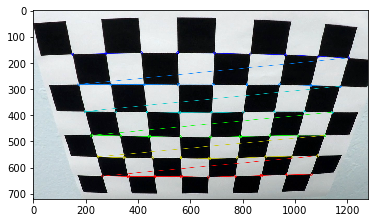

In [3]:
# prepare object points
nx = 9
ny = 6
nyx = (9, 6)

def plot_chessboard_corners(filepath):
    # Make a list of calibration images
    img = cv2.imread(filepath)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        plt.show

plot_chessboard_corners('camera_cal/calibration2.jpg')

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(undistorted)
#ax2.set_title('Undistorted Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

./camera_cal/calibration6.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration8.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration5.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration4.jpg


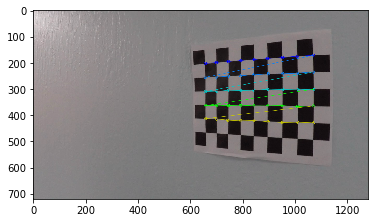

In [5]:
def extract_img_obj_points(nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    mypath = "./camera_cal"

    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

    # Step through the list and search for chessboard corners
    for file in onlyfiles:
        final_path = mypath + '/' + file
        img = cv2.imread(final_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        print(final_path)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9, 5), corners, ret)
            plt.imshow(img)
    return objpoints, imgpoints

objpoints, imgpoints = extract_img_obj_points(nx, ny)

In [6]:
#undistorted = cal_undistort(img, objpoints, imgpoints)

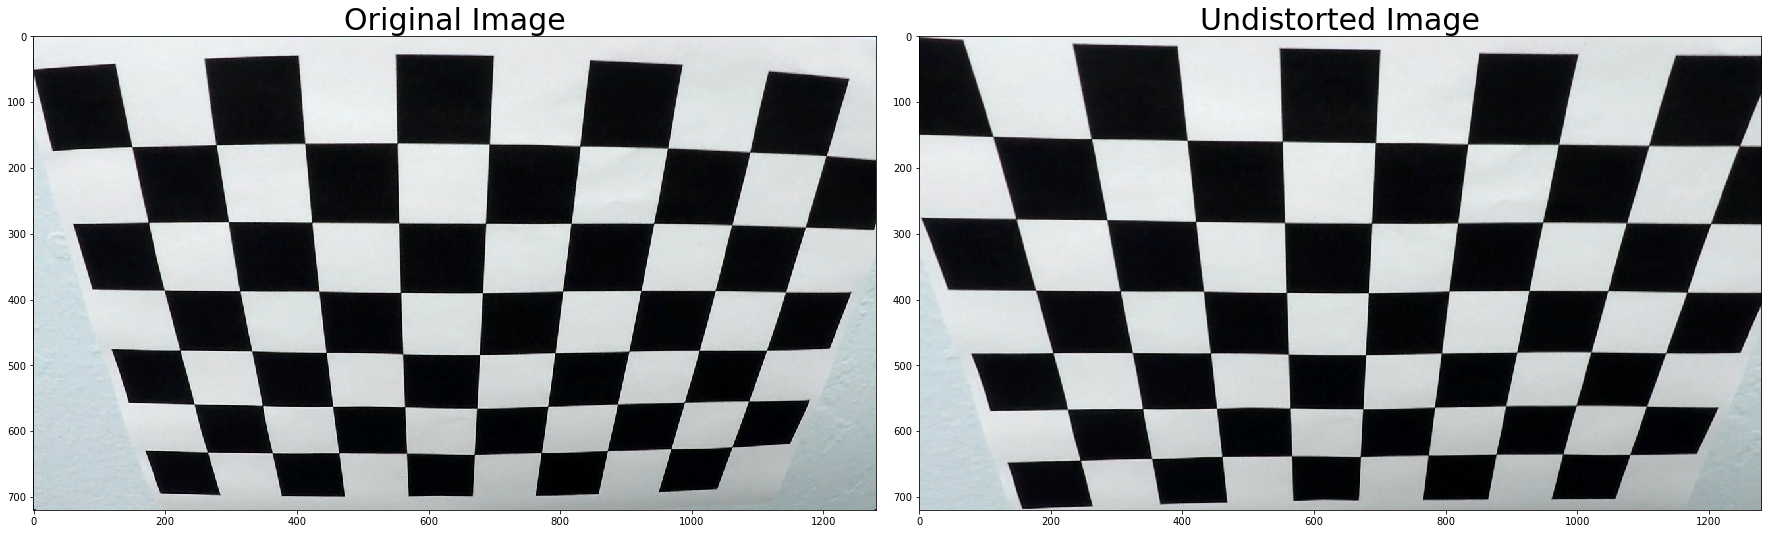

In [7]:
def plot_write_undistored_img():
    # Test undistortion on an image
    fname = 'camera_cal/calibration2.jpg'
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('calibration_wide/test_undist.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return mtx, dist
    
mtx, dist = plot_write_undistored_img()

In [8]:
def corners_unwarp(img, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    
    offset1 = 280 # offset for dst points x value
    #[572,465],[714,465],[1035,673],[270,673]
    src = np.float32([(575,464),(707,464), (1049,682), (258,682)])
    dst = np.float32([[offset1, 0], [img_size[0]-offset1, 0], 
                      [img_size[0]-offset1, img_size[1]], [offset1, img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

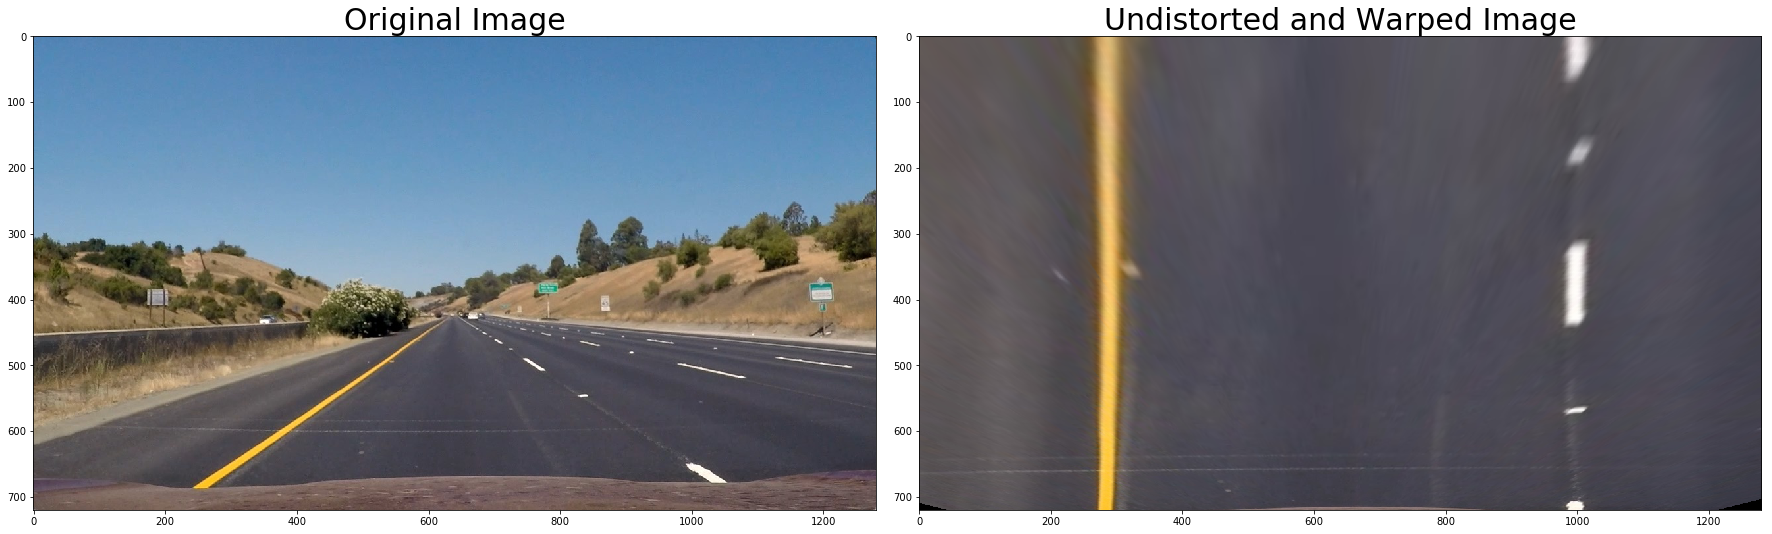

In [9]:
def plot_undistord_warp_img():
    fname = 'test_images/straight_lines1.jpg'
    img_test = cv2.imread(fname)
    rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    dst_test = cv2.undistort(rgb, mtx, dist, None, mtx)

    top_down, perspective_M, Minv = corners_unwarp(dst_test, mtx, dist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(rgb)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(top_down)
    ax2.set_title('Undistorted and Warped Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plot_undistord_warp_img()

In [10]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255), channel=2):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:, :, channel]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def lab_bthresh(img, thresh=(190,255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    return binary_output

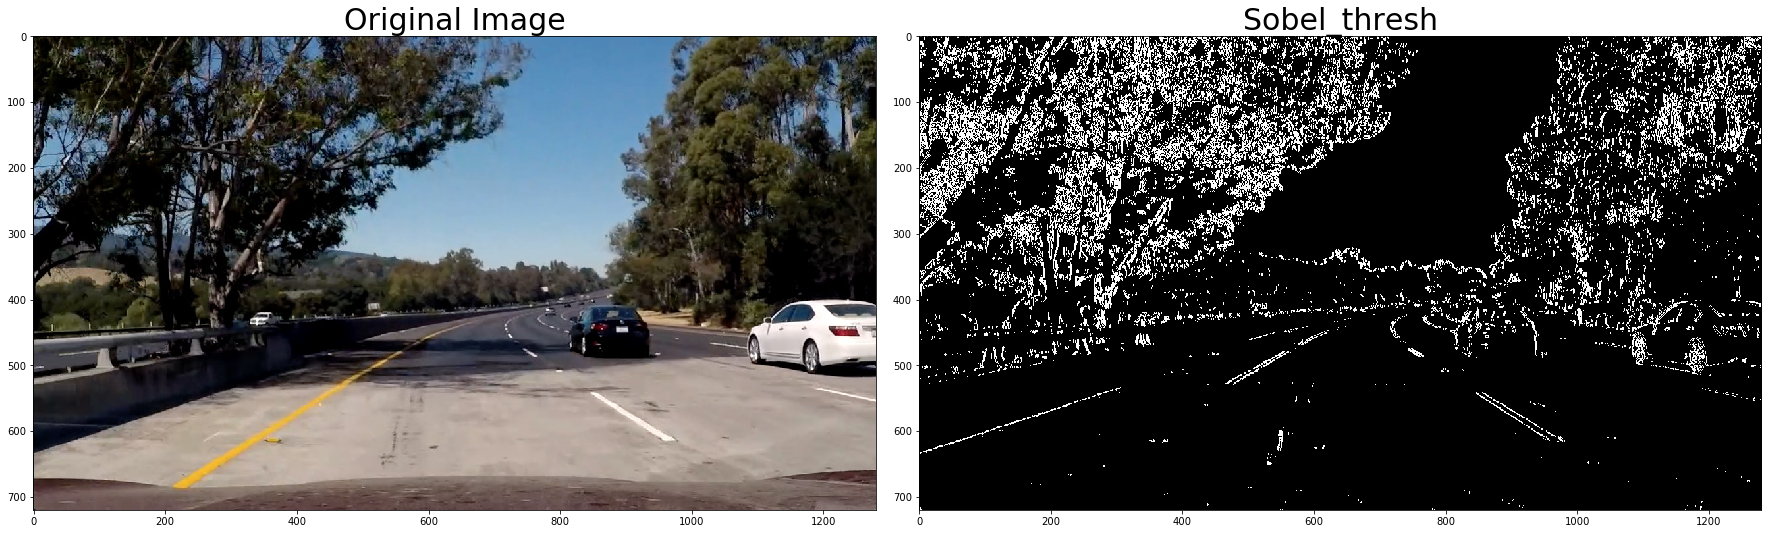

In [11]:
def plot_sobel_thresh_select():
    fname = 'test_images/test5.jpg'
    #img_test = cv2.imread(fname)
    img_test = mpimg.imread(fname) 

    res = abs_sobel_thresh(img_test, thresh=(20, 100))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_test)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(res, cmap='gray')
    ax2.set_title('Sobel_thresh', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plot_sobel_thresh_select()

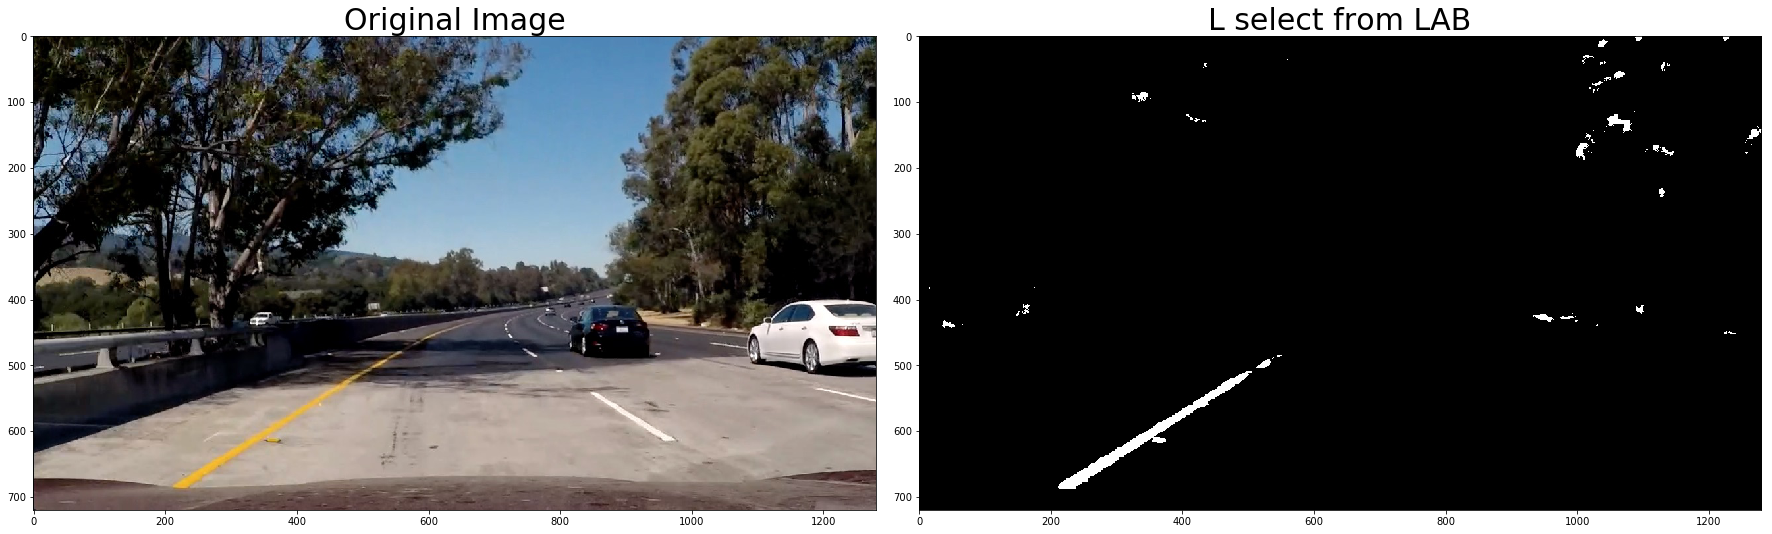

In [12]:
def plot_lab_select():
    fname = 'test_images/test5.jpg'
    #img_test = cv2.imread(fname)
    img_test = mpimg.imread(fname) 

    res = lab_bthresh(img_test, thresh=(190,255))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_test)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(res, cmap='gray')
    ax2.set_title('L select from LAB', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plot_lab_select()

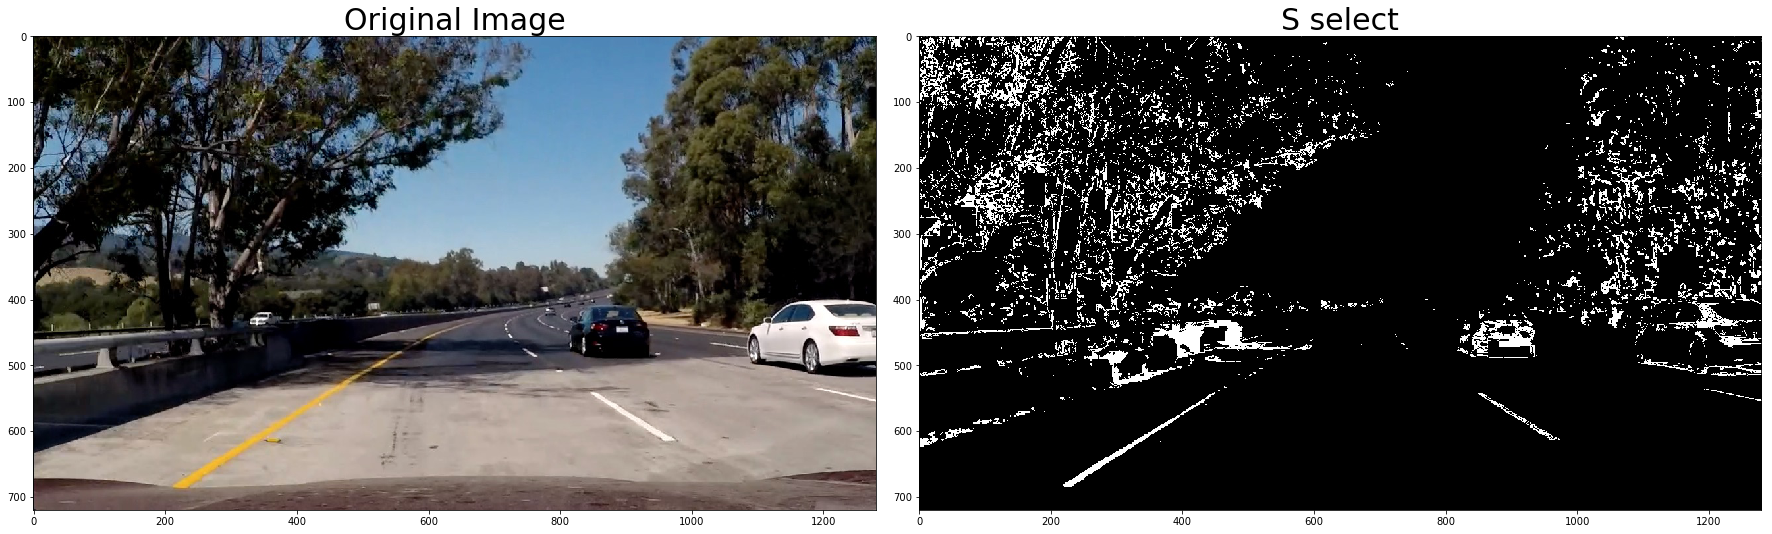

In [13]:
def plot_sls_select():
    fname = 'test_images/test5.jpg'
    #img_test = cv2.imread(fname)
    img_test = mpimg.imread(fname) 

    res = hls_select(img_test, thresh=(190, 255))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_test)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(res, cmap='gray')
    ax2.set_title('S select', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plot_sls_select()

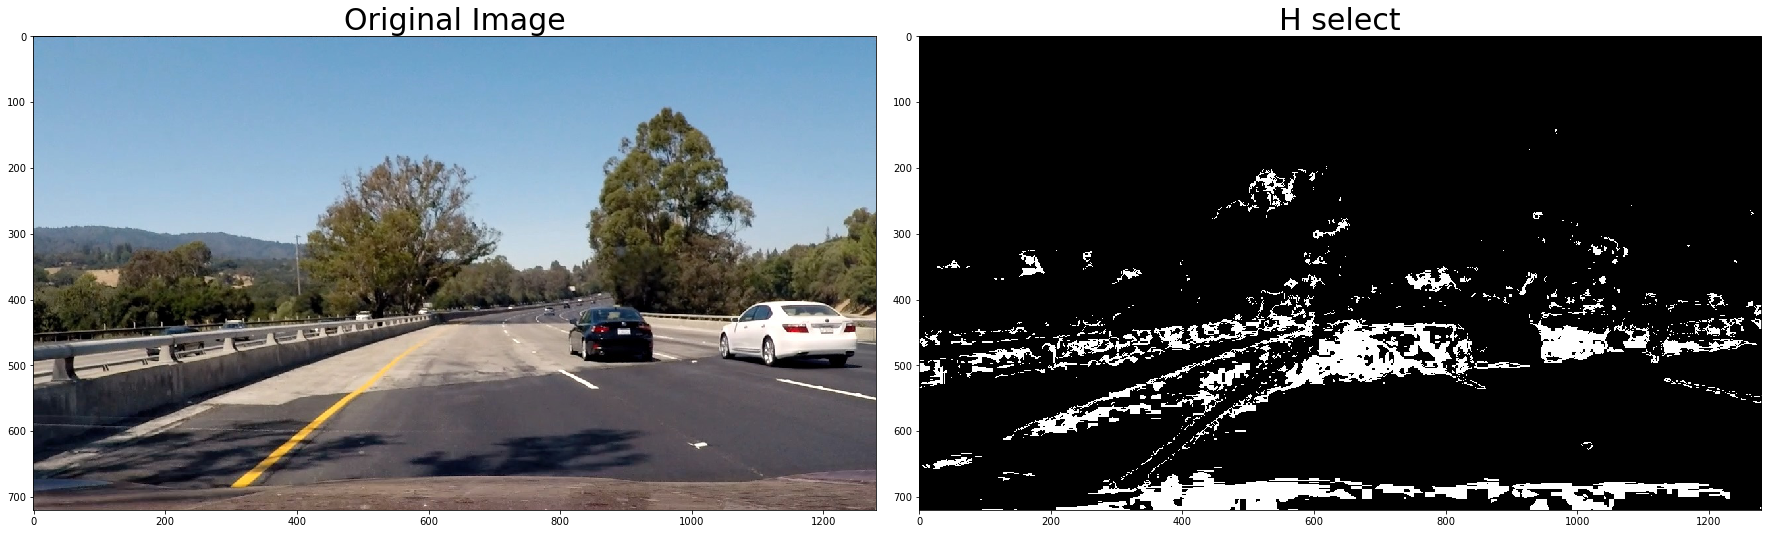

In [14]:
def plot_sls_select():
    fname = 'test_images/test4.jpg'
    #img_test = cv2.imread(fname)
    img_test = mpimg.imread(fname) 

    res = hls_select(img_test, thresh=(8,14), channel=0)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_test)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(res, cmap='gray')
    ax2.set_title('H select', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plot_sls_select()

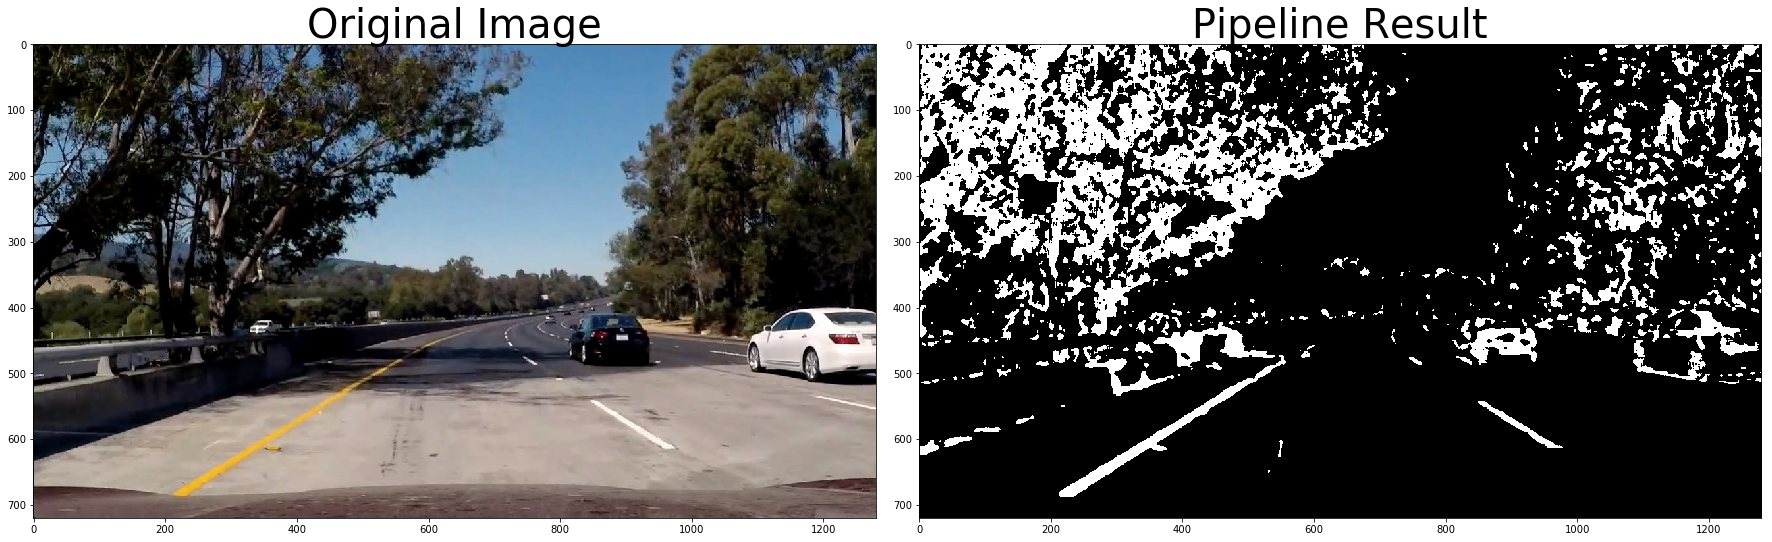

In [15]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]

    sxbinary = abs_sobel_thresh(img, thresh=sx_thresh)
    
    s_binary = hls_select(img, thresh=s_thresh)
    
    bthresh = lab_bthresh(img)
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #np.zeros_like(sxbinary)
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, sxbinary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)| (bthresh == 1)] = 1
    
    #combined_binary = cv2.blur(combined_binary, (1,1))
    combined_binary = cv2.medianBlur(combined_binary,7)
    #combined_binary = cv2.GaussianBlur(combined_binary, (3,3), 0)
    return combined_binary
    
def plot_combi_hls_sobel():
    fname = 'test_images/test5.jpg'
    img_test = mpimg.imread(fname) 

    result = pipeline(img_test)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img_test)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plot_combi_hls_sobel()

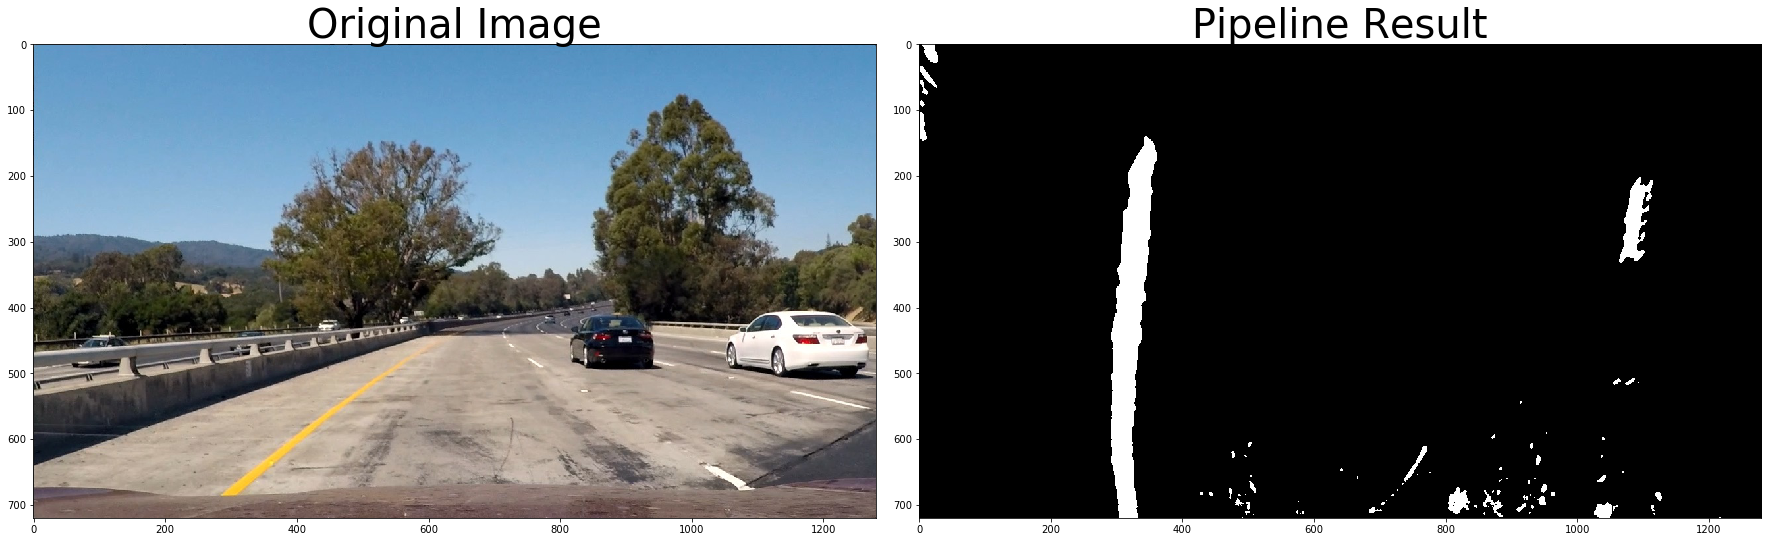

In [16]:
def alternative_pipeline_order(img):
    dst_test = cv2.undistort(img, mtx, dist, None, mtx)
    binary_warped, perspective_M, Minv = corners_unwarp(dst_test, mtx, dist)
    result = pipeline(binary_warped)
    
    return result
    
def plot_alternative_pipeline():
    fname = 'test_images/test1.jpg'
    img_test = mpimg.imread(fname) 
    result = alternative_pipeline_order(img_test)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img_test)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plot_alternative_pipeline()

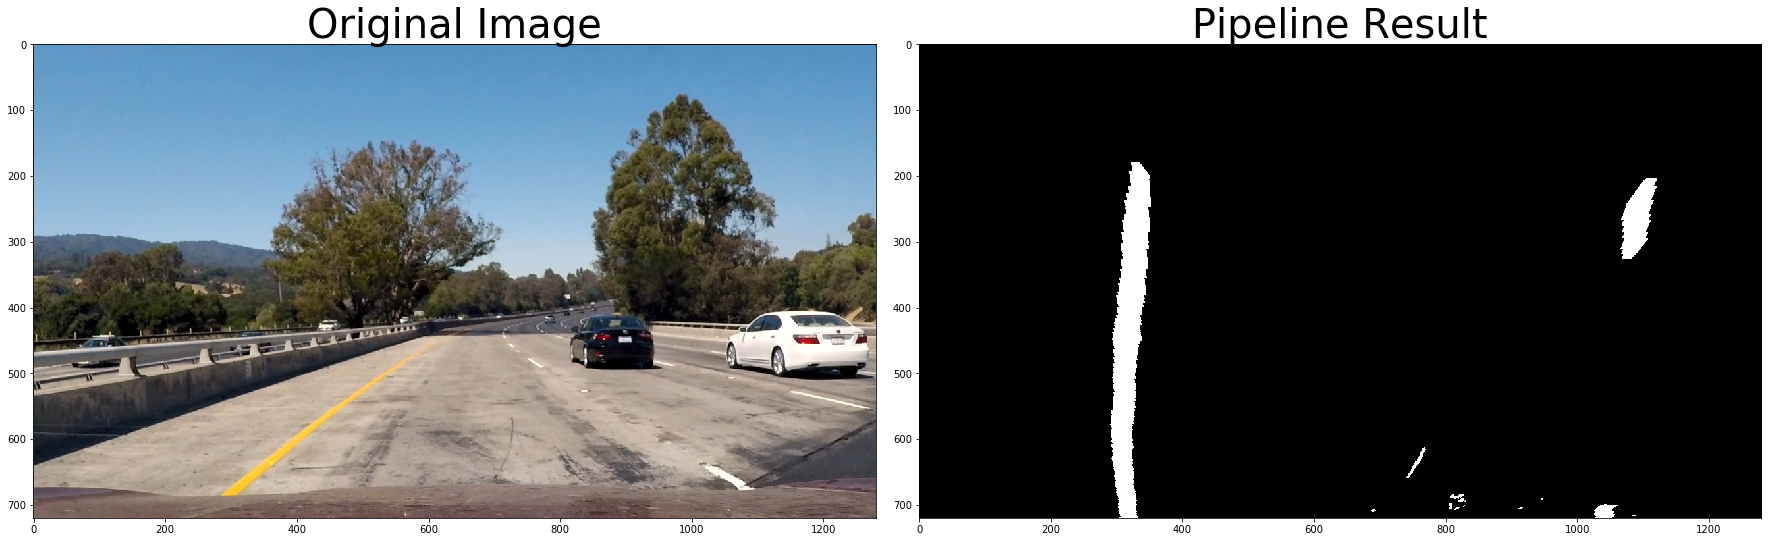

In [17]:
def pipeline_binary_warped(img):
    result = pipeline(img)
    dst_test = cv2.undistort(result, mtx, dist, None, mtx)
    binary_warped, perspective_M, Minv = corners_unwarp(dst_test, mtx, dist)
    return binary_warped, perspective_M, Minv

def plot_preprocessing_warped():
    fname = 'test_images/test1.jpg'
    img_test = mpimg.imread(fname) 

    binary_warped, perspective_M, Minv = pipeline_binary_warped(img_test)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img_test)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(binary_warped, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plot_preprocessing_warped()

In [18]:
def find_lanes(binary_warped, left_line, right_line):
    # Identify the x and y positions of all nonzero pixels in the image
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Choose the number of sliding windows
    nwindows = 8

    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    
    # Current positions to be updated for each window
    leftx_current = left_line.xbase
    rightx_current = right_line.xbase
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
   
    return left_lane_inds, right_lane_inds, left_line, right_line

In [19]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped):
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 70 # How much to slide left and right for searching
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        #output = template
        output = 1.0*(output[:,:,1] > 50)
        
    # If no window centers found, just display orginal road image
    else:
        print("not found")
        #output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        output = warped
        
    
    #binary_output = np.zeros_like(output)
    #binary_output[(output >= 0) & (output <= 255)] = 1
    
    return output

(720, 1280)


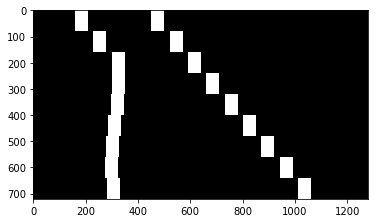

In [20]:
def plot_find_poly(filepath):
    img_test = mpimg.imread(filepath) 

    binary_warped, perspective_M, Minv = pipeline_binary_warped(img_test)
    out_img= find_window_centroids(binary_warped)
    
    print(out_img.shape)
    plt.imshow(out_img, cmap='gray')
   
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
plot_find_poly('test_images/test1.jpg')

In [21]:
def histogram_starter(binary_warped, left_line, right_line):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    left_line.xbase = leftx_base
    right_line.xbase = rightx_base
    return left_line, right_line, out_img

In [22]:
def fit_poly(binary_warped, left_lane_inds, right_lane_inds, out_img, left_line, right_line):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds] 

    try:
        # Fit a second order polynomial to left_line
        left_line.current_fit = np.polyfit(left_line.ally, left_line.allx, 2)
    except Exception as e:
        left_line.current_fit = None
        
    try:
        # Fit a second order polynomial to right_line
        right_line.current_fit = np.polyfit(right_line.ally, right_line.allx, 2)
    except Exception as e:
        right_line.current_fit = None

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #left_fitx = left_line.current_fit[0]*ploty**2 + left_line.current_fit[1]*ploty + left_line.current_fit[2]
    #right_fitx = right_line.current_fit[0]*ploty**2 + right_line.current_fit[1]*ploty + right_line.current_fit[2]

    #left_line.recent_xfitted.append(left_fitx)
    #right_line.recent_xfitted.append(right_fitx)
    #left_line.bestx = left_fitx
    #right_line.bestx = right_fitx
        
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]
    
    return ploty, left_line, right_line, out_img

In [23]:
def sanity_check_line(line, ploty):
    nb_history = 8
    nb_diff_mean = 2
    
    if len(line.recent_xfitted) > nb_history:
        line.recent_xfitted = line.recent_xfitted[-nb_history:]
    
    if line.current_fit != None:
        # diff du current avec les history polynomes
        if len(line.recent_xfitted) > nb_diff_mean:
                line.diffs = line.current_fit - np.mean(line.recent_xfitted[-nb_diff_mean:], axis=0)

        print(line.diffs)

        #TODO change that
        if np.absolute(line.diffs[0]) < 0.0005:
        # on ajoute le current au history
            line.recent_xfitted.append(line.current_fit)
    
    # moyenne des polynomes
    line.best_fit = np.mean(line.recent_xfitted, axis=0)
    
    # on recalcule le fitx avec le best polynome
    # TODO  basé sur le resultat du diff
    line.bestx = line.best_fit[0]*ploty**2 + line.best_fit[1]*ploty + line.best_fit[2]    
    return line

In [24]:
def sanity_check(left_line, righe_line, ploty):
    pass

In [25]:
def find_fit_poly_pipeline(binary_warped, left_line, right_line):
    left_line, right_line, out_img = histogram_starter(binary_warped, left_line, right_line)

    left_lane_inds, right_lane_inds, left_line, right_line = find_lanes(
                                                 binary_warped, left_line, right_line)

    ploty, left_line, right_line, out_img = fit_poly(binary_warped, left_lane_inds,
                                                     right_lane_inds, out_img,
                                                     left_line, right_line)
    left_line= sanity_check_line(left_line, ploty)
    right_line= sanity_check_line(right_line, ploty)
    #sanity_check(left_line, right_line, ploty)
    return ploty, left_line, right_line, out_img

[ 0.  0.  0.]
[ 0.  0.  0.]


/home/steve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


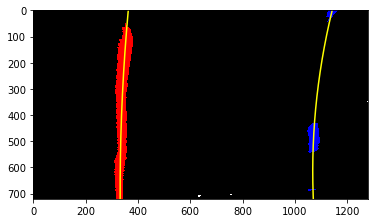

In [26]:
def plot_find_poly(filepath):
    img_test = mpimg.imread(filepath) 
    left_line = Line()
    right_line = Line()
    binary_warped, perspective_M, Minv = pipeline_binary_warped(img_test)
    
    # IN TEST
    #centroids = find_window_centroids(binary_warped)
    
    ploty, left_line, right_line, out_img = find_fit_poly_pipeline(binary_warped,
                                                                  left_line, right_line)
    
    plt.imshow(out_img)
    plt.plot(left_line.bestx, ploty, color='yellow')
    plt.plot(right_line.bestx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
plot_find_poly('test_images/test4.jpg')

In [27]:
def find_curvature(ploty, fitx):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

In [28]:
def process_curvature(ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Calculate the new radii of curvature
    left_curverad = find_curvature(ploty, left_fitx)
    right_curverad = find_curvature(ploty, right_fitx)
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

In [29]:
def print_curvature(path):
    img_test = mpimg.imread(path) 
    left_line = Line()
    right_line = Line()
    binary_warped, perspective_M, Minv = pipeline_binary_warped(img_test)
    ploty, left_line, right_line, out_img = find_fit_poly_pipeline(binary_warped,
                                                                  left_line, right_line)
    process_curvature(ploty, left_line.bestx, right_line.bestx)
    
print_curvature('test_images/test1.jpg')

[ 0.  0.  0.]
[ 0.  0.  0.]
1817.5282441 m 2149.07057677 m


/home/steve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


/home/steve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


[ 0.  0.  0.]
[ 0.  0.  0.]


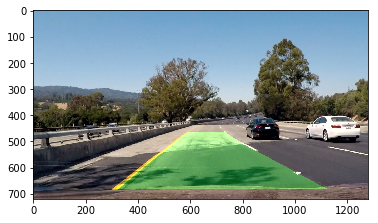

In [30]:
def global_process(img_test, left_line, right_line):
    result = pipeline(img_test)
    dst_test = cv2.undistort(result, mtx, dist, None, mtx)
    binary_warped, perspective_M, Minv = corners_unwarp(dst_test, mtx, dist)
    
    # IN TEST
    #centroids = find_window_centroids(binary_warped)
    
    
    ploty, left_line, right_line, out_img = find_fit_poly_pipeline(binary_warped,
                                                                   left_line, right_line)
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_test.shape[1], img_test.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_test, 1, newwarp, 0.3, 0)
    
    #newwarp = cv2.warpPerspective(out_img, Minv, (img_test.shape[1], img_test.shape[0]))
    return result

left_line = Line()
right_line = Line()
result = global_process(mpimg.imread('test_images/test4.jpg'), left_line, right_line)
plt.imshow(result)

In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [32]:
left_line = Line()
right_line = Line()
def process_image(image):
    result = global_process(image, left_line, right_line)
    return result

In [33]:
def global_pipeline_video(input_file, output):
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip(input_file)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output, audio=False)

global_pipeline_video("./project_video.mp4", "./project_video_processed_met3.mp4")

[ 0.  0.  0.]
[ 0.  0.  0.]
[MoviePy] >>>> Building video ./project_video_processed_met3.mp4
[MoviePy] Writing video ./project_video_processed_met3.mp4


  0%|          | 1/1261 [00:00<03:03,  6.86it/s]

[ 0.  0.  0.]
[ 0.  0.  0.]


  0%|          | 2/1261 [00:00<03:02,  6.88it/s]

[ 0.  0.  0.]
[ 0.  0.  0.]


  0%|          | 3/1261 [00:00<03:04,  6.81it/s]

[ -1.76160107e-05   1.64755498e-02  -1.84328196e+00]
[ -5.15101439e-05   2.80536048e-02  -5.45132626e+00]


  0%|          | 4/1261 [00:00<03:02,  6.90it/s]

[ -1.40051366e-05   1.65718163e-02  -2.08805163e+00]
[ -3.93066526e-05   2.09618741e-02  -3.09609654e+00]


  0%|          | 5/1261 [00:00<03:11,  6.57it/s]

[ -4.87875917e-06   1.09281565e-02  -2.74885122e+00]
[  5.94045750e-05  -7.30947394e-02   1.86371284e+01]


  0%|          | 6/1261 [00:00<03:19,  6.30it/s]

[  1.65835809e-05  -7.06806625e-03   1.05129066e-01]
[ -3.19431935e-04   3.17542139e-01  -7.02413009e+01]


  1%|          | 7/1261 [00:01<03:22,  6.18it/s]

[  1.66357257e-05  -4.06748796e-03  -2.73716833e+00]
[ -1.65966587e-04   1.65283600e-01  -3.60510776e+01]


  1%|          | 8/1261 [00:01<03:24,  6.12it/s]

[ -1.24206851e-07   8.38252899e-03  -3.14092697e+00]
[  2.35812932e-05  -2.84210731e-02   2.36895225e+00]


  1%|          | 9/1261 [00:01<03:29,  5.97it/s]

[ -4.15374494e-06   1.13995755e-02  -5.76031017e+00]
[  1.05783776e-04  -5.52418128e-02   3.66741839e+00]


  1%|          | 10/1261 [00:01<03:18,  6.30it/s]

[  2.39148285e-06   2.83524807e-03  -4.23619317e+00]
[  2.35655531e-04  -1.34873242e-01   1.26106239e+01]


  1%|          | 11/1261 [00:01<03:15,  6.41it/s]

[  5.08067291e-06   2.24564998e-03  -3.34506429e+00]
[  4.50728262e-05  -3.97915223e-02   2.70532909e+00]


  1%|          | 12/1261 [00:01<03:14,  6.43it/s]

[  1.52565138e-05  -1.02573442e-03  -9.06808550e+00]
[ -1.14929095e-04   4.19136069e-02   9.94697933e+00]


  1%|          | 13/1261 [00:02<03:15,  6.38it/s]

[  3.85232509e-06   4.96189351e-03  -6.42144666e+00]
[  1.74134016e-04  -1.32616453e-01   1.84154395e+01]


  1%|          | 14/1261 [00:02<03:21,  6.20it/s]

[  2.34709245e-05  -1.64201330e-02   1.22631280e+00]
[  5.56658589e-05  -4.88714112e-02   4.14964088e+00]


  1%|          | 15/1261 [00:02<03:19,  6.23it/s]

[  1.55962957e-05  -1.54756366e-02   4.34829406e+00]
[ -1.59863976e-04   1.24836160e-01  -2.81726653e+01]


  1%|▏         | 16/1261 [00:02<03:24,  6.07it/s]

[ -5.61127582e-07  -1.87190266e-03   2.50642038e+00]
[ -9.85035164e-05   8.53290326e-02  -2.60712128e+01]


  1%|▏         | 17/1261 [00:02<03:23,  6.12it/s]

[  2.88548221e-05  -2.21054594e-02   2.71003599e+00]
[  1.01252634e-04  -9.88958259e-02   1.43810293e+01]


  1%|▏         | 18/1261 [00:02<03:25,  6.05it/s]

[  1.79209163e-05  -1.46930461e-02   1.59112541e+00]
[ -1.88859251e-04   1.88933405e-01  -4.50594043e+01]


  2%|▏         | 19/1261 [00:03<03:25,  6.05it/s]

[  5.61153262e-06  -1.60089247e-03  -3.29056182e+00]
[ -9.47303609e-05   8.55560172e-02  -1.52954981e+01]


  2%|▏         | 20/1261 [00:03<03:25,  6.03it/s]

[  3.20694948e-05  -2.20867886e-02  -1.61763347e+00]
[  2.20494688e-05  -4.11228193e-02   1.64293988e+01]


  2%|▏         | 21/1261 [00:03<03:24,  6.06it/s]

[  1.46736023e-05  -7.92767049e-03  -4.04784162e+00]
[ -6.49025803e-05   5.58533827e-03   1.34731518e+01]


  2%|▏         | 22/1261 [00:03<03:25,  6.04it/s]

[  1.77183467e-05  -1.22056215e-02  -3.31915607e+00]
[  5.23065027e-05  -4.22497510e-02   1.46538714e+01]


  2%|▏         | 23/1261 [00:03<03:29,  5.90it/s]

[  5.60606736e-06  -6.70113945e-03  -3.37095933e+00]
[  5.86120665e-05  -4.87311410e-02   1.52244837e+01]


  2%|▏         | 24/1261 [00:03<03:26,  5.98it/s]

[ -2.62138819e-05   1.38582135e-02  -8.37414045e-01]
[  9.22949272e-05  -6.30614367e-02   6.25794012e+00]
[ -2.74127396e-05   1.14823699e-02   1.89301319e+00]
[  5.68607084e-05  -2.85788220e-02  -3.70687730e+00]


  2%|▏         | 26/1261 [00:04<03:28,  5.91it/s]

[ -1.01215572e-05   3.45871762e-03  -2.08463866e+00]
[ -1.39100046e-05  -1.41331215e-02   1.34829843e+01]


  2%|▏         | 27/1261 [00:04<03:27,  5.95it/s]

[ -1.50223872e-05   6.38232640e-03  -1.60128137e+00]
[ -5.90351312e-06  -1.83842355e-02   1.38038556e+01]


  2%|▏         | 28/1261 [00:04<03:22,  6.09it/s]

[ -4.05285999e-06  -4.66711416e-04  -1.96773075e+00]
[  4.68988841e-05  -6.35937972e-02   2.42563100e+01]


  2%|▏         | 29/1261 [00:04<03:22,  6.10it/s]

[ -8.93531194e-06   2.29783630e-04   2.40300245e+00]
[  2.40038267e-05  -3.21803946e-02   8.72656092e+00]


  2%|▏         | 30/1261 [00:04<03:23,  6.06it/s]

[ -2.75988833e-05   1.44308764e-02   3.59555053e+00]
[  2.26055841e-05  -2.46013142e-02   1.49340893e+00]


  2%|▏         | 31/1261 [00:05<03:19,  6.15it/s]

[ -2.21938293e-05   1.13121574e-02   4.23633512e+00]
[  6.47150641e-05  -5.93737606e-02   7.83632117e+00]


  3%|▎         | 32/1261 [00:05<03:10,  6.45it/s]

[ -2.01934589e-05   9.19644813e-03   5.08195716e+00]
[ -2.74876735e-04   2.90966937e-01  -7.35566021e+01]


  3%|▎         | 33/1261 [00:05<03:00,  6.79it/s]

[ -4.54385664e-07  -2.05890742e-03   1.50422156e+00]
[ -2.03920388e-04   1.61375612e-01  -2.77043201e+01]


  3%|▎         | 34/1261 [00:05<02:53,  7.09it/s]

[ -8.66332716e-06   7.33215292e-03   4.46071317e-01]
[  1.44285183e-04  -9.20953553e-02   1.26370609e+01]


  3%|▎         | 35/1261 [00:05<02:49,  7.23it/s]

[ -6.27667848e-06   2.97945089e-03   2.69591736e+00]
[  3.14840447e-04  -1.47872972e-01   5.40679164e-01]


  3%|▎         | 36/1261 [00:05<02:51,  7.13it/s]

[ -2.45478296e-05   2.17413675e-02  -1.34413966e+00]
[ -2.82130376e-05   1.29474359e-02  -5.59379243e+00]


  3%|▎         | 37/1261 [00:05<02:53,  7.06it/s]

[ -2.25081307e-05   1.94169353e-02  -1.44975722e+00]
[ -1.18439322e-04   5.56498350e-02  -5.25179807e+00]
[ -1.94540624e-05   1.61660057e-02  -2.63274281e-01]
[  1.55325045e-04  -1.12702684e-01   1.08676808e+01]


  3%|▎         | 40/1261 [00:06<03:26,  5.92it/s]

[ -1.32157177e-05   1.35530148e-02  -1.07780366e+00]
[ -3.85476890e-06   2.28105327e-03  -7.36314657e+00]
[ -1.29841403e-05   1.46670522e-02  -3.40755387e+00]
[ -1.18771119e-04   7.58520980e-02  -8.36180734e+00]


  3%|▎         | 42/1261 [00:06<03:01,  6.72it/s]

[ -1.20788873e-05   1.57084292e-02  -4.50378028e+00]
[ -1.59456446e-05  -5.94837276e-03   6.81005237e+00]
[  1.72591652e-06   6.70677990e-03  -3.03901367e+00]
[  4.43025970e-05  -5.95094532e-02   1.78827024e+01]


  3%|▎         | 44/1261 [00:07<03:17,  6.16it/s]

[  3.10397317e-07   9.27858446e-03  -4.62324981e+00]
[  7.25994266e-05  -9.04248990e-02   2.80983870e+01]
[  9.61602212e-06   1.42216656e-03  -5.13178129e+00]
[ -2.40910915e-04   2.21782723e-01  -3.80202254e+01]


  4%|▎         | 46/1261 [00:07<03:11,  6.33it/s]

[  1.05195648e-05   3.00363466e-04  -4.64039593e+00]
[ -1.42763437e-04   1.30042742e-01  -2.09510355e+01]
[  3.98556958e-06   4.23982312e-03  -4.42966794e+00]
[ -1.02506327e-04   2.84029799e-02   4.20614047e+00]


  4%|▍         | 48/1261 [00:07<03:17,  6.15it/s]

[  3.25573486e-05  -2.24192762e-02   4.60521254e-01]
[  1.53021220e-04  -8.45404235e-02   9.93416993e+00]
[  2.13088464e-05  -1.36432707e-02  -8.99688902e-02]
[  1.19688198e-04  -4.21915422e-02  -6.44014923e+00]


  4%|▍         | 50/1261 [00:07<03:11,  6.32it/s]

[  1.00708044e-05   3.35566054e-04  -5.37056325e+00]
[  4.95127835e-05  -4.05899381e-02   8.25437429e+00]
[  9.40792564e-06  -1.14105541e-03  -3.79389210e+00]
[  4.27324868e-05  -4.38634024e-02   9.02812055e+00]


  4%|▍         | 51/1261 [00:08<03:13,  6.26it/s]

[  2.51742761e-05  -1.75276425e-02   1.38531018e+00]
[  6.91847921e-05  -4.90600872e-02   3.12164101e+00]
[  1.10565410e-05  -6.19457795e-03   4.21286273e-01]
[ -1.14461053e-05   2.92447145e-03  -4.47729673e+00]


  4%|▍         | 54/1261 [00:08<03:14,  6.20it/s]

[ -1.69222100e-07  -1.52489552e-03   4.28869059e-01]
[  3.96383342e-05  -4.61476054e-02   4.92235357e+00]
[  1.54982766e-05  -1.38220279e-02   1.76094719e+00]
[  4.49604953e-05  -5.28151123e-02   8.84932790e+00]


  4%|▍         | 56/1261 [00:08<03:13,  6.24it/s]

[  2.80373320e-05  -1.75558391e-02  -2.16525038e-01]
[  1.46842694e-05  -3.30954379e-02   1.18240913e+01]
[  2.70488645e-05  -2.00476093e-02   1.62739848e-01]
[ -3.79812042e-05   1.61894608e-02   5.09201397e+00]


  5%|▍         | 58/1261 [00:09<03:15,  6.15it/s]

[  2.35382321e-05  -2.20166381e-02   3.48345313e+00]
[ -2.54013209e-04   2.47469066e-01  -5.10650848e+01]
[  1.18460537e-05  -1.35040119e-02   2.29567454e+00]
[ -1.73028638e-04   1.24878593e-01  -2.12434781e+01]


  5%|▍         | 60/1261 [00:09<03:09,  6.35it/s]

[  4.68282510e-06  -1.53590023e-02   7.57610586e+00]
[  6.19806291e-05  -3.31064387e-02  -5.07311735e+00]
[ -7.43224526e-06  -7.44904236e-03   7.41208647e+00]
[  1.66093157e-04  -6.31327044e-02  -1.56280857e+01]


  5%|▍         | 62/1261 [00:09<03:03,  6.52it/s]

[ -2.06660165e-05   6.41817191e-03   2.56285885e+00]
[  3.59866737e-05  -1.19349495e-02  -8.21842643e+00]
[ -2.85933799e-05   1.33947832e-02   1.22147013e+00]
[ -1.15525925e-05   1.42713016e-02  -1.05920209e+01]


  5%|▌         | 64/1261 [00:10<03:10,  6.29it/s]

[ -1.41060362e-05   5.96280128e-03  -7.79642799e-01]
[  2.54157287e-04  -1.93515050e-01   2.75458199e+01]
[ -2.50004961e-05   1.14511732e-02   7.88621689e-01]
[  9.25763064e-05  -9.05259255e-02   1.66851817e+01]


  5%|▌         | 66/1261 [00:10<03:07,  6.37it/s]

[ -2.91214868e-05   1.72660779e-02  -1.95308866e+00]
[ -6.42801048e-05   1.53491176e-02   7.29031024e+00]
[ -3.36330106e-06  -1.27083927e-03   1.18523031e+00]
[ -1.07476594e-04   6.96367715e-02  -8.08273694e+00]


  5%|▌         | 68/1261 [00:10<03:02,  6.55it/s]

[ -2.43285422e-06   8.33328303e-04  -2.75200740e-01]
[ -2.22161160e-04   1.89881295e-01  -3.42914651e+01]
[ -1.72305793e-05   1.45050676e-02  -4.60621449e+00]
[ -1.03528342e-04   8.17004944e-02  -1.05636660e+01]


  6%|▌         | 70/1261 [00:11<02:56,  6.74it/s]

[ -3.15144456e-07  -3.06304516e-03   1.83756525e+00]
[  4.05454477e-05  -3.79957002e-02   4.05497653e+00]
[  6.37330017e-06  -2.37190575e-03  -2.41726658e+00]
[  1.05594808e-05  -2.77273275e-02   1.11166383e+01]


  6%|▌         | 72/1261 [00:11<02:53,  6.86it/s]

[  2.21836776e-05  -1.54771822e-02   5.41261721e-01]
[  1.73473222e-04  -8.39326482e-02   4.97954822e+00]
[  1.40486596e-05  -7.31517442e-03  -1.74753486e+00]
[  6.05585546e-05  -5.03422423e-02   8.70530213e+00]


  6%|▌         | 74/1261 [00:11<02:56,  6.72it/s]

[  1.71394570e-05  -9.39627451e-03  -1.98617467e+00]
[  2.73067935e-05  -4.08179938e-02   1.07750588e+01]
[  2.13383988e-05  -1.33254352e-02  -4.30211938e-01]
[ -7.32746267e-05   3.02566218e-02  -2.65557474e-01]


  6%|▌         | 76/1261 [00:12<02:58,  6.63it/s]

[  3.16705055e-05  -1.89143202e-02  -2.57352498e+00]
[  3.98841987e-05  -5.06606182e-02   1.47317159e+01]
[  3.99690553e-05  -3.18878812e-02   3.76896678e+00]
[  1.30889552e-04  -1.09192978e-01   1.77277264e+01]


  6%|▌         | 78/1261 [00:12<02:54,  6.79it/s]

[  1.98522524e-05  -1.26101379e-02  -3.97177993e+00]
[  1.43183585e-05  -4.19742968e-02   1.99957190e+01]
[  6.53024538e-06  -2.77423006e-03  -4.61028316e+00]
[ -3.31046337e-05  -9.89866829e-03   1.71252335e+01]


  6%|▋         | 80/1261 [00:12<02:55,  6.71it/s]

[  5.13862398e-06  -5.17695808e-03  -2.53779451e+00]
[ -6.82493939e-05   2.81781874e-02   6.69169395e+00]
[  2.77039796e-05  -2.47471971e-02   2.36034733e+00]
[  6.47617509e-05  -8.30468520e-02   2.22704824e+01]


  7%|▋         | 82/1261 [00:12<02:53,  6.81it/s]

[  1.90545416e-05  -2.49923940e-02   6.29402364e+00]
[  8.83378313e-05  -9.73960402e-02   2.10837151e+01]
[  4.96071370e-06  -1.21884831e-02   2.29429131e+00]
[ -3.84378099e-04   3.70913026e-01  -7.52517299e+01]


  7%|▋         | 84/1261 [00:13<02:49,  6.95it/s]

[  4.19085317e-06  -1.20147794e-02   2.54194169e+00]
[ -2.26184304e-04   1.99417307e-01  -3.98542636e+01]
[ -9.82483571e-06   1.00602995e-02  -7.90686510e+00]
[ -8.18525331e-05   1.10000683e-02   1.58300427e+01]


  7%|▋         | 86/1261 [00:13<02:43,  7.17it/s]

[ -1.46623445e-05   7.71293802e-03  -2.18271139e+00]
[  7.87947360e-05  -6.04213618e-02   1.56174912e+01]
[ -2.48131442e-05   8.93744784e-03   3.00484593e+00]
[  2.19693105e-04  -1.14993818e-01   6.81121683e+00]


  7%|▋         | 88/1261 [00:13<02:51,  6.86it/s]

[ -4.16267708e-05   1.59653451e-02   8.45669593e+00]
[  1.40263829e-04  -7.18127700e-02  -5.89015580e+00]
[ -3.61191739e-05   1.18635245e-02   9.70683371e+00]
[  2.05379537e-04  -1.30679109e-01   2.30365022e+00]


  7%|▋         | 90/1261 [00:14<02:57,  6.60it/s]

[ -2.48750596e-05   9.05544986e-03   6.76750774e+00]
[  3.77899947e-05  -3.45627489e-02  -6.97143457e-01]
[ -3.71025777e-05   1.86454695e-02   7.46113322e+00]
[ -2.70001556e-05   6.37687996e-03  -5.86280355e+00]


  7%|▋         | 92/1261 [00:14<02:57,  6.57it/s]

[ -1.63022589e-05   1.01457913e-02   5.36000518e-01]
[  1.73515717e-05  -4.58927413e-02   1.66735901e+01]
[ -3.87115221e-06   8.33043069e-03  -2.91744959e+00]
[  5.36602880e-06  -3.88187195e-02   1.84013473e+01]


  7%|▋         | 94/1261 [00:14<03:10,  6.13it/s]

[ -1.15828110e-05   9.22337101e-03   1.69363999e+00]
[ -3.33605649e-04   3.08663074e-01  -6.14271611e+01]
[ -3.32666619e-06   3.06730991e-03   2.54780831e+00]
[ -1.56008010e-04   1.47705606e-01  -3.07274449e+01]


  8%|▊         | 96/1261 [00:15<02:54,  6.66it/s]

[  2.94661199e-07   5.81321119e-03  -3.22970165e+00]
[  3.42080075e-05  -4.28053689e-02   1.13011450e+01]
[ -6.12393936e-06   7.82563415e-03  -2.39288252e+00]
[  2.45425501e-06  -1.83831586e-02   6.71320569e+00]


  8%|▊         | 98/1261 [00:15<02:52,  6.73it/s]

[ -9.62308476e-07   4.71962891e-03  -1.11092004e+00]
[  8.25373606e-05  -4.72475300e-02   4.11745680e+00]
[  1.82387867e-05  -9.03782713e-03  -1.27881862e+00]
[  1.17543806e-04  -8.03320731e-02   1.47447952e+01]


  8%|▊         | 100/1261 [00:15<02:49,  6.85it/s]

[  7.16220887e-06  -2.31347267e-03   8.95141920e-01]
[ -6.24861586e-06  -1.92001592e-03   1.28261298e+00]
[  7.82575274e-06  -3.83269890e-03   6.04974384e-01]
[ -2.96121325e-05   1.71258839e-03   5.60235986e+00]


  8%|▊         | 102/1261 [00:15<02:43,  7.08it/s]

[  7.72124453e-07   2.27169955e-03  -4.02582430e-01]
[  2.70399908e-05  -3.15547608e-02   8.20124094e+00]
[  1.89961649e-06  -2.95577467e-03   2.89683293e+00]
[  6.93781478e-05  -6.42538753e-02   1.06096970e+01]


  8%|▊         | 104/1261 [00:16<02:44,  7.05it/s]

[  4.41373987e-06  -4.71560284e-03   2.35988657e+00]
[  4.69979927e-05  -5.61907285e-02   1.50711034e+01]
[ -2.54452843e-06   1.96537048e-03   1.07262138e+00]
[ -9.79278805e-05   6.85825578e-02  -5.15639510e+00]


  8%|▊         | 106/1261 [00:16<02:48,  6.87it/s]

[  1.14439220e-05  -3.42913746e-03  -2.63945690e+00]
[  2.73298906e-05  -5.08799122e-02   2.33452252e+01]
[  2.27240672e-05  -1.26714193e-02  -1.27020961e+00]
[  6.95330937e-05  -8.82806574e-02   3.13138754e+01]


  9%|▊         | 108/1261 [00:16<02:58,  6.46it/s]

[  3.22873581e-06  -9.22669394e-04  -1.15202357e+00]
[  8.77226529e-05  -1.11928094e-01   3.85231491e+01]
[ -1.31641651e-05   5.39830939e-03   4.67143519e+00]
[ -3.20699072e-04   3.23108929e-01  -7.19630391e+01]


  9%|▊         | 110/1261 [00:17<02:56,  6.53it/s]

[ -1.45876210e-05   9.54853125e-03   1.79215531e+00]
[ -1.31052692e-04   1.50146904e-01  -3.79492713e+01]
[  2.97756053e-07  -2.17259812e-04   6.51418906e-01]
[  1.66049387e-04  -9.67026221e-02   1.24726347e+01]


  9%|▉         | 112/1261 [00:17<02:45,  6.92it/s]

[ -9.54862828e-06   7.08158295e-03   4.98217863e-01]
[  1.46253784e-04  -9.41952052e-02   1.05202110e+01]
[ -7.29600711e-06   1.11169343e-02  -5.29575439e+00]
[ -6.38571634e-06  -2.58979178e-02   1.69488408e+01]


  9%|▉         | 114/1261 [00:17<02:42,  7.04it/s]

[ -1.98414910e-06  -1.25665811e-03   2.49882851e+00]
[  3.64612732e-05  -2.89262354e-02   3.21681210e+00]
[ -1.94119136e-05   1.20149436e-02   2.61878466e+00]
[  8.60668703e-05  -6.86043581e-02   8.00561655e+00]


  9%|▉         | 116/1261 [00:17<02:36,  7.33it/s]

[ -2.58981159e-05   1.86746072e-02   1.21382858e+00]
[  5.20540967e-05  -5.09643988e-02   5.95876123e+00]
[ -5.49342633e-06   4.90787114e-03   1.49908606e+00]
[  1.29128261e-05  -3.13127614e-02   7.04111829e+00]


  9%|▉         | 118/1261 [00:18<02:41,  7.09it/s]

[ -8.48337621e-06   8.07783673e-03  -8.96577510e-01]
[ -5.51775612e-05   2.08747897e-02   4.22057560e+00]
[  7.62310301e-06  -1.55601354e-03  -9.46596366e-02]
[  9.64118527e-05  -1.16863820e-01   3.08709137e+01]


 10%|▉         | 120/1261 [00:18<02:34,  7.41it/s]

[  7.82832458e-06  -1.68120882e-03  -1.32504815e-02]
[ -3.96615321e-04   3.80789089e-01  -7.63665490e+01]
[ -1.35831567e-05   1.20163207e-02   9.95097046e-01]
[ -2.05442789e-04   2.10868999e-01  -4.87161344e+01]


 10%|▉         | 122/1261 [00:18<02:35,  7.30it/s]

[  5.08637041e-06  -1.70654342e-03   6.39762643e-01]
[ -4.82877756e-05   5.05003905e-03   5.39805988e+00]
[  8.73850197e-07   3.16893547e-03  -3.63766129e-01]
[  4.28407341e-05  -1.17527179e-02  -2.44146991e+00]


 10%|▉         | 124/1261 [00:19<02:34,  7.36it/s]

[ -4.76623843e-06   5.86899649e-03   1.32124638e+00]
[  4.07492901e-05  -4.86064178e-03  -9.20498666e+00]
[ -4.08836344e-06   4.18024006e-03   8.25546046e-01]
[  7.02865923e-05  -3.64790538e-02  -2.30765493e-01]


 10%|▉         | 126/1261 [00:19<02:30,  7.54it/s]

[ -4.45401103e-06   4.28937607e-03   2.80259301e-01]
[ -2.48678418e-05   2.59610934e-02  -7.15492796e+00]
[  8.54105530e-06   3.19788782e-04  -4.17350174e+00]
[  1.81464557e-04  -1.42075795e-01   2.80058578e+01]


 10%|█         | 128/1261 [00:19<02:31,  7.50it/s]

[  9.48182780e-08   3.76257663e-03  -1.64710972e+00]
[  3.46432085e-05  -3.52817151e-02   9.64637080e+00]
[ -2.08186608e-07   3.79386900e-03  -1.60620889e+00]
[  5.86190603e-06  -2.51078045e-02   1.09351428e+01]


 10%|█         | 130/1261 [00:19<02:33,  7.37it/s]

[ -1.71005994e-05   1.59217602e-02  -7.44927234e-01]
[  2.97350455e-05  -2.76451102e-02   8.16688234e-01]
[  8.50612956e-06  -3.39248868e-03   2.77977107e-01]
[ -2.80023814e-05   1.41511677e-02  -1.74382901e+00]


 10%|█         | 132/1261 [00:20<02:30,  7.48it/s]

[  7.10574110e-06  -1.56748262e-03  -9.93806101e-01]
[ -1.77692691e-04   1.65620763e-01  -3.19381272e+01]
[  4.72108148e-06  -2.33623229e-03   1.86096180e+00]
[ -7.17369606e-05   7.91166851e-02  -2.11889846e+01]


 11%|█         | 134/1261 [00:20<02:32,  7.38it/s]

[  2.07508129e-05  -1.52110002e-02   2.84443665e+00]
[  2.18021752e-05  -2.25643476e-02   7.05815715e+00]
[  1.77665852e-05  -1.25327251e-02   2.62729179e+00]
[  1.45728003e-04  -5.61073467e-02  -1.68543277e+00]


 11%|█         | 136/1261 [00:20<02:42,  6.90it/s]

[  9.15439699e-06  -6.58349166e-03   1.63667060e+00]
[  6.10461781e-05  -3.94425476e-02   5.56997340e+00]
[  1.99456622e-06  -4.02232916e-04  -5.68838799e-01]
[  6.70436069e-05  -6.48091052e-02   1.71237538e+01]


 11%|█         | 138/1261 [00:20<02:35,  7.23it/s]

[  4.37121557e-06  -6.43781696e-04  -1.90025501e+00]
[ -3.15359747e-05  -6.62461424e-03   1.23498431e+01]
[  1.16818600e-05  -7.96540302e-03  -1.98351057e+00]
[ -6.87749138e-05   2.02673564e-02   1.02633891e+01]


 11%|█         | 140/1261 [00:21<02:35,  7.20it/s]

[ -2.51495108e-06  -8.45569290e-04  -1.17652904e+00]
[  1.00456833e-04  -7.95561237e-02   1.42680085e+01]
[  2.17075133e-05  -1.39048462e-02  -2.70561595e+00]
[  9.32745631e-05  -9.22953830e-02   2.31303262e+01]


 11%|█▏        | 142/1261 [00:21<02:32,  7.34it/s]

[ -6.52784265e-06   3.91683043e-03  -1.79095935e+00]
[  1.99196291e-05  -4.13776851e-02   1.38100775e+01]
[ -1.34523878e-05   4.90830900e-03   7.43808350e-01]
[ -1.65146727e-05  -7.27621245e-03   5.45256627e+00]


 11%|█▏        | 144/1261 [00:21<02:26,  7.62it/s]

[  3.24168245e-06  -6.88270432e-03   4.38756795e+00]
[ -1.95350661e-04   1.76864039e-01  -3.72380057e+01]
[  7.95190238e-07  -4.22581858e-03   2.26480694e+00]
[ -1.62034951e-04   1.54777322e-01  -3.46775689e+01]


 12%|█▏        | 146/1261 [00:21<02:21,  7.88it/s]

[  1.52032109e-05  -1.49697814e-02   2.37502797e+00]
[ -4.63917349e-06   3.47675442e-03  -1.04403452e+00]
[  7.52225463e-06  -9.67239833e-03   3.57937303e+00]
[  4.33607611e-05  -4.40734372e-02   5.97790939e+00]


 12%|█▏        | 148/1261 [00:22<02:30,  7.39it/s]

[  3.10114504e-06  -4.07720026e-03   1.70434833e+00]
[  1.95536138e-04  -1.12518521e-01   1.33469669e+01]
[ -1.74029443e-06  -6.43944483e-03   8.19949959e+00]
[  1.87611706e-04  -9.64284879e-02  -2.36497421e+00]


 12%|█▏        | 150/1261 [00:22<02:28,  7.50it/s]

[  9.01783001e-06  -1.15087804e-02   5.72269885e+00]
[ -5.93791450e-05   2.61303589e-02  -5.45046448e+00]
[  8.91993437e-06  -5.23238477e-03  -1.71393962e+00]
[ -4.37235413e-05   2.98364674e-04   1.05534520e+01]


 12%|█▏        | 152/1261 [00:22<02:25,  7.62it/s]

[  9.16319320e-06  -4.72148012e-03  -2.78053515e+00]
[  1.10001724e-04  -1.03084412e-01   2.35764698e+01]
[  4.57340679e-06  -3.13678458e-03  -2.84056474e+00]
[ -5.59528789e-05   1.17475379e-02   9.13512650e+00]


 12%|█▏        | 154/1261 [00:23<02:27,  7.50it/s]

[ -1.11148221e-05   6.78099076e-03  -4.29032031e-01]
[  1.13055175e-05  -2.89436263e-02   6.14100376e+00]
[ -4.26910744e-07   2.40583107e-03  -3.67647597e+00]
[ -4.42048010e-05   1.60335081e-02   6.32272310e+00]


 12%|█▏        | 156/1261 [00:23<02:29,  7.41it/s]

[  1.65514633e-05  -6.26832301e-03  -5.15472664e+00]
[ -4.56353300e-06  -2.17286995e-02   1.48696421e+01]
[ -6.41000556e-07   2.51738720e-03  -3.21393452e+00]
[ -2.16633887e-04   1.96344492e-01  -3.63652702e+01]


 13%|█▎        | 158/1261 [00:23<02:35,  7.10it/s]

[ -1.25234816e-05   1.01035448e-02  -3.37448389e+00]
[ -1.81933254e-04   1.78484027e-01  -3.90697616e+01]
[ -1.95465713e-05   1.23163140e-02  -4.63240402e-01]
[  1.01941024e-05   5.79770242e-03  -1.33616434e+01]


 13%|█▎        | 160/1261 [00:23<02:44,  6.68it/s]

[ -6.40531001e-06   6.72554780e-03  -3.92948827e+00]
[  1.24942284e-04  -6.29687920e-02   6.37852519e-01]
[ -8.16507744e-06   6.30229375e-03  -2.70725893e+00]
[  3.15019022e-04  -1.70728657e-01   9.11866787e+00]


 13%|█▎        | 162/1261 [00:24<02:36,  7.01it/s]

[ -1.11773793e-05   1.42955353e-02  -6.81489147e+00]
[  7.40315513e-05  -6.14696594e-02   1.14327099e+01]
[ -1.05091161e-05   1.30657905e-02  -6.87563783e+00]
[ -5.31175731e-05   2.80656706e-03   8.48926281e+00]


 13%|█▎        | 164/1261 [00:24<02:30,  7.27it/s]

[ -4.49438589e-06   7.52748329e-03  -5.57437289e+00]
[ -1.04226557e-05  -2.06307891e-02   1.07897611e+01]
[ -5.10788858e-07   2.43837832e-03  -1.22224989e+00]
[  8.84096158e-05  -7.05715961e-02   5.57142400e+00]


 13%|█▎        | 166/1261 [00:24<02:25,  7.53it/s]

[ -2.24651112e-05   1.37943214e-02   1.23788018e+00]
[ -1.53892682e-06  -7.08428243e-03  -6.98184207e+00]
[ -8.33771050e-07   2.46795685e-03  -2.25556783e+00]
[ -6.06381072e-05   2.68072208e-02  -2.47905745e+00]


 13%|█▎        | 168/1261 [00:25<02:24,  7.54it/s]

[  1.52971795e-06   7.42369616e-04   3.01773531e-02]
[ -4.98733587e-06  -1.45174952e-02   3.45342550e+00]
[  4.97382421e-06   3.85024595e-03  -5.76079048e+00]
[  9.08868327e-05  -1.17252196e-01   3.53645564e+01]


 13%|█▎        | 170/1261 [00:25<02:29,  7.32it/s]

[  1.31612523e-05  -2.44300163e-03  -6.14238309e+00]
[ -3.25266777e-04   2.98367486e-01  -5.29952229e+01]
[  1.77858861e-05  -7.55458346e-03  -5.68905288e+00]
[ -1.76114563e-04   1.55669055e-01  -2.54427489e+01]


 14%|█▎        | 172/1261 [00:25<02:31,  7.20it/s]

[  2.66169069e-05  -1.67474744e-02  -2.36660680e+00]
[ -1.64308345e-04   4.19525326e-02   9.37860486e+00]
[  1.47959906e-05  -7.98624928e-03  -1.93771236e+00]
[  4.53605597e-05  -3.52173140e-02   5.20268464e+00]


 14%|█▍        | 174/1261 [00:25<02:29,  7.27it/s]

[  6.90903142e-06  -1.06974643e-02   2.77824267e+00]
[  7.88260028e-05  -2.06217282e-02  -8.29684636e+00]
[  1.30972598e-05  -1.71823901e-02   5.86266009e+00]
[  7.79947247e-05  -1.93875917e-02  -1.49604518e+01]


 14%|█▍        | 176/1261 [00:26<02:41,  6.72it/s]

[ -3.87006879e-06  -1.68540615e-03   2.52519289e+00]
[ -1.22581629e-05   2.27699419e-02  -1.23112671e+01]
[ -8.08501190e-06   9.14115872e-04   1.38669492e+00]
[  7.66509246e-05  -4.79179610e-02   1.35826817e+00]


 14%|█▍        | 178/1261 [00:26<02:39,  6.80it/s]

[  7.91948452e-06  -4.38442324e-03  -3.98517211e+00]
[  5.00317178e-05  -6.05087178e-02   2.12940196e+01]
[  6.26827771e-07   3.81124143e-04  -2.79264148e+00]
[  9.13387674e-06  -3.33647384e-02   1.91917228e+01]


 14%|█▍        | 180/1261 [00:26<02:36,  6.91it/s]

[  1.44717836e-06  -3.09387087e-03   6.74892614e-01]
[ -4.27045587e-05   2.57196463e-02   3.01264699e+00]
[  9.89950002e-07  -4.50806172e-03   1.03664785e+00]
[  9.41864963e-06  -3.10335975e-02   1.92097495e+01]


 14%|█▍        | 182/1261 [00:27<02:28,  7.26it/s]

[ -2.86322628e-05   1.29323461e-02   3.04336732e+00]
[  5.59917327e-06  -6.75916940e-03   2.99642720e+00]
[ -2.19926121e-05   1.08866634e-02   3.47659852e-02]
[ -1.89532396e-04   1.87699547e-01  -3.73494112e+01]


 15%|█▍        | 184/1261 [00:27<02:22,  7.56it/s]

[ -2.91432799e-05   1.22396276e-02   3.49947832e+00]
[ -8.74423706e-05   9.22587864e-02  -2.22890557e+01]
[ -3.62663500e-05   2.12325006e-02   2.57191417e+00]
[  2.29765735e-05   2.58057556e-02  -2.19499864e+01]


 15%|█▍        | 186/1261 [00:27<02:20,  7.66it/s]

[ -4.36658165e-05   2.67705397e-02   1.83458653e+00]
[  9.49101313e-06   1.70298711e-02  -1.50889437e+01]
[ -5.08949879e-05   3.14288237e-02   4.65231647e+00]
[  5.54754325e-05   7.80847686e-03  -2.64166929e+01]


 15%|█▍        | 188/1261 [00:27<02:21,  7.60it/s]

[ -1.76798028e-05   1.25386622e-02   2.11759424e+00]
[ -1.13156279e-04   9.66610512e-02  -2.42741060e+01]
[ -1.60960032e-05   1.56159203e-02   2.51088310e-01]
[  1.33718996e-04  -1.05284659e-01   1.37942941e+01]


 15%|█▌        | 190/1261 [00:28<02:19,  7.67it/s]

[ -3.22438667e-06   6.46797684e-03   6.26960315e-01]
[  1.54250727e-04  -1.20235677e-01   1.65544664e+01]
[  1.46918909e-05  -5.24513556e-03   1.20647487e+00]
[  3.51236310e-05  -3.57847069e-02   5.97448399e+00]


 15%|█▌        | 192/1261 [00:28<02:24,  7.42it/s]

[  8.00557387e-06  -1.90487800e-03   2.49321801e+00]
[ -1.25396556e-04   1.07257777e-01  -2.22894336e+01]
[  1.84271639e-05  -4.02369310e-03  -1.19584023e+00]
[ -3.08201346e-05   1.18654683e-02   3.81518337e+00]


 15%|█▌        | 194/1261 [00:28<02:26,  7.31it/s]

[  1.81190861e-05  -6.56720433e-03   1.46083915e+00]
[  2.56838323e-05  -2.61734536e-02   5.47050020e+00]
[  7.52449198e-06  -1.58272936e-04   2.40524847e-01]
[ -9.40720370e-06   2.61160797e-03   7.97525693e-01]


 16%|█▌        | 196/1261 [00:28<02:22,  7.45it/s]

[  7.95101320e-06  -2.08120568e-03  -8.94687434e-01]
[ -4.01123971e-05   3.75622432e-02  -7.88650409e+00]
[  3.07487270e-05  -1.32129280e-02  -7.78551204e+00]
[  2.68187686e-05  -4.62061417e-02   2.66840495e+01]


 16%|█▌        | 198/1261 [00:29<02:33,  6.90it/s]

[  2.94632075e-05  -1.19903566e-02  -1.08311339e+01]
[  4.32150563e-07  -5.24455010e-02   3.84533618e+01]
[  2.40597518e-05  -8.99447783e-03  -1.13482324e+01]
[  4.85252387e-05  -7.34498959e-02   3.66228228e+01]


 16%|█▌        | 200/1261 [00:29<02:39,  6.64it/s]

[  1.67894655e-05  -2.32864583e-03  -1.21041696e+01]
[  1.00968715e-04  -9.73327348e-02   3.37016946e+01]
[  1.39352666e-06   3.38635522e-03  -5.13840587e+00]
[  1.06944487e-04  -8.13508312e-02   1.31728611e+01]


 16%|█▌        | 202/1261 [00:29<02:41,  6.57it/s]

[  1.81314801e-05  -1.27456463e-02  -2.15200913e+00]
[  9.81909858e-05  -8.14176662e-02   1.20512057e+01]
[  1.24991003e-05  -1.57973772e-02   3.70069113e+00]
[ -4.74870057e-06  -1.72662477e-04  -6.29290447e+00]


 16%|█▌        | 204/1261 [00:30<02:42,  6.51it/s]

[ -7.30512042e-06  -6.00016091e-03   6.06767012e+00]
[ -1.19340782e-04   9.44420893e-02  -2.20457187e+01]
[  6.71370456e-06  -6.52458943e-03   7.70281521e-01]
[  3.17736403e-05  -4.42901280e-02   9.28403612e+00]


 16%|█▋        | 206/1261 [00:30<02:45,  6.37it/s]

[ -4.10357851e-06  -1.75032188e-03   3.98478596e+00]
[  6.16044903e-05  -5.94438921e-02   6.82889952e+00]
[ -1.04589806e-05   2.96728753e-03   3.83825849e+00]
[ -1.67077692e-04   1.62059763e-01  -3.63082679e+01]


 16%|█▋        | 208/1261 [00:30<02:45,  6.36it/s]

[ -1.74784696e-05   5.56707327e-03   7.19186814e+00]
[ -1.50368618e-04   1.67804342e-01  -4.89870513e+01]
[ -1.76190523e-05   6.69637830e-03   5.80533852e+00]
[  1.57712673e-06   5.71460023e-02  -3.24988807e+01]


 17%|█▋        | 210/1261 [00:31<02:44,  6.40it/s]

[ -2.82328677e-06   4.22526875e-03  -1.44751096e+00]
[ -1.23732283e-05   3.81835556e-03   2.01574395e+00]
[  1.16715458e-06   4.83644949e-03  -4.87375543e+00]
[  1.34698057e-05  -3.13470066e-02   1.56636502e+01]


 17%|█▋        | 212/1261 [00:31<02:48,  6.22it/s]

[  3.89053871e-06   4.34761579e-03  -7.30427609e+00]
[  7.40704416e-05  -7.64747224e-02   2.70071446e+01]
[ -1.19521409e-05   9.37585022e-03  -1.96715961e+00]
[  5.47870986e-06  -1.82091704e-02   8.47771075e+00]


 17%|█▋        | 213/1261 [00:31<02:53,  6.03it/s]

[ -1.59070331e-05   1.15958513e-02  -2.00039749e+00]
[  9.04154878e-05  -5.74605635e-02   2.32708754e+00]
[ -1.91198521e-05   1.45741499e-02  -2.41670258e+00]
[  6.61485209e-05  -4.86848429e-02   1.52247954e+00]


 17%|█▋        | 216/1261 [00:32<02:47,  6.23it/s]

[ -1.48001668e-05   1.26153202e-02  -2.86815651e+00]
[ -1.45951578e-05  -1.56806179e-03  -1.82592013e+00]
[ -8.96680509e-06   1.13198300e-02  -4.26885858e+00]
[ -1.89231256e-05   6.39640192e-03  -3.23618245e+00]


 17%|█▋        | 218/1261 [00:32<02:41,  6.44it/s]

[  1.30931195e-06   2.35290321e-03  -2.23099263e+00]
[  3.58679372e-06  -9.44014624e-03  -1.28846243e+00]
[  1.83263193e-05  -7.39444624e-03  -4.27312057e+00]
[  2.81493579e-05  -5.11435141e-02   1.85046230e+01]


 17%|█▋        | 220/1261 [00:32<02:40,  6.47it/s]

[ -4.94581456e-06   6.80557779e-03  -1.62490920e+00]
[ -1.51373507e-04   1.57933650e-01  -4.17451523e+01]
[  2.02835886e-05  -7.58726825e-03  -4.37244461e+00]
[ -7.55180515e-05   6.75668994e-02  -1.34542986e+01]


 18%|█▊        | 221/1261 [00:32<02:36,  6.65it/s]

[  2.28411504e-05  -1.05998086e-02  -3.01771300e+00]
[  5.10163733e-05  -4.76900028e-02   1.21358315e+01]
[  8.83883466e-06  -4.08287553e-03  -7.63430165e-01]
[  1.51365650e-04  -8.17874635e-02   3.78766266e+00]


 18%|█▊        | 224/1261 [00:33<02:43,  6.35it/s]

[  1.62016150e-05  -1.03034318e-02  -7.59788349e-01]
[  5.12793519e-05  -3.13465720e-02   2.15381711e+00]
[ -2.55159938e-06  -6.94006680e-04   3.48330080e+00]
[ -2.23638016e-05   7.30541215e-03  -5.80702041e+00]


 18%|█▊        | 226/1261 [00:33<02:36,  6.60it/s]

[  2.18972018e-06  -4.44369054e-03   1.01098633e+00]
[  1.98617986e-04  -1.45195378e-01   1.58929428e+01]
[ -4.73429420e-06  -6.46664456e-04   1.48428648e+00]
[ -7.61811369e-06  -4.68852559e-03  -2.34829580e+00]


 18%|█▊        | 228/1261 [00:33<02:39,  6.48it/s]

[  2.38193389e-07  -1.51647607e-03  -9.68743118e-01]
[  2.87760691e-05  -5.93085095e-02   1.60057386e+01]
[  1.85398668e-05  -1.13829545e-02  -2.92249166e+00]
[  1.65438748e-05  -4.70155623e-02   1.73790691e+01]


 18%|█▊        | 230/1261 [00:34<02:44,  6.25it/s]

[  1.49517586e-05  -1.02280474e-02  -1.46304026e+00]
[ -6.46845515e-07  -3.36962181e-02   1.49057778e+01]
[  1.94694459e-05  -1.22990404e-02  -3.35261219e+00]
[ -6.17927713e-05   2.81705141e-02   4.71673030e+00]


 18%|█▊        | 232/1261 [00:34<02:41,  6.39it/s]

[  1.55995241e-05  -1.16008329e-02  -7.61151539e-01]
[ -3.02369695e-04   2.88334297e-01  -5.97743205e+01]
[  6.68742548e-06  -2.65327257e-03  -4.61018914e+00]
[ -1.33771060e-04   1.14113367e-01  -2.01366154e+01]


 18%|█▊        | 233/1261 [00:34<02:49,  6.08it/s]

[  2.36785808e-06  -1.99969630e-03  -3.56148549e+00]
[ -1.65661595e-06  -2.13960430e-02   6.50913076e+00]
[  1.38234223e-05  -1.20026130e-02  -3.43392412e-01]
[  6.70041836e-05  -3.35336068e-02  -1.30299584e+00]


 19%|█▊        | 236/1261 [00:35<02:56,  5.81it/s]

[  1.58979831e-07  -5.80864211e-03   5.35993455e-01]
[  1.60498344e-04  -8.48389930e-02   3.54212232e+00]
[ -9.87891453e-06  -6.32633197e-04   4.25090299e+00]
[  1.65639958e-05  -5.56052327e-03  -8.80923860e+00]


 19%|█▉        | 238/1261 [00:35<02:52,  5.93it/s]

[ -1.78498346e-05   7.48589599e-03   5.89192368e-01]
[ -8.44395302e-05   5.70516507e-02  -1.06406002e+01]
[ -9.95543362e-07  -4.43296096e-03   2.11703353e+00]
[  1.29182984e-05  -6.73285203e-03  -3.50284594e+00]


 19%|█▉        | 240/1261 [00:35<02:53,  5.90it/s]

[ -1.48126337e-05   4.65663659e-03   1.68259575e+00]
[  9.19240046e-05  -7.96124752e-02   1.01772960e+01]
[ -4.27196164e-06  -1.25164768e-04  -5.37244291e-02]
[  5.20578048e-06  -2.07038707e-02   8.37425211e+00]


 19%|█▉        | 242/1261 [00:36<02:50,  5.97it/s]

[ -4.56286506e-06   1.92794350e-03  -6.69622183e-01]
[  3.54706444e-05  -5.44760089e-02   1.60182238e+01]
[ -6.56821127e-07   3.25489360e-03  -5.16047327e+00]
[  1.03537041e-04  -1.28140501e-01   3.91486816e+01]


 19%|█▉        | 244/1261 [00:36<02:42,  6.27it/s]

[ -5.03513129e-06  -3.32309213e-03   3.78660423e+00]
[ -2.98829973e-04   2.94167537e-01  -6.30085603e+01]
[ -1.65427081e-06  -3.25809506e-03   1.93539453e+00]
[ -1.51787005e-04   1.49010281e-01  -3.33051518e+01]


 20%|█▉        | 246/1261 [00:36<02:35,  6.54it/s]

[ -1.09472367e-05   2.52629029e-03   2.27955689e+00]
[ -1.51713079e-05   2.32153143e-02  -1.23434922e+01]
[ -1.04390838e-05   2.69136272e-03   2.41861224e+00]
[  1.26983862e-05   7.95068912e-03  -1.03949903e+01]


 20%|█▉        | 248/1261 [00:37<02:30,  6.75it/s]

[ -1.20117045e-05   1.06120296e-02  -3.21835621e+00]
[  7.87560573e-05  -5.51267247e-02   8.07806657e+00]
[ -1.61637074e-05   9.09660736e-03   1.97993785e+00]
[ -9.36409427e-06   1.66840413e-02  -1.02104047e+01]


 20%|█▉        | 250/1261 [00:37<02:38,  6.39it/s]

[ -1.17699713e-06  -1.14349108e-04  -4.33206311e-01]
[  1.18984041e-04  -8.92724810e-02   1.44933704e+01]
[ -9.01009582e-06   4.91725747e-03  -5.71010305e-02]
[  1.16981159e-04  -1.01361600e-01   1.90198161e+01]


 20%|█▉        | 252/1261 [00:37<02:39,  6.34it/s]

[  1.91492098e-05  -1.40028171e-02   4.29375748e-01]
[  6.18540428e-05  -7.67297527e-02   2.07868257e+01]
[  2.29340452e-05  -1.64414271e-02   5.69003098e-01]
[  1.63459394e-05  -4.16784068e-02   1.64819773e+01]


 20%|██        | 254/1261 [00:38<02:33,  6.58it/s]

[ -9.42471956e-07   1.80603156e-04   6.64515473e-01]
[ -1.40203961e-05  -1.17021566e-02   8.39204626e+00]
[  7.70443731e-06  -4.70749323e-03  -8.12543266e-01]
[ -2.70810816e-04   2.32351752e-01  -3.50114493e+01]


 20%|██        | 256/1261 [00:38<02:39,  6.29it/s]

[ -3.97181250e-06  -3.39484050e-03   5.29131480e+00]
[ -9.51292392e-05   9.15373529e-02  -1.87397012e+01]
[ -2.24391238e-06  -3.07535723e-03   3.51820367e+00]
[  4.60772533e-05  -4.04695324e-02   6.03951780e+00]


 20%|██        | 258/1261 [00:38<02:33,  6.55it/s]

[  5.34146137e-06  -1.09004374e-02   6.09930452e+00]
[ -7.87871353e-06   3.47512307e-03  -1.47714121e-01]
[  1.10993033e-05  -1.87204882e-02   9.19179785e+00]
[  3.06060779e-05  -1.64829113e-02  -1.46486682e-01]


 21%|██        | 260/1261 [00:38<02:30,  6.63it/s]

[  6.74739805e-06  -8.34799183e-03   3.43146690e+00]
[  1.20610734e-04  -8.76583546e-02   1.67446969e+01]
[  3.64247872e-06  -5.71349148e-03   5.16040659e+00]
[  2.39706958e-05  -2.26054519e-02   4.65218147e+00]


 21%|██        | 262/1261 [00:39<02:34,  6.48it/s]

[  3.54180494e-06  -2.52220020e-03  -7.30513593e-02]
[ -1.73206503e-05  -1.15430303e-02   1.45283463e+01]
[  4.58524993e-06  -4.51828649e-03   1.94506861e+00]
[  8.02223028e-05  -7.64173819e-02   2.05600743e+01]


 21%|██        | 264/1261 [00:39<02:31,  6.58it/s]

[  3.33445149e-06  -7.04294236e-03   3.78921034e+00]
[  3.89367226e-05  -5.02496140e-02   1.59427967e+01]
[  8.32748955e-06  -1.38414764e-02   4.28515412e+00]
[  2.46529917e-05  -4.78090256e-02   1.90685470e+01]


 21%|██        | 266/1261 [00:39<02:26,  6.78it/s]

[  4.06991970e-06  -6.51218178e-03   2.00721002e+00]
[ -1.59825328e-05  -9.18112453e-03   1.05199117e+01]
[ -1.32565089e-05   1.33134612e-02  -5.47242000e+00]
[ -1.22600471e-05  -1.65200421e-02   1.68165329e+01]


 21%|██▏       | 268/1261 [00:40<02:20,  7.06it/s]

[  6.95657287e-06  -1.21071086e-02   5.40336094e+00]
[ -2.49516041e-04   2.38343336e-01  -4.62999534e+01]
[  7.53728440e-06  -9.65828650e-03   3.33005420e+00]
[ -1.04377638e-04   1.00248849e-01  -1.90394627e+01]


 21%|██▏       | 270/1261 [00:40<02:25,  6.81it/s]

[ -2.77973221e-06   3.01011758e-03  -2.83941263e+00]
[  2.67890732e-05  -3.89619094e-02   1.57971505e+01]
[ -4.69234237e-06   3.04453815e-04   1.11862713e+00]
[  1.04635568e-04  -7.00333417e-02   1.05435489e+01]


 22%|██▏       | 272/1261 [00:40<02:26,  6.77it/s]

[ -7.21479525e-06   6.23351769e-04   4.36941810e+00]
[  9.79269383e-05  -5.83101114e-02   2.62578358e+00]
[ -1.65531519e-05   5.62023737e-03   7.73287610e+00]
[  6.69680703e-05  -2.51894144e-02  -1.07094574e+01]


 22%|██▏       | 274/1261 [00:41<02:27,  6.70it/s]

[ -8.59950540e-06   3.31152395e-03   4.33943276e+00]
[  3.94138794e-05  -2.83857639e-02   5.88075297e-01]
[ -1.63254816e-06  -6.63880325e-03   8.61951958e+00]
[  1.28080358e-04  -1.03328702e-01   1.23468782e+01]


 22%|██▏       | 276/1261 [00:41<02:28,  6.63it/s]

[  2.96327058e-06  -4.48167826e-03   3.15840310e+00]
[  8.08160883e-05  -9.01654847e-02   2.15929689e+01]
[ -1.92278574e-06   6.79603578e-03  -3.92474262e+00]
[  1.99413524e-06  -3.82857621e-02   2.21093780e+01]


 22%|██▏       | 278/1261 [00:41<02:23,  6.85it/s]

[  5.29640099e-06  -1.62488007e-03  -4.92561342e-01]
[ -4.38699706e-05   7.75113025e-03   1.00619042e+01]
[  1.02589232e-05  -4.84533215e-03  -8.22952556e-01]
[ -3.17709877e-04   2.75804343e-01  -4.36351485e+01]


 22%|██▏       | 280/1261 [00:41<02:24,  6.78it/s]

[ -8.60928886e-06   1.78629685e-03   4.83634956e+00]
[ -1.41951846e-04   1.35464513e-01  -2.79520854e+01]
[  4.28594133e-06  -8.24638865e-03   5.88431463e+00]
[  3.85974727e-05  -3.59713838e-02   5.26988641e+00]


 22%|██▏       | 282/1261 [00:42<02:29,  6.56it/s]

[  1.20908093e-05  -1.06945278e-02   3.86073812e+00]
[  6.84136875e-05  -5.32402499e-02   1.06611365e+01]
[  1.04027808e-05  -1.37814323e-02   7.44213237e+00]
[  1.68387187e-04  -9.38260542e-02   7.26099326e+00]


 23%|██▎       | 284/1261 [00:42<02:29,  6.51it/s]

[  1.18738028e-05  -1.04650002e-02   3.16018225e+00]
[  2.16633715e-05  -3.12999626e-02   1.24050879e+01]
[  1.11819155e-05  -1.02498373e-02   4.34279852e+00]
[  4.63976003e-05  -5.01695478e-02   1.37809891e+01]


 23%|██▎       | 286/1261 [00:42<02:22,  6.82it/s]

[  5.86720649e-06  -4.84584661e-03   2.43502789e+00]
[  2.94587424e-05  -4.61172229e-02   1.82648274e+01]
[  2.06902420e-06   1.91587345e-04  -1.51638012e+00]
[  6.21130475e-05  -7.27362586e-02   2.48268555e+01]


 23%|██▎       | 288/1261 [00:43<02:22,  6.85it/s]

[  4.98454659e-06  -8.80030015e-03   4.04433779e+00]
[  7.46512576e-05  -8.37632812e-02   2.24701416e+01]
[  1.07219077e-05  -1.08661560e-02   2.75812413e+00]
[ -7.18106432e-06  -2.56097146e-02   1.74328955e+01]


 23%|██▎       | 290/1261 [00:43<02:22,  6.83it/s]

[  8.90412311e-06  -1.55619209e-02   1.02173810e+01]
[ -3.82035471e-05   1.09308820e-02   3.51840474e+00]
[  4.62069285e-06  -7.99689067e-03   5.12279885e+00]
[  5.32197334e-05  -7.14743605e-02   2.15927901e+01]


 23%|██▎       | 292/1261 [00:43<02:16,  7.08it/s]

[  1.56969780e-05  -2.23678810e-02   1.08989466e+01]
[ -2.95545617e-04   2.94182083e-01  -6.46074750e+01]
[  5.96540401e-06  -1.14680096e-02   8.31923719e+00]
[ -1.31518899e-04   1.36567792e-01  -3.40652681e+01]


 23%|██▎       | 294/1261 [00:44<02:17,  7.01it/s]

[  8.98600852e-06  -7.17150622e-03   2.02946850e+00]
[  5.50676306e-05  -4.31198954e-02   7.97228581e+00]
[ -2.63724554e-06  -1.29071703e-03   3.70234135e+00]
[  8.93232448e-05  -5.19592700e-02   4.28301981e+00]


 23%|██▎       | 296/1261 [00:44<02:22,  6.78it/s]

[ -7.05038596e-06   7.38266765e-03  -1.20297576e+00]
[  8.81103702e-05  -6.64619149e-02   1.15541378e+01]
[ -1.71806577e-06   1.04232939e-04   1.84816964e+00]
[ -2.26267343e-05   7.62181588e-03  -1.26907031e-01]


 24%|██▎       | 298/1261 [00:44<02:26,  6.58it/s]

[  6.25663115e-06  -6.21821825e-03   7.42515090e-01]
[ -5.17580321e-05   2.57909047e-02  -5.20427277e-01]
[ -2.41728983e-06   6.84640180e-03  -4.78753397e+00]
[  1.60064823e-04  -1.22971834e-01   1.95380483e+01]


 24%|██▍       | 300/1261 [00:44<02:33,  6.27it/s]

[ -6.93561327e-06   1.21122099e-02  -5.63073298e+00]
[  1.20819077e-05  -2.35069785e-02   8.43226670e+00]
[ -4.85062761e-06   5.98679363e-03  -4.12192915e+00]
[ -4.12530060e-05   7.79315529e-03   9.54584802e+00]


 24%|██▍       | 302/1261 [00:45<02:43,  5.87it/s]

[  1.27873032e-05  -7.98445316e-03  -1.48634383e-01]
[  2.65549578e-05  -3.38477907e-02   7.96659227e+00]
[  4.13786475e-06   4.78497956e-03  -6.58297087e+00]
[  7.84155661e-05  -9.69660713e-02   2.90584662e+01]


 24%|██▍       | 304/1261 [00:45<02:33,  6.22it/s]

[  1.00475627e-05  -6.19664660e-03  -1.51877299e+00]
[ -2.86400026e-04   2.76356568e-01  -5.52359273e+01]
[  5.43648316e-06  -6.12422989e-03   1.78232281e+00]
[ -1.26928173e-04   1.29737483e-01  -3.08411037e+01]


 24%|██▍       | 306/1261 [00:45<02:39,  6.00it/s]

[  1.09222537e-05  -5.72371051e-03  -1.78853193e+00]
[ -4.05662907e-05  -9.15668045e-03   1.10304670e+01]
[  1.39037300e-05  -2.04260444e-02   9.59519383e+00]
[  2.98358982e-04  -1.55318330e-01   5.77160668e+00]


 24%|██▍       | 307/1261 [00:46<02:44,  5.80it/s]

[  3.43022064e-06  -1.72612425e-03   1.62302924e-01]
[  1.91259259e-04  -1.19752146e-01   1.59931020e+01]
[ -1.22360866e-05  -2.52877943e-03   9.95796334e+00]

 25%|██▍       | 310/1261 [00:46<02:46,  5.73it/s]


[ -6.15060455e-05   2.75742654e-02  -6.11732345e+00]
[  1.49164814e-05  -2.23568368e-02   1.08923720e+01]
[ -3.69174904e-07  -1.93432589e-02   4.62470811e+00]
[  5.92645207e-06  -1.32481607e-02   7.62870231e+00]
[  1.01441613e-04  -9.11842173e-02   1.69793645e+01]


 25%|██▍       | 312/1261 [00:47<02:45,  5.73it/s]

[ -8.45129421e-06  -4.49035797e-03   8.79501411e+00]
[  9.79279924e-05  -9.22496255e-02   1.32540717e+01]
[ -2.42410438e-07  -6.58757615e-03   5.38156275e+00]
[ -2.16404826e-05  -8.96604531e-03   7.08654660e+00]


 25%|██▍       | 314/1261 [00:47<02:35,  6.09it/s]

[  1.25432915e-05  -2.35153832e-02   1.45380252e+01]
[ -2.95462699e-04   2.61486939e-01  -5.34266932e+01]
[  1.13448757e-05  -1.18245464e-02   5.27907760e+00]
[ -1.25386073e-04   1.03713932e-01  -1.68417715e+01]


 25%|██▌       | 316/1261 [00:47<02:33,  6.17it/s]

[  1.37374053e-05  -1.15229958e-02   2.03245974e+00]
[  4.00544215e-05  -4.94156108e-02   1.48611898e+01]
[  1.06355600e-05  -9.14333772e-03   1.30660580e+00]
[  2.26395330e-05  -3.92809321e-02   1.62724769e+01]


 25%|██▌       | 318/1261 [00:48<02:28,  6.36it/s]

[  3.72481853e-07   1.17557324e-03  -1.12295174e+00]
[  1.78614752e-05  -4.05747735e-02   1.89780787e+01]
[  1.31653672e-05  -2.21244626e-02   1.13890755e+01]
[  1.79271820e-04  -1.00888413e-01   5.20658129e+00]


 25%|██▌       | 320/1261 [00:48<02:31,  6.23it/s]

[  5.34433747e-06  -8.01063582e-03   4.08380372e+00]
[  2.50614489e-05  -2.41814399e-02   5.65404531e+00]
[  1.26976508e-05  -1.69522284e-02   7.53857341e+00]
[ -4.74032629e-05   1.60505180e-02   5.20764848e-01]


 26%|██▌       | 322/1261 [00:48<02:33,  6.12it/s]

[  3.64514386e-06  -3.95963687e-03   1.51910162e+00]
[ -3.00290930e-05   4.22954000e-03   6.47484313e+00]
[ -3.08210653e-07   7.75504065e-04  -9.30055503e-01]
[  2.43233572e-05  -3.41473546e-02   1.28289747e+01]


 26%|██▌       | 324/1261 [00:49<02:31,  6.18it/s]

[  5.37770549e-06  -6.41760153e-03   2.19723977e+00]
[  8.19012788e-05  -8.29691773e-02   1.86121233e+01]
[ -5.09033949e-06   7.74893387e-03  -5.20289227e+00]
[ -4.71481897e-05   1.44377775e-02   1.04753797e+01]


 26%|██▌       | 326/1261 [00:49<02:28,  6.31it/s]

[  8.00216264e-06  -7.23400986e-03   1.41431181e+00]
[ -2.26701031e-04   1.91875135e-01  -3.04266449e+01]
[  1.63732938e-05  -1.72875633e-02   4.26158523e+00]
[ -1.38252211e-04   1.30557432e-01  -2.59029891e+01]


 26%|██▌       | 328/1261 [00:49<02:20,  6.66it/s]

[  3.71350574e-06  -1.53540838e-03  -2.80418038e+00]
[  1.14849704e-05  -1.58959736e-02   8.03503875e+00]
[ -2.53675518e-07   7.16565921e-04  -2.03268091e+00]
[  3.84285907e-05  -4.15217555e-02   1.17113832e+01]


 26%|██▌       | 330/1261 [00:49<02:18,  6.72it/s]

[ -6.72247823e-06   1.20841665e-02  -8.76745478e+00]
[ -2.03259866e-05  -1.62313681e-02   1.70711580e+01]
[ -7.65613147e-06   2.61272727e-03   1.46026865e+00]
[  2.59026168e-04  -1.32353969e-01   7.57512397e+00]


 26%|██▋       | 332/1261 [00:50<02:17,  6.74it/s]

[  7.03288279e-07  -1.33561945e-02   9.40313576e+00]
[  4.88690466e-05  -2.51611270e-02  -3.86655540e+00]
[  9.47934261e-07  -1.89467307e-02   1.46377257e+01]
[ -5.44871671e-05   3.57565737e-02  -1.57772621e+01]


 26%|██▋       | 333/1261 [00:50<02:29,  6.20it/s]

[ -1.91964413e-05   1.45698858e-03   8.13587606e+00]
[  5.94655056e-05  -3.96043077e-02  -3.76560340e+00]
[ -1.61236799e-05   1.13360179e-02  -7.95401904e-01]
[  8.09703164e-05  -7.16684740e-02   1.25105670e+01]


 27%|██▋       | 336/1261 [00:50<02:21,  6.52it/s]

[  4.25572835e-06   1.14421403e-03  -1.06542486e+00]
[  5.18144822e-05  -6.07696648e-02   1.59164017e+01]
[ -8.82831483e-06   2.12812087e-02  -1.23365436e+01]
[  1.54085857e-05  -4.87014047e-02   2.61395051e+01]


 27%|██▋       | 338/1261 [00:51<02:20,  6.56it/s]

[ -4.49659141e-06   1.05376157e-02  -5.72895221e+00]
[ -5.79541173e-05   2.27440050e-02   8.36647414e+00]
[ -3.61408203e-06   2.84114063e-03  -6.96996921e-03]
[ -2.56333546e-04   2.31715702e-01  -4.24143850e+01]


 27%|██▋       | 340/1261 [00:51<02:12,  6.94it/s]

[  1.16205743e-06  -1.44721780e-03   7.64370606e-01]
[ -9.08713005e-05   8.65669216e-02  -1.77717424e+01]
[  7.73176816e-06  -1.23124273e-02   7.28834451e+00]
[  5.94381857e-05  -4.59505652e-02   2.14410683e+00]


 27%|██▋       | 342/1261 [00:51<02:14,  6.83it/s]

[  1.32467100e-05  -1.39884243e-02   5.83852698e+00]
[  1.98303125e-04  -1.11794614e-01   9.41960040e+00]
[  2.07279018e-05  -2.65603520e-02   1.22878074e+01]
[  8.43387122e-05  -4.87449387e-02  -2.12443081e+00]


 27%|██▋       | 344/1261 [00:51<02:13,  6.84it/s]

[  1.06122356e-05  -6.34538691e-03   1.33040039e-01]
[  6.14371933e-05  -5.87733164e-02   1.08685923e+01]
[  1.71319467e-05  -5.10947034e-03  -5.34066101e+00]
[  5.70985427e-05  -5.54667786e-02   1.46284789e+01]


 27%|██▋       | 346/1261 [00:52<02:11,  6.97it/s]

[  7.11176887e-06   2.02997764e-03  -4.68050168e+00]
[ -4.87652562e-05   4.57598021e-03   8.94777713e+00]
[  1.42936141e-05  -4.53938604e-03  -4.61218441e+00]
[  9.50424654e-05  -9.33647896e-02   2.25498369e+01]


 28%|██▊       | 348/1261 [00:52<02:09,  7.02it/s]

[ -4.37746450e-06   1.13507575e-04   2.18049595e+00]
[  1.43553621e-05  -2.62837666e-02   6.30003881e+00]
[ -7.32863223e-06   8.98040798e-03  -3.69792797e+00]
[ -5.95895896e-05   1.58317674e-02   9.11994188e+00]


 28%|██▊       | 350/1261 [00:52<02:19,  6.55it/s]

[ -1.44286279e-06  -8.22448321e-04   1.50219990e+00]
[ -8.73357396e-06  -1.81211976e-02   1.04191989e+01]
[ -4.88482772e-07   4.29264851e-04  -1.29911687e+00]
[  2.03784927e-05  -4.39402059e-02   1.75961176e+01]


 28%|██▊       | 352/1261 [00:53<02:24,  6.28it/s]

[ -1.79113208e-05   1.25603646e-02  -2.14196907e+00]
[ -3.10063566e-04   2.94869492e-01  -5.83957505e+01]
[ -1.72049699e-05   1.10283230e-02  -1.01004338e+00]
[ -1.34040954e-04   1.32596038e-01  -2.93597719e+01]


 28%|██▊       | 354/1261 [00:53<02:25,  6.24it/s]

[ -2.50087877e-05   2.49135944e-02  -8.37684853e+00]
[ -4.11804105e-05  -3.61558481e-03   1.17339244e+01]
[ -3.21856602e-05   2.45138214e-02  -3.51036299e+00]
[  1.88309368e-04  -1.09054827e-01   1.18216917e+01]


 28%|██▊       | 356/1261 [00:53<02:19,  6.49it/s]

[ -1.36292772e-05   1.00967825e-02  -1.87975160e+00]
[  1.52679713e-04  -9.50383013e-02   1.11950579e+01]
[ -2.30975057e-05   1.71420380e-02  -2.01786474e+00]
[  3.23895032e-05  -3.78953783e-02   7.86878124e+00]


 28%|██▊       | 358/1261 [00:54<02:19,  6.46it/s]

[ -2.31821683e-05   1.54430861e-02   2.29387336e+00]
[ -6.85968369e-05   3.53594299e-02  -6.57868840e+00]
[ -1.78154351e-05   1.64847934e-02  -2.62997240e+00]
[  8.42223553e-05  -6.90870136e-02   1.04039302e+01]


 29%|██▊       | 360/1261 [00:54<02:13,  6.73it/s]

[  6.85998604e-06  -3.94587141e-03   3.45275469e+00]
[  5.97873910e-05  -6.04826527e-02   1.07779257e+01]
[  1.38060083e-05  -6.33859188e-03   1.04156513e-01]
[ -6.19207076e-05   3.04804943e-02   1.06941185e+00]


 29%|██▊       | 362/1261 [00:54<02:18,  6.51it/s]

[  2.63170421e-05  -1.44475629e-02   9.78671272e-02]
[ -3.29494830e-05   8.35368321e-03   5.26335474e+00]
[  3.48192774e-05  -2.71147683e-02   6.24384203e+00]
[ -2.52891312e-04   2.33176579e-01  -4.68562214e+01]


 29%|██▉       | 364/1261 [00:55<02:15,  6.64it/s]

[  3.44180587e-05  -2.28754178e-02   3.21494280e+00]
[ -1.20733059e-04   1.13526230e-01  -2.19519946e+01]
[  5.49437009e-05  -5.12905118e-02   1.44863044e+01]
[  6.32367736e-05  -4.10369824e-02  -2.78693375e+00]


 29%|██▉       | 366/1261 [00:55<02:15,  6.59it/s]

[  3.67889253e-05  -3.00612269e-02   5.67913466e+00]
[  8.54334501e-05  -5.60095943e-02   6.88026949e+00]
[  2.91017588e-05  -2.17154915e-02   2.32499014e+00]
[  8.45173459e-05  -5.21060799e-02   7.12787657e+00]


 29%|██▉       | 368/1261 [00:55<02:12,  6.74it/s]

[  2.71634329e-05  -2.13866065e-02   1.40381729e+00]
[ -3.37319597e-05   8.36927639e-03   4.15208169e+00]
[  2.11937223e-05  -1.43367801e-02  -1.90308753e+00]
[  1.79267432e-05  -2.27410880e-02   8.48007171e+00]


 29%|██▉       | 370/1261 [00:55<02:12,  6.72it/s]

[  2.21261298e-05  -2.90999986e-02   8.88947725e+00]
[ -6.87523657e-05   5.41505505e-02  -1.29326038e+01]
[ -6.99385053e-07  -4.20709214e-03   1.26676598e-01]
[  1.96647118e-04  -1.51625025e-01   2.28101446e+01]


 30%|██▉       | 372/1261 [00:56<02:10,  6.83it/s]

[ -6.09672420e-06  -1.90389991e-03   2.15959781e-01]
[  1.11575269e-04  -1.00895414e-01   1.95873731e+01]
[ -6.24444178e-07  -3.07846691e-03  -2.13014240e+00]
[  3.95729717e-05  -6.33596923e-02   1.99383387e+01]


 30%|██▉       | 374/1261 [00:56<02:21,  6.28it/s]

[ -6.20551406e-06   4.43603252e-03  -4.32038713e+00]
[ -1.00927208e-04   6.91671298e-02  -6.16010335e+00]
[ -1.90192263e-05   4.15888944e-03   2.68930175e+00]
[ -2.44365134e-04   2.30985594e-01  -5.04538375e+01]


 30%|██▉       | 376/1261 [00:56<02:19,  6.35it/s]

[ -2.45899982e-05   5.19419748e-03   4.82332331e+00]
[ -6.53518809e-05   6.67242287e-02  -1.82191049e+01]
[ -4.29825056e-05   1.41334986e-02   8.64507252e+00]
[  6.97481590e-05  -4.83405250e-02  -3.09249856e+00]


 30%|██▉       | 378/1261 [00:57<02:08,  6.89it/s]

[ -3.63341729e-05   2.04221056e-02   8.89966985e-01]
[  9.05276100e-05  -5.22887192e-02   2.77396459e+00]
[ -2.72912200e-05   1.83829550e-02  -8.70851032e-01]
[  9.88213415e-05  -5.65779647e-02   4.83071510e+00]


 30%|███       | 380/1261 [00:57<02:08,  6.83it/s]

[ -1.27961343e-05   1.16820259e-02  -2.93711040e+00]
[ -3.47983183e-05   6.54116674e-03   6.44726872e+00]
[ -2.69474095e-05   2.77243623e-02  -7.69484561e+00]
[ -1.09196439e-04   5.62729278e-02   2.42446421e+00]


 30%|███       | 382/1261 [00:57<02:13,  6.58it/s]

[ -2.21620912e-05   2.61725405e-02  -7.96119779e+00]
[  5.83366535e-05  -5.66244446e-02   1.60256138e+01]
[ -1.34996523e-05   1.61753591e-02  -5.06719511e+00]
[  5.30504156e-05  -5.24379051e-02   1.28476316e+01]


 30%|███       | 384/1261 [00:58<02:14,  6.53it/s]

[ -1.12778682e-05   6.68431434e-03   1.84915290e+00]
[ -3.78257005e-05   2.65029083e-02  -5.27916837e+00]
[ -8.85351044e-06   6.67178336e-03   8.69595440e-01]
[  1.47246107e-05  -1.63193029e-02   2.13804935e+00]


 31%|███       | 386/1261 [00:58<02:21,  6.19it/s]

[  4.73296085e-06   4.83459315e-03  -3.35538080e+00]
[  1.01219305e-04  -9.66630525e-02   1.94406409e+01]
[  1.46296501e-05  -1.42439990e-03  -4.67580276e+00]
[  4.46263324e-05  -6.11952590e-02   1.96875994e+01]


 31%|███       | 388/1261 [00:58<02:25,  6.01it/s]

[  5.57255579e-06   9.91819531e-03  -9.53825743e+00]
[ -6.46781302e-06  -1.97335428e-02   1.64039338e+01]
[  1.97471276e-05  -8.87994402e-03  -8.15212311e-01]
[ -2.39058424e-04   2.43111918e-01  -5.49792912e+01]


 31%|███       | 390/1261 [00:59<02:20,  6.21it/s]

[  2.08240305e-05  -8.74465539e-03  -2.79908821e+00]
[ -1.08784024e-04   1.00535450e-01  -2.15336108e+01]
[  7.25479519e-06   4.89957371e-03  -7.39482561e+00]
[  1.97960644e-05  -3.39013780e-02   1.12550933e+01]


 31%|███       | 392/1261 [00:59<02:24,  6.00it/s]

[  2.03769516e-06   5.24636834e-03  -4.90869664e+00]
[  1.72133457e-04  -1.01964980e-01   8.92636558e+00]
[  7.04825535e-06   2.53805872e-03  -5.39398092e+00]
[  1.29161656e-04  -8.13850544e-02   7.70593990e+00]


 31%|███       | 394/1261 [00:59<02:21,  6.11it/s]

[  2.22850794e-07  -1.73886696e-03   1.73360436e+00]
[ -8.38524628e-05   5.21705203e-02  -1.03454514e+01]
[ -2.20002169e-05   2.11343391e-02  -6.30038474e+00]
[ -7.54404405e-05   4.65413732e-02  -5.28071322e+00]


 31%|███▏      | 396/1261 [01:00<02:20,  6.16it/s]

[ -9.95149799e-06   1.15583849e-02  -4.82559858e+00]
[  1.47727654e-04  -1.17389102e-01   1.51535434e+01]
[ -1.65747535e-05   1.53663217e-02  -4.22409743e+00]
[  8.82414900e-05  -8.24730243e-02   1.29654930e+01]


 32%|███▏      | 398/1261 [01:00<02:17,  6.27it/s]

[ -1.72052507e-05   1.94086896e-02  -7.90385934e+00]
[ -8.75270867e-05   5.32864399e-02  -1.88003136e+00]
[ -7.97480500e-06   9.28368524e-03  -4.46593370e+00]
[ -1.35320736e-05  -5.24586429e-03   6.36668064e+00]


 32%|███▏      | 400/1261 [01:00<02:17,  6.27it/s]

[ -1.63379959e-05   1.49633231e-02  -4.81560921e+00]
[  1.83979952e-04  -1.96592044e-01   4.68639294e+01]
[ -1.83419030e-06   2.28780421e-03  -1.34465300e+00]
[  3.66522828e-05  -5.28837945e-02   1.67395128e+01]


 32%|███▏      | 402/1261 [01:00<02:12,  6.46it/s]

[  1.10353753e-05  -4.58474538e-03  -2.10695521e+00]
[ -3.49928839e-04   3.31338141e-01  -7.04247018e+01]
[  6.59448588e-06  -2.44541094e-03  -2.21220562e+00]
[ -1.80474300e-04   1.53312861e-01  -2.92819318e+01]


 32%|███▏      | 404/1261 [01:01<02:18,  6.19it/s]

[  9.15532688e-06  -7.60762682e-03   1.70904065e+00]
[  1.51092619e-04  -7.89687724e-02   1.21892226e+00]
[  5.66330161e-06   5.26228734e-04  -3.88278915e+00]
[  1.05491469e-04  -6.61181736e-02   7.04995039e+00]


 32%|███▏      | 406/1261 [01:01<02:15,  6.30it/s]

[  1.15760315e-05  -1.00388665e-02   1.72260773e+00]
[  8.18391654e-05  -6.03619174e-02   4.90691614e+00]
[  1.95077911e-05  -1.01007852e-02  -2.45004603e+00]
[  9.17018037e-05  -7.32932883e-02   1.02692137e+01]


 32%|███▏      | 408/1261 [01:01<02:11,  6.51it/s]

[  1.31764302e-05  -7.05867163e-03  -3.18467689e+00]
[ -7.65372490e-05   3.85542470e-02   3.15769403e-01]
[  8.46648959e-06  -8.58675732e-03   3.03160812e-01]
[ -6.92834356e-05   3.51225818e-02  -1.05236906e+00]


 33%|███▎      | 410/1261 [01:02<02:16,  6.25it/s]

[  4.18946031e-06  -3.42101419e-03  -8.69689699e-01]
[ -5.40754492e-06  -8.68783974e-03   3.65917656e+00]
[  9.99788953e-06  -1.22320137e-02   3.60532039e+00]
[ -1.73531315e-05   1.03589903e-02  -3.11639778e+00]


 33%|███▎      | 412/1261 [01:02<02:10,  6.48it/s]

[  6.07490735e-06  -7.58739671e-03   7.01096291e-01]
[  7.69720771e-05  -8.38849272e-02   1.89392843e+01]
[  8.49443968e-06  -8.45392194e-03   3.77750929e-01]
[  1.28733969e-04  -1.42356081e-01   3.45630273e+01]


 33%|███▎      | 414/1261 [01:02<02:10,  6.48it/s]

[  2.39212170e-06  -6.10969400e-03   1.47208352e+00]
[ -4.66726247e-04   3.69297965e-01  -6.97442636e+01]
[ -1.15006220e-05   4.55337846e-03   2.42101608e-01]
[ -1.04941301e-04   1.28005644e-01  -3.32976414e+01]


 33%|███▎      | 416/1261 [01:03<02:09,  6.51it/s]

[ -1.75147585e-05  -3.50500569e-05   6.97358983e+00]
[  1.35113605e-04  -6.29771818e-02  -2.55560762e+00]
[ -1.92251078e-05   1.74317108e-02  -6.39667188e+00]
[  4.62821940e-05  -3.37714092e-02   7.61701050e+00]


 33%|███▎      | 418/1261 [01:03<02:20,  5.99it/s]

[ -1.79181643e-05   1.22543215e-02  -2.17651090e+00]
[ -3.02229019e-06   7.97640802e-03  -3.87840487e+00]
[ -1.87574596e-05   1.41920475e-02  -2.89586958e+00]
[  1.17008007e-04  -7.90384149e-02   7.90429636e+00]


 33%|███▎      | 420/1261 [01:03<02:15,  6.22it/s]

[ -6.58367641e-06   8.97236701e-03  -4.26746621e+00]
[  4.25400240e-05  -4.14769356e-02   1.01449565e+01]
[ -1.02616996e-05   4.33755653e-03   2.74803289e+00]
[  1.28602619e-04  -1.11898419e-01   1.55669774e+01]


 33%|███▎      | 422/1261 [01:04<02:11,  6.37it/s]

[ -5.71820503e-06   5.46848068e-03  -5.34066974e-01]
[ -1.01526255e-04   8.14181160e-02  -1.41425717e+01]
[  4.05088785e-07  -5.24102942e-03   4.74855322e+00]
[ -8.23648885e-06  -1.42038546e-03  -9.82954338e-01]


 34%|███▎      | 424/1261 [01:04<02:11,  6.36it/s]

[  8.27907758e-06  -4.99721371e-03  -1.26447272e+00]
[  1.55307219e-05  -1.89994722e-02   3.62959605e+00]
[  3.06820161e-07   4.89132233e-03  -5.33118227e+00]
[ -1.75258839e-04   1.67528444e-01  -3.43369732e+01]


 34%|███▍      | 426/1261 [01:04<02:08,  6.48it/s]

[  1.15885719e-05  -4.91054156e-03  -2.07487819e+00]
[ -1.47205048e-04   7.63706596e-02  -7.79183485e+00]
[  7.68931626e-06   6.40753915e-03  -1.01117690e+01]
[ -7.66474701e-06  -1.81695830e-02   1.34836902e+01]


 34%|███▍      | 428/1261 [01:05<02:08,  6.48it/s]

[ -8.95812379e-06   1.15021859e-02  -4.90333712e+00]
[  1.61409976e-04  -8.45684694e-02   5.32872706e+00]
[ -2.80548679e-08   7.57129144e-04  -9.38069300e-01]
[  7.74353231e-05  -3.82097492e-02  -1.59246927e+00]


 34%|███▍      | 430/1261 [01:05<02:09,  6.42it/s]

[  7.72087154e-07  -3.82744192e-03   1.50416750e+00]
[ -3.31831644e-05   2.00441803e-02  -5.39170257e+00]
[  8.51853335e-06  -6.81490395e-03  -3.54663236e-02]
[  4.69443468e-05  -3.94534139e-02   4.35099668e+00]


 34%|███▍      | 432/1261 [01:05<02:06,  6.54it/s]

[ -1.48046206e-06   1.17413837e-02  -1.02000847e+01]
[  1.23632571e-04  -1.07702586e-01   2.11419349e+01]
[  2.09467402e-06   8.13424951e-04  -3.40564782e+00]
[ -7.84827606e-05   5.35079850e-02  -5.31468028e+00]


 34%|███▍      | 434/1261 [01:06<02:12,  6.23it/s]

[  1.30604718e-05  -1.23067952e-03  -7.49133265e+00]
[ -1.68198125e-05  -9.94294138e-03   1.23203973e+01]
[  7.23241672e-06  -6.63812047e-03   9.50575537e-02]
[  7.99129845e-05  -8.19849711e-02   1.82007215e+01]


 35%|███▍      | 436/1261 [01:06<02:07,  6.49it/s]

[ -2.03851485e-06  -1.87103804e-03   1.38163601e+00]
[  4.08667219e-06  -1.28466644e-02   5.00370209e+00]
[  8.05170761e-06  -1.28180359e-02   4.73559664e+00]
[  9.02833360e-05  -1.04924963e-01   2.68126510e+01]


 35%|███▍      | 438/1261 [01:06<02:04,  6.63it/s]

[  2.42890550e-05  -3.24040732e-02   1.29796435e+01]
[ -3.38018277e-04   2.83173170e-01  -6.26378505e+01]
[  5.25536981e-06  -5.14662555e-03  -3.29984844e-01]
[ -8.41540534e-05   1.21154197e-01  -3.39825110e+01]


 35%|███▍      | 440/1261 [01:06<02:04,  6.62it/s]

[  6.33019219e-06  -1.34282773e-02   7.22257061e+00]
[  1.57487379e-04  -7.34687971e-02  -1.11835916e+00]
[  2.36324025e-05  -3.51987443e-02   1.57760492e+01]
[ -1.60458588e-05   2.16428071e-02  -1.26276657e+01]


 35%|███▌      | 442/1261 [01:07<02:10,  6.27it/s]

[  1.41025822e-05  -1.19080436e-02   1.18188618e+00]
[  1.47019653e-05  -1.98884101e-02   5.71393466e+00]
[  1.87472330e-06  -8.85869840e-04  -1.94104148e+00]
[  1.99406466e-04  -1.50004214e-01   2.19282621e+01]


 35%|███▌      | 444/1261 [01:07<02:09,  6.28it/s]

[  5.97290503e-06   8.22856496e-03  -1.36497415e+01]
[ -9.05706667e-05   3.97244106e-02   1.04718214e+01]
[ -3.97761251e-06   2.33070278e-03  -4.23481955e+00]
[ -8.80929479e-05   5.44120832e-02  -2.04919335e+00]


 35%|███▌      | 446/1261 [01:07<02:11,  6.20it/s]

[  3.76308170e-06  -1.82018067e-03  -3.21822800e+00]
[  6.05437611e-05  -6.19026524e-02   1.36682683e+01]
[  1.21022868e-05  -1.56619351e-02   3.66144377e+00]
[  6.39596420e-05  -6.69120757e-02   1.44795872e+01]


 36%|███▌      | 448/1261 [01:08<02:07,  6.38it/s]

[  1.27814272e-06  -1.72990107e-02   1.15798349e+01]
[  2.79364045e-05  -2.58385368e-02   9.91242429e-01]
[ -2.22421949e-06  -5.28288805e-03   2.96956343e+00]
[ -2.04734188e-04   2.07566157e-01  -4.65684287e+01]


 36%|███▌      | 450/1261 [01:08<02:10,  6.22it/s]

[ -8.26410810e-06  -3.92704863e-03   5.43564369e+00]
[ -1.90886029e-04   1.37917753e-01  -2.55435051e+01]
[ -1.84055301e-05   7.38011160e-03   1.41963676e+00]
[  1.36908752e-04  -7.21306633e-02   5.25769700e+00]


 36%|███▌      | 452/1261 [01:08<02:10,  6.19it/s]

[ -1.09540228e-05   4.28369234e-03   9.94579532e-01]
[  1.76514692e-04  -9.86049277e-02   8.81604038e+00]
[ -7.96233612e-06   1.66760886e-03   1.48981917e+00]
[ -3.34646539e-05   8.96819073e-03   2.62720740e+00]


 36%|███▌      | 454/1261 [01:09<02:08,  6.29it/s]

[ -1.69702198e-06   3.06095604e-03  -2.72650318e+00]
[  6.66029752e-05  -6.28900211e-02   1.52053594e+01]
[ -2.13530368e-06  -8.39463592e-03   8.85165238e+00]
[ -1.80231174e-05   1.05767332e-02  -2.91401790e+00]


 36%|███▌      | 456/1261 [01:09<02:09,  6.23it/s]

[ -1.79889439e-05   4.46493856e-03   6.15365594e+00]
[  2.43734582e-05  -3.30408306e-02   7.27977116e+00]
[ -2.12780376e-06  -2.94467402e-03   3.66343208e+00]
[  9.74400001e-06  -2.27245688e-02   9.03828584e+00]


 36%|███▋      | 458/1261 [01:09<02:07,  6.32it/s]

[ -5.17760083e-06   3.91642197e-03   2.19406091e+00]
[  1.40496905e-05  -3.21815302e-02   1.20732732e+01]
[  9.06866732e-06  -7.73384014e-03   3.32172325e+00]
[ -5.59652014e-05   3.87560581e-02  -1.75420196e+00]


 36%|███▋      | 460/1261 [01:10<01:59,  6.71it/s]

[ -4.82939016e-07  -1.05597138e-02   1.04011284e+01]
[ -1.58802800e-04   1.60261185e-01  -3.71148919e+01]
[ -6.34213113e-06   1.42409130e-03   2.38456416e+00]
[ -5.45925960e-05   5.39944936e-02  -1.23382173e+01]


 37%|███▋      | 462/1261 [01:10<02:01,  6.56it/s]

[ -4.09056833e-06   5.32372731e-03  -1.52963272e+00]
[ -1.29727720e-05  -1.22025034e-02   7.41690966e+00]
[ -1.45381150e-06   7.41570280e-03  -5.50666403e+00]
[ -3.79664662e-05  -9.90047373e-04   1.16631509e+01]


 37%|███▋      | 464/1261 [01:10<01:57,  6.78it/s]

[ -1.05273961e-05   2.00528309e-02  -1.05615143e+01]
[  6.68681055e-05  -4.94868305e-02   1.53327864e+01]
[ -2.21099218e-05   1.27976742e-02   2.91835067e+00]
[  8.88930355e-05  -4.24161128e-02  -1.83850383e+00]


 37%|███▋      | 466/1261 [01:11<01:57,  6.76it/s]

[ -2.94953849e-05   2.20934420e-02  -5.20965337e-01]
[  1.60201079e-04  -1.02623157e-01   7.74289104e+00]
[ -1.62281271e-05   9.64837944e-03   2.28320842e+00]
[ -9.20542309e-05   6.23489291e-02  -1.00818642e+01]


 37%|███▋      | 468/1261 [01:11<02:07,  6.21it/s]

[ -1.24615839e-05   1.19085477e-02  -1.57520027e+00]
[ -7.96797737e-05   5.09259729e-02  -5.91131096e+00]
[ -1.33286797e-05   1.48401123e-02  -3.12958389e+00]
[  1.02888317e-04  -9.49609272e-02   1.86311241e+01]


 37%|███▋      | 470/1261 [01:11<02:05,  6.30it/s]

[ -5.75847114e-06   8.32908379e-03  -1.02002706e+00]
[  8.15210003e-05  -7.89591744e-02   1.47441110e+01]
[ -5.74901451e-06   1.99465454e-02  -1.14494965e+01]
[ -8.85383712e-05   6.61991173e-02  -4.63397428e+00]


 37%|███▋      | 472/1261 [01:11<01:57,  6.72it/s]

[  3.33805430e-06   2.33213822e-03  -1.52367686e+00]
[ -1.01341881e-04   1.01725077e-01  -2.39288919e+01]
[  1.36796936e-05  -5.17398019e-03  -7.17435472e-01]
[ -1.17373544e-05   9.09632212e-03  -3.24693015e+00]


 38%|███▊      | 474/1261 [01:12<01:59,  6.60it/s]

[  1.76982396e-05  -6.42033480e-03  -1.44899360e+00]
[ -6.04854192e-05   1.59810222e-03   1.02048181e+01]
[  2.11870754e-05  -1.63474122e-02   3.98352326e+00]
[  2.93904909e-05  -2.02156814e-02   1.36509948e+00]


 38%|███▊      | 476/1261 [01:12<01:58,  6.60it/s]

[  2.66540792e-05  -9.63414494e-03  -5.59771054e+00]
[  5.72774306e-05  -4.82531117e-02   1.53059626e+01]
[  1.14179779e-05  -4.02845674e-03  -1.72690231e+00]
[  1.35690934e-04  -8.66142268e-02   1.15980834e+01]


 38%|███▊      | 478/1261 [01:12<01:59,  6.54it/s]

[  1.84711009e-05  -5.52893514e-03  -4.02281223e+00]
[  1.90785942e-04  -1.35401603e-01   2.19266015e+01]
[  5.61396054e-06   3.55057815e-03  -5.92170677e+00]
[ -1.13242822e-04   5.83013025e-02   3.78919046e+00]


 38%|███▊      | 480/1261 [01:13<01:54,  6.79it/s]

[  8.36220132e-06  -3.10852447e-03  -2.56549956e+00]
[ -9.34275009e-05   4.92274750e-02   1.18964111e+00]
[  1.18674942e-05  -4.74144134e-03  -4.14058608e+00]
[  4.72443099e-06  -2.22329876e-02   1.38509313e+01]


 38%|███▊      | 482/1261 [01:13<02:02,  6.37it/s]

[  5.13634032e-08  -3.01373528e-03   2.28112852e+00]
[  7.74730482e-05  -8.07612256e-02   1.87447797e+01]
[ -3.90526471e-06   6.27149544e-03  -4.67939459e+00]
[  3.06328667e-05  -4.50526094e-02   1.67972892e+01]


 38%|███▊      | 484/1261 [01:13<01:55,  6.73it/s]

[  9.19689064e-06  -3.03678051e-03  -5.11951253e+00]
[  5.37581419e-05  -7.35157548e-02   2.55448231e+01]
[  3.83795609e-07  -8.20989607e-03   5.13034641e+00]
[  5.45314736e-05  -6.40703778e-02   1.63410671e+01]


 39%|███▊      | 486/1261 [01:14<01:54,  6.78it/s]

[  6.50055478e-06  -1.44578665e-02   5.88518663e+00]
[ -4.24791302e-04   3.69736435e-01  -7.55216160e+01]
[  5.59054039e-06  -1.70716955e-02   1.01131437e+01]
[ -9.57943866e-05   1.24659210e-01  -3.68499675e+01]


 39%|███▊      | 488/1261 [01:14<01:55,  6.69it/s]

[  2.90113417e-06  -1.32106896e-02   8.79600744e+00]
[  1.95061927e-04  -1.05297526e-01   6.89576613e+00]
[ -2.75622033e-05   9.85404289e-03   6.24565250e+00]
[  1.18078407e-04  -6.29356467e-02  -7.78742900e-01]


 39%|███▉      | 490/1261 [01:14<01:58,  6.49it/s]

[ -2.29721175e-05   9.04947036e-03   6.51067377e+00]
[  1.67054437e-04  -1.05603850e-01   4.69034768e+00]
[ -1.24408186e-07  -1.47880058e-03   1.96080537e+00]
[ -7.91425750e-05   4.47147217e-02  -3.56363681e+00]


 39%|███▉      | 492/1261 [01:14<01:55,  6.66it/s]

[  1.00192063e-06  -2.74183310e-03   2.27482361e+00]
[ -4.05279107e-06  -1.83952790e-02   6.99082361e+00]
[ -2.06195086e-05   2.30824895e-02  -7.38717013e+00]
[ -6.31013605e-05   3.56540917e-02   1.40585983e+00]


 39%|███▉      | 494/1261 [01:15<01:59,  6.40it/s]

[  4.02555321e-06   3.48546482e-03  -3.82716458e+00]
[ -9.72604558e-06  -9.93138416e-03   8.92083252e+00]
[  8.08661642e-06   2.61913108e-03  -6.22940498e+00]
[  9.23027826e-05  -1.06974125e-01   3.03483716e+01]


 39%|███▉      | 496/1261 [01:15<01:56,  6.58it/s]

[  7.50150329e-06   2.05010972e-03  -5.95576107e+00]
[  4.17832949e-05  -5.96200655e-02   2.08305769e+01]
[  1.15436645e-05  -8.15960205e-03   6.73332216e-01]
[ -2.92901622e-04   2.88623420e-01  -6.36142148e+01]


 39%|███▉      | 498/1261 [01:15<01:55,  6.59it/s]

[  2.67054671e-05  -2.34166767e-02   4.44259519e+00]
[ -2.32145045e-04   1.81703054e-01  -3.37968969e+01]
[  6.80453540e-06  -1.16622156e-02   5.59694671e+00]
[  8.86289439e-05  -4.97917484e-02   4.03403654e-01]


 40%|███▉      | 500/1261 [01:16<01:58,  6.42it/s]

[ -9.18318266e-06   1.11336904e-02  -4.68375891e+00]
[  1.23294701e-04  -7.40689874e-02   9.46975928e+00]
[ -2.07818011e-05   2.75911833e-02  -1.32667032e+01]
[  3.20943729e-05  -3.17306586e-02   1.29209118e+01]


 40%|███▉      | 502/1261 [01:16<01:56,  6.50it/s]

[ -4.98449495e-06   1.64416508e-02  -1.05316855e+01]
[  1.53533888e-04  -1.05408606e-01   1.85949238e+01]
[ -2.25331052e-07   1.40230393e-02  -1.02759795e+01]
[  1.30734363e-04  -1.05469883e-01   2.32938899e+01]


 40%|███▉      | 504/1261 [01:16<01:52,  6.73it/s]

[  5.77425628e-06  -9.80496554e-03   5.82749564e+00]
[ -3.09247327e-05   8.95584593e-03   4.68677189e-01]
[ -6.59754111e-06  -8.40327141e-04   4.08290380e+00]
[ -8.96366020e-05   5.19220994e-02  -3.27573881e+00]


 40%|████      | 506/1261 [01:17<01:49,  6.89it/s]

[ -1.97802976e-05   1.50097579e-02  -1.53164698e+00]
[ -6.82170135e-05   4.42633629e-02  -2.31535615e+00]
[  1.17733635e-06  -4.55277603e-04   4.10864219e-01]
[  9.20519514e-05  -9.42112988e-02   1.96485994e+01]


 40%|████      | 508/1261 [01:17<01:50,  6.80it/s]

[ -1.08059480e-05   1.60501909e-02  -6.91834743e+00]
[  1.23322357e-04  -1.30106062e-01   3.03864166e+01]
[ -1.05149417e-05   9.58562687e-03  -2.26983419e+00]
[  2.19440931e-05  -3.57440300e-02   1.14260933e+01]


 40%|████      | 510/1261 [01:17<01:52,  6.66it/s]

[  5.19316084e-06  -1.38443779e-05  -3.38481298e+00]
[ -5.22871030e-04   4.02720370e-01  -7.37535165e+01]
[  1.19224478e-05  -8.77353618e-03   7.55975958e-01]
[ -3.48078609e-04   3.12058859e-01  -6.68483572e+01]


 41%|████      | 512/1261 [01:18<01:50,  6.76it/s]

[  7.28244997e-06  -6.94510544e-03   1.63426901e+00]
[ -9.24363420e-05   1.13448274e-01  -3.18660962e+01]
[ -1.20635831e-05   1.01598979e-02  -8.97105674e-01]
[  1.62555018e-04  -8.74710577e-02   1.31528457e+00]


 41%|████      | 514/1261 [01:18<01:52,  6.61it/s]

[  1.03072098e-06  -8.72104359e-03   8.03506769e+00]
[  1.63311719e-04  -9.58946821e-02  -8.80096643e-01]
[  9.23748162e-06  -4.96856185e-03  -1.83421132e-01]
[ -4.58766815e-05   1.65651384e-02   7.27157765e-01]


 41%|████      | 516/1261 [01:18<01:54,  6.52it/s]

[  9.60404775e-07   1.40486029e-03  -9.65897372e-01]
[ -9.98875941e-05   6.58860690e-02  -7.92466330e+00]
[  2.02408308e-06   4.40820815e-03  -4.43492218e+00]
[  7.41597765e-05  -7.23424855e-02   1.48229927e+01]


 41%|████      | 518/1261 [01:18<01:51,  6.66it/s]

[ -1.26845721e-05   1.74697061e-02  -8.11663679e+00]
[  2.49599065e-05  -3.94511896e-02   1.44080486e+01]
[ -1.48809977e-05   1.61596607e-02  -3.88667649e+00]
[ -1.01140688e-04   7.12408542e-02  -4.82211402e+00]


 41%|████      | 520/1261 [01:19<01:49,  6.75it/s]

[  1.60651316e-05  -9.15369237e-03  -6.85430502e-01]
[ -3.40103264e-05   1.21976280e-02   8.19011176e+00]
[  3.11526907e-05  -3.32003628e-02   1.06847422e+01]
[  2.11357473e-04  -2.21989814e-01   5.08061338e+01]


 41%|████▏     | 522/1261 [01:19<01:48,  6.79it/s]

[  2.61253891e-05  -2.84976291e-02   9.37529113e+00]
[ -3.94210733e-04   3.10014524e-01  -6.06224053e+01]
[  8.84219209e-06  -1.37648153e-02   5.78762029e+00]
[ -1.07712440e-04   1.37511726e-01  -3.33808521e+01]


 42%|████▏     | 524/1261 [01:19<01:45,  6.96it/s]

[  5.13830719e-06  -1.31299681e-02   7.32514090e+00]
[  1.63276852e-04  -8.93457696e-02   9.68451365e+00]
[ -1.35668357e-05  -2.38416757e-03   7.17860946e+00]
[  1.01562561e-04  -6.26815865e-02   5.45805586e+00]


 42%|████▏     | 526/1261 [01:20<01:44,  7.05it/s]

[ -1.81681085e-05   2.07822933e-03   7.59676311e+00]
[  6.04089737e-05  -3.21200630e-02  -3.21951779e+00]
[ -1.06667198e-05   1.50164434e-02  -7.89868434e+00]
[  9.87883616e-05  -8.34477726e-02   1.70708353e+01]


 42%|████▏     | 528/1261 [01:20<01:48,  6.75it/s]

[ -1.57588650e-05   1.90075859e-02  -9.41094535e+00]
[  4.36959898e-05  -5.65764303e-02   1.77906820e+01]
[ -2.11173797e-05   2.65255604e-02  -1.18193700e+01]
[ -1.18695294e-04   6.16454685e-02   6.27874796e+00]


 42%|████▏     | 530/1261 [01:20<01:47,  6.78it/s]

[ -5.99639641e-06   4.49251593e-03  -2.37350659e-01]
[ -7.09469553e-05   4.51901074e-02  -2.40340193e+00]
[  2.68194677e-05  -3.46010751e-02   1.67611483e+01]
[ -1.34429218e-04   1.38255950e-01  -3.62900926e+01]


 42%|████▏     | 532/1261 [01:20<01:44,  6.99it/s]

[  8.94638198e-06  -2.08322501e-02   1.43474653e+01]
[ -4.18473068e-05   5.49199006e-02  -2.17021341e+01]
[ -1.18415230e-05  -8.06882154e-03   1.47349717e+01]
[  7.98653171e-05  -4.53654755e-02  -9.42877007e+00]


 42%|████▏     | 534/1261 [01:21<01:46,  6.83it/s]

[ -1.47871715e-05   4.47392134e-03   5.54282350e+00]
[  8.54755079e-05  -4.39104542e-02  -1.06781646e+00]
[ -3.09950931e-05   2.78321064e-02  -4.74875364e+00]
[  1.22803935e-04  -6.43776333e-02   5.48366812e+00]


 43%|████▎     | 536/1261 [01:21<01:43,  6.99it/s]

[  2.39372364e-06   1.12704185e-02  -8.39915095e+00]
[  4.08381272e-05  -4.28345284e-02   1.35673606e+01]
[ -1.19221654e-05   2.61671014e-02  -1.32941062e+01]
[  5.20052335e-05  -6.44673985e-02   2.47516531e+01]


 43%|████▎     | 538/1261 [01:21<01:40,  7.18it/s]

[ -2.80048704e-05   3.20652573e-02  -8.86237813e+00]
[  3.78223499e-05  -4.66353257e-02   1.42624839e+01]
[  1.10598512e-05  -1.05857789e-04  -4.57343614e+00]
[ -4.23532742e-05  -1.30199116e-03   1.33010122e+01]


 43%|████▎     | 540/1261 [01:22<01:44,  6.92it/s]

[  2.84776262e-06  -8.34008064e-06  -2.14344089e-02]
[  4.79865928e-05  -5.91096799e-02   1.47031665e+01]
[  1.40039523e-05  -1.55343617e-02   4.09214475e+00]
[ -2.40796442e-04   1.95532293e-01  -3.22173517e+01]


 43%|████▎     | 542/1261 [01:22<01:50,  6.52it/s]

[  1.75286760e-05  -2.65221745e-02   9.51398065e+00]
[ -1.04072697e-04   9.39586037e-02  -2.03662539e+01]
[  1.34424272e-05  -2.00174563e-02   9.07080848e+00]
[  4.72463528e-05  -3.49125919e-02   5.37019257e-01]


 43%|████▎     | 544/1261 [01:22<01:49,  6.53it/s]

[ -2.38534260e-05   2.32094299e-02  -4.05362830e+00]
[  3.76544880e-05  -3.87402832e-02   8.03386775e+00]
[ -6.60650018e-05   5.63185428e-02  -8.39632306e+00]
[  3.05303863e-05  -2.97655807e-02   3.69115702e+00]


 43%|████▎     | 546/1261 [01:23<01:50,  6.48it/s]

[ -9.91779659e-07   7.60262442e-03  -5.31383746e+00]
[  1.04522006e-04  -7.28911184e-02   1.15093838e+01]
[ -1.66975115e-05   2.39834362e-02  -8.48802068e+00]
[  1.37493220e-04  -9.20902323e-02   1.31082243e+01]


 43%|████▎     | 548/1261 [01:23<01:50,  6.45it/s]

[  5.74913460e-06   5.44137109e-05  -2.77367056e+00]
[  3.83910156e-05  -4.50911923e-02   1.26559064e+01]
[  2.21087979e-05  -7.31725819e-03  -2.76648501e+00]
[ -6.56307177e-05   2.45705585e-02   3.98382044e+00]


 44%|████▎     | 550/1261 [01:23<01:45,  6.76it/s]

[  4.72332665e-05  -2.52624453e-02  -3.92534646e-01]
[  1.32984333e-05  -3.29644139e-02   1.35131800e+01]
[  3.81560773e-05  -2.75070579e-02  -3.94078570e+00]
[ -3.39998117e-05  -5.49493836e-03   1.93734855e+01]


 44%|████▍     | 552/1261 [01:23<01:48,  6.52it/s]

[  3.99844156e-06  -8.61613120e-03   2.22195810e-01]
[  6.99866686e-06  -3.57806389e-02   2.04128642e+01]
[  1.18150957e-05  -9.36487654e-03  -1.52583240e+00]
[  1.40816391e-05  -3.28526351e-02   1.68518782e+01]


 44%|████▍     | 554/1261 [01:24<01:47,  6.60it/s]

[ -2.36074940e-06   9.88169146e-04  -1.23111018e+00]
[  8.39617557e-05  -1.03089965e-01   3.17446317e+01]
[  7.26116390e-06  -4.87423668e-03  -3.08751087e-01]
[ -2.68800190e-04   2.70576401e-01  -6.16996398e+01]


 44%|████▍     | 556/1261 [01:24<01:44,  6.73it/s]

[  2.59406773e-05  -2.74511663e-02   7.86857670e+00]
[ -7.51942644e-05   1.12494365e-01  -3.42216891e+01]
[  1.43104618e-05  -2.57309775e-02   1.37447094e+01]
[  6.94929841e-05  -4.54062138e-02  -6.94657767e-01]


 44%|████▍     | 558/1261 [01:24<01:40,  6.97it/s]

[ -4.78852781e-05   3.37587756e-02  -3.13066511e-01]
[  5.67237626e-05  -4.53147194e-02   2.06860194e+00]
[ -4.04503419e-05   3.94033110e-02  -1.16094063e+01]
[  1.21179863e-04  -9.08068528e-02   1.43759348e+01]


 44%|████▍     | 560/1261 [01:25<01:39,  7.04it/s]

[  1.16468610e-05   1.48979342e-02  -2.38156195e+01]
[  3.31579430e-05  -5.83712867e-02   3.50667917e+01]
[  1.07630672e-05   5.52214095e-02  -5.42468550e+01]
[ -8.14775503e-05  -4.97536847e-03   5.56797588e+01]


 45%|████▍     | 562/1261 [01:25<01:35,  7.28it/s]

[  1.16448706e-05   2.61300815e-02  -3.26127702e+01]
[  1.69493902e-05  -6.81742641e-02   4.38681797e+01]
[ -5.70766858e-06   2.35818021e-02  -1.97707910e+01]
[  1.30834871e-05  -4.62336558e-02   2.99191925e+01]


 45%|████▍     | 564/1261 [01:25<01:32,  7.57it/s]

[ -1.91923843e-05  -2.31205611e-02   2.70244125e+01]
[  2.71023277e-05  -3.49443007e-03  -1.90326585e+01]
[ -1.12006518e-05  -4.76901903e-02   4.62470665e+01]
[  5.70700048e-05  -9.87720995e-03  -3.61189332e+01]


 45%|████▍     | 565/1261 [01:25<01:48,  6.39it/s]

[ -2.22795108e-05  -8.16922397e-03   2.37657927e+01]
[ -4.26336130e-04   3.78451439e-01  -1.02315085e+02]


 45%|████▍     | 567/1261 [01:26<01:45,  6.56it/s]

[  4.76734421e-05  -8.07938382e-02   4.05633286e+01]
[  1.05531040e-05   8.83538477e-02  -5.46492307e+01]
[  3.26371711e-05  -5.20853403e-02   2.58185169e+01]
[  1.10553811e-04  -4.05917147e-02  -1.51506852e+01]


 45%|████▌     | 569/1261 [01:26<01:45,  6.54it/s]

[  2.74667523e-05  -3.21281915e-02   1.32464934e+01]
[  1.37480321e-05  -5.27345849e-03  -3.62547949e+00]
[  6.28616716e-05  -5.04916854e-02   4.72890785e+00]
[  1.13633839e-04  -9.35736278e-02   2.43879204e+01]


 45%|████▌     | 571/1261 [01:26<01:48,  6.36it/s]

[ -5.71533087e-05   7.49339296e-02  -2.60795971e+01]
[ -5.89391265e-06  -1.20366638e-02   1.50506403e+01]
[ -8.93595673e-05   1.12726812e-01  -3.93038279e+01]
[  1.10233571e-05  -4.96994638e-02   2.97053011e+01]


 45%|████▌     | 573/1261 [01:27<01:49,  6.30it/s]

[  1.05121271e-05  -8.50502849e-03   2.89028221e-01]
[ -9.23665071e-06  -1.26943431e-02   1.20540636e+01]
[  2.69393867e-06   2.65612088e-03  -4.33685803e+00]
[ -2.08492321e-05   3.32330295e-04   8.52257313e+00]


 46%|████▌     | 575/1261 [01:27<01:47,  6.37it/s]

[ -2.28446815e-06   2.97739584e-03   4.64335540e-01]
[ -1.49089173e-05   6.37703132e-03   4.17393171e+00]
[  3.91785902e-05  -4.72128549e-02   1.67097065e+01]
[  3.68667594e-05  -3.51258155e-02   8.79132661e+00]


 46%|████▌     | 577/1261 [01:27<01:46,  6.43it/s]

[  5.19201224e-05  -5.88112571e-02   1.89912932e+01]
[ -2.11930712e-04   2.38520254e-01  -5.96147038e+01]
[  5.06435681e-05  -6.05933640e-02   1.98882531e+01]
[ -2.04792140e-04   1.60165254e-01  -3.73852581e+01]


 46%|████▌     | 579/1261 [01:28<01:42,  6.66it/s]

[ -2.43793562e-05   1.10061515e-02   4.04826159e+00]
[  6.18273901e-05  -3.09790098e-02  -6.80818069e+00]
[ -4.78436362e-05   4.10882450e-02  -5.32698068e+00]
[  5.44069999e-05  -1.34279432e-02  -1.07865904e+01]


 46%|████▌     | 581/1261 [01:28<01:46,  6.38it/s]

[ -3.37146945e-05   3.60123764e-02  -8.61768806e+00]
[  5.08387493e-05  -1.89917063e-02  -3.22926784e+00]
[  4.03343268e-05  -4.30791941e-02   1.08863030e+01]
[  2.57248863e-04  -1.68854340e-01   2.01802404e+01]


 46%|████▌     | 583/1261 [01:28<01:38,  6.87it/s]

[ -3.74016578e-05   4.39382139e-02  -1.38740272e+01]
[ -1.31799956e-05   2.35226337e-03   1.80368298e-01]
[  3.32197461e-06  -1.67947163e-03  -1.52048714e+00]
[ -1.40151502e-05  -1.09465249e-02   1.31520601e+00]


 46%|████▋     | 585/1261 [01:28<01:44,  6.46it/s]

[ -2.99946056e-05   2.51016435e-02  -1.90209436e+00]
[  1.87136758e-05  -1.58097748e-02  -6.73650994e+00]
[  3.96011769e-05  -2.93251560e-02  -6.80268860e-01]
[ -5.29093902e-05   3.23087929e-02  -2.48436153e+00]


 47%|████▋     | 587/1261 [01:29<01:40,  6.72it/s]

[  1.73842455e-05  -2.16513939e-02   8.38615851e+00]
[  1.20519854e-04  -1.11336784e-01   2.14621120e+01]
[ -2.46783127e-05   3.04155071e-02  -9.56845676e+00]
[  2.84824916e-04  -2.86372665e-01   6.52694287e+01]


 47%|████▋     | 589/1261 [01:29<01:35,  7.02it/s]

[ -2.85643875e-05   3.24372886e-02  -7.97456123e+00]
[ -2.91740341e-04   2.75990048e-01  -6.19828649e+01]
[  2.53176786e-05  -1.88554469e-02   1.42309600e+00]
[ -8.01625192e-05   1.20631048e-01  -3.41940337e+01]


 47%|████▋     | 591/1261 [01:29<01:34,  7.06it/s]

[ -4.37446854e-05   6.61843107e-02  -2.85401506e+01]
[ -3.49170449e-06  -2.61367228e-02   2.14219326e+01]
[ -9.35292729e-05   1.08325593e-01  -3.79395725e+01]
[  1.04483040e-05  -3.15118352e-02   1.69601748e+01]


 47%|████▋     | 593/1261 [01:30<01:34,  7.04it/s]

[ -3.24144524e-05   3.08455782e-02  -9.46579752e+00]
[ -7.65320133e-06  -1.70338947e-02   6.06539017e+00]
[ -3.12900047e-05   3.70085323e-02  -1.36078089e+01]
[ -3.00738934e-04   1.60841263e-01  -1.20594238e+01]


 47%|████▋     | 595/1261 [01:30<01:35,  6.94it/s]

[  4.42186664e-05  -3.59095786e-02   1.81857320e+00]
[ -2.32061360e-04   1.47316396e-01  -1.25938350e+01]
[  2.92357133e-05  -2.45991135e-02   3.77302727e+00]
[  1.37852817e-04  -6.69611063e-02  -8.39513875e-01]


 47%|████▋     | 597/1261 [01:30<01:35,  6.96it/s]

[  4.44096194e-05  -3.89414355e-02   4.75070705e+00]
[  3.98599487e-04  -3.02079731e-01   4.75621393e+01]
[ -8.90787413e-07   1.08004929e-02  -8.98570813e+00]
[  1.64373566e-04  -1.44931491e-01   3.29933064e+01]


 48%|████▊     | 599/1261 [01:30<01:34,  7.00it/s]

[  4.50274415e-06   2.84520508e-03  -6.99216277e+00]
[ -9.20415087e-05   7.99503823e-02  -8.68469131e+00]
[  6.08840106e-05  -5.94324065e-02   9.54670855e+00]
[ -6.96759066e-05   5.43570984e-02  -5.57935255e+00]


 48%|████▊     | 601/1261 [01:31<01:36,  6.83it/s]

[ -2.40994162e-05   2.45484131e-02  -7.88014309e+00]
[  1.29330361e-04  -8.55455278e-02   1.47397216e+01]
[  9.82264555e-05  -9.08449817e-02   1.32330521e+01]
[  1.87456721e-04  -1.92604169e-01   5.30572247e+01]


 48%|████▊     | 603/1261 [01:31<01:35,  6.90it/s]

[  6.04351579e-05  -5.38093101e-02   5.32863789e+00]
[  2.23435717e-04  -1.55054436e-01   3.56298277e+01]
[  3.85181277e-05  -4.59750988e-02   1.03295670e+01]
[ -6.98201356e-04   6.08974432e-01  -1.29247579e+02]


 48%|████▊     | 605/1261 [01:31<01:33,  7.02it/s]

[ -4.27243662e-05   1.79708797e-02   2.97552969e+00]
[ -6.14406915e-04   5.59549521e-01  -1.27755941e+02]
[ -9.76774567e-05   5.76319793e-02   3.55699085e+00]
[ -2.31930722e-03   2.37387924e+00  -6.17690025e+02]


 48%|████▊     | 606/1261 [01:32<01:42,  6.40it/s]

[ -9.42286989e-06  -1.95741475e-02   2.04862862e+01]
[ -3.65007904e-04   3.13636283e-01  -8.57988684e+01]


 48%|████▊     | 608/1261 [01:32<01:41,  6.41it/s]

[  9.95152412e-05  -1.03285627e-01   2.91271419e+01]
[  4.21441045e-05  -1.96258898e-01   7.48955346e+01]
[  1.10336151e-04  -9.01003708e-02   9.89639315e+00]
[ -1.35684850e-02   1.77225190e+01  -5.77540474e+03]


 48%|████▊     | 610/1261 [01:32<01:36,  6.73it/s]

[  6.71956842e-05  -4.80863978e-02  -1.22431359e+00]
[ -4.32161460e-05   1.21765159e-01  -6.21927612e+01]
[  4.47816322e-05  -3.64460322e-02   1.06273340e+00]
[ -4.06805665e-05   1.04703956e-01  -4.87117004e+01]


 49%|████▊     | 612/1261 [01:32<01:34,  6.90it/s]

[ -7.39916815e-06   6.99970737e-03  -5.93489947e+00]
[  1.32258205e-04  -1.44229749e-01   2.74513778e+01]
[ -4.10107885e-06  -1.15193360e-02   9.21792404e+00]
[  2.47045048e-05  -2.79104996e-02   2.77484712e+00]


 49%|████▊     | 614/1261 [01:33<01:33,  6.91it/s]

[ -1.10644268e-06  -2.06501070e-02   1.24077722e+01]
[ -7.52490271e-06  -1.25583059e-02   9.41904372e+00]
[  3.58187045e-04  -2.70403035e-01   4.60237376e+01]


 49%|████▉     | 616/1261 [01:33<01:31,  7.06it/s]

[ -3.55586423e-06  -8.64100151e-03   3.78514605e+00]
[ -2.67591384e-01   3.33248418e+02  -1.04130367e+05]
[ -3.18317720e-06  -2.35578976e-02   1.42015956e+01]
[  2.57488406e-04   9.37991767e-01  -8.26334417e+02]


 49%|████▉     | 618/1261 [01:33<01:31,  7.03it/s]

[  1.95929148e-05  -5.03800186e-02   2.41596055e+01]
[  5.23116045e-02  -7.38490970e+01   2.56816361e+04]
[  8.60085694e-06  -2.28569102e-02   1.13499799e+01]
[ -4.98158057e-04  -2.20992976e-01   3.70553670e+02]


 49%|████▉     | 620/1261 [01:34<01:30,  7.09it/s]

[  5.92513670e-05  -8.75804096e-02   3.56665269e+01]
[ -1.52093694e-04  -4.65263787e-01   4.00684474e+02]
[  3.08723545e-05  -4.81439864e-02   1.89785834e+01]
[ -2.73715815e-04   2.05857567e-01  -1.34012162e+01]


 49%|████▉     | 621/1261 [01:34<01:30,  7.10it/s]

[ -3.73659787e-05   6.92315764e-03   1.01886694e+01]
[  1.68837495e-03  -2.21331186e+00   7.18305864e+02]
[ -8.22951978e-06   6.70327805e-03   3.97545710e-01]
[ -1.16784471e-03   8.77302319e-01  -1.13307084e+02]


 49%|████▉     | 624/1261 [01:34<01:38,  6.47it/s]

[ -9.67697459e-06   7.79946114e-03   3.07424474e+00]
[  1.58569763e-04  -1.23243658e-01   4.15016471e+01]
[  3.71036365e-06  -1.44684253e-02   1.26057414e+01]
[  9.20330911e-05  -9.05562529e-02   3.06037290e+01]


 50%|████▉     | 626/1261 [01:34<01:33,  6.82it/s]

[  4.09649486e-05  -8.74765261e-02   5.27603802e+01]
[  2.38406734e-04  -3.25124720e-01   1.05579842e+02]
[  7.01785825e-06  -3.81050863e-02   3.19422981e+01]
[ -2.20105341e-04   2.58697477e-01  -7.46466352e+01]


 50%|████▉     | 628/1261 [01:35<01:33,  6.75it/s]

[ -1.94766482e-05   4.06967546e-03   8.64436631e+00]
[ -1.83807248e-04   2.05384189e-01  -5.43807846e+01]
[ -2.83733475e-05  -1.11631814e-02   2.52308655e+01]
[  1.11466593e-03  -1.21037894e+00   2.91354688e+02]


 50%|████▉     | 630/1261 [01:35<01:32,  6.85it/s]

[ -2.10215668e-05   1.06225918e-02   3.81026240e+00]
[  4.56331130e-04  -5.05576062e-01   1.32814387e+02]
[ -5.65998832e-05   9.40978159e-02  -4.46996226e+01]
[ -1.36138893e-04   8.72498993e-02   4.38151189e+00]


 50%|█████     | 632/1261 [01:35<01:33,  6.76it/s]

[ -5.33427899e-05   9.44814184e-02  -4.93765323e+01]
[ -1.09974947e-03   1.10805452e+00  -2.48022548e+02]
[ -1.72910433e-05   4.87535288e-02  -3.16559660e+01]
[ -6.87279824e-04   6.99772174e-01  -1.48694961e+02]


 50%|█████     | 634/1261 [01:36<01:36,  6.50it/s]

[  1.99025663e-05  -6.27996681e-03  -7.16467259e+00]
[ -8.05154104e-04   8.52900447e-01  -1.94972992e+02]
[  1.66669961e-05  -3.46286183e-02   1.85939295e+01]
[ -1.63780991e-04   2.24989393e-01  -5.20154631e+01]


 50%|█████     | 636/1261 [01:36<01:42,  6.09it/s]

[ -5.68075772e-06  -3.98015002e-02   3.72920747e+01]
[  4.72987215e-04  -3.03723603e-01   2.21701503e+01]
[  4.45791546e-06  -5.22128388e-02   4.45757481e+01]
[  4.54146614e-04  -4.20379806e-01   5.89293496e+01]


 51%|█████     | 638/1261 [01:36<01:34,  6.57it/s]

[  1.85721168e-06  -5.25109366e-02   4.79506700e+01]
[ -4.54271964e-04   3.93444704e-01  -8.73811872e+01]
[ -9.90269978e-06  -7.19129110e-03   1.80734933e+01]
[ -4.47488900e-04   4.11921148e-01  -8.04973224e+01]


 51%|█████     | 640/1261 [01:37<01:34,  6.59it/s]

[ -1.60196816e-05   3.37349893e-02  -1.36644524e+01]
[  5.19311628e-04  -5.43568996e-01   1.34613723e+02]
[ -1.23300630e-05   5.64768919e-02  -3.46225445e+01]
[  1.11963766e-04  -1.69533501e-01   7.20320978e+01]


 51%|█████     | 642/1261 [01:37<01:33,  6.62it/s]

[ -2.95684186e-05   7.99323711e-02  -4.53110974e+01]
[  2.09658952e-04  -2.69179359e-01   9.59701036e+01]
[ -2.29495694e-05   4.97297026e-02  -2.42854269e+01]
[ -2.73763288e-04   2.16471247e-01  -2.61616829e+01]


 51%|█████     | 644/1261 [01:37<01:29,  6.88it/s]

[ -1.52402823e-05   1.04238401e-02   3.45277831e+00]
[ -2.68972760e-04   2.56178607e-01  -5.60545905e+01]
[ -3.62665200e-06  -1.15328747e-02   1.62249249e+01]
[ -4.16815644e-05   7.38526382e-02  -2.69849829e+01]


 51%|█████     | 646/1261 [01:37<01:28,  6.94it/s]

[  1.07067083e-05  -1.40473240e-02   1.08381044e+01]
[  8.18698055e-05  -3.75925016e-02  -3.36999710e+00]
[  8.08391563e-06  -1.85940617e-02   1.46559963e+01]
[ -9.08509828e-06   2.74082272e-02  -1.69657139e+01]


 51%|█████▏    | 648/1261 [01:38<01:28,  6.96it/s]

[ -1.29159335e-05   1.10368367e-02   1.31094026e+00]
[  6.96019830e-04  -8.06298423e-01   2.31116556e+02]
[ -5.44173257e-06   1.48354667e-02  -5.53697822e+00]
[  5.69856776e-04  -6.96243889e-01   2.12399879e+02]


 52%|█████▏    | 650/1261 [01:38<01:28,  6.87it/s]

[  6.82693385e-06   3.03904055e-03  -2.12794724e+00]
[  3.27761744e-04  -4.21202050e-01   1.34090372e+02]
[ -2.05860050e-05   3.16399133e-02  -1.19480056e+01]
[ -1.24936784e-04   1.67150202e-01  -5.25650314e+01]


 52%|█████▏    | 652/1261 [01:38<01:26,  7.00it/s]

[ -5.03528502e-06   1.59869743e-02  -6.77069868e+00]
[ -7.12738127e-05   1.20966249e-01  -4.80089819e+01]
[  2.52698798e-05  -1.24326589e-02  -1.46990821e-01]
[ -6.39447280e-05   6.37670233e-02  -1.40919343e+01]


 52%|█████▏    | 654/1261 [01:39<01:25,  7.10it/s]

[  1.78442270e-05  -1.32167960e-02   3.79978123e+00]
[ -3.54768564e-05   3.65953703e-02  -1.11753835e+01]
[  3.88419552e-06   2.82300785e-03  -1.75857558e-01]
[ -1.46740568e-05   6.40174801e-03  -2.55765770e+00]


 52%|█████▏    | 656/1261 [01:39<01:26,  7.03it/s]

[  2.29726375e-05  -1.35625044e-02   3.09940280e+00]
[  3.40410921e-05  -1.37845417e-02  -1.16621534e+00]
[  4.13366221e-05  -2.89649629e-02   4.23980226e+00]
[ -1.12323660e-04   8.22252841e-02  -8.18538472e+00]


 52%|█████▏    | 658/1261 [01:39<01:31,  6.61it/s]

[  3.70695465e-05  -2.69871026e-02   4.17976057e+00]
[ -4.63426272e-06   4.16538879e-03   3.94510173e-01]
[  1.80112944e-05  -2.08247740e-02   8.23467718e+00]
[ -3.73638648e-05   5.86485176e-02  -2.10856558e+01]


 52%|█████▏    | 660/1261 [01:40<01:32,  6.48it/s]

[  6.69817392e-07   2.36291540e-03  -2.70641302e+00]
[  2.47088374e-06  -1.58237839e-02   9.51904202e+00]
[  6.33991308e-06  -7.01577579e-03   1.48373835e+00]
[ -5.50359778e-06  -5.18278375e-03   4.47450940e+00]


 52%|█████▏    | 662/1261 [01:40<01:37,  6.16it/s]

[  3.37031105e-06   2.33357140e-03  -4.35089386e+00]
[  7.22420009e-05  -5.97455274e-02   1.07467683e+01]
[  4.84371640e-06   7.19832082e-03  -8.35823201e+00]
[  8.71090118e-05  -8.04585348e-02   1.89688592e+01]


 53%|█████▎    | 664/1261 [01:40<01:30,  6.57it/s]

[ -1.10726940e-05   1.07286490e-02  -3.93983894e+00]
[  7.19747157e-06  -9.09392742e-03   4.31887269e+00]
[ -6.05826425e-06   3.10869900e-03  -4.90469801e-01]
[  2.18790600e-04  -2.18266359e-01   4.83452940e+01]


 53%|█████▎    | 666/1261 [01:40<01:28,  6.76it/s]

[ -1.19572501e-05   3.29982518e-03   3.16173773e+00]
[ -1.75917878e-04   1.86454956e-01  -4.45121980e+01]
[  8.05777242e-07  -1.34682589e-02   9.00578486e+00]
[ -1.24528780e-04   1.32619576e-01  -3.48653927e+01]


 53%|█████▎    | 667/1261 [01:41<01:31,  6.50it/s]

[  7.28452143e-06  -1.50780306e-02   7.77784742e+00]
[ -1.03218288e-05   2.14619857e-03  -9.77737908e-01]
[ -9.98469068e-06   1.19987390e-02  -4.74363306e+00]
[ -5.38560663e-05   3.90952786e-02  -1.79591919e+00]


 53%|█████▎    | 670/1261 [01:41<01:36,  6.14it/s]

[ -1.85919394e-05   2.02935375e-02  -6.78495652e+00]
[  3.87800510e-05  -1.42376609e-02   4.85914322e+00]
[ -1.10994445e-05   9.44855049e-03  -2.23961687e+00]
[ -6.15952238e-05   2.42417098e-02   6.03229518e+00]


 53%|█████▎    | 672/1261 [01:41<01:33,  6.31it/s]

[ -4.47746449e-06   5.97405748e-03  -2.19818109e+00]
[  2.49277292e-04  -2.82844848e-01   8.22812958e+01]
[ -1.12495096e-05   5.91222612e-04   5.87397652e+00]
[ -2.53070304e-05   9.48584680e-02  -4.48490868e+01]


 53%|█████▎    | 674/1261 [01:42<01:34,  6.19it/s]

[ -2.18048258e-05   1.65519076e-02  -1.32916173e+00]
[ -2.33091482e-04   2.28503362e-01  -5.42055989e+01]
[ -1.21375368e-05   7.58491541e-03   8.46069774e-01]
[  4.67977766e-05  -3.41968549e-02   2.59025419e+00]


 54%|█████▎    | 676/1261 [01:42<01:33,  6.27it/s]

[ -5.98236955e-06   4.84703364e-03   9.04531809e-01]
[  5.84278414e-05  -4.69788980e-02   6.85651657e+00]
[  8.66892338e-07  -3.72501206e-03   3.76803242e+00]
[  1.09810209e-04  -1.05132249e-01   1.99651928e+01]


 54%|█████▍    | 678/1261 [01:42<01:30,  6.45it/s]

[ -5.51900516e-06   4.57430404e-03   1.55129482e+00]
[ -4.42035711e-05   4.96788803e-02  -1.30869005e+01]
[ -1.09915591e-05   1.47213203e-02  -4.39884373e+00]
[ -6.27438321e-05   6.01044828e-02  -1.15910583e+01]


 54%|█████▍    | 680/1261 [01:43<01:29,  6.47it/s]

[  6.73482381e-06  -2.07299687e-03   3.64794965e-01]
[  8.98184512e-05  -4.10052856e-02  -6.65826496e-01]
[  7.12673681e-08   4.48883405e-03  -1.84235893e+00]
[ -4.88635761e-05   2.16373110e-02  -1.44697038e+00]


 54%|█████▍    | 682/1261 [01:43<01:25,  6.78it/s]

[  1.23497306e-05  -9.07555464e-03   1.70776810e+00]
[ -2.13060211e-05   1.09985755e-02  -2.62203802e-01]
[ -3.94114776e-06   4.74912492e-03  -1.01965014e+00]
[  1.53710850e-05  -8.02317456e-03  -2.47487532e-01]


 54%|█████▍    | 684/1261 [01:43<01:27,  6.58it/s]

[ -9.58504550e-06   1.22676694e-02  -3.72557489e+00]
[ -1.71812549e-05   1.03999181e-02  -3.75974367e-01]
[ -1.07182691e-05   1.96375468e-02  -8.61813474e+00]
[  1.58225964e-04  -1.21716850e-01   1.95282493e+01]


 54%|█████▍    | 686/1261 [01:44<01:27,  6.61it/s]

[ -5.72147006e-06   9.95765350e-03  -3.59881025e+00]
[ -3.32588025e-05   1.99118734e-02  -7.24459040e-01]
[ -3.02321051e-06  -3.55613103e-04   3.33529459e+00]
[ -8.64634228e-05   7.31629891e-02  -1.65497502e+01]


 55%|█████▍    | 688/1261 [01:44<01:30,  6.33it/s]

[  3.00741608e-08   5.80959394e-04   3.89391282e-01]
[  6.56463505e-05  -6.13693672e-02   1.03231345e+01]
[  7.02236861e-06   2.40847395e-03  -4.66099320e+00]
[  6.22440782e-05  -7.46243520e-02   2.20444860e+01]


 55%|█████▍    | 690/1261 [01:44<01:30,  6.30it/s]

[ -4.51988266e-07   1.68761616e-02  -1.23333040e+01]
[  8.40000017e-05  -9.98243624e-02   3.02632901e+01]
[  4.48897687e-06   2.83050611e-03  -4.00285123e+00]
[ -1.83130595e-04   1.80168339e-01  -3.85059766e+01]


 55%|█████▍    | 692/1261 [01:45<01:27,  6.47it/s]

[  2.08798252e-05  -1.70083574e-02   2.77656102e+00]
[ -1.38525134e-04   1.20524894e-01  -2.75508645e+01]
[  4.37744167e-05  -4.01868342e-02   9.53953728e+00]
[  1.91415379e-04  -8.98017807e-02  -4.86368999e-01]


 55%|█████▌    | 694/1261 [01:45<01:29,  6.35it/s]

[  3.19851882e-05  -2.80885022e-02   5.57818512e+00]
[ -2.01235879e-05   1.92105188e-02  -5.11754751e+00]
[  1.91801415e-05  -1.49989386e-02   7.28955507e-01]
[ -1.42907106e-04   7.55906817e-02  -4.29495192e+00]


 55%|█████▌    | 696/1261 [01:45<01:28,  6.36it/s]

[  4.45577553e-06  -4.39021464e-03   2.61234792e-01]
[ -4.10426296e-05   3.01054887e-02  -4.92439217e+00]
[  1.79464578e-05  -1.51901123e-02   1.77102218e+00]
[  1.41913837e-04  -1.08537555e-01   1.65677814e+01]


 55%|█████▌    | 698/1261 [01:45<01:26,  6.48it/s]

[  1.58522734e-06  -5.46169150e-03   3.36800356e+00]
[  9.15891486e-05  -7.13628473e-02   8.24389263e+00]
[  1.36978949e-05  -2.25003398e-02   8.92023746e+00]
[  4.50761527e-05  -4.52793399e-02   7.00700918e+00]


 56%|█████▌    | 700/1261 [01:46<01:30,  6.18it/s]

[ -1.78871539e-06  -5.42758553e-03   5.06783630e+00]
[  8.35722018e-05  -8.79461970e-02   1.78481909e+01]
[ -1.79464792e-05   1.02719334e-03   6.69896091e+00]
[ -1.56577752e-04   1.47449232e-01  -3.30112802e+01]


 56%|█████▌    | 702/1261 [01:46<01:25,  6.54it/s]

[ -1.47861794e-05   1.37974162e-03   4.37471069e+00]
[ -7.62942327e-05   7.00822417e-02  -1.52555354e+01]
[ -4.06625617e-06   3.49640680e-03  -2.49795730e+00]
[ -2.25674433e-05   1.47968890e-02   2.00772727e-01]


 56%|█████▌    | 704/1261 [01:46<01:26,  6.40it/s]

[  9.05162856e-07  -1.83395929e-03  -3.01011027e-01]
[ -4.45057041e-05   3.40000520e-02  -4.93980556e+00]
[  6.10094518e-06  -7.32955070e-03   1.85541796e+00]
[ -1.25502813e-04   1.04087634e-01  -2.18773580e+01]


 56%|█████▌    | 706/1261 [01:47<01:26,  6.42it/s]

[  7.46470754e-06  -1.31747792e-02   4.95631138e+00]
[ -2.62656697e-06   3.23341799e-03  -2.69926455e+00]
[ -1.47341880e-05   9.69167399e-03  -1.76245500e+00]
[  1.15760826e-04  -8.65186004e-02   1.61122154e+01]


 56%|█████▌    | 708/1261 [01:47<01:26,  6.43it/s]

[ -2.47028335e-05   2.10217769e-02  -5.63324630e+00]
[  1.47090831e-05  -1.13671604e-02   3.45220666e+00]
[ -2.03525397e-05   1.89249141e-02  -5.04025054e+00]
[  7.94934604e-05  -5.84287031e-02   8.06091843e+00]


 56%|█████▋    | 710/1261 [01:47<01:25,  6.47it/s]

[ -5.61959483e-06   1.01854749e-03   1.83451239e+00]
[  2.27883774e-05  -1.63603887e-02  -6.46160737e-01]
[  4.10807134e-06  -7.86994022e-03   3.97207077e+00]
[  4.46575817e-05  -4.25196372e-02   6.38292821e+00]


 56%|█████▋    | 712/1261 [01:48<01:28,  6.20it/s]

[  7.37723119e-07   7.75541229e-04   9.35503162e-03]
[  2.50571506e-05  -3.04076493e-02   8.28399875e+00]
[ -3.87702968e-06   9.72697643e-03  -5.53930732e+00]
[  6.73711476e-05  -7.84449882e-02   2.09500072e+01]


 57%|█████▋    | 714/1261 [01:48<01:25,  6.37it/s]

[ -4.23909027e-06   6.43551100e-03  -4.39188883e+00]
[  7.49483007e-05  -8.82638386e-02   2.31094017e+01]
[ -3.35861818e-06   6.04722033e-04   2.78790704e+00]
[ -1.79606410e-04   1.79065917e-01  -4.16606414e+01]


 57%|█████▋    | 716/1261 [01:48<01:25,  6.39it/s]

[ -1.51885509e-05   5.28747861e-03   5.40610997e+00]
[ -9.75452279e-05   9.34692993e-02  -2.27271674e+01]
[  8.03508622e-06  -1.02240817e-02   4.85468302e+00]
[ -3.29511239e-05   8.92946758e-03   3.06392253e+00]


 57%|█████▋    | 717/1261 [01:48<01:24,  6.45it/s]

[  7.60024627e-06   1.96065327e-03  -4.33058053e+00]
[  1.18715453e-04  -7.18628200e-02   1.32728829e+01]


 57%|█████▋    | 719/1261 [01:49<01:36,  5.63it/s]

[ -2.14737317e-06   9.83730299e-03  -6.05246775e+00]
[ -1.96114925e-05   9.45764653e-04   9.02107404e+00]
[ -8.68776212e-06   6.29256882e-03  -8.31788905e-02]
[ -4.06163802e-05   1.36222152e-02   4.81181544e+00]


 57%|█████▋    | 721/1261 [01:49<01:29,  6.05it/s]

[ -6.35780020e-06   8.12895015e-03  -2.09800141e+00]
[ -7.47843640e-05   4.41914424e-02   6.83006447e-01]
[ -1.02915881e-05   8.04092806e-03  -9.17317337e-01]
[  1.70815513e-04  -1.35010994e-01   2.47811455e+01]


 57%|█████▋    | 723/1261 [01:49<01:23,  6.47it/s]

[ -3.06457237e-06   3.67488706e-03  -3.62782373e-01]
[  8.21662872e-05  -7.50844315e-02   1.75712223e+01]
[  1.23125284e-05  -9.79940891e-03   2.86562120e+00]
[ -1.91924998e-05  -2.49481607e-03   9.24126376e+00]


 57%|█████▋    | 725/1261 [01:50<01:26,  6.22it/s]

[  4.11804491e-06  -2.24875336e-03   8.60229642e-01]
[  1.18002524e-05  -2.51011782e-02   1.05404995e+01]
[  5.99817446e-06   4.83523386e-03  -5.59359078e+00]
[ -7.22801825e-06  -1.41903129e-02   1.39833875e+01]


 58%|█████▊    | 727/1261 [01:50<01:24,  6.31it/s]

[  7.51273230e-06  -5.78996632e-03   2.58351626e+00]
[ -1.46564354e-04   1.39055165e-01  -2.62704453e+01]
[  6.79073199e-06  -1.70349795e-02   9.38320529e+00]
[ -7.79294535e-05   7.70131747e-02  -1.57246431e+01]


 58%|█████▊    | 729/1261 [01:50<01:24,  6.33it/s]

[  2.60663256e-06  -8.66993875e-03   6.16331061e+00]
[ -6.74399785e-05   1.99450864e-02   2.93702805e+00]
[  3.48605206e-06  -6.43039655e-03   4.53300512e+00]
[  1.04232868e-04  -5.92064484e-02   7.10003077e+00]


 58%|█████▊    | 731/1261 [01:51<01:24,  6.29it/s]

[ -1.06316014e-05   8.21189369e-03   1.04295995e+00]
[  1.79446335e-04  -9.93368162e-02   1.00428168e+01]
[  3.72189380e-05  -3.77767167e-02   1.20110540e+01]
[ -2.44942019e-05   7.70262725e-03   8.34226323e-01]


 58%|█████▊    | 733/1261 [01:51<01:22,  6.40it/s]

[  1.99025313e-05  -2.93185135e-02   1.35171855e+01]
[  7.30312125e-05  -5.53024607e-02   4.60193319e+00]
[ -2.84786359e-06  -1.29038634e-02   1.20687285e+01]
[  2.39115432e-05  -1.94778254e-02  -4.05178867e-01]


 58%|█████▊    | 735/1261 [01:51<01:20,  6.54it/s]

[ -5.45139559e-06   1.42731762e-05   3.56769757e+00]
[  8.79017534e-05  -9.02009586e-02   1.86563667e+01]
[ -3.39134195e-06   4.55216659e-03  -8.12620152e-01]
[ -4.17148166e-05   1.65908519e-02   4.30317094e+00]


 58%|█████▊    | 737/1261 [01:52<01:17,  6.72it/s]

[  2.15859716e-06  -2.47875768e-03   2.59119510e+00]
[ -9.31909415e-05   6.50448618e-02  -5.25553355e+00]
[  1.96737709e-06  -3.31303337e-03   2.15777283e+00]
[  1.02625253e-04  -1.15130406e-01   2.96333800e+01]


 59%|█████▊    | 739/1261 [01:52<01:21,  6.41it/s]

[ -6.43577490e-06  -1.08242014e-03   3.97708015e+00]
[ -1.83442434e-04   1.79993369e-01  -3.72899205e+01]
[ -4.52991948e-06   5.91069868e-03  -1.36119991e+00]
[ -1.29640918e-04   1.23384346e-01  -2.26671410e+01]


 59%|█████▉    | 741/1261 [01:52<01:19,  6.52it/s]

[  1.63724780e-05  -1.88517703e-02   7.94670288e+00]
[ -1.94656565e-05   7.36731385e-03  -1.47079153e+00]
[  5.77979300e-06  -1.02457402e-02   6.10661436e+00]
[  4.32668350e-05  -2.04039471e-02  -3.83306211e-01]


 59%|█████▉    | 743/1261 [01:53<01:17,  6.72it/s]

[ -7.36039560e-07  -5.52869772e-03   5.70427748e+00]
[  5.13706174e-05  -2.49650455e-02  -1.76040637e-01]
[ -5.77156213e-06   2.09980213e-03   3.02741744e+00]
[  3.48441960e-05  -3.13262002e-02   6.11154197e+00]


 59%|█████▉    | 745/1261 [01:53<01:20,  6.42it/s]

[ -1.35055206e-05   9.44782795e-03   1.09566869e+00]
[  6.41599185e-05  -5.03381778e-02   7.61968428e+00]
[ -1.60311952e-05   1.66195445e-02  -2.81968326e+00]
[  1.23352758e-04  -9.85861522e-02   1.68753016e+01]


 59%|█████▉    | 747/1261 [01:53<01:22,  6.26it/s]

[ -1.78284143e-05   1.94503892e-02  -4.62992465e+00]
[ -2.05680877e-05   2.78428263e-03   6.11940947e+00]
[ -9.40539718e-06   1.28128312e-02  -2.63917629e+00]
[ -1.26465058e-06  -2.26804825e-02   1.43621061e+01]


 59%|█████▉    | 749/1261 [01:54<01:17,  6.63it/s]

[  4.24210541e-06   6.56192722e-03  -3.55211836e+00]
[ -1.22552622e-05  -6.83452114e-03   9.91237823e+00]
[ -6.04979937e-06   1.30993897e-02  -3.99568177e+00]
[  7.20299961e-05  -9.30822605e-02   2.99748740e+01]


 59%|█████▉    | 750/1261 [01:54<01:17,  6.59it/s]

[ -6.44955965e-07  -2.03018033e-03   3.28322202e+00]
[ -1.89125938e-04   1.78253777e-01  -3.25720781e+01]
[ -6.95643391e-07  -4.07046140e-03   4.56014222e+00]
[ -1.21120006e-04   1.11991014e-01  -2.00100221e+01]


 60%|█████▉    | 753/1261 [01:54<01:16,  6.61it/s]

[ -4.46953491e-06   6.19430109e-03  -3.19365582e-01]
[ -1.30832777e-04   4.48724258e-02   7.64675427e+00]
[ -3.97804894e-06   1.74149521e-03   3.39147049e+00]
[  6.96602189e-05  -4.02275749e-02   7.57199648e+00]


 60%|█████▉    | 755/1261 [01:54<01:17,  6.53it/s]

[  4.90117546e-06  -1.42657381e-02   1.18173833e+01]
[  1.25048008e-04  -6.33802025e-02   3.49062484e+00]
[ -1.99646850e-06  -4.98020716e-03   8.20167401e+00]
[ -1.83389424e-05   1.09587278e-02   1.32695165e+00]


 60%|██████    | 757/1261 [01:55<01:20,  6.26it/s]

[  4.84366142e-06   1.21258542e-03  -6.93713460e-01]
[  4.33564781e-05  -4.39073058e-02   1.58620958e+01]
[ -5.80736149e-06   1.15866316e-02  -3.47348832e+00]
[  1.22332078e-04  -9.40173171e-02   1.82921425e+01]


 60%|██████    | 759/1261 [01:55<01:20,  6.20it/s]

[ -1.16196417e-05   1.98714640e-02  -6.38200690e+00]
[  9.05975749e-05  -8.69739488e-02   2.03982382e+01]
[ -7.05416264e-06   1.66592363e-02  -5.96655913e+00]
[ -5.39936058e-05   2.64112221e-02   3.63073100e+00]


 60%|██████    | 761/1261 [01:55<01:26,  5.78it/s]

[ -5.57619192e-06   1.11243982e-02  -3.12013683e+00]
[ -4.83124298e-05   2.91940115e-02   2.11491314e-01]
[  2.56427645e-06   1.36871383e-03  -1.04636227e+00]
[  9.84115893e-05  -1.05198838e-01   2.50302087e+01]


 61%|██████    | 763/1261 [01:56<01:22,  6.06it/s]

[  3.12134188e-06   8.22142343e-03  -7.07223925e+00]
[  1.18124968e-04  -1.30318304e-01   3.50025998e+01]
[  4.15793927e-06   3.63865730e-03  -4.15135069e+00]
[ -2.47386940e-04   2.43126778e-01  -4.89741194e+01]


 61%|██████    | 765/1261 [01:56<01:17,  6.38it/s]

[  1.36748482e-05  -4.31073382e-03  -2.20054879e+00]
[ -3.15356254e-04   2.45830653e-01  -4.16406705e+01]
[  2.35531570e-05  -1.37159318e-02  -1.77551332e-01]
[ -1.38837178e-04   1.09400910e-01  -1.90190733e+01]


 61%|██████    | 767/1261 [01:56<01:18,  6.31it/s]

[  4.28468512e-05  -3.95125594e-02   9.17167118e+00]
[  2.88166297e-04  -1.47588603e-01   5.88932421e+00]
[  2.47403686e-05  -1.78492417e-02   1.77540241e+00]
[  1.13544132e-04  -7.11937701e-02   7.79279175e+00]


 61%|██████    | 769/1261 [01:57<01:18,  6.30it/s]

[  1.21056211e-05  -1.16421051e-02   2.97407884e+00]
[  3.35902262e-05  -2.88277525e-02   4.73918835e+00]
[  9.28815577e-07  -7.96742334e-03   6.49836189e+00]
[  3.64865821e-05  -2.59612099e-02   7.88507024e-01]


 61%|██████    | 771/1261 [01:57<01:12,  6.73it/s]

[  9.29092384e-06  -1.49686887e-02   7.28710821e+00]
[ -5.70822482e-05   3.79315421e-02  -4.92839174e+00]
[  4.10200460e-06  -5.16934560e-03   1.32638845e+00]
[ -6.30270642e-05   4.45696246e-02  -2.73616759e+00]


 61%|██████▏   | 773/1261 [01:57<01:16,  6.39it/s]

[ -2.12769614e-05   2.51964542e-02  -9.27034647e+00]
[  5.58564275e-05  -6.31916517e-02   2.01311934e+01]
[ -8.81906811e-06   1.07357429e-02  -5.39208194e+00]
[  1.16551213e-04  -1.21771609e-01   3.00661865e+01]


 61%|██████▏   | 774/1261 [01:57<01:15,  6.45it/s]

[ -2.25820257e-05   1.55998456e-02  -2.44633807e+00]
[ -2.35981011e-04   2.37095167e-01  -5.09552346e+01]
[  1.89262884e-06  -2.86312415e-03   4.90377689e-01]
[ -1.26608464e-04   1.32149708e-01  -3.01432088e+01]


 62%|██████▏   | 776/1261 [01:58<01:25,  5.67it/s]

[ -5.33701804e-06  -8.32696434e-04   3.48838805e+00]
[ -1.62662400e-05  -2.58553309e-03  -4.18642705e-01]
[ -2.62939033e-06  -4.02807934e-03   4.62947017e+00]
[  1.04497573e-04  -5.47044456e-02   1.64954446e+00]


 62%|██████▏   | 778/1261 [01:58<01:32,  5.20it/s]

[  6.61343397e-06  -1.41787402e-02   7.46209928e+00]
[ -1.64269899e-05   2.20657004e-02  -9.67941632e+00]
[ -1.79379580e-05   1.09360550e-02   5.54285058e-01]
[  3.82882205e-05  -1.37418103e-02  -5.81563502e+00]


 62%|██████▏   | 781/1261 [01:59<01:33,  5.13it/s]

[ -2.11810991e-05   2.07697781e-02  -4.87365706e+00]
[  6.27950044e-05  -3.66787715e-02   2.90780209e+00]
[ -1.15456248e-05   1.71155461e-02  -6.93592201e+00]
[  2.01539149e-04  -1.55476306e-01   2.44762485e+01]


 62%|██████▏   | 783/1261 [01:59<01:31,  5.23it/s]

[ -1.70473265e-05   2.77577776e-02  -1.37152630e+01]
[  4.08762676e-05  -5.02298850e-02   1.56959800e+01]
[ -1.07958655e-05   1.53470456e-02  -6.30420584e+00]
[ -7.00105708e-05   4.04186805e-02  -4.05306088e+00]


 62%|██████▏   | 785/1261 [02:00<01:26,  5.49it/s]

[ -5.36589155e-06   1.12873578e-02  -5.15279949e+00]
[  2.82057721e-05  -4.17729364e-02   1.03538608e+01]
[ -1.20302959e-05   1.93689582e-02  -9.26480301e+00]
[  8.68074979e-05  -9.80890076e-02   2.47326595e+01]


 62%|██████▏   | 786/1261 [02:00<01:31,  5.18it/s]

[ -6.73196091e-06   7.60199384e-03  -1.70909467e+00]
[ -2.69032185e-04   2.65854593e-01  -5.76756057e+01]


 62%|██████▏   | 787/1261 [02:00<01:39,  4.76it/s]

[  5.20087262e-06   2.21229102e-04  -8.68264333e-01]
[ -1.28260647e-04   1.30347145e-01  -2.95296411e+01]


 63%|██████▎   | 789/1261 [02:00<01:32,  5.13it/s]

[  7.55694147e-06  -6.18601926e-03   2.36375691e+00]
[ -9.21667775e-05   3.36930005e-02  -2.48449019e+00]
[  3.06247759e-05  -3.08034292e-02   9.50738827e+00]
[  3.40219212e-04  -1.68888895e-01   3.18320429e+00]


 63%|██████▎   | 791/1261 [02:01<01:25,  5.47it/s]

[  1.58283801e-05  -1.66915695e-02   6.04052934e+00]
[  8.36973738e-05  -5.12832479e-02   1.04408535e+00]
[ -9.95107484e-06   1.05973339e-02  -2.15235824e+00]
[ -9.42233687e-05   3.75274892e-02   5.59015786e-01]


 63%|██████▎   | 793/1261 [02:01<01:16,  6.11it/s]

[ -7.07284973e-07   7.81537251e-03  -5.23829025e+00]
[  1.52389270e-05  -2.85395441e-02   1.02981104e+01]
[ -1.49366934e-05   8.46415166e-03   4.00755978e-01]
[ -2.66207358e-05   4.39603009e-03   1.08267349e+00]


 63%|██████▎   | 795/1261 [02:01<01:10,  6.62it/s]

[ -2.25664289e-05   1.73000263e-02  -2.22069914e+00]
[  1.53656240e-05  -1.99782470e-02   1.27939725e+00]
[ -2.26808926e-05   1.84681560e-02  -1.86544969e+00]
[  3.07986283e-05  -3.45439879e-02   3.64817369e+00]


 63%|██████▎   | 797/1261 [02:02<01:10,  6.54it/s]

[ -1.39796266e-05   1.20120020e-02  -1.13879656e-02]
[ -2.06611049e-04   1.95834826e-01  -4.49640715e+01]
[ -2.14290701e-05   2.32839968e-02  -6.52957311e+00]
[ -1.04531114e-04   1.04528388e-01  -2.45719110e+01]


 63%|██████▎   | 799/1261 [02:02<01:07,  6.81it/s]

[ -2.02504290e-05   2.37270408e-02  -7.53964468e+00]
[  2.13876988e-05  -1.69652891e-02   1.15922590e+00]
[ -1.52740814e-05   2.85256357e-02  -1.31069311e+01]
[  7.26926201e-06  -9.76781702e-03   4.37568304e+00]


 64%|██████▎   | 801/1261 [02:02<01:03,  7.29it/s]

[ -3.91196037e-06   1.91086105e-02  -1.23505459e+01]
[ -1.10132255e-05  -5.29329398e-03   7.87903145e+00]
[  2.12579778e-06   1.10986040e-02  -9.70518171e+00]
[  8.86921741e-05  -5.75920435e-02   9.26007867e+00]


 64%|██████▎   | 803/1261 [02:03<01:02,  7.30it/s]

[  1.23000358e-06   9.27131384e-03  -8.19582721e+00]
[  6.23643570e-05  -4.02633258e-02   5.61839456e+00]
[  1.47960343e-05  -6.99907830e-03  -2.69053678e+00]
[  2.79037052e-05  -2.50065702e-02   3.91045786e+00]


 64%|██████▍   | 805/1261 [02:03<01:05,  6.98it/s]

[  7.11581546e-08  -4.31826281e-03   4.16512734e+00]
[  1.15539420e-04  -7.14513695e-02  -1.90474658e+00]
[  7.81330182e-06  -1.22578791e-02   7.44680407e+00]
[  1.35862081e-04  -1.05551601e-01   6.68493523e+00]


 64%|██████▍   | 807/1261 [02:03<01:03,  7.13it/s]

[  1.16393197e-05  -6.06688452e-03  -1.92172240e-01]
[ -8.53037653e-05   5.58292553e-02  -1.01703451e+01]
[  1.12283795e-05  -2.94589866e-04  -5.09362696e+00]
[ -8.08900415e-05   4.71957313e-02  -2.93724579e+00]


 64%|██████▍   | 809/1261 [02:03<01:06,  6.77it/s]

[  1.83078520e-05  -1.09682127e-02  -3.22955533e-01]
[ -2.73176071e-04   2.53393797e-01  -5.16346288e+01]
[  2.08362782e-05  -1.97798594e-03  -8.32630514e+00]
[ -1.64587773e-04   1.53212685e-01  -2.83407216e+01]


 64%|██████▍   | 811/1261 [02:04<01:10,  6.39it/s]

[  1.39587967e-05   2.48802997e-03  -1.07951211e+01]
[  1.42952411e-05  -2.06889766e-02   8.67927155e+00]
[  1.74376855e-05  -4.33758334e-03  -7.23880587e+00]
[  2.58556787e-05  -2.53105862e-02   5.50550269e+00]


 64%|██████▍   | 813/1261 [02:04<01:11,  6.28it/s]

[  1.03695094e-05   4.42719710e-03  -1.16957134e+01]
[  6.07092758e-07  -1.86066608e-02   1.17749822e+01]
[  1.80919560e-05  -5.92625150e-03  -7.67219901e+00]
[  6.81862799e-05  -4.33247084e-02   7.56337890e+00]


 65%|██████▍   | 814/1261 [02:04<01:23,  5.36it/s]

[  9.23750949e-06  -5.19034812e-03  -4.74625005e+00]
[  1.29630879e-04  -7.76386607e-02   6.71154803e+00]
[  1.14371268e-05  -1.50425331e-02   6.34152405e-01]
[  3.38169054e-05  -2.12448690e-02  -2.43220448e+00]


 65%|██████▍   | 816/1261 [02:05<01:19,  5.60it/s]

[  6.02516468e-06  -2.14881270e-02   9.56057570e+00]
[  1.94015930e-04  -1.27955369e-01   2.17782398e+00]


 65%|██████▍   | 817/1261 [02:05<01:28,  5.03it/s]

[  1.78665711e-05  -3.74263933e-02   1.62965292e+01]
[  4.56398349e-05  -3.29196909e-02  -9.25829839e+00]


 65%|██████▍   | 818/1261 [02:05<01:30,  4.89it/s]

[ -1.08245069e-05  -3.43752449e-03   5.41948087e+00]
[ -1.08526444e-04   7.67536048e-02  -1.66697620e+01]


 65%|██████▌   | 820/1261 [02:05<01:22,  5.33it/s]

[ -4.09637690e-06   7.24204148e-03  -5.30657254e+00]
[ -9.92125000e-06  -5.49256785e-03   3.12646851e+00]
[ -1.66449160e-05   1.27918724e-02  -5.06627258e+00]
[  1.00606225e-04  -1.15693541e-01   2.83492752e+01]


 65%|██████▌   | 821/1261 [02:06<01:22,  5.33it/s]

[ -2.29670548e-05   2.05306631e-02  -8.27847698e+00]
[  1.78374978e-04  -1.97635869e-01   4.82710723e+01]


 65%|██████▌   | 823/1261 [02:06<01:17,  5.62it/s]

[ -2.59802231e-05   3.14807921e-02  -1.54096653e+01]
[  5.12984378e-06  -3.55000684e-02   1.96524767e+01]
[ -3.31879721e-05   3.00697349e-02  -1.00488650e+01]
[ -3.69182167e-04   3.05658916e-01  -5.73139611e+01]


 65%|██████▌   | 825/1261 [02:06<01:14,  5.86it/s]

[ -1.85480801e-05   1.16565094e-02  -2.71128811e+00]
[ -1.01327920e-04   1.07193503e-01  -2.72108971e+01]
[  3.88886209e-06  -1.30372183e-02   4.20904209e+00]
[  4.66180880e-05  -2.34828740e-02  -1.19726442e+00]


 66%|██████▌   | 826/1261 [02:07<01:12,  6.00it/s]

[  1.00079762e-05  -1.59769574e-02   5.60908007e+00]
[  5.31244619e-05  -3.11222864e-02  -2.13408381e+00]
[ -5.38613671e-06  -1.29859592e-03   2.21061809e+00]
[  4.39472890e-05  -3.24393361e-02   4.83680335e-02]


 66%|██████▌   | 829/1261 [02:07<01:13,  5.89it/s]

[ -8.96261507e-06   6.34275311e-03  -9.93023049e-01]
[  1.35304020e-04  -1.07033887e-01   1.41321118e+01]
[  5.05665203e-06  -4.93826688e-03   7.71444577e-01]
[  6.71293569e-06  -1.82811913e-02   4.01883560e+00]


 66%|██████▌   | 830/1261 [02:07<01:11,  6.00it/s]

[  6.92234192e-06  -4.75710271e-04  -3.22733513e+00]
[  2.77840153e-05  -4.58108942e-02   1.22074928e+01]


 66%|██████▌   | 832/1261 [02:08<01:18,  5.50it/s]

[  1.01466241e-05  -1.46375644e-04  -4.47933083e+00]
[ -1.51361148e-05  -4.27018613e-03   5.23638240e+00]
[  1.03166999e-05  -2.27725403e-03  -4.69144791e+00]
[  2.85202972e-05  -5.24741356e-02   1.82452259e+01]


 66%|██████▌   | 834/1261 [02:08<01:14,  5.74it/s]

[  5.10324886e-06  -4.98995113e-04  -3.49339059e+00]
[  7.23614242e-05  -9.21562055e-02   2.50042535e+01]
[ -5.24772652e-06   1.67796593e-02  -1.16114876e+01]
[  6.96809734e-05  -9.58709969e-02   3.05361723e+01]


 66%|██████▌   | 835/1261 [02:08<01:12,  5.86it/s]

[ -1.47741702e-06   9.02930127e-03  -9.30854744e+00]
[ -3.78407083e-04   3.31448555e-01  -6.72050923e+01]
[  2.09852886e-06   1.00594557e-02  -1.19301518e+01]
[ -1.77524341e-04   1.68586541e-01  -3.38296541e+01]


 66%|██████▋   | 838/1261 [02:09<01:12,  5.84it/s]

[  2.58905131e-05  -8.26954501e-03  -1.00010111e+01]
[  7.42374439e-05  -4.76408376e-02   1.10906920e+01]
[  3.14879800e-05  -2.77259620e-02   1.82976609e+00]
[  9.45379891e-05  -6.13318915e-02   5.09446535e+00]


 67%|██████▋   | 840/1261 [02:09<01:11,  5.89it/s]

[  3.11699810e-05  -3.35040349e-02   6.72680443e+00]
[  8.83353408e-05  -5.58771548e-02   7.08250606e-01]
[  1.82052862e-05  -2.55785700e-02   5.86120513e+00]
[  4.03144098e-06  -1.95001438e-03  -5.37277531e+00]


 67%|██████▋   | 842/1261 [02:09<01:08,  6.11it/s]

[ -7.47344898e-06   7.18190430e-03  -5.54748773e+00]
[  1.61922646e-05  -2.87052369e-02   8.12244555e+00]
[ -3.26199462e-06   1.58516293e-02  -1.45523384e+01]
[  3.88793002e-05  -5.13497581e-02   1.64611357e+01]


 67%|██████▋   | 843/1261 [02:09<01:09,  6.00it/s]

[ -2.16953994e-06   4.64862658e-03  -7.04511575e+00]
[  2.47495428e-05  -3.87729669e-02   1.07882082e+01]
[ -3.95827594e-06   3.70973389e-03  -6.32638026e+00]
[ -2.39122328e-05   3.31290234e-03   5.66808477e+00]


 67%|██████▋   | 845/1261 [02:10<01:19,  5.24it/s]

[ -3.60434815e-06  -1.07751506e-03  -2.53516311e+00]
[  2.34791961e-05  -3.80557973e-02   1.23058530e+01]
[ -8.26712410e-06  -1.07427419e-02   8.41360093e+00]
[  1.12308490e-04  -1.28298006e-01   3.07546364e+01]

 67%|██████▋   | 847/1261 [02:10<01:16,  5.39it/s]


[ -6.57863509e-06  -5.81103176e-03   3.89734385e+00]
[ -3.80902886e-04   3.11816300e-01  -6.03649057e+01]


 67%|██████▋   | 848/1261 [02:10<01:18,  5.27it/s]

[  3.81939242e-06  -3.98264195e-04  -5.57561259e+00]
[ -1.26570915e-04   1.32347427e-01  -2.63308823e+01]
[ -1.77262643e-06  -2.02175401e-03  -9.68151615e-01]
[  2.55764814e-05  -1.30703172e-02   6.18910604e+00]


 67%|██████▋   | 851/1261 [02:11<01:10,  5.82it/s]

[  1.71939306e-05  -2.63529047e-02   8.21106903e+00]
[  9.67603359e-05  -6.05903328e-02   7.63374110e+00]
[  1.38129236e-06  -1.53285470e-02   9.32880019e+00]
[  5.14004738e-05  -3.81912052e-02   7.46751240e+00]


 68%|██████▊   | 853/1261 [02:11<01:06,  6.16it/s]

[ -1.10584960e-05   1.41147574e-03   2.87798594e+00]
[  1.63287335e-05  -1.78596783e-02   7.44599378e+00]
[ -3.39613274e-05   1.15574697e-02   5.27723694e+00]
[  1.30904177e-04  -1.06360092e-01   1.56672701e+01]


 68%|██████▊   | 855/1261 [02:12<01:01,  6.63it/s]

[ -3.56046163e-05   2.80453084e-02  -4.13336560e+00]
[  2.04184315e-05  -3.13351106e-02   1.16534435e+01]
[ -3.04237074e-05   2.76448954e-02  -6.50988120e+00]
[ -7.65469759e-05   4.51803813e-02   2.83449872e+00]


 68%|██████▊   | 857/1261 [02:12<01:00,  6.71it/s]

[ -1.46845067e-05   1.08590567e-02   1.03462202e-01]
[  4.71129760e-05  -5.45183898e-02   1.40874725e+01]
[ -2.02454431e-05   1.47494147e-02  -9.84647770e-01]
[  3.70541136e-05  -4.08649554e-02   9.62236037e+00]


 68%|██████▊   | 859/1261 [02:12<00:57,  7.05it/s]

[ -2.32472346e-05   1.27738035e-02   1.25798013e+00]
[  3.69192022e-05  -4.36483491e-02   9.65085097e+00]
[  9.09949435e-06  -1.15493333e-02   5.82642687e+00]
[ -2.72105920e-04   2.43013790e-01  -5.41161400e+01]


 68%|██████▊   | 861/1261 [02:12<01:01,  6.49it/s]

[  2.23481809e-05  -1.61921436e-02   2.48537122e+00]
[ -1.10712991e-04   1.13222002e-01  -2.75165271e+01]
[  2.05390561e-05  -1.55771996e-02   3.71399692e+00]
[  5.31756384e-05  -3.17029640e-02   2.78172650e+00]


 68%|██████▊   | 863/1261 [02:13<01:04,  6.15it/s]

[  1.40657455e-05  -8.11843001e-04  -3.53026517e+00]
[  3.82145112e-05  -2.10383897e-02   2.12323524e+00]
[  2.84018473e-05  -1.50751914e-02  -1.36171570e+00]
[  7.30293088e-05  -4.91081953e-02   6.17810307e+00]


 69%|██████▊   | 865/1261 [02:13<01:12,  5.45it/s]

[  6.26868433e-06   9.64921503e-03  -8.72568813e+00]
[  8.60142844e-05  -6.75339467e-02   1.27081770e+01]
[ -5.46235012e-06   2.01913095e-02  -1.29031779e+01]
[  4.46135755e-05  -4.92235418e-02   1.52986713e+01]


 69%|██████▊   | 866/1261 [02:13<01:12,  5.42it/s]

[ -1.63970532e-05   1.18152896e-02  -9.77846179e-01]
[  1.12159501e-05  -1.75956634e-02   3.82267056e+00]


 69%|██████▉   | 867/1261 [02:14<01:24,  4.64it/s]

[ -1.21568357e-05   1.83759788e-02  -7.80396797e+00]
[  6.43833928e-05  -7.68077863e-02   2.13100374e+01]


 69%|██████▉   | 869/1261 [02:14<01:19,  4.92it/s]

[ -9.68671530e-06   6.70564504e-03  -1.95652189e+00]
[  3.28157121e-05  -4.66587739e-02   1.47472424e+01]
[ -2.36034609e-05   9.90424154e-03   4.04641146e+00]
[  3.05515973e-05  -4.11172913e-02   1.06237969e+01]


 69%|██████▉   | 870/1261 [02:14<01:20,  4.83it/s]

[ -4.49892287e-06   1.81885461e-03   2.70673261e-01]
[ -6.76229870e-06  -2.87660887e-02   1.61737316e+01]
[  1.47090468e-07  -2.98227919e-03   2.33165885e+00]
[ -1.22576176e-04   9.98339830e-02  -1.70248091e+01]


 69%|██████▉   | 873/1261 [02:15<01:16,  5.09it/s]

[  1.99283640e-07   8.04779237e-03  -6.46590629e+00]
[ -2.04641972e-04   1.97656973e-01  -3.95933205e+01]
[  9.33850940e-06  -1.46760239e-03  -3.75603117e+00]
[ -7.31727826e-05   7.34331401e-02  -1.47862791e+01]


 69%|██████▉   | 875/1261 [02:15<01:04,  6.01it/s]

[ -1.44121161e-07   7.81317439e-03  -6.38994821e+00]
[  8.55711158e-05  -6.81592864e-02   1.55098792e+01]
[  2.02655333e-05  -1.30396534e-02   9.30279548e-01]
[  1.57140996e-04  -1.05723759e-01   1.31984741e+01]


 70%|██████▉   | 877/1261 [02:15<00:59,  6.51it/s]

[  3.43108619e-05  -3.68755929e-02   1.23809181e+01]
[  8.46258503e-06  -1.55415320e-02   4.16860507e+00]
[  1.03457677e-05  -7.47915618e-03   6.78588110e-01]
[  4.04509675e-05  -4.46847798e-02   1.12297344e+01]


 70%|██████▉   | 879/1261 [02:16<00:57,  6.66it/s]

[  9.09818284e-06  -1.60803607e-03  -3.22208550e+00]
[ -4.10223420e-05   2.85607161e-02  -9.48256040e-01]
[  4.52099832e-06  -1.09190582e-02   5.49002518e+00]
[ -4.83372051e-06  -8.33075580e-03   6.45020959e+00]


 70%|██████▉   | 881/1261 [02:16<00:57,  6.66it/s]

[ -1.66199263e-06  -2.71555986e-03   2.59667016e+00]
[  9.52410191e-05  -9.39430498e-02   1.94740700e+01]
[ -8.62572018e-06  -3.66611047e-03   4.44381489e+00]
[  1.08991910e-04  -1.23777363e-01   3.24556448e+01]


 70%|███████   | 883/1261 [02:16<00:55,  6.82it/s]

[ -1.07182738e-05   1.36190154e-02  -7.39651185e+00]
[ -1.13378734e-05   5.18680871e-03   6.16212092e+00]
[  2.41770265e-05  -2.45592751e-02   4.66055026e+00]
[ -9.34076209e-05   6.83914653e-02  -9.56587275e+00]


 70%|███████   | 885/1261 [02:17<00:54,  6.91it/s]

[  1.27562930e-05  -2.36150922e-02   1.09174439e+01]
[ -2.99860576e-04   2.99926122e-01  -7.41321125e+01]
[ -2.23229409e-05   5.73549133e-03   6.06936090e+00]
[ -2.75791605e-05   7.98900476e-02  -3.20707892e+01]


 70%|███████   | 887/1261 [02:17<00:53,  6.95it/s]

[  6.03332013e-07  -2.24634593e-02   1.70539011e+01]
[  1.64798494e-04  -9.44163352e-02   5.28578351e-01]
[ -4.97370965e-06  -1.88424641e-03   4.76674355e+00]
[  1.22859581e-04  -8.56531233e-02   7.68092663e+00]


 70%|███████   | 889/1261 [02:17<00:52,  7.06it/s]

[ -2.19203204e-05   1.18244112e-02   2.76932815e+00]
[  5.86612694e-05  -4.93790971e-02   3.78669716e+00]
[ -6.60959111e-06  -7.13222161e-04   5.35005283e+00]
[ -6.29098039e-05   3.91241991e-02  -5.30014894e+00]


 71%|███████   | 891/1261 [02:17<00:52,  7.11it/s]

[ -3.08503058e-05   3.27109000e-02  -9.45393479e+00]
[ -4.99339246e-05   2.58180359e-02   2.41531304e+00]
[ -3.89057324e-05   3.89195903e-02  -1.01292224e+01]
[  1.02747632e-04  -1.12651229e-01   2.94796161e+01]


 71%|███████   | 893/1261 [02:18<00:50,  7.25it/s]

[ -2.32248726e-05   2.80704188e-02  -8.54543844e+00]
[  1.72666269e-04  -1.82153934e-01   4.42893960e+01]
[ -2.83720614e-05   2.41520517e-02  -3.12631786e+00]
[  7.63596160e-05  -9.91392959e-02   2.98332116e+01]


 71%|███████   | 895/1261 [02:18<00:52,  6.98it/s]

[ -5.90809373e-06   6.32001377e-03   1.47266488e+00]
[  2.39122314e-04  -2.28070580e-01   5.72937707e+01]
[  2.89659650e-06  -6.34814223e-03   7.14488649e+00]
[ -5.93584480e-04   5.45393354e-01  -1.18953872e+02]


 71%|███████   | 897/1261 [02:18<00:53,  6.86it/s]

[  4.16716849e-06  -5.96947420e-03   7.35957598e+00]
[ -4.98920262e-04   4.94877056e-01  -1.14212112e+02]
[  1.94687741e-05  -7.29817831e-03  -2.76833423e-01]
[ -2.89354866e-04   2.90267775e-01  -6.60928935e+01]


 71%|███████▏  | 899/1261 [02:19<00:53,  6.72it/s]

[  2.07594540e-05  -9.24168245e-03   4.62345403e-02]
[  5.44168434e-05  -3.85550801e-02   7.48157272e+00]
[  2.49898752e-05  -1.42606474e-02   7.96804057e-01]
[  9.70730883e-05  -7.26920690e-02   1.05419542e+01]


 71%|███████▏  | 901/1261 [02:19<00:52,  6.89it/s]

[ -4.52202960e-07  -1.06249152e-03   2.89549997e+00]
[  2.20894028e-06  -8.69625486e-04  -3.02114650e+00]
[ -1.38065474e-05   4.98880875e-03   5.82273524e+00]
[ -1.70861717e-05   9.34248576e-03  -3.88172603e+00]


 72%|███████▏  | 903/1261 [02:19<00:52,  6.82it/s]

[ -7.01485324e-06   1.21418435e-02  -5.33032446e+00]
[ -1.91889539e-05   8.99246679e-03   1.74441268e+00]
[  6.88962632e-06   3.31594027e-03  -4.94254659e+00]
[  8.24593999e-06  -1.63342380e-02   7.55311556e+00]


 72%|███████▏  | 905/1261 [02:19<00:50,  7.04it/s]

[ -1.52780894e-05   2.37901658e-02  -9.92610263e+00]
[  1.69589020e-04  -1.73478665e-01   4.05179129e+01]
[ -5.98956612e-07   1.45566169e-02  -1.05280046e+01]
[  5.03670117e-05  -6.05206377e-02   1.89111129e+01]


 72%|███████▏  | 907/1261 [02:20<00:51,  6.90it/s]

[  6.43314628e-06   1.21124574e-03  -3.04965016e+00]
[ -3.54626890e-04   2.73500088e-01  -4.96658990e+01]
[  9.94309424e-06   5.94885375e-04  -5.58641364e+00]
[ -8.89249860e-05   8.72328442e-02  -1.75965143e+01]


 72%|███████▏  | 909/1261 [02:20<00:54,  6.49it/s]

[  6.15485133e-06  -7.21031594e-03   2.30112362e+00]
[  8.48660001e-05  -2.20885169e-02  -8.61165454e+00]
[  1.81143102e-05  -1.64244162e-02   3.55835143e+00]
[  1.12051753e-04  -5.72038522e-02  -1.77529557e+00]


 72%|███████▏  | 910/1261 [02:20<00:58,  5.99it/s]

[  3.07987920e-05  -3.24513984e-02   8.72279507e+00]
[  5.66835452e-05  -3.62924788e-02  -1.42526445e-01]


 72%|███████▏  | 911/1261 [02:21<01:07,  5.20it/s]

[  2.75651294e-05  -2.25639209e-02   4.19628460e+00]
[  7.88499690e-05  -5.50395754e-02   2.68144272e+00]


 72%|███████▏  | 912/1261 [02:21<01:09,  5.03it/s]

[  1.48320735e-05  -4.30614574e-03  -5.19778178e+00]
[  1.04667854e-05  -2.39692101e-02   1.03920128e+01]
[  1.00028628e-05  -1.41474067e-02   4.25247525e+00]
[ -3.77200763e-05   1.72654912e-02  -9.41575687e-01]


 72%|███████▏  | 914/1261 [02:21<01:04,  5.37it/s]

[ -3.11150508e-06  -2.95203315e-04   1.00686684e+00]
[  2.91237291e-05  -3.67721965e-02   7.17137455e+00]
[  2.64651024e-06   3.17814727e-03  -5.14847451e+00]
[  2.25894322e-05  -3.38790664e-02   1.19063484e+01]


 73%|███████▎  | 916/1261 [02:21<01:04,  5.37it/s]

[  5.43508012e-06  -6.34161316e-03   9.59509228e-01]
[  1.56912837e-04  -1.67504702e-01   3.93942507e+01]


 73%|███████▎  | 917/1261 [02:22<01:09,  4.92it/s]

[  5.81594491e-06  -1.39370842e-03  -3.48740254e+00]
[  8.34484594e-05  -1.05887402e-01   3.16289957e+01]
[  5.86777777e-06  -9.34441750e-03   1.97395120e+00]
[ -4.13645903e-04   3.44144448e-01  -6.66789016e+01]


 73%|███████▎  | 920/1261 [02:22<01:00,  5.61it/s]

[  9.24210095e-06  -9.74870354e-03   1.35517841e-01]
[ -1.71986821e-04   1.69176851e-01  -3.58452537e+01]
[  1.87214096e-05  -2.56087950e-02   7.23384688e+00]
[  9.36382693e-05  -4.73719328e-02   2.38394298e+00]


 73%|███████▎  | 922/1261 [02:23<00:56,  5.99it/s]

[  1.91463573e-05  -3.04712000e-02   1.11601372e+01]
[  7.65944939e-05  -4.54118175e-02   1.62532007e+00]
[  1.31107669e-05  -1.91580487e-02   4.44352794e+00]
[  4.13763885e-05  -2.43760341e-02   1.46299395e+00]


 73%|███████▎  | 924/1261 [02:23<00:52,  6.39it/s]

[ -4.18826271e-06  -4.02603683e-03   2.37607425e+00]
[  5.34970750e-05  -4.08241643e-02   5.42105679e+00]
[ -1.65759961e-05   6.79100843e-03   4.04910204e-01]
[  8.13992374e-06  -1.19671613e-02   3.33683174e+00]


 73%|███████▎  | 926/1261 [02:23<00:50,  6.67it/s]

[ -2.79264673e-05   7.97938954e-03   6.49211093e+00]
[  1.21003110e-05  -9.46778809e-03  -2.75833057e+00]
[ -1.91813592e-05   5.07363208e-04   7.52519541e+00]
[  2.26094913e-06  -5.44582436e-03   2.92942680e-02]


 74%|███████▎  | 928/1261 [02:23<00:49,  6.75it/s]

[ -2.52790251e-05   2.17999847e-02  -5.59328417e+00]
[  7.92906924e-05  -9.26219382e-02   2.63847298e+01]
[ -1.25394018e-05   1.30674600e-02  -4.34805733e+00]
[  3.66584458e-05  -4.71745207e-02   1.55630482e+01]


 74%|███████▍  | 930/1261 [02:24<00:52,  6.28it/s]

[ -2.52001501e-05   2.22855576e-02  -5.62060784e+00]
[  1.03126161e-05  -2.86117425e-02   1.38608572e+01]
[ -1.06286471e-05   4.33632850e-03   1.78945357e+00]
[ -2.89404670e-04   2.69586686e-01  -5.85057062e+01]


 74%|███████▍  | 932/1261 [02:24<00:49,  6.67it/s]

[ -4.23740793e-07  -4.87362503e-03   4.59205759e+00]
[ -8.86013020e-05   1.08631353e-01  -2.92684105e+01]
[  3.09654177e-06  -4.89430262e-03   3.32931722e+00]
[  1.37918663e-04  -7.75575970e-02   6.73939875e+00]


 74%|███████▍  | 934/1261 [02:24<00:49,  6.63it/s]

[ -1.08479952e-05   3.81584423e-03   4.98209785e+00]
[  3.12388085e-05  -2.46444148e-02   4.51963302e+00]
[ -2.97978926e-06   6.38627639e-03  -8.44637811e-01]
[  2.91427908e-05  -2.50670619e-02   6.18638997e+00]


 74%|███████▍  | 936/1261 [02:25<00:47,  6.81it/s]

[ -1.92360416e-05   1.59747286e-02   6.90171075e-01]
[  5.58367704e-05  -4.45480042e-02   6.34164104e+00]
[ -1.37517316e-05   1.19466154e-02   2.06362797e+00]
[  4.00090995e-05  -3.84233020e-02   6.11545808e+00]


 74%|███████▍  | 938/1261 [02:25<00:48,  6.71it/s]

[  1.48001834e-05  -4.45257315e-03  -6.95660271e-01]
[  1.73028668e-05  -2.79495595e-02   9.11430038e+00]
[  1.37378861e-05  -1.01467132e-02   3.12510967e+00]
[  7.43760118e-05  -8.47732695e-02   2.13171464e+01]


 75%|███████▍  | 940/1261 [02:25<00:48,  6.60it/s]

[ -8.18435202e-07   3.63123406e-03  -1.03314380e+00]
[  4.80288807e-05  -6.30308026e-02   1.83412957e+01]
[  2.67446905e-05  -1.89432501e-02   2.45623486e+00]
[  4.60592802e-05  -5.93986705e-02   1.56491187e+01]


 75%|███████▍  | 942/1261 [02:26<00:46,  6.81it/s]

[  2.75804886e-05  -2.09523209e-02   3.28268693e+00]
[ -2.98060641e-04   2.46203578e-01  -4.88118099e+01]
[  1.55074814e-05  -9.26305173e-03  -1.42928464e+00]
[ -8.69097528e-05   9.89866656e-02  -2.15658325e+01]


 75%|███████▍  | 944/1261 [02:26<00:47,  6.70it/s]

[  2.47130851e-05  -2.41270062e-02   6.31616949e+00]
[  1.78345178e-05  -6.96068631e-03   8.52962230e-01]
[  2.18309356e-05  -6.79884373e-03  -6.88021023e+00]
[  7.54056879e-05  -6.51578504e-02   1.67458796e+01]


 75%|███████▌  | 946/1261 [02:26<00:47,  6.58it/s]

[  2.96759506e-05  -2.75665318e-02   5.35773445e+00]
[  7.51331464e-05  -5.34086403e-02   6.48223660e+00]
[ -1.36716132e-06  -4.32449331e-03   4.60027019e+00]
[  4.25501758e-05  -3.44340135e-02   5.63328581e+00]


 75%|███████▌  | 948/1261 [02:26<00:45,  6.82it/s]

[ -2.40825661e-05   2.21642738e-02  -6.78598363e+00]
[  4.33168603e-05  -4.78233531e-02   1.44808682e+01]
[ -1.46374237e-05   3.16903559e-03   4.04289260e+00]
[ -3.80718098e-05   1.93628699e-02   5.14706654e-01]


 75%|███████▌  | 950/1261 [02:27<00:46,  6.67it/s]

[ -8.94396399e-06   4.08110652e-03  -5.36770663e-02]
[ -2.02028487e-05   2.82469611e-03   5.91317360e+00]
[ -1.36877474e-05   9.29624738e-03  -1.64330221e+00]
[  6.56105171e-05  -7.82776838e-02   2.21904741e+01]


 75%|███████▌  | 952/1261 [02:27<00:46,  6.67it/s]

[ -3.08395522e-05   2.25004396e-02  -4.09034199e+00]
[  7.75536988e-05  -9.05226776e-02   2.52793853e+01]
[ -2.42397699e-05   3.10625545e-02  -1.38148414e+01]
[  2.90052369e-05  -5.35822841e-02   2.54778820e+01]


 76%|███████▌  | 954/1261 [02:27<00:47,  6.43it/s]

[ -7.71436105e-07  -8.11211796e-03   6.13461105e+00]
[ -3.75052034e-04   3.13309972e-01  -5.94332223e+01]
[ -1.50287184e-05   1.51390294e-02  -3.72155568e+00]
[ -1.21337427e-04   1.24743454e-01  -2.49720599e+01]


 76%|███████▌  | 956/1261 [02:28<00:45,  6.67it/s]

[  6.81192281e-06  -9.91776240e-03   4.13435138e+00]
[ -2.46199654e-07   2.22026518e-02  -6.38288502e+00]
[  2.30649665e-05  -3.25819470e-02   1.50108904e+01]
[  7.60282197e-05  -4.84770992e-02   4.54560926e+00]


 76%|███████▌  | 958/1261 [02:28<00:45,  6.68it/s]

[  5.00995295e-06  -3.81750442e-03   2.15362227e+00]
[  1.40516106e-04  -9.08159342e-02   1.23126162e+01]
[  4.96927841e-06  -1.22612361e-02   9.42793097e+00]
[  1.07419954e-04  -7.50820377e-02   9.65153918e+00]


 76%|███████▌  | 959/1261 [02:28<00:48,  6.23it/s]

[ -8.12240887e-06   7.91336263e-03   2.22873564e-01]
[ -9.93145504e-05   6.51383085e-02  -1.46190925e+00]


 76%|███████▌  | 960/1261 [02:28<00:53,  5.64it/s]

[ -6.12568496e-06  -5.79083183e-03   9.77127272e+00]
[ -1.36107447e-05   3.98591297e-03   1.43261049e+00]


 76%|███████▌  | 961/1261 [02:29<01:00,  4.94it/s]

[  3.15887612e-06  -1.06174492e-02   9.28253661e+00]
[  3.80674780e-05  -3.54012497e-02   8.41733619e+00]


 76%|███████▋  | 962/1261 [02:29<01:01,  4.84it/s]

[ -2.92789609e-07   1.41629458e-04   2.04028964e+00]
[  1.03955369e-04  -1.08479253e-01   2.92508321e+01]


 76%|███████▋  | 964/1261 [02:29<01:00,  4.92it/s]

[ -1.53598637e-05   6.55170274e-03   6.01978366e+00]
[  1.16129070e-04  -1.23407364e-01   3.14171658e+01]
[ -2.03570168e-05   2.17052422e-02  -2.73686033e+00]
[ -2.29398204e-04   2.24491620e-01  -4.37815901e+01]


 77%|███████▋  | 965/1261 [02:29<01:04,  4.56it/s]

[  7.35494671e-06  -9.04079201e-03   5.87411112e+00]
[ -2.49888360e-04   2.22726472e-01  -4.67724592e+01]
[  3.38401055e-05  -3.58791263e-02   1.38121591e+01]
[  2.73379365e-05   1.11160635e-02  -1.17235633e+01]


 77%|███████▋  | 968/1261 [02:30<00:51,  5.70it/s]

[  1.56817988e-05  -1.13575210e-02   3.32761517e+00]
[  5.65119252e-05  -2.49488517e-02   4.52154267e-01]
[ -1.62663198e-05   1.02883238e-02   2.84285042e+00]
[  5.16348212e-05  -2.63259833e-02  -8.59254977e-01]


 77%|███████▋  | 970/1261 [02:30<00:45,  6.45it/s]

[ -2.42829823e-05   2.42237646e-02  -4.03512169e+00]
[  7.18728755e-05  -4.92933632e-02   6.80757621e+00]
[ -1.17864224e-05   2.66286386e-02  -1.24401613e+01]
[  2.77340661e-05  -2.45007128e-02   7.70274675e+00]


 77%|███████▋  | 972/1261 [02:30<00:41,  6.92it/s]

[ -1.18082847e-05   2.01234886e-02  -7.23309755e+00]
[  6.47924231e-05  -5.57425395e-02   9.69270412e+00]
[ -3.52264337e-05   3.50651902e-02  -8.04666595e+00]
[ -4.88266596e-05   2.91762109e-02  -2.78761510e-01]


 77%|███████▋  | 974/1261 [02:31<00:40,  7.05it/s]

[ -1.82261635e-05   1.84161873e-02  -2.13978456e+00]
[  5.33950853e-06  -1.13934500e-02   1.38213859e+00]
[ -2.17024120e-05   2.73296098e-02  -8.04328222e+00]
[  2.70192253e-04  -2.72301050e-01   5.89423521e+01]


 77%|███████▋  | 976/1261 [02:31<00:39,  7.21it/s]

[ -3.04698095e-05   3.02037205e-02  -6.88435647e+00]
[  1.52214641e-04  -1.73868864e-01   4.49541002e+01]
[ -2.22956351e-05   2.51687297e-02  -3.87655553e+00]
[ -7.22524430e-04   5.70098289e-01  -1.10896832e+02]


 78%|███████▊  | 978/1261 [02:31<00:40,  7.05it/s]

[ -3.24073794e-05   4.06856686e-02  -1.06098776e+01]
[ -5.37721449e-04   5.07309586e-01  -1.12961340e+02]
[  5.22238881e-05  -4.21771165e-02   1.02942530e+01]
[ -2.02263742e-04   3.37875881e-01  -1.07932497e+02]


 78%|███████▊  | 980/1261 [02:32<00:39,  7.16it/s]

[  6.00729515e-05  -4.29532600e-02   7.22878290e+00]
[ -1.68158996e-04   2.01761647e-01  -5.89936451e+01]
[  4.78289174e-05  -3.03503315e-02   1.77848761e+00]
[ -4.91613483e-05   1.57249771e-02  -3.59844100e-01]


 78%|███████▊  | 982/1261 [02:32<00:39,  7.10it/s]

[  5.15923081e-05  -4.24864990e-02   7.43983642e+00]
[ -4.00174688e-05   2.00305956e-02  -1.62778568e+00]
[ -4.32442498e-05   4.74370213e-02  -1.34667870e+01]
[ -4.36837939e-05   2.61253386e-02  -1.79580210e+00]


 78%|███████▊  | 984/1261 [02:32<00:39,  7.08it/s]

[ -2.02432632e-05   3.11469099e-02  -1.22994442e+01]
[  3.57505423e-05  -3.42759557e-02   6.09632738e+00]
[ -3.80974343e-05   5.33841638e-02  -2.07303895e+01]
[ -4.40916117e-05   2.45980979e-02   2.98574841e+00]


 78%|███████▊  | 986/1261 [02:32<00:37,  7.30it/s]

[ -3.33927625e-05   3.74500596e-02  -1.31208638e+01]
[  5.97552421e-05  -5.85575165e-02   1.17785995e+01]
[ -4.69777348e-05   4.63238172e-02  -1.20103899e+01]
[  6.61150684e-05  -5.56774804e-02   6.56831511e+00]


 78%|███████▊  | 988/1261 [02:33<00:36,  7.41it/s]

[  2.78145298e-06   7.52427435e-03  -7.01777237e+00]
[  9.66544728e-05  -9.99484637e-02   2.11542718e+01]
[  3.64360008e-05  -2.98037545e-02   4.64093873e+00]
[ -2.08687115e-04   2.13522358e-01  -5.40796911e+01]


 79%|███████▊  | 990/1261 [02:33<00:38,  6.99it/s]

[ -1.15090989e-06   7.69053679e-03  -8.75025244e+00]
[ -2.37873141e-05   5.65028705e-02  -1.72193800e+01]
[ -5.20753915e-05   4.99075971e-02  -1.90240871e+01]
[ -7.92737809e-04   7.10205831e-01  -1.55482826e+02]


 79%|███████▊  | 992/1261 [02:33<00:36,  7.32it/s]

[  5.69027763e-05  -3.81201395e-02  -8.27123035e-01]
[ -2.86116067e-04   3.18078015e-01  -8.58878724e+01]
[  4.33428444e-05  -1.86360343e-02  -8.23437947e+00]
[  1.68745589e-04  -1.79617243e-01   4.61908382e+01]


 79%|███████▉  | 994/1261 [02:34<00:36,  7.24it/s]

[  1.92640553e-05  -1.09867103e-02  -1.57106438e+00]
[  2.59057513e-04  -2.46006300e-01   4.82922606e+01]
[  7.34777082e-05  -7.41809908e-02   1.62786929e+01]
[  1.95509123e-04  -1.34075749e-01   5.67193866e+00]


 79%|███████▉  | 996/1261 [02:34<00:36,  7.17it/s]

[  2.65516436e-05  -2.46133694e-02   4.12941436e+00]
[  9.61294735e-05  -8.35794961e-02   5.17468993e+00]
[  4.99438915e-05  -4.12700977e-02   5.22061694e+00]
[ -3.99780877e-05   4.26870029e-03   1.21472835e+00]


 79%|███████▉  | 998/1261 [02:34<00:35,  7.36it/s]

[  6.94055607e-05  -5.52487033e-02   2.15392613e+00]
[ -3.66485385e-05   6.26682445e-04   9.72368176e+00]
[  5.31991105e-05  -5.45636942e-02   6.66620047e+00]
[ -5.49267057e-06  -2.55628527e-02   1.25107237e+01]


 79%|███████▉  | 1000/1261 [02:34<00:36,  7.07it/s]

[  1.46809487e-06  -3.35262352e-04  -8.68400118e+00]
[ -8.52879222e-05   4.06462911e-02   4.88864749e+00]
[ -4.87983741e-05   3.26619751e-02  -9.77344493e+00]
[ -4.64787924e-05   1.79594436e-02   3.57119698e+00]


 79%|███████▉  | 1002/1261 [02:35<00:34,  7.51it/s]

[ -1.27142896e-04   1.12665243e-01  -3.00126962e+01]
[  4.17783448e-02  -5.61599889e+01   1.85743047e+04]
[ -3.67151717e-05   5.34012872e-02  -3.36296599e+01]
[  4.62943451e-04  -3.16259411e-01   7.32691349e+01]


 80%|███████▉  | 1004/1261 [02:35<00:35,  7.29it/s]

[ -1.12173935e-05   3.55510829e-02  -3.27266226e+01]
[  1.11575780e-04  -1.21182658e-01   4.75168867e+01]
[ -1.76077233e-05   4.59852688e-02  -3.56689632e+01]
[ -2.52867585e-04   1.28055942e-01   3.22549324e+00]


 80%|███████▉  | 1006/1261 [02:35<00:34,  7.32it/s]

[ -6.82577274e-06   8.62706350e-04  -2.37476616e+00]
[ -1.51426783e-04   9.95617999e-02  -8.79967765e+00]
[ -5.54733025e-06  -7.91085154e-02   7.01718733e+01]
[ -1.59409928e-04   2.40739475e-01  -9.80008784e+01]


 80%|███████▉  | 1008/1261 [02:35<00:34,  7.31it/s]

[ -3.61938232e-05   2.07317838e-03   2.20493886e+01]
[  1.56528169e-05   4.62113016e-02  -3.29414734e+01]
[  1.70306039e-05  -5.17190933e-02   3.08904635e+01]
[  1.25331254e-04  -9.38468852e-02  -4.52413425e-01]


 80%|████████  | 1010/1261 [02:36<00:33,  7.39it/s]

[  2.33569116e-05  -2.50582782e-02   7.06597120e+00]
[  1.91262261e-05  -3.78681107e-02   3.14057084e+00]
[ -1.60610236e-05   3.70786155e-02  -2.50657662e+01]
[ -4.91583910e-05   4.06061749e-03   8.65925785e+00]


 80%|████████  | 1012/1261 [02:36<00:38,  6.55it/s]

[ -9.69665148e-05   8.77873643e-02  -2.23684734e+01]
[ -3.68141136e-05   6.09247278e-03  -4.77481959e-01]
[ -3.30228525e-05   6.46989173e-02  -3.87758994e+01]
[ -7.07414314e-06  -3.26433857e-02   2.18705295e+01]


 80%|████████  | 1014/1261 [02:36<00:38,  6.50it/s]

[  3.18597312e-05  -5.96031551e-03  -1.84959211e+01]
[  6.94977073e-05  -9.48261593e-02   2.79598036e+01]
[  7.23646311e-07   1.04526694e-02  -7.68612726e+00]
[  2.57207600e-05  -3.88782859e-02   1.02519990e+01]


 81%|████████  | 1016/1261 [02:37<00:36,  6.63it/s]

[ -2.84462368e-05   3.59876361e-02  -1.39217869e+01]
[  3.41991732e-04  -2.75095265e-01   5.73404638e+01]
[  2.16509297e-05  -1.19471660e-02  -8.77130213e-01]
[  5.53181589e-04  -4.62040117e-01   9.81674518e+01]


 81%|████████  | 1017/1261 [02:37<00:36,  6.60it/s]

[  2.95140163e-05  -2.43387709e-02   3.25400593e+00]
[ -5.50095035e-04   4.62252638e-01  -9.22169967e+01]
[ -3.65091348e-06  -1.50871765e-02   1.07569713e+01]
[ -3.97640612e-04   3.71792923e-01  -8.65805364e+01]


 81%|████████  | 1019/1261 [02:37<00:42,  5.74it/s]

[  5.17924485e-07  -2.77840896e-03   2.45575686e+00]
[ -2.75559013e-04   2.42513003e-01  -5.30919704e+01]


 81%|████████  | 1020/1261 [02:37<00:45,  5.24it/s]

[  4.57739004e-05  -2.80775130e-02  -1.51450170e+00]
[  8.88435417e-05  -7.11852098e-02   1.59500081e+01]


 81%|████████  | 1021/1261 [02:38<00:46,  5.18it/s]

[ -1.39944753e-05  -8.42638723e-03   1.33470221e+01]
[  4.14353232e-05  -3.39560752e-02   1.17323776e+00]


 81%|████████  | 1022/1261 [02:38<00:49,  4.81it/s]

[ -3.41506422e-05   3.47715465e-02  -1.02002628e+01]
[ -2.52788047e-05   3.30376107e-03   5.07624386e+00]


 81%|████████  | 1024/1261 [02:38<00:44,  5.31it/s]

[ -2.85609144e-05   4.15508214e-02  -2.39666430e+01]
[ -3.76550073e-05   6.16216771e-03   1.13142647e+01]
[  8.45218039e-05  -6.54298415e-02   1.33543767e+00]
[ -2.28461862e-05   4.98875308e-03   7.30014833e+00]


 81%|████████▏ | 1026/1261 [02:39<00:43,  5.44it/s]

[  7.81810007e-05  -6.07534995e-02   2.49527399e+00]
[  3.45042059e-05  -4.46211953e-02   1.65913610e+01]
[  2.15908960e-05  -4.25574991e-02   1.95076275e+01]
[ -1.69865043e-04   1.86493803e-01  -5.24931025e+01]


 82%|████████▏ | 1028/1261 [02:39<00:40,  5.75it/s]

[ -2.56134807e-05  -5.51441202e-03   1.62242177e+01]
[ -3.98936480e-05   8.23048728e-02  -3.85515550e+01]
[  4.64154152e-06  -3.30124745e-02   2.25372930e+01]
[  1.58419501e-04  -7.80402809e-02  -5.94936299e+00]


 82%|████████▏ | 1030/1261 [02:39<00:37,  6.18it/s]

[  1.42021324e-04  -1.42385433e-01   3.72134373e+01]
[  9.74500044e-05  -5.34345081e-02  -3.68220432e+00]
[  2.42657651e-04  -2.18954495e-01   4.10042153e+01]
[ -1.69210640e-04   9.71721719e-02  -6.73117259e+00]


 82%|████████▏ | 1031/1261 [02:39<00:39,  5.78it/s]

[  1.35038411e-04  -1.62873100e-01   4.81615032e+01]
[ -3.68260503e-05   2.46951745e-02  -7.30251205e+00]


 82%|████████▏ | 1033/1261 [02:40<00:40,  5.60it/s]

[ -3.46150569e-04   3.16723523e-01  -6.47577717e+01]
[  1.75014713e-05  -1.01133079e-02  -1.82284802e+00]
[ -8.19982873e-04   8.21054411e-01  -1.98054986e+02]
[ -3.55227069e-05   1.93066008e-02   4.92828687e+00]


 82%|████████▏ | 1035/1261 [02:40<00:37,  5.98it/s]

[  1.00529998e-04  -5.88781353e-02  -5.86164523e-01]
[  6.00806410e-06   1.54667016e-03  -3.96233571e+00]
[ -8.18554362e-04   8.63844529e-01  -2.14204751e+02]
[  2.51586906e-06   1.17414097e-02  -1.01308190e+01]


 82%|████████▏ | 1037/1261 [02:40<00:34,  6.58it/s]

[  3.73027688e-05  -8.03813017e-02   4.23392176e+01]
[ -1.27449963e-03   1.40126398e+00  -3.61806961e+02]
[  6.76566621e-06  -1.90927091e-02   1.12539079e+01]
[ -8.58044006e-04   1.03657262e+00  -3.01094898e+02]


 82%|████████▏ | 1039/1261 [02:41<00:36,  6.12it/s]

[ -5.85812146e-05   5.43997233e-02  -1.30548499e+01]
[  3.46444134e-03  -1.97383981e+00   1.88942215e+02]
[  2.84190449e-04  -2.19889963e-01   2.77908070e+01]
[  1.87186817e-03  -1.00599531e+00   2.99300661e+01]


 83%|████████▎ | 1041/1261 [02:41<00:33,  6.55it/s]

[ -2.02639096e-05   2.41152128e-02  -7.22058977e+00]
[ -1.76562188e-04   5.77918424e-01  -2.57054967e+02]
[ -4.91108026e-05   2.71391254e-02  -1.36367680e+01]
[ -2.25994713e-03   2.21253850e+00  -5.44068875e+02]


 83%|████████▎ | 1043/1261 [02:41<00:32,  6.65it/s]

[ -8.72495695e-05  -4.51440622e-03   1.01094556e+01]
[ -4.34964281e-04   3.17179393e-01  -2.50215779e+02]
[ -2.26139955e-04   1.40816026e-01  -1.46340833e+01]
[ -3.43064459e-03   3.25041302e+00  -8.87084660e+02]


 83%|████████▎ | 1044/1261 [02:41<00:33,  6.48it/s]

[ -1.08619390e-04   1.52573211e-01  -1.82300827e+01]
[ -2.67957229e-03   2.70274548e+00  -7.93722148e+02]
[  1.94690751e-05   6.45619962e-02  -2.81200375e+01]
[ -2.00548075e-03   2.14127739e+00  -6.97235484e+02]


 83%|████████▎ | 1047/1261 [02:42<00:36,  5.84it/s]

[  1.61797967e-04  -1.12924079e-01   2.51796677e+01]
[ -1.70451307e-03   1.99038854e+00  -7.22909510e+02]
[  1.55559432e-04  -1.11671902e-01   2.45688268e+01]
[  3.22161129e-05  -6.76033958e-02  -2.22637950e+02]


 83%|████████▎ | 1049/1261 [02:42<00:34,  6.16it/s]

[ -4.45905173e-05   6.27028385e-02  -3.75837881e+01]
[  5.71093665e-04  -5.83199988e-01   6.28173438e+01]
[ -4.97432747e-05   3.46207382e-02  -2.10201555e+01]
[  2.52560998e-03  -2.77382821e+00   1.01135644e+03]


 83%|████████▎ | 1051/1261 [02:43<00:33,  6.24it/s]

[  2.48690254e-05  -2.41717459e-02  -4.34778119e+00]
[ -4.21122407e-03   5.79780300e+00  -2.06178939e+03]
[ -1.45291360e-04   5.31012776e-02   1.22393167e+01]
[  4.46117886e-03  -5.25656087e+00   1.76817057e+03]


 84%|████████▎ | 1053/1261 [02:43<00:33,  6.26it/s]

[ -7.21757657e-05   2.38382614e-02   1.11792462e+01]
[  4.23647849e-04  -6.67834130e-01   5.24227668e+02]
[  1.09908314e-05   6.23819585e-03  -5.20969112e+00]
[  6.77558616e-04  -6.33557349e-01   3.33726273e+02]


 84%|████████▎ | 1055/1261 [02:43<00:31,  6.49it/s]

[ -5.60886272e-05  -3.37286552e-03   3.45726679e+01]
[  2.44744058e-04  -3.70014303e-01   3.04301687e+02]
[ -9.74890801e-05   1.85712030e-02   3.62570917e+01]
[  4.80103422e-05  -2.58729448e-02  -4.22142519e+00]


 84%|████████▍ | 1057/1261 [02:44<00:31,  6.38it/s]

[ -3.87076538e-05   4.96995291e-03   2.05636759e+01]
[ -1.89476794e-05   2.14284186e-02  -8.13932211e+00]
[  2.22868573e-06  -1.86530460e-02   2.07402466e+01]
[  1.19317895e-04  -1.09723091e-01   1.66767872e+01]


 84%|████████▍ | 1059/1261 [02:44<00:31,  6.33it/s]

[ -4.29130556e-06   2.16807829e-03   8.18956768e+00]
[  1.18010836e-04  -1.15709272e-01   2.26180138e+01]
[  2.08934032e-05  -2.31913032e-02   1.81306493e+01]
[ -2.07746597e-04   2.31090389e-01  -6.20884229e+01]


 84%|████████▍ | 1061/1261 [02:44<00:33,  6.04it/s]

[  2.93634059e-05  -3.24850979e-02   2.31786720e+01]
[ -1.80812434e-04   1.88508582e-01  -5.20514844e+01]
[  2.57141322e-05  -3.47294342e-02   2.50832085e+01]
[ -8.05091760e-05   6.58756414e-02  -2.11742580e+01]


 84%|████████▍ | 1063/1261 [02:45<00:30,  6.46it/s]

[  1.38617150e-05  -3.73324991e-03   5.34385028e+00]
[ -2.86827267e-05   3.28643388e-02  -8.15274934e+00]
[  3.40659401e-06   5.16206590e-02  -3.58988144e+01]
[  9.87955178e-05  -9.42545395e-02   3.66356962e+01]


 84%|████████▍ | 1064/1261 [02:45<00:30,  6.51it/s]

[ -4.18723306e-06   4.94500701e-02  -3.38342094e+01]
[  5.52233062e-05  -6.33723313e-02   3.13937835e+01]


 84%|████████▍ | 1065/1261 [02:45<00:32,  6.00it/s]

[ -3.16603846e-07   4.46939813e-02  -3.29645647e+01]
[  1.28290361e-04  -1.09351914e-01   3.18544198e+01]


 85%|████████▍ | 1066/1261 [02:45<00:37,  5.20it/s]

[ -1.93431965e-05   5.06670678e-02  -2.87589416e+01]
[  6.00035102e-05  -6.90109565e-02   2.72894626e+01]


 85%|████████▍ | 1067/1261 [02:45<00:41,  4.68it/s]

[ -1.38410223e-05   1.54904794e-02  -3.42191832e+00]
[ -1.40527025e-04   1.00924918e-01  -9.03080368e+00]


 85%|████████▍ | 1069/1261 [02:46<00:37,  5.12it/s]

[ -1.28575454e-05   1.39340163e-02  -2.69884255e+00]
[ -6.89888353e-05   5.13438374e-02  -4.49414736e+00]
[ -6.86271060e-06  -5.62411848e-03   9.26652346e+00]
[  7.74441345e-05  -6.18636946e-02   6.46977352e+00]


 85%|████████▍ | 1070/1261 [02:46<00:36,  5.24it/s]

[ -2.12555698e-05   6.74794684e-03   6.96653377e+00]
[  2.04331753e-04  -1.97916682e-01   3.93476336e+01]
[ -1.99938233e-05   2.80284620e-02  -1.06229982e+01]
[  7.46661390e-05  -8.66868991e-02   2.60786091e+01]


 85%|████████▌ | 1072/1261 [02:46<00:34,  5.40it/s]

[ -1.07532670e-05   8.99474280e-03   4.46165156e-01]
[  2.24917089e-05  -5.06154563e-02   2.13065627e+01]


 85%|████████▌ | 1074/1261 [02:47<00:33,  5.52it/s]

[ -7.36689415e-06   1.11260943e-02  -2.28404364e+00]
[ -2.84368776e-04   2.68775757e-01  -5.85349485e+01]
[ -2.14486766e-05   1.98642113e-02  -1.79232313e+00]
[ -1.00842643e-04   1.26668302e-01  -3.39790361e+01]


 85%|████████▌ | 1076/1261 [02:47<00:29,  6.32it/s]

[  3.33227103e-05  -3.31416108e-02   1.16204261e+01]
[  7.69873988e-05  -5.65366560e-02   9.73207089e+00]
[  2.65498649e-05  -1.83241313e-02   3.78211181e+00]
[  4.86615869e-05  -4.70126301e-02   1.45636075e+01]


 85%|████████▌ | 1077/1261 [02:47<00:30,  6.11it/s]

[  1.70519724e-05  -3.01304319e-02   1.97728358e+01]
[  4.93548265e-05  -3.80259653e-02   1.47470069e+00]


 85%|████████▌ | 1078/1261 [02:47<00:33,  5.40it/s]

[  2.01311098e-05  -2.58278763e-02   1.55527059e+01]
[  8.19618519e-05  -6.57826433e-02   6.90439710e+00]


 86%|████████▌ | 1079/1261 [02:48<00:35,  5.10it/s]

[  2.31007081e-05  -1.25848309e-02   1.69937342e+00]
[ -3.81333456e-05   1.80147478e-02   5.34112552e+00]
[  6.06797493e-06   4.21255336e-03  -3.57435536e+00]

 86%|████████▌ | 1081/1261 [02:48<00:33,  5.31it/s]


[  4.24726737e-05  -5.97824579e-02   2.21208910e+01]
[ -7.31882383e-06   2.80941477e-02  -1.71985226e+01]
[  2.52819389e-05  -5.80888096e-02   3.26974361e+01]


 86%|████████▌ | 1083/1261 [02:48<00:31,  5.57it/s]

[ -4.14396551e-06   6.19539316e-03  -2.21761156e+00]
[  8.27573283e-05  -1.02702601e-01   3.24143223e+01]
[ -1.02883346e-05   8.15033495e-03   1.94653011e-01]
[  1.10296305e-05   3.99265171e-03   1.10967209e+00]


 86%|████████▌ | 1085/1261 [02:49<00:28,  6.28it/s]

[  8.29289732e-06  -1.28484768e-03  -3.42862637e+00]
[ -1.89909976e-04   1.70420741e-01  -2.93126220e+01]
[  1.61363052e-05  -1.73046621e-02   4.89581121e+00]
[ -2.45824933e-04   2.25003875e-01  -4.88028732e+01]


 86%|████████▌ | 1087/1261 [02:49<00:28,  6.14it/s]

[ -2.09455472e-05   2.87455949e-02  -1.24025705e+01]
[ -3.71226510e-05   4.75789631e-02  -8.59488586e+00]
[  5.26426305e-06  -8.84657212e-03   3.60082607e+00]
[  5.27324702e-05  -3.31765814e-02   4.31799953e+00]


 86%|████████▋ | 1089/1261 [02:49<00:26,  6.45it/s]

[  8.57522780e-06  -1.62304342e-02   9.58150123e+00]
[  1.24465849e-04  -6.96584694e-02  -2.15071841e+00]
[  1.83598441e-06  -3.05550665e-03   3.08545358e+00]
[  5.39595823e-05  -3.58925138e-02   6.88445875e-01]


 87%|████████▋ | 1091/1261 [02:49<00:24,  6.90it/s]

[ -1.55038067e-06  -1.02458737e-02   9.75093573e+00]
[ -1.10177188e-05   1.90761998e-02  -1.33329918e+01]
[ -1.45889383e-05   1.89897646e-02  -6.88139445e+00]
[  1.08488879e-05  -1.91789341e-02   5.15167215e+00]


 87%|████████▋ | 1093/1261 [02:50<00:24,  6.91it/s]

[  5.33168836e-06   6.96505498e-03  -7.56985367e+00]
[  7.91851318e-05  -7.92366294e-02   1.75381978e+01]
[  1.21585644e-05  -1.46532989e-03  -3.61331764e+00]
[  1.72683689e-04  -1.70476941e-01   3.64438327e+01]


 87%|████████▋ | 1095/1261 [02:50<00:22,  7.32it/s]

[ -2.37371656e-07   1.11769053e-02  -7.91172898e+00]
[ -9.92410217e-05   8.51727552e-02  -1.07480568e+01]
[ -1.69909195e-05   4.58062910e-03   5.76680941e+00]
[ -1.79053268e-04   1.46516416e-01  -3.15925387e+01]


 87%|████████▋ | 1097/1261 [02:50<00:22,  7.31it/s]

[ -1.22607523e-05   1.95635824e-03   6.01351266e+00]
[ -1.57861887e-04   1.36373518e-01  -3.35021239e+01]
[ -2.47660239e-05   1.28076418e-02   3.04556297e+00]
[  4.20990472e-05   7.42905213e-04  -1.06093053e+01]


 87%|████████▋ | 1099/1261 [02:51<00:22,  7.29it/s]

[ -1.36146334e-05   5.20687528e-03   3.66130925e+00]
[  1.57251189e-04  -9.00334514e-02   3.90880087e+00]
[ -1.76873278e-05   1.79533324e-02  -3.16108982e+00]
[  2.87311771e-05  -2.49551687e-02   7.48417993e+00]


 87%|████████▋ | 1101/1261 [02:51<00:24,  6.43it/s]

[ -3.39738547e-05   3.10568532e-02  -3.35274914e+00]
[  3.32118429e-05  -3.62257481e-02   9.02301565e+00]
[ -2.38206651e-05   1.71846112e-02   1.62860936e+00]
[ -2.54525868e-06  -6.10112711e-03   3.96851511e+00]


 87%|████████▋ | 1103/1261 [02:51<00:23,  6.70it/s]

[ -1.35942560e-05   3.60227289e-02  -1.99845830e+01]
[ -4.86682666e-05   1.37032276e-02   1.78546600e+01]
[ -9.44043640e-07   1.19825143e-02  -5.23332272e+00]
[  1.74294203e-06  -1.92515265e-02   1.43313608e+01]


 88%|████████▊ | 1105/1261 [02:51<00:22,  7.05it/s]

[  1.16863589e-05   1.69173219e-03  -2.04832985e+00]
[ -1.51694564e-05  -6.44999992e-04   9.25365747e+00]
[  1.71522963e-05  -4.14956565e-03  -1.98616087e+00]
[  7.00842317e-05  -7.87028895e-02   2.31461200e+01]


 88%|████████▊ | 1107/1261 [02:52<00:22,  6.88it/s]

[  2.76075663e-05  -3.12331600e-02   1.34128539e+01]
[  9.43805804e-05  -7.53324717e-02   9.76834782e+00]
[  2.57671604e-05  -5.93416303e-03  -6.35221171e+00]
[ -3.09506002e-04   2.86943386e-01  -5.60868590e+01]


 88%|████████▊ | 1109/1261 [02:52<00:21,  7.04it/s]

[  5.67154480e-05  -4.59239689e-02   7.90774105e+00]
[ -1.32108793e-04   1.48754574e-01  -3.77579339e+01]
[  3.36644201e-05  -2.15467350e-02   6.60606621e-01]
[  4.53272183e-05  -1.95435576e-02   1.01300686e+00]


 88%|████████▊ | 1111/1261 [02:52<00:20,  7.17it/s]

[  1.25096956e-05  -9.08534746e-03  -3.47885078e-01]
[  9.70768626e-05  -5.87049585e-02   4.19943961e+00]
[  1.14319390e-05  -2.56323025e-02   1.25111929e+01]
[  2.00487836e-04  -1.19890040e-01  -2.64108454e+00]


 88%|████████▊ | 1113/1261 [02:53<00:21,  6.87it/s]

[ -3.95874019e-06   5.94891697e-03  -4.56860406e+00]
[  1.30258846e-04  -1.00465760e-01   8.68362579e+00]
[ -1.60459742e-05   7.74427946e-03   7.31391973e-03]
[ -9.03001044e-05   5.59196206e-02  -9.94325182e+00]


 88%|████████▊ | 1115/1261 [02:53<00:22,  6.55it/s]

[ -2.98368201e-05   2.09464691e-02  -4.17661618e+00]
[ -1.55704758e-05  -6.24347878e-03   1.73429691e+00]
[ -2.64764137e-05   3.26336607e-02  -1.44067368e+01]
[  4.81408621e-06  -1.76660233e-02   7.27687215e+00]


 89%|████████▊ | 1117/1261 [02:53<00:20,  6.90it/s]

[ -1.45683938e-05   1.16417036e-03   7.96253550e+00]
[  1.39053793e-04  -1.36689205e-01   2.18375566e+01]
[ -1.65664405e-05   3.21276290e-03   7.58783862e+00]
[  8.68421194e-05  -9.02378088e-02   1.28975021e+01]


 89%|████████▊ | 1119/1261 [02:53<00:20,  7.05it/s]

[ -1.12599386e-05   9.24273769e-03  -1.33496102e+00]
[ -3.06504077e-04   2.58775569e-01  -5.52974123e+01]
[ -8.26961812e-06   1.29726745e-02  -6.69279871e+00]
[  9.62000715e-05  -1.23333137e-01   3.86070520e+01]


 89%|████████▉ | 1121/1261 [02:54<00:19,  7.03it/s]

[ -5.54001214e-06   1.74772973e-02  -1.21729658e+01]
[ -1.01599062e-04   1.05847518e-01  -2.00214278e+01]
[ -6.85100210e-06   2.04493320e-02  -1.26855492e+01]
[ -5.20436534e-05   6.48435133e-02  -1.27259517e+01]


 89%|████████▉ | 1123/1261 [02:54<00:19,  7.06it/s]

[ -5.86735964e-06   2.17198403e-02  -1.38137355e+01]
[  1.52852278e-04  -1.10672320e-01   2.07355313e+01]
[ -1.38243243e-05   3.08885655e-02  -1.83586058e+01]
[ -2.40276018e-05  -3.21391415e-03   1.47359676e+01]


 89%|████████▉ | 1125/1261 [02:54<00:19,  7.10it/s]

[  1.12784453e-06  -1.51818663e-03   1.83596456e+00]
[  8.52645211e-06  -2.41115699e-02   7.84092975e+00]
[  7.58873195e-06   9.55413089e-04  -4.36851350e+00]
[ -3.24202128e-05   1.21106690e-02   5.58180251e+00]


 89%|████████▉ | 1127/1261 [02:55<00:19,  6.84it/s]

[  2.14495298e-05  -1.57478787e-02   5.94216640e-01]
[  3.86693982e-05  -5.09591622e-02   1.63332915e+01]
[  3.31145316e-05  -3.29705156e-02   9.52473413e+00]
[  2.71717090e-05  -3.96465974e-02   1.15182402e+01]


 90%|████████▉ | 1129/1261 [02:55<00:18,  6.99it/s]

[  1.72233320e-05  -9.73591588e-03  -1.86914604e+00]
[  3.38380677e-05  -5.09026827e-02   1.85205462e+01]
[  3.48262420e-05  -4.22729585e-02   1.42780099e+01]
[  9.56165832e-05  -8.97303560e-02   1.87618288e+01]


 90%|████████▉ | 1131/1261 [02:55<00:19,  6.78it/s]

[  3.05446851e-05  -4.11287173e-02   1.53631261e+01]
[ -3.14210725e-04   3.01519924e-01  -7.27243289e+01]
[  2.40059474e-05  -2.57628925e-02   5.41001524e+00]
[ -1.63930801e-04   1.59009753e-01  -3.58724026e+01]


 90%|████████▉ | 1133/1261 [02:55<00:18,  6.75it/s]

[  5.37695462e-05  -6.87016160e-02   2.30487385e+01]
[  6.65669805e-05  -2.73214416e-02  -7.76655253e+00]
[  2.93942255e-06  -1.25276605e-04  -5.08507185e+00]
[  8.18256497e-05  -5.44189349e-02   8.25041890e+00]


 90%|█████████ | 1135/1261 [02:56<00:19,  6.47it/s]

[ -3.14438663e-05   2.69039263e-02  -7.92688426e+00]
[  1.41910575e-04  -1.04995619e-01   1.28037495e+01]
[ -3.19072204e-05   1.69390545e-02  -5.88930020e-01]
[ -2.63770059e-05   1.90823347e-02  -5.94703156e+00]


 90%|█████████ | 1137/1261 [02:56<00:17,  6.90it/s]

[ -2.63020117e-05   1.13731014e-02   8.41701919e-01]
[ -6.28084597e-05   4.57878357e-02  -8.03459557e+00]
[ -3.56843393e-05   1.37184137e-02   6.93689096e+00]
[  7.60372244e-05  -6.84970718e-02   8.51591642e+00]


 90%|█████████ | 1139/1261 [02:56<00:17,  6.98it/s]

[ -4.06512778e-05   2.92366128e-02  -3.04297256e+00]
[  8.41576914e-05  -8.77466848e-02   1.99291917e+01]
[ -9.78305970e-06   9.41391803e-03  -1.94935305e+00]
[  1.86161918e-05  -2.36079583e-02   6.37493807e+00]


 90%|█████████ | 1141/1261 [02:57<00:16,  7.07it/s]

[ -1.60138152e-05   1.19576945e-02   1.00245709e-01]
[  2.69128971e-05  -4.25876685e-02   1.29197480e+01]
[ -1.73497833e-05   2.83979581e-02  -1.27184583e+01]
[ -2.73847424e-04   2.61575255e-01  -5.31199089e+01]


 91%|█████████ | 1143/1261 [02:57<00:17,  6.90it/s]

[  1.60169805e-05  -6.14606129e-03  -2.53927013e+00]
[ -1.23825015e-04   1.29583698e-01  -3.00768293e+01]
[  1.98481909e-05  -1.46251534e-02   3.06363003e+00]
[  3.01947766e-05  -1.65881611e-02  -2.15459698e-01]


 91%|█████████ | 1145/1261 [02:57<00:16,  7.10it/s]

[ -2.81437528e-06   3.43881153e-03   2.48397790e-01]
[  5.58737703e-05  -3.61879101e-02   3.74957208e+00]
[ -7.56291421e-06  -1.79325540e-03   8.06670725e+00]
[  7.85536508e-05  -3.95993841e-02  -6.27497641e+00]


 91%|█████████ | 1147/1261 [02:58<00:16,  7.06it/s]

[ -4.50506988e-06   1.06859189e-02  -4.32431030e+00]
[  1.14561648e-04  -9.10999218e-02   1.49321080e+01]
[ -4.84371698e-06   1.16273727e-02  -5.95129148e+00]
[  6.22998255e-05  -6.66421643e-02   1.63994756e+01]


 91%|█████████ | 1149/1261 [02:58<00:16,  6.89it/s]

[  1.66200496e-05  -1.25564300e-02   2.74103050e+00]
[  1.30340744e-05  -2.20033070e-02   2.84420142e+00]
[  1.22608516e-05   6.71284377e-03  -1.15911968e+01]
[  4.13234665e-05  -5.88662960e-02   2.11669492e+01]


 91%|█████████▏| 1151/1261 [02:58<00:16,  6.85it/s]

[  1.31519465e-05  -6.74773964e-03  -8.08982989e-01]
[ -2.49686325e-06  -1.12602212e-02   6.82477546e+00]
[  6.71863987e-06  -3.83835793e-03   3.01869363e-01]
[  1.56934096e-05  -3.36843082e-02   1.11450122e+01]


 91%|█████████▏| 1153/1261 [02:58<00:15,  7.06it/s]

[  3.14185228e-06  -1.19207672e-03  -1.84389358e+00]
[ -3.08839696e-04   2.45462725e-01  -4.65362834e+01]
[  1.82922933e-06  -4.93906888e-03   1.89345738e+00]
[ -8.75750169e-05   1.00350777e-01  -2.56009037e+01]


 92%|█████████▏| 1155/1261 [02:59<00:15,  6.95it/s]

[  5.34083541e-06   9.11838056e-03  -1.16478370e+01]
[  9.83656401e-06  -5.70503880e-03   9.35591848e+00]
[  5.85679721e-06  -5.17139788e-03  -8.79238217e-01]
[  5.05596783e-05  -2.64733614e-02   2.92910492e+00]


 92%|█████████▏| 1157/1261 [02:59<00:15,  6.87it/s]

[ -2.47479645e-05   1.64085936e-02  -2.06697130e+00]
[  1.32967169e-04  -8.75471302e-02   8.88776046e+00]
[ -1.79799875e-05   2.89043156e-02  -1.59065947e+01]
[  6.39268919e-05  -5.97589233e-02   1.81970910e+01]


 92%|█████████▏| 1159/1261 [02:59<00:15,  6.79it/s]

[  6.76364542e-06  -9.31689873e-03   1.98298431e+00]
[  7.44405204e-06  -1.84759654e-02   7.16653437e+00]
[  9.43815351e-06  -1.49770877e-02   5.24830348e+00]
[ -4.62658091e-05   2.18261670e-02   2.12849580e+00]


 92%|█████████▏| 1161/1261 [03:00<00:14,  6.81it/s]

[  2.13891171e-05  -3.39633187e-02   1.28926679e+01]
[  3.13830938e-05  -3.77340168e-02   7.54977286e+00]
[  4.21806801e-05  -5.71228255e-02   2.25030047e+01]
[  1.24734487e-04  -1.18987597e-01   1.84309151e+01]


 92%|█████████▏| 1163/1261 [03:00<00:14,  6.82it/s]

[  1.71300599e-05  -1.26850339e-02   7.58808176e-01]
[  9.97779332e-05  -1.20825561e-01   3.40466738e+01]
[  3.58910646e-05  -3.89746775e-02   1.07780087e+01]
[ -5.36097619e-05   3.53404126e-02  -4.84596130e+00]


 92%|█████████▏| 1165/1261 [03:00<00:13,  7.07it/s]

[  3.30035576e-05  -4.05713084e-02   1.24946100e+01]
[ -2.99150914e-04   2.66077354e-01  -5.74066383e+01]
[  1.37454514e-05  -1.66505563e-03  -8.34349311e+00]
[ -1.28513532e-04   1.10711143e-01  -1.52404945e+01]


 93%|█████████▎| 1167/1261 [03:00<00:13,  7.02it/s]

[  1.45797511e-05  -1.36757735e-02   1.08863770e+00]
[  6.06554114e-05  -4.16423194e-02   8.48165210e+00]
[ -1.44960873e-05   5.77744630e-03   9.13674402e-01]
[  1.21674640e-04  -7.68896714e-02   8.44145763e+00]


 93%|█████████▎| 1169/1261 [03:01<00:12,  7.30it/s]

[ -4.18040870e-05   2.53815512e-02  -1.74774033e+00]
[  1.48074719e-04  -1.07635993e-01   1.44040758e+01]
[ -2.78583893e-05   4.64143569e-03   8.81882787e+00]
[ -3.06028575e-05   1.46449554e-02  -2.93788720e+00]


 93%|█████████▎| 1171/1261 [03:01<00:12,  7.11it/s]

[ -1.98520018e-05   6.02239614e-03   4.23094282e+00]
[  1.08696551e-05  -2.16835582e-02   5.87051640e+00]
[ -3.53353996e-05   1.03781985e-02   7.82959391e+00]
[  6.54814238e-05  -6.62320928e-02   1.22838955e+01]


 93%|█████████▎| 1173/1261 [03:01<00:12,  7.13it/s]

[ -3.36168710e-05   1.91579120e-02   2.61974902e+00]
[  7.50745375e-05  -8.80865229e-02   2.22504867e+01]
[ -3.23714353e-05   3.00297970e-02  -6.21235366e+00]
[  6.68352465e-05  -8.59307478e-02   2.76842767e+01]


 93%|█████████▎| 1175/1261 [03:02<00:12,  7.02it/s]

[ -7.29285612e-06  -3.39550468e-03   8.85974508e+00]
[ -7.10104284e-05   3.54829133e-02  -1.73915758e+00]
[  9.32979772e-06  -5.43729968e-03   3.23155865e+00]
[ -3.07720233e-04   2.86150853e-01  -5.97595822e+01]


 93%|█████████▎| 1177/1261 [03:02<00:11,  7.03it/s]

[  9.48419069e-06   5.62732854e-04  -2.11937411e+00]
[ -1.77486182e-04   1.65559935e-01  -2.98785320e+01]
[  4.12630638e-06  -4.31088720e-03   5.52365241e+00]
[  1.07234385e-04  -6.70181541e-02   1.00794575e+01]


 93%|█████████▎| 1179/1261 [03:02<00:11,  7.03it/s]

[  1.47772571e-05  -1.22566076e-03  -2.83005950e+00]
[  9.58347380e-05  -7.04475363e-02   1.70801016e+01]
[ -1.94925346e-05   1.91147160e-02  -2.05949169e+00]
[ -2.11823417e-05   1.71139624e-02  -3.34258671e-01]


 94%|█████████▎| 1181/1261 [03:02<00:10,  7.55it/s]

[ -2.48321786e-06   3.73280397e-04   3.56908118e+00]
[  5.93238249e-05  -5.13046889e-02   9.22558373e+00]
[ -4.00514471e-06   1.18855040e-02  -4.67336170e+00]
[  7.69817125e-05  -7.10085027e-02   1.75914417e+01]


 94%|█████████▍| 1183/1261 [03:03<00:11,  7.06it/s]

[ -1.39644550e-05   1.20997281e-02   1.40173853e+00]
[ -1.50943440e-05   1.64893012e-03   6.50264161e+00]
[  4.21249261e-07   5.41326650e-03  -6.45607766e-01]
[  3.93366697e-05  -5.49135159e-02   2.03901710e+01]


 94%|█████████▍| 1184/1261 [03:03<00:12,  6.33it/s]

[ -1.98048122e-06   4.16497063e-03   7.19297718e-01]
[  1.21186378e-04  -1.30639388e-01   3.42972472e+01]


 94%|█████████▍| 1185/1261 [03:03<00:13,  5.70it/s]

[  6.08319748e-07  -9.95218185e-03   1.11641976e+01]
[  5.00880987e-05  -5.08761060e-02   1.14858754e+01]
[  8.54095702e-06   1.21213349e-03  -2.03672274e+00]
[ -2.81405271e-05   1.88162481e-02   5.41501603e+00]


 94%|█████████▍| 1188/1261 [03:04<00:12,  6.06it/s]

[  1.22068298e-05  -1.99243814e-03  -1.83358956e+00]
[ -3.16563158e-04   3.02841503e-01  -6.54287247e+01]
[  4.20487623e-05  -3.36415170e-02   6.68857684e+00]
[ -5.74028015e-05   8.26070523e-02  -2.45508159e+01]


 94%|█████████▍| 1189/1261 [03:04<00:11,  6.40it/s]

[  2.01211361e-05  -4.95559425e-03  -6.16259998e+00]
[  6.40802250e-05  -4.97166534e-02   1.25915555e+01]


 94%|█████████▍| 1191/1261 [03:04<00:11,  5.87it/s]

[  1.75024446e-05  -1.57283548e-02   3.72387780e+00]
[  1.40560986e-04  -8.81691123e-02   4.81868558e+00]
[  7.79141680e-06  -6.93072076e-03   2.54111109e+00]
[  3.91892517e-05  -2.87845110e-02  -2.39855665e-03]


 95%|█████████▍| 1193/1261 [03:04<00:11,  5.84it/s]

[ -1.64943636e-06  -2.83038693e-03   3.32698101e+00]
[ -3.96536356e-05   2.61816274e-02  -6.76937425e+00]
[  9.51951485e-06  -1.58049057e-02   8.34352773e+00]
[  2.90995692e-05  -2.69231711e-02   3.10870983e-01]


 95%|█████████▍| 1195/1261 [03:05<00:10,  6.46it/s]

[  2.41938746e-05  -9.90503277e-03  -3.71822423e+00]
[  9.19368965e-05  -9.98065314e-02   2.47257813e+01]
[  2.36058921e-06  -7.81162987e-03   4.85659036e+00]
[  1.08814095e-04  -1.14276781e-01   2.38187315e+01]


 95%|█████████▍| 1197/1261 [03:05<00:09,  6.45it/s]

[ -9.14912339e-07  -1.06781973e-02   8.87095933e+00]
[  4.80916176e-07  -8.37950030e-03  -2.88081903e-01]
[ -8.54739317e-06   1.12262872e-02  -5.02082535e+00]
[ -3.79606273e-04   3.26859801e-01  -6.30953258e+01]


 95%|█████████▌| 1199/1261 [03:05<00:09,  6.37it/s]

[  5.68987143e-07   1.19111654e-02  -9.98624815e+00]
[ -1.79817765e-04   1.55521002e-01  -2.27664585e+01]
[ -5.21746907e-06   2.74775768e-02  -2.07706925e+01]
[ -3.28743191e-05   2.12666061e-02   1.27513222e+01]


 95%|█████████▌| 1201/1261 [03:06<00:08,  7.01it/s]

[ -1.96150763e-05   4.12065954e-02  -2.39915772e+01]
[  9.10921728e-06  -1.13385697e-02   1.90089885e+01]
[ -1.18829614e-05   2.32502070e-03   4.06680140e+00]
[  2.34358275e-04  -1.45633599e-01   1.43324585e+01]


 95%|█████████▌| 1203/1261 [03:06<00:08,  6.99it/s]

[ -2.75971110e-05   1.39342330e-02   2.05069198e+00]
[  1.31932592e-04  -9.26790781e-02   1.28556209e+01]
[ -2.47224162e-05   8.54928674e-03   5.82942945e+00]
[  3.30896450e-05  -3.62765428e-02   8.21775187e+00]


 96%|█████████▌| 1205/1261 [03:06<00:07,  7.38it/s]

[  1.26456722e-05  -2.62635968e-02   1.65067151e+01]
[ -3.87579443e-05   2.40620470e-02  -4.54329766e+00]
[  9.56976511e-06  -2.13372079e-02   1.40912763e+01]
[ -4.53261644e-06  -2.96506068e-03   8.79851688e-01]


 96%|█████████▌| 1207/1261 [03:06<00:07,  7.39it/s]

[  2.77068200e-05  -4.42874750e-02   2.37813673e+01]
[  2.81578399e-04  -2.69921451e-01   4.90807475e+01]
[  3.20883134e-05  -4.53526719e-02   2.21707536e+01]
[  1.48538985e-04  -1.58589364e-01   3.25060882e+01]


 96%|█████████▌| 1209/1261 [03:07<00:07,  7.38it/s]

[  1.47223112e-05  -1.45961928e-02   5.63073500e+00]
[ -4.34078429e-04   3.60110914e-01  -6.72342491e+01]
[  3.02523069e-05  -4.10297699e-02   1.78335981e+01]
[ -2.31063413e-04   2.23120523e-01  -5.23529864e+01]


 96%|█████████▌| 1211/1261 [03:07<00:06,  7.26it/s]

[  6.19987361e-06  -3.71976773e-03   2.13857641e+00]
[  9.73220605e-05  -6.25304580e-02   1.09405808e+01]
[ -4.75884313e-06   7.01074710e-03  -1.84763682e+00]
[  8.48846150e-05  -6.08747406e-02   1.22966889e+01]


 96%|█████████▌| 1213/1261 [03:07<00:06,  7.50it/s]

[ -1.54447016e-05   1.22733453e-02  -2.08317986e+00]
[  7.19953929e-05  -4.82516782e-02   6.75359392e+00]
[ -1.58590716e-05   2.99059575e-02  -1.47416637e+01]
[ -2.39963083e-05  -3.75617083e-03   1.63042263e+01]


 96%|█████████▋| 1215/1261 [03:08<00:06,  6.58it/s]

[ -2.64394153e-05   2.56038507e-02  -6.23031256e+00]
[  4.44794591e-05  -5.20598313e-02   1.67931399e+01]
[ -1.96888534e-05   9.59724264e-03   1.58737366e+00]
[ -2.90676302e-05   1.45014422e-02  -4.37589640e-01]


 97%|█████████▋| 1217/1261 [03:08<00:06,  6.90it/s]

[ -2.47096006e-05   2.44533947e-02  -7.84287942e+00]
[ -1.50852888e-05  -5.32581083e-03   1.08512968e+01]
[ -1.13836216e-05   3.61009645e-03   2.35337595e+00]
[  1.47342415e-04  -1.46469146e-01   3.20976389e+01]


 97%|█████████▋| 1218/1261 [03:08<00:06,  6.25it/s]

[  9.36647502e-07   3.37394967e-04   8.75427623e-01]
[  8.64122088e-05  -1.01587647e-01   2.80347876e+01]
[  1.56807633e-05  -8.83406828e-03   2.26573794e-01]
[ -8.48686287e-05   7.00188842e-02  -5.83152892e+00]


 97%|█████████▋| 1221/1261 [03:08<00:06,  6.45it/s]

[  1.23853066e-05  -1.55865445e-02   7.91355278e+00]
[ -3.36260747e-04   3.07143839e-01  -6.70473816e+01]
[  2.02605542e-07   2.70733365e-03  -5.44574385e-01]
[ -1.98834119e-04   1.75654532e-01  -3.14701313e+01]


 97%|█████████▋| 1223/1261 [03:09<00:06,  6.09it/s]

[  1.03539249e-05  -1.24570255e-02   6.45493582e+00]
[  1.54032723e-04  -9.99936993e-02   1.43360711e+01]
[ -1.58778445e-05  -2.22853860e-03   1.18225035e+01]
[  2.09673470e-04  -1.31517220e-01   6.68582789e+00]


 97%|█████████▋| 1225/1261 [03:09<00:05,  6.77it/s]

[ -1.54671488e-05   1.25727094e-02   6.43068845e-02]
[  8.35118061e-05  -5.98620745e-02   7.10339200e+00]
[ -2.36645835e-05   1.89326569e-02   2.07258719e-01]
[  5.98762677e-06  -7.33878371e-03  -7.87430323e-01]


 97%|█████████▋| 1227/1261 [03:09<00:04,  7.30it/s]

[ -1.90362114e-05   3.01408621e-02  -1.20239103e+01]
[  3.50052935e-06  -2.35011763e-02   1.23986798e+01]
[ -1.72116410e-05   3.99876009e-02  -2.21255838e+01]
[ -3.88767793e-08  -2.46269291e-02   1.83899790e+01]


 97%|█████████▋| 1229/1261 [03:10<00:04,  7.67it/s]

[ -9.40430317e-06   2.39761908e-02  -1.33101040e+01]
[  7.18998012e-05  -8.00094579e-02   2.13514027e+01]
[ -2.27364329e-06   2.15648655e-02  -1.48525155e+01]
[  1.21065920e-04  -1.36873438e-01   3.66830764e+01]


 98%|█████████▊| 1230/1261 [03:10<00:04,  6.98it/s]

[ -5.18341893e-06   1.47091581e-02  -7.62995459e+00]
[ -4.00486741e-05   3.46280362e-02  -2.89244288e+00]
[  2.70210773e-05  -2.24097705e-02   5.55601542e+00]
[ -3.35518257e-04   3.27278692e-01  -7.74791307e+01]


 98%|█████████▊| 1233/1261 [03:10<00:04,  6.87it/s]

[  3.08632914e-05  -2.22791139e-02   3.54338703e+00]
[ -1.67806656e-04   1.64479979e-01  -3.91631678e+01]
[  5.32312509e-06  -1.31933872e-02   1.01618382e+01]
[  1.71010350e-04  -9.85206180e-02   3.26168350e+00]


 98%|█████████▊| 1235/1261 [03:10<00:03,  7.26it/s]

[  1.18632825e-05  -1.46141826e-02   6.58648203e+00]
[  1.43928652e-04  -9.35522918e-02   7.94304383e+00]
[ -2.68862637e-05   3.08894995e-02  -9.61376321e+00]
[  3.51111740e-05  -2.85359896e-02   7.80674151e+00]


 98%|█████████▊| 1237/1261 [03:11<00:03,  7.01it/s]

[ -2.84841047e-05   2.78703523e-02  -6.60933433e+00]
[  2.45265219e-05  -3.59068932e-02   1.24837282e+01]
[ -2.75343923e-05   3.33248866e-02  -1.18131377e+01]
[ -8.92565975e-06  -1.72463950e-02   1.38251893e+01]


 98%|█████████▊| 1239/1261 [03:11<00:03,  6.62it/s]

[ -3.67201157e-05   3.73075201e-02  -1.01979339e+01]
[ -8.22871928e-05   5.14507902e-02   6.62243233e-01]
[ -1.20317344e-05   7.87706491e-03   1.25393053e+00]
[  5.76232285e-05  -5.89512119e-02   9.33687591e+00]


 98%|█████████▊| 1241/1261 [03:11<00:03,  6.24it/s]

[ -8.86510762e-07   6.40879763e-03  -1.98465645e+00]
[  9.18336628e-05  -9.69787815e-02   2.27000443e+01]
[ -5.09082401e-07   5.36148765e-03  -1.15367433e+00]
[ -1.10536459e-04   1.15121951e-01  -2.60106561e+01]


 99%|█████████▊| 1243/1261 [03:12<00:02,  6.40it/s]

[  1.13820420e-06   3.17676183e-03  -8.82777304e-01]
[ -5.21010653e-04   4.13775719e-01  -8.05232912e+01]
[  2.28119190e-05  -6.68884350e-04  -9.08138097e+00]
[ -3.04907415e-04   3.12930208e-01  -6.96217502e+01]


 99%|█████████▊| 1245/1261 [03:12<00:02,  6.79it/s]

[  1.17373779e-05  -1.14408744e-03  -2.01230593e+00]
[ -1.18620473e-05   7.03074864e-02  -3.07319154e+01]
[  9.24025782e-06   4.13328134e-03  -5.17204888e+00]
[  1.44482569e-04  -8.75916737e-02   5.73396750e+00]


 99%|█████████▉| 1247/1261 [03:12<00:01,  7.20it/s]

[ -1.41799425e-07   1.22485203e-02  -7.95636705e+00]
[  1.44939238e-04  -9.61839957e-02   1.12637274e+01]
[  1.46464278e-06  -8.08314264e-03   7.82979379e+00]
[  3.94841871e-05  -2.58657610e-02  -8.19330241e+00]


 99%|█████████▉| 1249/1261 [03:13<00:01,  7.67it/s]

[ -1.70133917e-05   1.77590524e-02  -3.46148951e+00]
[ -3.59542424e-05   1.20619883e-02  -5.46750551e-02]
[ -5.69289491e-06   8.39590864e-03  -3.17595807e+00]
[  9.70288752e-06  -2.12015555e-02   5.83903114e+00]


 99%|█████████▉| 1251/1261 [03:13<00:01,  7.33it/s]

[  4.23804967e-06  -6.55695493e-03   2.60719994e+00]
[  7.86104213e-05  -8.50597068e-02   1.50520580e+01]
[ -4.11709027e-06   1.46809464e-02  -1.05873526e+01]
[  6.02802142e-05  -8.47259133e-02   2.89626788e+01]


 99%|█████████▉| 1252/1261 [03:13<00:01,  6.59it/s]

[  4.39246836e-07   1.00287117e-02  -9.37034671e+00]
[ -3.61028143e-05   1.77425094e-02   4.60333872e+00]


 99%|█████████▉| 1253/1261 [03:13<00:01,  5.75it/s]

[  1.48147607e-05  -5.21998827e-03  -4.60497620e+00]
[ -5.20581496e-04   4.62094121e-01  -9.89392146e+01]
[  2.25432162e-06   9.71577647e-03  -1.04354729e+01]


 99%|█████████▉| 1254/1261 [03:13<00:01,  5.51it/s]

[ -3.98281266e-04   3.99933035e-01  -9.20549409e+01]
[ -6.48151396e-06   1.13380842e-02  -6.26180237e+00]
[ -2.67726584e-05   1.09261036e-01  -4.79398629e+01]


100%|█████████▉| 1257/1261 [03:14<00:00,  6.24it/s]

[ -1.32217911e-05   1.52108566e-02  -7.12059801e+00]
[  9.76173287e-05  -5.79395522e-02  -4.20493839e-01]
[  5.48999712e-07   3.85101932e-03  -6.58691501e+00]
[  1.23249888e-04  -7.79547488e-02   1.89515444e+00]


100%|█████████▉| 1259/1261 [03:14<00:00,  6.62it/s]

[ -9.17284070e-06   9.47394695e-03  -3.94258316e+00]
[  7.45985419e-05  -5.21212765e-02  -4.60457000e+00]
[ -1.91946810e-06   1.44738598e-02  -1.17948283e+01]
[ -3.22361082e-05   6.41968024e-03   1.56616103e+00]


100%|█████████▉| 1260/1261 [03:14<00:00,  6.80it/s]


[ -1.56878140e-05   2.38825995e-02  -1.32959507e+01]
[ -1.69880049e-05  -1.89533184e-03   2.65518812e+00]
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_processed_met3.mp4 

CPU times: user 10min 7s, sys: 32.5 s, total: 10min 40s
Wall time: 3min 15s


In [34]:
global_pipeline_video("./challenge_video.mp4", "./challenge_video_processed_met3.mp4")

[  2.14123553e-04  -6.66994594e-01   3.59093238e+02]
[  2.70730682e-04  -3.07301648e-01  -7.86481218e+00]
[MoviePy] >>>> Building video ./challenge_video_processed_met3.mp4
[MoviePy] Writing video ./challenge_video_processed_met3.mp4


  0%|          | 1/485 [00:00<00:58,  8.33it/s]

[  1.11507323e-04  -3.38329215e-01   1.81534413e+02]
[  1.34496206e-04  -1.51274265e-01  -4.07444815e+00]


  0%|          | 2/485 [00:00<00:58,  8.27it/s]

[  9.32771377e-05  -1.22643739e-01   3.92457006e+01]
[  6.93857185e-06  -1.02687878e-02   3.32673649e+00]


  1%|          | 3/485 [00:00<00:59,  8.08it/s]

[  5.64044032e-05  -6.90011249e-02   2.21367816e+01]
[  2.19188813e-05  -1.91394108e-02   3.23126317e+00]


  1%|          | 4/485 [00:00<01:05,  7.39it/s]

[  4.24625263e-05  -4.32265103e-02   1.06130797e+01]
[  2.24881985e-06  -1.90884436e-03   2.57276367e+00]


  1%|          | 5/485 [00:00<01:05,  7.34it/s]

[ -9.68538940e-05   1.12536098e-01  -3.00574955e+01]
[  2.94926825e-05  -3.02331335e-02   7.06872207e+00]


  1%|          | 6/485 [00:00<01:05,  7.32it/s]

[  4.75634854e-05  -5.22918539e-02   1.57732006e+01]
[ -2.31379142e-06  -7.13133452e-03   4.15780904e+00]


  1%|▏         | 7/485 [00:00<01:04,  7.40it/s]

[ -1.07997301e-04   1.44797400e-01  -4.35687412e+01]
[  9.96283887e-06  -1.39087152e-02   4.38954158e+00]


  2%|▏         | 8/485 [00:01<01:02,  7.64it/s]

[ -2.01172563e-04   2.14236942e-01  -5.35200310e+01]
[  9.54888732e-06  -1.31183479e-02   6.12237592e+00]


  2%|▏         | 9/485 [00:01<01:00,  7.82it/s]

[  1.54676584e-05  -1.12224648e-02   3.20428143e+00]
[  1.37719554e-05  -1.57355667e-02   6.30230749e+00]


  2%|▏         | 10/485 [00:01<00:59,  7.92it/s]

[  1.23863399e-05  -4.73229444e-03  -3.21082299e-01]
[  3.13003234e-06  -5.33000547e-03   4.43304009e+00]


  2%|▏         | 11/485 [00:01<01:00,  7.84it/s]

[  1.31194872e-05  -9.41827326e-05  -6.70846138e+00]
[ -6.00248517e-05   3.93202497e-02   2.61356975e+00]


  2%|▏         | 12/485 [00:01<00:59,  7.97it/s]

[  5.38898493e-05  -2.28383156e-02  -5.94396209e+00]
[  5.37347166e-06  -5.43091605e-03   8.10415272e+00]


  3%|▎         | 13/485 [00:01<00:58,  8.06it/s]

[ -5.86962720e-06   2.58078035e-02  -1.27850056e+01]
[ -2.07911704e-05   7.85477973e-03   5.43805756e+00]


  3%|▎         | 14/485 [00:01<00:57,  8.13it/s]

[ -1.22600898e-05   1.23062831e-02  -5.17498219e+00]
[ -1.06211135e-04   7.04683633e-02  -3.37095130e+00]


  3%|▎         | 15/485 [00:01<00:57,  8.22it/s]

[  7.77099058e-05  -6.25930147e-02   6.24018419e+00]
[  4.14844065e-05  -3.94727823e-02   9.09156664e+00]


  3%|▎         | 16/485 [00:02<00:56,  8.24it/s]

[ -6.39587944e-05   7.57256162e-02  -2.81726821e+01]
[ -4.09959266e-06  -7.03229246e-03   5.67345387e+00]


  4%|▎         | 17/485 [00:02<00:56,  8.25it/s]

[ -3.24379892e-05   4.17207903e-02  -1.68903059e+01]
[ -4.96637590e-05   2.80649845e-02   6.41389094e-01]


  4%|▎         | 18/485 [00:02<00:56,  8.33it/s]

[ -3.29513183e-05   2.90648519e-02  -6.32900245e+00]
[ -2.87322587e-05   1.88308685e-02  -3.80649867e+00]


  4%|▍         | 19/485 [00:02<00:55,  8.39it/s]

[  6.03419137e-06  -1.26652717e-02   2.09102774e+00]
[  4.33755631e-05  -3.82777569e-02   3.61548202e+00]


  4%|▍         | 20/485 [00:02<00:58,  7.93it/s]

[ -6.20581267e-05   6.52805667e-02  -1.94525484e+01]
[ -2.34851400e-03   2.81273568e+00  -8.18307558e+02]


  4%|▍         | 21/485 [00:02<00:57,  8.08it/s]

[ -9.09954251e-05   9.46215079e-02  -2.24997739e+01]
[ -2.87815461e-03   3.54088618e+00  -1.06389505e+03]


  5%|▍         | 22/485 [00:02<00:58,  7.95it/s]

[ -2.11044369e-05   2.75179144e-02  -4.61994239e+00]
[  8.30041975e-05  -7.80184151e-02   1.60261568e+01]


  5%|▍         | 23/485 [00:02<00:57,  8.04it/s]

[ -2.04643311e-05   2.60107501e-02  -1.02680270e+01]
[  1.11406453e-05  -1.12938285e-02   1.05007886e+01]


  5%|▍         | 24/485 [00:03<00:56,  8.15it/s]

[ -3.96098826e-05   3.45494963e-02  -7.77584476e+00]
[  9.12898058e-04  -9.84093756e-01   2.53397351e+02]


  5%|▌         | 25/485 [00:03<00:56,  8.20it/s]

[  5.81023407e-05  -5.31883485e-02   1.13986229e+01]
[  1.74687726e-03  -1.76831449e+00   4.29787620e+02]


  5%|▌         | 26/485 [00:03<00:55,  8.27it/s]

[  5.53464134e-05  -6.04811871e-02   1.94424806e+01]
[ -5.01481547e-03   4.95998180e+00  -1.17747343e+03]


  6%|▌         | 27/485 [00:03<00:55,  8.32it/s]

[ -3.30861514e-05   3.96610083e-02  -1.18798673e+01]
[ -2.23672895e-03   2.37261771e+00  -6.09577350e+02]


  6%|▌         | 28/485 [00:03<00:54,  8.37it/s]

[ -1.13221261e-05   1.04171727e-02  -1.47222269e+00]
[ -2.52422301e-03   2.84064010e+00  -7.74388169e+02]


  6%|▌         | 29/485 [00:03<00:54,  8.42it/s]

[  1.62809685e-04  -1.50011073e-01   3.47487163e+01]
[ -1.90167619e-03   2.25700789e+00  -6.57776022e+02]


  6%|▌         | 30/485 [00:03<00:53,  8.51it/s]

[  1.10289555e-04  -1.04905721e-01   2.19024047e+01]
[ -4.77524703e-03   5.24279006e+00  -1.39054192e+03]


  6%|▋         | 31/485 [00:03<00:52,  8.59it/s]

[ -6.42244895e-05   8.33381642e-02  -2.78213076e+01]
[ -1.06101989e-03   1.25312064e+00  -3.64240338e+02]


  7%|▋         | 32/485 [00:03<00:52,  8.64it/s]

[  1.70174124e-05  -1.05539789e-02  -1.78604248e+00]
[ -2.83203232e-05   3.28118851e-01  -2.02374026e+02]


  7%|▋         | 33/485 [00:04<00:51,  8.73it/s]

[ -8.74102117e-05   9.34640275e-02  -2.78814147e+01]
[ -8.21943013e-05   1.75912787e-01  -9.51665042e+01]


  7%|▋         | 34/485 [00:04<00:51,  8.74it/s]

[  8.27012290e-05  -8.25182316e-02   1.70927926e+01]
[  9.13173203e-06   2.67110120e-02  -1.09733942e+01]


  7%|▋         | 35/485 [00:04<00:51,  8.75it/s]

[  1.99745324e-04  -2.06505088e-01   4.84487315e+01]
[  5.52400368e-05   2.18437461e-02  -1.12968864e+01]


  7%|▋         | 36/485 [00:04<00:51,  8.72it/s]

[  3.43647182e-05  -6.38277004e-02   2.31659970e+01]
[  4.26086159e-04  -4.07604627e-01   7.51556449e+01]


  8%|▊         | 37/485 [00:04<00:51,  8.75it/s]

[  3.93000480e-05  -5.79557531e-02   1.99977865e+01]
[  8.09231199e-04  -7.37554515e-01   1.42752940e+02]


  8%|▊         | 38/485 [00:04<00:51,  8.76it/s]

[  1.07058958e-04  -1.05327709e-01   2.64188895e+01]
[  7.31592776e-04  -7.23466492e-01   1.45966409e+02]


  8%|▊         | 39/485 [00:04<00:50,  8.79it/s]

[  4.76896240e-06   5.82214985e-03  -4.83314217e+00]
[  5.78085902e-05  -1.13806591e-01   2.27647971e+01]


  8%|▊         | 40/485 [00:04<00:50,  8.83it/s]

[  1.04442598e-05  -1.27638698e-02   1.15966282e+00]
[  7.81728537e-04  -7.92115579e-01   1.77210153e+02]


  8%|▊         | 41/485 [00:04<00:50,  8.80it/s]

[  8.03208524e-05  -7.78559107e-02   1.20107552e+01]
[  5.92352705e-04  -6.44751510e-01   1.53413745e+02]


  9%|▊         | 42/485 [00:05<00:50,  8.84it/s]

[  1.21578575e-04  -1.43709703e-01   3.70642921e+01]
[ -5.68088142e-05  -1.33528561e-01   5.66623282e+01]


  9%|▉         | 43/485 [00:05<00:51,  8.66it/s]

[  3.66541319e-04  -4.18150667e-01   1.17613386e+02]
[ -2.38750203e-04   1.50317351e-01  -2.32891204e+01]


  9%|▉         | 44/485 [00:05<00:51,  8.61it/s]

[  1.76227179e-04  -1.97659992e-01   5.48088711e+01]
[ -1.33484568e-04   1.18209604e-01  -2.66643600e+01]


  9%|▉         | 45/485 [00:05<00:51,  8.52it/s]

[  6.74909926e-05  -9.89196047e-02   3.60659410e+01]
[  6.32270537e-06  -2.92379394e-02   6.23609528e+00]


  9%|▉         | 46/485 [00:05<00:51,  8.53it/s]

[ -1.77443232e-04   1.86934221e-01  -5.18102627e+01]
[ -5.18658767e-05   2.87380988e-02  -6.59196565e-01]


 10%|▉         | 47/485 [00:05<00:51,  8.50it/s]

[  4.19537478e-05  -6.91703116e-02   2.06762359e+01]
[ -3.55016925e-05   1.73040450e-02   3.40165475e+00]


 10%|▉         | 48/485 [00:05<00:51,  8.51it/s]

[ -1.27474276e-04   1.13773104e-01  -2.67253777e+01]
[ -2.95173791e-05   1.72166904e-02  -1.08301369e+00]


 10%|█         | 49/485 [00:05<00:51,  8.46it/s]

[ -3.52479357e-04   3.83879255e-01  -1.03003859e+02]
[  1.05661114e-07  -1.28583522e-02   3.87717859e+00]


 10%|█         | 50/485 [00:06<00:51,  8.41it/s]

[ -2.99597010e-04   3.07960603e-01  -7.48291708e+01]
[  8.91304917e-04  -7.09675100e-01   1.30025248e+02]


 11%|█         | 51/485 [00:06<00:51,  8.36it/s]

[  6.09204390e-05  -5.61301017e-02   1.35421241e+01]
[  3.65525788e-04  -3.20177622e-01   6.32393042e+01]


 11%|█         | 52/485 [00:06<00:52,  8.31it/s]

[  1.19968394e-04  -1.11615357e-01   2.44438022e+01]
[  2.29739062e-05  -3.14711577e-02   8.93537618e+00]


 11%|█         | 53/485 [00:06<00:51,  8.33it/s]

[  1.70855648e-04  -2.02267414e-01   6.17479708e+01]
[ -9.08839149e-05   1.78704865e-02   6.77610977e+00]


 11%|█         | 54/485 [00:06<00:51,  8.35it/s]

[ -5.20542097e-05   2.78520702e-02  -3.47628141e+00]
[ -6.35015284e-04   2.00393411e-01  -4.25113124e+01]


 11%|█▏        | 55/485 [00:06<00:51,  8.42it/s]

[ -1.52866295e-04   1.58998304e-01  -4.28184418e+01]
[ -1.21212384e-02   1.24180231e+01  -3.28561817e+03]


 12%|█▏        | 56/485 [00:06<00:52,  8.25it/s]

[ -1.23055178e-04   1.30131688e-01  -3.30083961e+01]
[  5.24045679e-04  -5.25983860e-01   1.32604364e+02]


 12%|█▏        | 57/485 [00:06<00:52,  8.21it/s]

[ -2.38573395e-04   2.41069324e-01  -5.81010680e+01]
[  2.10853185e-05  -3.92477131e-02   2.30198587e+01]


 12%|█▏        | 58/485 [00:07<00:51,  8.22it/s]

[ -4.27147915e-04   4.99674143e-01  -1.43838900e+02]
[  1.26590698e-05  -2.30474035e-02   1.40453591e+01]


 12%|█▏        | 59/485 [00:07<00:51,  8.31it/s]

[ -3.18337548e-04   3.98867646e-01  -1.21968736e+02]
[ -2.33440835e-05   7.29315695e-03   1.95731131e+00]


 12%|█▏        | 60/485 [00:07<00:50,  8.37it/s]

[ -4.77156102e-04   6.29804862e-01  -2.08032623e+02]
[ -4.44892807e-05   2.55263534e-02   2.32159985e-02]


 13%|█▎        | 61/485 [00:07<00:50,  8.39it/s]

[  6.43484167e-04  -8.00229906e-01   2.44983859e+02]
[  9.16714063e-05  -6.30617653e-02   1.53748132e+01]


 13%|█▎        | 62/485 [00:07<00:50,  8.35it/s]

[  1.03600778e-03  -1.27374165e+00   3.84327397e+02]
[  1.54265769e-04  -1.22493241e-01   2.76934888e+01]


 13%|█▎        | 63/485 [00:07<00:50,  8.36it/s]

[  1.06110202e-03  -1.31314947e+00   4.01346849e+02]
[  2.44501873e-04  -1.96497192e-01   3.89821687e+01]


 13%|█▎        | 64/485 [00:07<00:50,  8.36it/s]

[  3.33738685e-03  -3.03592783e+00   7.24700321e+02]
[  3.37182015e-04  -2.78018326e-01   5.53492659e+01]


 13%|█▎        | 65/485 [00:07<00:50,  8.26it/s]

[  8.04051985e-04  -1.04925031e+00   3.39337880e+02]
[ -6.27742924e-04   9.63495285e-01  -5.08106389e+02]


 14%|█▎        | 66/485 [00:07<00:50,  8.36it/s]

[  7.78795712e-04  -1.06911411e+00   5.79302469e+02]
[ -4.65219655e-03   5.21914946e+00  -1.60012691e+03]


 14%|█▍        | 67/485 [00:08<00:49,  8.46it/s]

[  8.67843344e-04  -1.17525496e+00   6.15363429e+02]
[ -5.63613588e-03   6.69189436e+00  -2.13599752e+03]


 14%|█▍        | 68/485 [00:08<00:48,  8.54it/s]

[  1.05319129e-03  -1.41344020e+00   6.96569912e+02]
[ -7.60872457e-03   9.65835072e+00  -3.23282289e+03]


 14%|█▍        | 69/485 [00:08<00:49,  8.45it/s]

[  8.83843160e-04  -1.15606615e+00   3.88385352e+02]
[ -1.17841719e-03   1.41429059e+00  -3.44381470e+02]


 14%|█▍        | 70/485 [00:08<00:49,  8.42it/s]

[  8.17677361e-04  -1.10882992e+00   3.81975041e+02]
[  1.93708307e-03  -1.97288598e+00   4.76747698e+02]


 15%|█▍        | 71/485 [00:08<00:49,  8.43it/s]

[  4.32532545e-04  -6.45414698e-01   2.46459808e+02]
[ -5.09509504e-04   2.81128077e-01  -1.61618545e+01]


 15%|█▍        | 72/485 [00:08<00:48,  8.45it/s]

[  5.82113568e-04  -7.73249450e-01   2.60596735e+02]
[  1.65748054e-03  -1.48306980e+00   3.48974451e+02]


 15%|█▌        | 73/485 [00:08<00:48,  8.43it/s]

[  3.17230128e-04  -4.40402793e-01   1.57932965e+02]
[ -1.52872044e-04  -1.30957301e-01   1.02240319e+02]


 15%|█▌        | 74/485 [00:08<00:48,  8.45it/s]

[  2.08187613e-05   1.84769804e-03  -9.51983091e+00]
[ -5.12341815e-04   3.80440551e-01  -5.24963825e+01]


 15%|█▌        | 75/485 [00:09<00:48,  8.43it/s]

[  3.55527126e-05  -2.58303876e-02   3.27049118e+00]
[ -6.16787303e-04   4.82070817e-01  -7.48507145e+01]


 16%|█▌        | 76/485 [00:09<00:48,  8.46it/s]

[  8.61811054e-05  -7.68750522e-02   1.54129883e+01]
[ -6.22062925e-04   4.89060849e-01  -7.43580478e+01]


 16%|█▌        | 77/485 [00:09<00:48,  8.48it/s]

[  8.97431820e-04  -1.11068194e+00   3.41401435e+02]
[ -1.19326612e-03   8.84494318e-01  -1.32008636e+02]


 16%|█▌        | 78/485 [00:09<00:48,  8.37it/s]

[  3.53995221e-04  -4.18144263e-01   1.21720487e+02]
[ -1.09081550e-03   8.30682269e-01  -1.24451094e+02]


 16%|█▋        | 79/485 [00:09<00:48,  8.30it/s]

[  4.31668076e-04  -5.33227987e-01   4.15399021e+02]
[ -2.37139969e-04   1.88343186e-01  -1.28134229e+01]


 16%|█▋        | 80/485 [00:09<00:48,  8.40it/s]

[ -1.40503316e-04   1.65637518e-01   8.07379150e+01]
[ -6.56029189e-04   3.89334696e-01  -2.92210748e+02]


 17%|█▋        | 81/485 [00:09<00:49,  8.24it/s]

[ -2.59772358e-04   2.34763471e-01  -2.99024012e+02]
[  1.96074168e-05   3.25956632e-01  -5.17802479e+02]


 17%|█▋        | 82/485 [00:09<00:48,  8.24it/s]

[ -8.39181689e-05   6.23142584e-02  -1.38432517e+02]
[  2.45038810e-05   1.29825662e-01  -2.62491804e+02]


 17%|█▋        | 83/485 [00:10<00:49,  8.20it/s]

[ -5.86964965e-05   5.89535023e-02  -1.87777084e+01]
[ -5.81252407e-05   2.82334020e-02  -1.70906763e+01]


 17%|█▋        | 84/485 [00:10<00:48,  8.25it/s]

[ -5.21651445e-04   7.59354966e-01   6.96047597e+00]
[ -1.25318251e-03   8.28526718e-01   7.77236755e+00]


 18%|█▊        | 85/485 [00:10<00:47,  8.37it/s]

[ -8.57278625e-04   1.21812886e+00  -1.42904828e+02]
[ -1.58880969e-03   1.28730061e+00  -1.42092937e+02]


 18%|█▊        | 86/485 [00:10<00:47,  8.47it/s]

[ -2.10497617e-04   4.14672594e-01   1.05640082e+02]
[ -4.82620767e-04   1.17851708e-01   4.58993097e+02]


 18%|█▊        | 87/485 [00:10<00:46,  8.48it/s]

[ -6.04031190e-04   8.54548195e-01  -1.53479592e+02]
[ -1.93662400e-04   2.56925155e-02   2.35024794e+02]


 18%|█▊        | 88/485 [00:10<00:47,  8.36it/s]

[  2.27835853e-04  -3.36180249e-01  -8.64839037e+00]
[  1.11711722e-05   1.53600794e-04  -5.17102427e+00]


 18%|█▊        | 89/485 [00:10<00:47,  8.33it/s]

[  2.47819216e-04  -3.52690308e-01  -1.12579545e+01]
[  4.11452679e-06   1.61825461e-03  -1.96553267e+00]


 19%|█▊        | 90/485 [00:10<00:47,  8.35it/s]

[  4.43349348e-05  -2.97699918e-02   1.02667946e+00]
[ -1.18181577e-05   1.84905696e-02  -2.48052979e+00]


 19%|█▉        | 91/485 [00:10<00:49,  8.02it/s]

[  1.32071607e-04  -1.58182578e-01   4.78690396e+01]
[ -7.42059845e-06   1.62586760e-03   2.28918596e+00]


 19%|█▉        | 92/485 [00:11<00:47,  8.20it/s]

[ -1.79276108e-04   3.67592719e-01   1.21220490e+02]
[  6.52738940e-05  -3.73995151e-02   3.26238857e+00]


 19%|█▉        | 93/485 [00:11<00:47,  8.31it/s]

[  4.25107079e-04  -4.92574688e-01   2.82671330e+02]
[  3.31091931e-04  -6.48100432e-01  -2.20979904e+01]


 19%|█▉        | 94/485 [00:11<00:46,  8.36it/s]

[  6.68236582e-05  -1.01126558e-01   3.90385707e+01]
[ -2.65524279e-04   4.00174522e-01   1.47091141e+00]


 20%|█▉        | 95/485 [00:11<00:46,  8.37it/s]

[ -7.02015345e-04   9.31387588e-01  -3.06351375e+02]
[ -5.98127750e-04   7.02224195e-01  -3.52059212e+02]


 20%|█▉        | 96/485 [00:11<00:46,  8.45it/s]

[ -2.87822030e-04   2.79775257e-01  -4.27502997e+02]
[ -1.37057956e-03   1.75550303e+00  -7.09338850e+02]


 20%|██        | 97/485 [00:11<00:46,  8.30it/s]

[ -5.06025599e-04   4.51950528e-01  -1.69773854e+02]
[  5.93332551e-04  -8.80153742e-02  -3.95962101e+02]


 20%|██        | 98/485 [00:11<00:46,  8.24it/s]

[ -5.52060753e-04   4.91059559e-01  -1.74531234e+02]
[ -4.69763620e-04   5.04345614e-01  -2.90110939e+01]


 20%|██        | 99/485 [00:11<00:46,  8.22it/s]

[ -5.83253647e-04   5.20880062e-01  -1.76324906e+02]
[  2.37749152e-04  -1.29601739e-01   2.29046863e+00]


 21%|██        | 100/485 [00:12<00:47,  8.12it/s]

[ -4.92797130e-04   4.63238610e-01  -1.72375854e+02]
[  7.61508079e-05  -2.53838433e-02  -1.89679753e-01]


 21%|██        | 101/485 [00:12<00:47,  8.15it/s]

[ -5.57582516e-05   9.02363740e-02   2.03806996e+01]
[ -5.93383011e-05   5.07720075e-02  -4.91581077e+00]


 21%|██        | 102/485 [00:12<00:46,  8.20it/s]

[  5.21195174e-05  -1.98038872e-02  -1.28192264e+01]
[ -4.06001233e-05   3.61616987e-02  -1.69359741e+00]


 21%|██        | 103/485 [00:12<00:46,  8.23it/s]

[ -2.56197141e-05   4.64184343e-02  -2.20865446e+01]
[ -1.16795647e-06   5.24778431e-03   1.46227927e+00]


 21%|██▏       | 104/485 [00:12<00:46,  8.26it/s]

[  1.16111945e-04  -8.05500983e-02   2.12982942e+00]
[  2.97017998e-05  -6.11756761e-03   2.30228879e+00]


 22%|██▏       | 105/485 [00:12<00:45,  8.32it/s]

[  1.66666778e-04  -1.63453693e-01   3.11761894e+01]
[  1.49905027e-04  -8.55337853e-02   1.01507525e+01]


 22%|██▏       | 106/485 [00:12<00:45,  8.42it/s]

[ -6.48918174e-03   8.10150515e+00  -2.63162246e+03]
[  1.11100139e-04  -3.14664260e-01  -1.57396232e+02]


 22%|██▏       | 107/485 [00:12<00:44,  8.50it/s]

[  1.77633489e-04  -9.42601918e-02   2.54124905e+02]
[ -6.83040192e-05  -3.88288462e-02  -1.07713227e+02]


 22%|██▏       | 108/485 [00:12<00:44,  8.56it/s]

[ -1.18216012e-04   1.69299840e-01   7.45620528e+01]
[ -2.25339124e-04   2.36176795e-01  -5.91127679e+01]


 22%|██▏       | 109/485 [00:13<00:44,  8.45it/s]

[ -1.55685883e-04   1.63292155e-01  -3.97785820e+01]
[ -1.55685883e-04   1.63292155e-01  -3.97785820e+01]


 23%|██▎       | 110/485 [00:13<00:46,  7.98it/s]

[ -2.17166530e-04   1.70565901e-01  -2.88573914e+02]
[ -1.67171619e-04   1.95347177e-01  -5.46859878e+01]


 23%|██▎       | 111/485 [00:13<00:47,  7.96it/s]

[ -1.70719629e-04   1.59131141e-01  -1.63646893e+02]
[ -1.21479027e-04   1.49542218e-01  -4.36924167e+01]


 23%|██▎       | 112/485 [00:13<00:47,  7.88it/s]

[ -6.71496507e-06   3.03077309e-02  -1.72510997e+01]
[ -4.94779476e-05   7.07938174e-02  -2.29607363e+01]


 23%|██▎       | 113/485 [00:13<00:47,  7.86it/s]

[ -3.76972320e-05   4.52651289e-02  -1.38731346e+01]
[  8.06446966e-04  -6.25390452e-01   3.72580007e+02]


 24%|██▎       | 114/485 [00:13<00:45,  8.07it/s]

[  1.93828126e-05  -7.03703022e-02  -7.56326892e+01]
[  7.09305854e-04  -5.41109196e-01   3.61231290e+02]


 24%|██▎       | 115/485 [00:13<00:46,  8.02it/s]

[ -8.18167750e-05   1.48770545e-01  -6.80992587e+00]
[  5.78604996e-04  -4.22467805e-01   3.39124916e+02]


 24%|██▍       | 116/485 [00:14<00:46,  8.00it/s]

[ -2.20786803e-05   8.83844278e-02   6.00097500e+00]
[  6.93598047e-04  -5.53455299e-01   3.78198166e+02]


 24%|██▍       | 117/485 [00:14<00:46,  8.00it/s]

[  9.95655438e-05  -1.02416395e-01   2.43627860e+01]
[  6.29534410e-04  -4.89803834e-01   3.62120954e+02]


 24%|██▍       | 118/485 [00:14<00:45,  8.00it/s]

[  3.06741996e-04  -3.44394081e-01   9.49223173e+01]
[  6.24817319e-04  -4.80223713e-01   3.58978513e+02]


 25%|██▍       | 119/485 [00:14<00:45,  7.97it/s]

[ -1.55214081e-04   1.57726576e-01  -3.53415234e+01]
[  3.37355822e-03  -3.04390255e+00   9.51947942e+02]


 25%|██▍       | 120/485 [00:14<00:45,  8.10it/s]

[  2.91324125e-06  -2.24291773e-02   1.49924827e+01]
[  3.13548947e-03  -2.97971598e+00   9.73073769e+02]


 25%|██▍       | 121/485 [00:14<00:44,  8.21it/s]

[  2.69642910e-04  -3.26524719e-01   9.88336250e+01]
[  2.99394712e-06   9.54740928e-02  -5.37535162e+01]


 25%|██▌       | 122/485 [00:14<00:44,  8.23it/s]

[  1.92170632e-04  -2.31172565e-01   6.75010987e+01]
[ -2.83658882e-04   4.11253921e-01  -1.42692631e+02]


 25%|██▌       | 123/485 [00:14<00:44,  8.08it/s]

[  1.56889027e-04  -2.03064843e-01   6.46763333e+01]
[ -1.02368197e-04   1.73952877e-01  -6.97010772e+01]


 26%|██▌       | 124/485 [00:15<00:44,  8.06it/s]

[  2.44224880e-04  -3.05324120e-01   9.39611936e+01]
[  1.30196544e-04  -5.44653153e-02  -1.98578651e+01]


 26%|██▌       | 125/485 [00:15<00:45,  7.94it/s]

[  3.95453577e-04  -5.18772132e-01   1.68016225e+02]
[  4.52809939e-04  -2.92464053e-01  -6.21798384e+00]


 26%|██▌       | 126/485 [00:15<00:44,  8.05it/s]

[  7.17481817e-05  -1.08121679e-01   3.89995171e+01]
[  3.10048624e-04  -2.09578937e-01  -6.85408414e+00]


 26%|██▌       | 127/485 [00:15<00:43,  8.17it/s]

[ -3.03469690e-05   1.51758773e-02   4.42933767e+00]
[ -3.99801389e-04   1.39899599e-01   8.79315961e+01]


 26%|██▋       | 128/485 [00:15<00:43,  8.22it/s]

[ -3.04112807e-04   3.62911479e-01  -1.07465365e+02]
[ -3.49084021e-04   2.68129399e-01  -2.02413423e+01]


 27%|██▋       | 129/485 [00:15<00:43,  8.27it/s]

[ -5.75686842e-04   7.06085327e-01  -2.14822503e+02]
[ -1.16884447e-04   1.68660947e-01  -6.09420336e+01]


 27%|██▋       | 130/485 [00:15<00:42,  8.34it/s]

[ -5.95678118e-03   7.97518796e+00  -2.66448268e+03]
[  1.28422446e-04  -1.39369666e-01   3.40015840e+01]


 27%|██▋       | 131/485 [00:15<00:43,  8.19it/s]

[  9.68444572e-02  -1.28491289e+02   4.26165166e+04]
[ -2.57116781e-03   3.67583749e+00  -1.31504805e+03]


 27%|██▋       | 132/485 [00:15<00:42,  8.22it/s]

[ -1.59062839e-01   2.23793865e+02  -7.87220543e+04]
[  1.01573048e-03  -9.77604691e-01   4.99409109e+02]


 27%|██▋       | 133/485 [00:16<00:42,  8.31it/s]

[  7.49210734e-01  -1.07386154e+03   3.84745783e+05]


 28%|██▊       | 136/485 [00:16<00:39,  8.76it/s]

[  4.23478894e-02  -5.90377199e+01   2.07322241e+04]
[ -2.50789266e-01   3.63638456e+02  -1.32002717e+05]
[  1.53796536e-04  -1.05881698e+00   8.37553243e+02]


 28%|██▊       | 138/485 [00:16<00:40,  8.46it/s]

[ -9.48972230e-02   1.33216175e+02  -4.69910306e+04]
[ -2.49962225e-01   3.58265309e+02  -1.28343712e+05]
[  6.28427267e-02  -8.81859017e+01   3.06702741e+04]
[  1.15327370e-03  -2.48657097e-01  -4.49042146e+02]


 29%|██▉       | 140/485 [00:16<00:42,  8.07it/s]

[ -1.68206322e-01   2.44520834e+02  -8.91012260e+04]
[  1.23646924e-03  -2.74874795e-01  -4.48030633e+02]
[  7.99426944e-01  -1.14157613e+03   4.07275620e+05]
[  7.05874306e-04  -2.48580205e-01  -4.20514277e+02]


 29%|██▉       | 142/485 [00:17<00:45,  7.61it/s]

[ -1.01064376e-01   1.48799076e+02  -5.49904914e+04]
[  2.91384328e-04   7.66709549e-02  -3.70538154e+00]
[ -5.28776566e-04   7.84884630e-01  -2.50435427e+02]
[  1.77129626e-04   2.49725403e-01  -2.04043255e+02]


 30%|██▉       | 144/485 [00:17<00:48,  7.02it/s]

[  2.82126957e-04  -1.64673048e-01   1.73642538e+01]
[  7.57952419e-05  -4.85013893e-02   9.04567970e+00]


 30%|███       | 146/485 [00:17<00:50,  6.75it/s]

[ -1.42933181e-03   2.34579120e+00  -8.90150609e+02]
[  2.45184506e-04  -1.64572820e-01   2.57433187e+01]
[ -4.87102608e-05   6.14665241e-01  -3.60872228e+02]
[  3.39849388e-05  -2.22159213e-02   1.14949055e+01]


 31%|███       | 148/485 [00:18<00:44,  7.55it/s]

[  9.00122932e-05  -6.21131308e-02   1.63410109e+01]
[  9.40245520e-05  -8.52337413e-02   1.62731101e+01]


 31%|███       | 150/485 [00:18<00:47,  7.10it/s]

[ -1.45102280e-04   7.61606529e-02  -7.62064489e+00]
[ -2.29623276e-04   1.51839433e-01  -2.21281035e+01]


 31%|███▏      | 152/485 [00:18<00:44,  7.54it/s]

[ -1.17683107e-03   9.95105109e-01  -4.78380737e+02]
[ -1.86837579e-04   5.18383206e-02  -2.55450933e+02]


 32%|███▏      | 154/485 [00:18<00:47,  6.90it/s]

[ -1.10057006e-03   6.36822681e-01  -1.53403022e+02]
[  7.22870908e-05  -1.38281709e-01  -8.83574719e+01]
[ -5.39553547e-04   3.45990662e-01  -1.28553918e+02]
[  1.24937494e-04  -1.45820036e-01   4.10785240e+01]


 32%|███▏      | 156/485 [00:19<00:44,  7.38it/s]

[ -6.45068785e-04   4.27441243e-01  -1.46012364e+02]
[ -7.07087733e-05   5.16010606e-02  -8.85071402e+00]
[ -1.10766965e-03   1.04050882e+00  -2.20305418e+02]
[ -1.25883347e-04   1.20773570e-01  -2.91931007e+01]


 33%|███▎      | 158/485 [00:19<00:45,  7.14it/s]

[ -3.84202275e-04   3.81600232e-01  -8.24521111e+01]
[ -9.14054661e-05   2.22594883e-01   1.93042553e+02]
[ -8.36413183e-04   7.02443497e-01  -1.13164444e+02]
[ -7.04096537e-06   7.83549338e-02   9.82581837e+01]


 33%|███▎      | 160/485 [00:19<00:44,  7.35it/s]

[ -8.76835290e-04   7.94107023e-01  -1.56320176e+02]
[ -1.59795609e-05   6.80074174e-03   4.70451298e-01]
[ -1.06001573e-03   9.95338656e-01  -2.10830689e+02]
[  1.91680398e-04  -4.02520159e-01  -1.21993483e+02]


 33%|███▎      | 162/485 [00:19<00:45,  7.08it/s]

[ -1.69945652e-04   1.22266879e-02   5.23197723e+01]
[ -2.79506526e-06   4.67457586e-01  -4.50374841e+02]
[  8.76391462e-05  -1.07226726e-01   2.43093593e+01]
[ -1.28023539e-03   1.32427525e+00  -3.20361258e+02]


 34%|███▎      | 163/485 [00:20<00:45,  7.08it/s]

[ -2.57298739e-05   8.80395403e-03   7.43031169e+00]
[ -1.35436136e-03   1.39243429e+00  -3.32664147e+02]


 34%|███▍      | 164/485 [00:20<00:51,  6.26it/s]

[ -7.58457177e-05   7.04072172e-02  -1.59143154e+01]
[ -3.19098507e-04   7.21625559e-02   8.44954993e+01]


 34%|███▍      | 166/485 [00:20<00:54,  5.87it/s]

[  3.88116002e-05  -3.64985525e-02   5.84362078e+00]
[ -2.00426253e-04  -5.23326241e-02   1.16500353e+02]
[  4.26334478e-06  -3.99444873e-02   2.08495266e+01]
[  6.37010274e-04  -3.56470643e-02  -2.08015213e+02]


 34%|███▍      | 167/485 [00:20<00:54,  5.89it/s]

[  7.40596463e-05  -7.18858314e-02   1.44770389e+01]
[ -2.45288902e-04   3.24854806e-01  -1.05894295e+02]


 35%|███▍      | 169/485 [00:21<00:54,  5.75it/s]

[ -2.29758297e-03   2.68190131e+00  -7.67952953e+02]
[  1.66422351e-04  -1.96644589e-01   5.78481724e+01]
[  1.01305757e-04  -1.28356081e-01   4.09745324e+01]
[  3.50870468e-04  -2.15596067e-01   2.89348580e+02]


 35%|███▌      | 171/485 [00:21<00:55,  5.70it/s]

[  1.04080008e-05  -3.12230199e-02   1.80657048e+01]
[  1.22864491e-04  -3.36630742e-02   1.14989917e+02]
[ -8.29069241e-04   9.08666178e-01  -2.38789297e+02]
[  2.56515959e-05  -2.21277119e-02   1.60272108e+00]


 36%|███▌      | 173/485 [00:21<00:53,  5.82it/s]

[ -9.77528949e-04   1.08532120e+00  -2.92847338e+02]
[ -3.40857184e-05   1.93755584e-02   1.44643476e+00]
[ -2.49488808e-04   3.00602320e-01  -9.07989606e+01]
[  3.31290285e-05  -3.11971772e-02   7.45759062e+00]


 36%|███▌      | 175/485 [00:22<00:52,  5.92it/s]

[ -6.57337060e-04   8.10065693e-01  -2.52955366e+02]
[  3.24988081e-04  -2.25700059e-01   3.48401482e+01]
[ -7.28058243e-05   1.70646774e-02   1.14001823e+01]
[ -4.50634043e-04   2.45395811e-01  -2.75355804e+02]


 36%|███▋      | 177/485 [00:22<00:52,  5.83it/s]

[ -8.72263799e-05   5.55192408e-02  -5.41436217e+00]
[  1.99985122e-04  -1.30366284e-01   1.45803765e+02]
[ -2.36115286e-04   2.36772274e-01  -5.59729852e+01]
[ -1.29893087e-03   1.51505477e+00  -5.85676494e+02]


 37%|███▋      | 179/485 [00:22<00:48,  6.27it/s]

[  3.79572706e-05  -2.16047146e-02   6.75128851e+00]
[ -1.52612169e-04   3.02961316e-02  -1.07254645e+02]
[ -9.00035026e-07   5.14804653e-03  -1.21046973e+00]
[ -1.90602229e-04   6.98856591e-02  -1.17117405e+02]


 37%|███▋      | 181/485 [00:23<00:48,  6.31it/s]

[ -2.63314702e-06   1.36356852e-02  -7.66265390e+00]
[ -1.84198373e-04   2.43084845e-01  -7.97332302e+01]
[  5.97111656e-05  -5.86457246e-02   1.00982295e+01]
[  1.84257957e-05  -4.92943430e-04  -7.63005099e+00]


 38%|███▊      | 183/485 [00:23<00:45,  6.69it/s]

[  4.05578039e-05  -4.93502483e-02   1.49875865e+01]
[  1.96676568e-04  -6.91797797e-02   2.57990645e+02]
[  2.33909706e-05  -3.44912157e-02   1.25586107e+01]
[  3.39390857e-05   3.25012133e-02   1.10912017e+02]


 38%|███▊      | 185/485 [00:23<00:45,  6.53it/s]

[  6.32049093e-05  -5.42576780e-02   8.05513330e+00]
[  9.55250507e-05  -1.07512099e-01   2.98382136e+01]
[  8.80489182e-05  -7.21118937e-02   1.40400243e+01]
[ -3.85369922e-05   4.15101132e-02  -9.90095752e+00]


 39%|███▊      | 187/485 [00:24<00:45,  6.60it/s]

[  7.93749654e-05  -7.52851817e-02   1.64578170e+01]
[ -4.81245776e-05   5.33516090e-02  -1.49761311e+01]
[ -1.44374289e-05  -4.46574253e-03   6.74047907e+00]
[  7.69329965e-06  -1.56646075e-03  -2.32912496e+00]


 39%|███▉      | 189/485 [00:24<00:42,  7.00it/s]

[ -5.52259157e-05   4.29165167e-02  -4.29778293e+00]
[  4.61604393e-04  -3.16742096e-01   4.56417359e+01]
[ -3.03929529e-05   1.75575113e-02   2.54103372e+00]
[ -3.82319346e-05   2.13712072e-02  -4.46392320e+00]


 39%|███▉      | 191/485 [00:24<00:41,  7.01it/s]

[ -5.73195466e-05   4.20182268e-02  -3.37802493e+00]
[  3.92865157e-04  -3.34026253e-01   6.25051730e+01]
[  1.34263185e-07  -1.50197972e-03  -1.27998126e+00]
[ -4.77380332e-04   2.06819073e-01  -2.57572138e+02]


 40%|███▉      | 193/485 [00:24<00:41,  7.03it/s]

[  7.90963549e-05  -7.29006482e-02   1.33977916e+01]
[ -2.95958137e-04   1.22257167e-01  -1.22915948e+02]
[ -3.39205819e-05   3.06985296e-02  -6.81884166e+00]
[ -5.12102993e-04   6.35601101e-01  -1.96213602e+02]


 40%|████      | 195/485 [00:25<00:39,  7.41it/s]

[ -4.57964817e-05   3.62834295e-02  -3.59164029e+00]
[ -8.95708971e-04   1.15742876e+00  -3.72911821e+02]
[ -8.48162918e-05   8.35952145e-02  -1.60095345e+01]
[ -6.15910682e-04   8.08015181e-01  -2.64470250e+02]


 41%|████      | 197/485 [00:25<00:39,  7.24it/s]

[  6.77523275e-05  -9.67165522e-02   3.57971262e+01]
[ -5.78926828e-04   7.81783697e-01  -2.64047435e+02]
[ -1.57669177e-05   1.49454595e-02  -1.20395792e+00]
[  1.73391532e-03  -2.30214138e+00   7.60869637e+02]


 41%|████      | 199/485 [00:25<00:42,  6.77it/s]

[ -6.45541311e-06   1.21910656e-02  -6.28070600e+00]
[ -2.61489989e-05   1.79725995e-01   1.83235475e+02]
[  9.97260777e-05  -1.04181926e-01   2.54117532e+01]
[ -7.10445703e-06   8.16878821e-02   9.42483057e+01]


 41%|████▏     | 201/485 [00:26<00:41,  6.84it/s]

[  6.71757617e-05  -6.55619243e-02   1.50021956e+01]
[  9.14647420e-06  -8.97773263e-03   2.88921340e+00]
[ -5.07714745e-05   5.52772467e-02  -1.54037772e+01]
[ -1.30806088e-05   1.58341000e-02  -3.32165859e+00]


 42%|████▏     | 203/485 [00:26<00:41,  6.73it/s]

[ -8.28865491e-05   9.14712730e-02  -2.48933964e+01]
[  9.13721415e-05  -5.78657379e-02   8.52795147e+00]
[ -5.36717169e-05   6.32549528e-02  -1.69197245e+01]
[  1.96061590e-04  -1.48679204e-01   2.48576172e+01]


 42%|████▏     | 205/485 [00:26<00:40,  6.87it/s]

[ -1.89848191e-05   2.86384992e-02  -7.27624247e+00]
[ -1.33013802e-05   2.60485269e-03  -1.63198113e+00]
[  8.68738948e-06  -2.11036733e-02   1.09819245e+01]
[ -5.75230863e-04   4.30037878e-01  -3.37832003e+02]


 43%|████▎     | 207/485 [00:26<00:38,  7.30it/s]

[  6.13938340e-05  -7.36002217e-02   2.18781311e+01]
[ -4.33808427e-04   2.66492547e-01  -2.91722056e+02]
[ -5.95465151e-05   7.46605177e-02  -2.39881022e+01]
[ -2.16068421e-04   1.38244697e-01  -1.46970655e+02]


 43%|████▎     | 209/485 [00:27<00:37,  7.41it/s]

[ -5.93626121e-05   7.96628491e-02  -2.91448949e+01]
[ -9.09244518e-05   1.17808925e-01  -3.76395117e+01]
[  6.03022087e-05  -5.91622049e-02   7.79308160e+00]
[ -9.06622507e-05   1.31708370e-01  -4.67190368e+01]


 44%|████▎     | 211/485 [00:27<00:40,  6.84it/s]

[  7.49547771e-05  -8.41985818e-02   1.92731401e+01]
[  6.53673321e-04  -5.57469056e-01   3.83586073e+02]
[  3.71628805e-05  -4.60141405e-02   1.47747124e+01]
[  4.85662250e-04  -3.86693727e-01   3.40300973e+02]


 44%|████▍     | 213/485 [00:27<00:38,  7.03it/s]

[ -1.03807048e-05   4.39300065e-03   3.55087313e+00]
[  2.61845550e-04  -2.11725614e-01   1.70049924e+02]
[  1.23226764e-04  -1.51657443e-01   4.73890159e+01]
[  3.32876462e-06  -3.24989586e-03  -2.48284953e+00]


 44%|████▍     | 215/485 [00:28<00:39,  6.77it/s]

[  2.21196527e-04  -2.45877373e-01   6.56372875e+01]
[  9.48615138e-06  -1.71265504e-02   7.32689331e+00]
[ -1.70943289e-04   1.92196000e-01  -5.45385671e+01]
[ -4.79739676e-07  -3.06616950e-03   4.41362405e+00]


 45%|████▍     | 216/485 [00:28<00:47,  5.68it/s]

[ -4.56273581e-05   7.72081288e-02  -3.04057632e+01]
[  1.74709939e-04  -1.35050219e-01   2.78884038e+01]


 45%|████▍     | 217/485 [00:28<00:53,  5.05it/s]

[ -1.13520774e-04   1.28410014e-01  -3.53598842e+01]
[ -1.69229434e-04   1.35731923e-01  -2.47561849e+01]


 45%|████▌     | 219/485 [00:28<00:53,  4.99it/s]

[ -7.45406093e-05   6.44893866e-02  -1.24561413e+01]
[  5.51697600e-04  -4.58195640e-01   8.74596383e+01]
[  1.17713781e-05  -3.13702862e-02   1.65466689e+01]
[ -3.50030949e-04   1.77301808e-01  -2.61852299e+02]


 46%|████▌     | 221/485 [00:29<00:46,  5.71it/s]

[  1.08237929e-04  -1.08975190e-01   2.58767208e+01]
[  4.49983276e-04  -6.23686206e-01   7.35912003e+01]
[ -1.24383322e-04   1.32999910e-01  -3.59162095e+01]
[  6.25692414e-05  -1.08016137e-01   4.15648483e+01]


 46%|████▌     | 223/485 [00:29<00:45,  5.82it/s]

[ -8.97697847e-05   1.08594838e-01  -3.58836645e+01]
[  6.93625983e-04  -9.33249081e-01   3.10292072e+02]
[ -1.90016184e-05   2.70316829e-02  -1.12516025e+01]
[  8.56774079e-03  -5.95610161e+00   1.25436578e+03]


 46%|████▌     | 224/485 [00:29<00:47,  5.47it/s]

[  6.55714425e-05  -7.23230382e-02   1.81653502e+01]
[  8.58987219e-05   1.56879005e-01   1.53083534e+02]


 46%|████▋     | 225/485 [00:30<00:56,  4.62it/s]

[  2.70314090e-05  -3.81744649e-02   1.52751650e+01]
[  6.73600703e-06   1.21784000e-01   6.18070224e+01]


 47%|████▋     | 226/485 [00:30<00:55,  4.64it/s]

[ -2.19089483e-05   2.06584611e-02  -2.22032338e+00]
[  8.38151275e-05  -8.90427246e-02   1.87114501e+01]


 47%|████▋     | 228/485 [00:30<00:49,  5.24it/s]

[  4.91600967e-05  -6.22119375e-02   2.05495958e+01]
[ -2.15894230e-04   2.33802362e-01  -6.46785385e+01]
[  1.24800282e-04  -1.41340435e-01   4.11845425e+01]
[ -1.55268187e-04   1.75950262e-01  -4.93747099e+01]


 47%|████▋     | 229/485 [00:30<00:49,  5.15it/s]

[  8.20997392e-05  -1.10988749e-01   3.72832030e+01]
[  1.74524697e-05  -1.20034060e-02  -3.66895991e-01]


 47%|████▋     | 230/485 [00:31<00:51,  4.94it/s]

[  9.51254282e-05  -9.38743207e-02   2.38093872e+01]
[  1.86098007e-04  -1.58013290e-01   2.83807103e+01]


 48%|████▊     | 231/485 [00:31<00:57,  4.43it/s]

[ -5.58456367e-05   5.77015687e-02  -1.72640707e+01]
[ -3.35430828e-04   2.74230502e-01  -5.07706052e+01]


 48%|████▊     | 232/485 [00:31<00:58,  4.36it/s]

[ -9.90185503e-05   1.32352500e-01  -4.67583893e+01]
[  2.81211176e-03  -4.05946652e+00   1.17119841e+03]


 48%|████▊     | 233/485 [00:31<00:57,  4.40it/s]

[  2.94519988e-05  -4.34273538e-02   1.66328966e+01]
[ -1.00306168e-03   1.15953434e+00  -6.13693693e+02]


 48%|████▊     | 235/485 [00:32<00:49,  5.02it/s]

[ -7.58727245e-05   8.47771789e-02  -2.67366785e+01]
[ -1.05232511e-03   1.25655685e+00  -6.58245393e+02]
[ -8.18844003e-05   8.96262877e-02  -2.73839125e+01]
[ -2.34029792e-03   3.06320186e+00  -1.29321033e+03]


 49%|████▊     | 236/485 [00:32<00:49,  4.99it/s]

[ -1.61791012e-04   1.96760765e-01  -5.92090571e+01]
[  9.28588226e-03  -6.83035422e+00   1.26304135e+03]


 49%|████▉     | 238/485 [00:32<00:46,  5.26it/s]

[ -4.11834320e-05   2.77952305e-02   1.05649889e+00]
[  1.16763143e-03  -1.05590978e+00   2.35078710e+02]
[  3.85118113e-05  -5.79326225e-02   2.39483512e+01]
[ -1.19259376e-05   2.18639575e-02  -6.98407505e+00]


 49%|████▉     | 239/485 [00:32<00:46,  5.25it/s]

[  1.27941247e-05  -1.77398724e-02   1.09259499e+01]
[  1.33006279e-04  -1.06538140e-01   1.64865485e+01]
[  3.01513516e-04  -3.56115552e-01   1.06907096e+02]
[  3.33480649e-06  -1.18772291e-02   4.07709803e+00]


 50%|████▉     | 241/485 [00:33<00:47,  5.17it/s]

[  3.09392117e-04  -3.62539830e-01   1.05015541e+02]
[ -1.34182409e-05   8.04589422e-03  -2.08360784e-01]


 50%|████▉     | 242/485 [00:33<00:49,  4.91it/s]

[  6.07901022e-06  -1.18340404e-03  -3.94617970e+00]
[ -1.45579067e-04   1.13403398e-01  -1.27708665e+01]
[ -1.00099719e-04   9.97879067e-02  -2.59305916e+01]

 50%|█████     | 244/485 [00:34<00:50,  4.80it/s]


[  2.46135771e-04  -1.86683803e-01   3.62259294e+01]
[ -1.26232438e-04   1.65879848e-01  -5.25558535e+01]
[  1.20163037e-04  -1.02720135e-01   2.42623938e+01]


 51%|█████     | 246/485 [00:34<00:47,  5.03it/s]

[ -1.73208707e-04   2.15156840e-01  -6.54836056e+01]
[  2.88825588e-04  -2.58480389e-01   5.63302181e+01]
[ -1.74435771e-04   2.02336811e-01  -5.82847153e+01]
[ -3.37805660e-04   2.63672814e-01  -4.30210129e+01]


 51%|█████     | 248/485 [00:34<00:38,  6.14it/s]

[ -9.13649637e-04   1.04494639e+00  -2.90989099e+02]
[ -9.07917157e-04   8.83617945e-01  -4.86384840e+02]
[ -1.28125334e-04   1.49925681e-01  -4.16583262e+01]
[ -2.65066042e-03   3.32593696e+00  -1.34248191e+03]


 52%|█████▏    | 250/485 [00:34<00:35,  6.66it/s]

[ -1.02985784e-04   1.17430107e-01  -2.97122444e+01]
[  2.92044099e-03  -2.16176197e+00   4.02867877e+02]
[  8.38571881e-06  -5.49907688e-04  -1.76095353e+00]
[  6.66398457e-04  -5.78837681e-01   1.29767564e+02]


 52%|█████▏    | 252/485 [00:35<00:35,  6.52it/s]

[  2.23293377e-04  -2.55025140e-01   7.45163002e+01]
[ -7.07267536e-04   4.95675241e-01  -8.06548290e+01]
[  1.12303840e-04  -1.20532073e-01   3.30942642e+01]
[ -1.27841684e-04   5.14478442e-02   7.86575941e+00]


 52%|█████▏    | 254/485 [00:35<00:35,  6.55it/s]

[ -2.95069023e-05   4.58593937e-02  -1.56948379e+01]
[  1.25858786e-04  -1.27844698e-01   3.33271271e+01]
[ -3.18657689e-04   4.11590272e-01  -1.32860635e+02]
[ -2.51878903e-04   2.62995431e-01  -6.18866691e+01]


 53%|█████▎    | 256/485 [00:35<00:35,  6.43it/s]

[  2.33553855e-04  -2.74460698e-01   7.78438687e+01]
[ -1.33555900e-04   1.42422369e-01  -3.15627221e+01]
[  1.73913158e-04  -2.24456850e-01   6.73453097e+01]
[ -5.15345596e-05   4.58121117e-02  -4.65455435e+00]


 53%|█████▎    | 257/485 [00:36<00:39,  5.76it/s]

[ -8.75302702e-04   9.97044522e-01  -2.80616960e+02]
[  2.46499690e-04  -1.81398814e-01   3.32708966e+01]


 53%|█████▎    | 259/485 [00:36<00:41,  5.51it/s]

[ -9.58127856e-04   1.11916994e+00  -3.25393198e+02]
[  6.02484931e-04  -4.63137513e-01   8.01941900e+01]
[ -2.72685354e-04   3.10283337e-01  -9.19322234e+01]
[ -1.54393742e-04   1.45892452e-02  -2.46920991e+02]


 54%|█████▍    | 261/485 [00:36<00:38,  5.76it/s]

[  1.64165736e-04  -1.81504167e-01   4.72281869e+01]
[  2.43449703e-04  -4.75327778e-01   4.98345858e+01]
[  2.58502215e-04  -2.97323418e-01   8.40853509e+01]
[ -9.54165741e-04   1.29261192e+00  -4.38023477e+02]


 54%|█████▍    | 263/485 [00:37<00:38,  5.78it/s]

[ -1.34655542e-03   1.58748977e+00  -4.59570998e+02]
[  1.55360796e-04  -1.87466208e-01   5.45046762e+01]
[ -1.11745625e-03   1.29844051e+00  -3.66357448e+02]
[  5.18724686e-04  -7.22285367e-01   2.50145843e+02]


 54%|█████▍    | 264/485 [00:37<00:37,  5.95it/s]

[ -1.55783283e-03   1.85443055e+00  -5.39036680e+02]
[  9.47813683e-05   1.15517687e-01   1.68010077e+02]
[ -1.26242403e-03   1.50224411e+00  -4.35077627e+02]
[  1.55599750e-04  -6.87529806e-02   1.20213222e+02]


 55%|█████▍    | 266/485 [00:37<00:41,  5.28it/s]

[ -8.03830591e-04   9.66064546e-01  -2.81726345e+02]
[ -3.41372768e-04   3.54260814e-01  -8.24782857e+01]


 55%|█████▌    | 268/485 [00:38<00:37,  5.78it/s]

[ -1.34870413e-03   1.65830146e+00  -4.99961848e+02]
[ -2.20226300e-04   2.26065111e-01  -5.25622504e+01]
[ -8.78975717e-04   1.11121581e+00  -3.44277098e+02]
[  4.92614737e-06  -5.95003268e-03   1.69092784e+00]


 56%|█████▌    | 270/485 [00:38<00:30,  7.06it/s]

[ -5.03293837e-05   1.12561481e-01  -5.01525805e+01]
[  1.24518252e-05  -1.86388948e-02   8.05582821e+00]
[ -6.65729439e-05   8.37092906e-02  -2.91608677e+01]
[ -6.41073195e-06   9.07776597e-03   1.23916869e+00]


 56%|█████▌    | 272/485 [00:38<00:31,  6.77it/s]

[  2.51970048e-04  -3.72372486e-01   1.34085179e+02]
[  3.52056725e-03  -4.91286245e+00   1.41384848e+03]
[  3.67774282e-04  -4.77379973e-01   1.53569140e+02]
[  9.71306172e-04  -7.24640489e-01   1.20077331e+02]


 56%|█████▋    | 274/485 [00:38<00:31,  6.69it/s]

[ -2.28002707e-04   2.50988417e-01  -6.48510082e+01]
[ -3.48762818e-04   3.21248210e-01  -3.52510182e+02]
[ -2.33106608e-04   2.60130391e-01  -6.74246976e+01]
[ -2.23059266e-04   2.39289139e-01  -2.08836384e+02]


 57%|█████▋    | 276/485 [00:39<00:35,  5.85it/s]

[ -1.10276464e-04   1.16201638e-01  -2.61817934e+01]
[  3.64387895e-04  -4.86410144e-01   1.60672877e+02]
[ -1.87293959e-04   2.23671475e-01  -6.32892522e+01]
[  6.56962345e-04  -9.06803696e-01   3.10875630e+02]


 57%|█████▋    | 277/485 [00:39<00:38,  5.40it/s]

[ -3.00139273e-04   3.83242071e-01  -1.19307537e+02]
[  8.48030244e-04  -7.15789859e-01   4.07126180e+02]


 58%|█████▊    | 279/485 [00:39<00:36,  5.71it/s]

[  6.04482359e-05  -7.15874814e-02   2.38974295e+01]
[  7.60120846e-04  -6.36711479e-01   3.87129950e+02]
[  2.25502213e-04  -2.87122367e-01   9.41127256e+01]
[  3.36545878e-04  -1.98825896e-01   2.78948808e+02]


 58%|█████▊    | 281/485 [00:40<00:29,  6.86it/s]

[  1.27039075e-04  -1.55193862e-01   4.85782419e+01]
[  2.04497762e-06   1.08206753e-01   7.28984389e+01]
[  4.01458968e-05  -3.20148677e-02   5.37765224e+00]
[ -3.70495512e-05   3.36446259e-02  -7.83764445e+00]


 58%|█████▊    | 283/485 [00:40<00:27,  7.46it/s]

[  2.08566053e-04  -2.45517058e-01   7.01820718e+01]
[ -1.86053798e-06   5.31927751e-04   1.96737244e+00]
[  2.22219548e-04  -2.60113849e-01   7.42517692e+01]
[ -3.27763990e-05   2.99610947e-02  -3.75789233e+00]


 59%|█████▉    | 285/485 [00:40<00:25,  7.78it/s]

[ -2.20024582e-04   2.66484410e-01  -8.31158045e+01]
[ -4.70345378e-04   3.49500105e-01  -5.60523310e+01]
[ -1.86114063e-04   2.30323019e-01  -7.54370037e+01]
[  6.83199295e-04  -5.09995976e-01   9.16974165e+01]


 59%|█████▉    | 287/485 [00:40<00:24,  8.12it/s]

[ -2.69116327e-05   4.15457009e-02  -1.90711381e+01]
[ -6.65516580e-04   7.17219107e-01  -4.55982519e+02]
[  8.69780592e-05  -1.01025317e-01   2.45715725e+01]
[  4.12087901e-04  -7.20936435e-01   2.36011456e+01]


 60%|█████▉    | 289/485 [00:41<00:24,  7.90it/s]

[  1.05085176e-04  -1.45825155e-01   4.63690760e+01]
[ -6.62149319e-04   8.88592793e-01  -4.26036357e+02]
[ -7.82421823e-05   9.29657853e-02  -2.69592390e+01]
[ -9.46706840e-04   1.32307885e+00  -5.89972064e+02]


 60%|██████    | 291/485 [00:41<00:25,  7.71it/s]

[ -1.34850894e-04   1.58175953e-01  -4.26399258e+01]
[  9.08493609e-05  -4.94055043e-02  -1.37328723e+02]
[ -1.71477951e-04   2.17644779e-01  -6.85360870e+01]
[ -1.01480940e-04   1.75912893e-01  -7.34028222e+01]


 60%|██████    | 293/485 [00:41<00:24,  7.74it/s]

[ -2.12219302e-04   2.56634625e-01  -7.41046445e+01]
[  3.96886659e-04  -1.88023032e-01   2.44348215e+02]
[ -1.34193624e-04   1.61003159e-01  -4.35078815e+01]
[  2.40238012e-04  -1.50155150e-01   1.37606763e+02]


 61%|██████    | 295/485 [00:41<00:24,  7.66it/s]

[  4.46261747e-05  -3.92142386e-02   6.00618944e+00]
[ -4.17007448e-04   4.23651089e-01  -1.01478948e+02]
[  1.06153164e-04  -1.11345379e-01   2.60481200e+01]
[ -2.08996634e-04   2.21458866e-01  -5.31930433e+01]


 61%|██████    | 297/485 [00:42<00:24,  7.70it/s]

[  4.15125708e-04  -4.77590928e-01   1.32665925e+02]
[ -9.63584239e-05   6.22756169e-02  -4.32306703e+00]
[  1.09237340e-04  -1.32491021e-01   3.71103325e+01]
[  4.53222581e-05  -3.03085068e-02   7.07593632e+00]


 62%|██████▏   | 299/485 [00:42<00:23,  7.97it/s]

[ -1.38353699e-04   1.59237589e-01  -4.80726549e+01]
[  1.05143024e-04  -6.97316048e-02   1.19352063e+01]
[ -7.89460496e-04   1.00579827e+00  -3.23011540e+02]
[ -6.01240482e-05   4.12081656e-02  -3.66509251e+00]


 62%|██████▏   | 301/485 [00:42<00:22,  8.16it/s]

[ -9.03615775e-04   1.08216340e+00  -3.24463077e+02]
[ -1.61912440e-04   1.13360856e-01  -1.63491086e+01]
[ -8.20645061e-04   9.91731317e-01  -3.00841579e+02]
[ -1.01475906e-04  -1.95355964e-02  -2.35176747e+02]


 62%|██████▏   | 303/485 [00:42<00:22,  7.92it/s]

[ -7.25566399e-06  -2.47920915e-03  -4.62553944e-01]
[  6.62990673e-05  -1.33701199e-01  -8.54583597e+01]
[ -8.23621146e-04   9.86610193e-01  -2.94584205e+02]
[  4.94043626e-05  -6.01137051e-02   1.70308444e+01]


 63%|██████▎   | 305/485 [00:43<00:22,  7.94it/s]

[ -2.25913402e-04   2.58942105e-01  -7.30294416e+01]
[ -1.25696178e-04   1.51276635e-01  -4.63425345e+01]
[ -5.51493968e-06  -1.98709213e-03   5.26683616e+00]
[  2.97551895e-04  -3.78111621e-01   1.17950434e+02]


 63%|██████▎   | 307/485 [00:43<00:22,  7.92it/s]

[  5.08989161e-05  -6.22675675e-02   2.04496137e+01]
[  2.12638451e-04  -2.82123733e-01   9.19310245e+01]
[ -1.59332895e-04   1.92054895e-01  -5.38572200e+01]
[  4.59120236e-05  -8.66906493e-02   3.64061350e+01]


 64%|██████▎   | 309/485 [00:43<00:22,  7.70it/s]

[  1.45697609e-05  -5.17655710e-03  -4.38480888e-01]
[ -3.31977953e-04   5.78694676e-01   4.66796404e+01]
[ -5.06262316e-04   6.46955725e-01  -2.04486714e+02]
[ -2.04891482e-04   3.29981410e-01   1.36715401e+01]


 64%|██████▍   | 311/485 [00:43<00:24,  7.22it/s]

[ -4.43776378e-04   6.20471011e-01  -2.14719899e+02]
[  1.75267054e-05  -9.37939942e-03   3.99530735e+00]
[ -1.82906820e-04   2.19751884e-01  -6.49770886e+01]
[  1.44263737e-05  -1.36947464e-02   5.24942385e+00]


 65%|██████▍   | 313/485 [00:44<00:22,  7.50it/s]

[  2.99705226e-04  -3.91133367e-01   1.24284065e+02]
[  9.05968169e-04  -1.48428155e+00   3.01320298e+02]
[  4.24849718e-04  -5.22672265e-01   1.55705020e+02]
[  2.75293239e-05  -2.85605641e-01  -1.05576676e+02]


 65%|██████▍   | 315/485 [00:44<00:22,  7.60it/s]

[  3.89981358e-05  -5.37871879e-02   1.66279028e+01]
[  3.96652518e-03  -5.62031173e+00   1.84381106e+03]
[  1.82027190e-04  -2.07965633e-01   5.65260323e+01]
[  1.05694933e-01  -1.48502449e+02   5.20172623e+04]


 65%|██████▌   | 317/485 [00:44<00:23,  7.25it/s]

[ -2.20095326e-05   1.88624115e-02  -2.26325845e+00]
[  2.46684660e-04  -1.44339697e-01   1.16032414e+02]
[  8.69902162e-05  -1.11056527e-01   3.65134234e+01]
[  9.06314784e-03  -1.30818786e+01   4.58044602e+03]


 66%|██████▌   | 319/485 [00:44<00:22,  7.38it/s]

[  2.13742918e-04  -2.74280893e-01   8.71037361e+01]
[ -4.73704508e-04   5.42385217e-01  -2.85344360e+02]
[ -4.44074881e-04   5.43220119e-01  -1.64241262e+02]
[ -3.92650055e-04   2.13285105e-01   1.01805706e+02]


 66%|██████▌   | 321/485 [00:45<00:24,  6.74it/s]

[ -2.44790031e-04   3.11710134e-01  -9.96019774e+01]
[  3.21680285e-03  -2.41680587e+00   5.83128794e+02]
[  3.74542381e-05  -4.12071697e-02   9.15338120e+00]
[  6.65758656e-04  -5.46069649e-01   2.43636234e+02]


 67%|██████▋   | 323/485 [00:45<00:25,  6.41it/s]

[  1.47851524e-04  -1.83006620e-01   5.59874873e+01]
[  7.36494651e-04  -6.32401844e-01   2.67672376e+02]
[  2.03409104e-04  -2.42852228e-01   7.20803093e+01]
[  2.60864371e-04  -8.75954164e-02   1.24681012e+02]


 67%|██████▋   | 325/485 [00:45<00:22,  7.13it/s]

[  1.19255401e-04  -1.36050011e-01   3.87335674e+01]
[  9.09331474e-05   1.37723774e-02  -1.85438512e+01]
[ -1.54066610e-04   1.48791884e-01  -3.08772981e+01]
[  2.69763742e-04  -3.09971782e-01   8.03162251e+01]


 67%|██████▋   | 327/485 [00:46<00:21,  7.37it/s]

[ -2.41621709e-04   2.57594475e-01  -6.25555316e+01]
[ -5.30195806e-05   1.21988425e-01  -4.68596690e+01]
[  1.72997206e-05   3.28257488e-03  -7.53865539e+00]
[ -8.63384892e-05  -4.65829902e-02  -2.08236138e+02]


 68%|██████▊   | 329/485 [00:46<00:19,  7.82it/s]

[ -7.20643794e-06   1.79323631e-02  -6.32106902e+00]
[  1.05668914e-04  -2.01465215e-01  -5.30299645e+01]
[ -1.04051221e-05   1.35259278e-02  -3.13440213e+00]
[ -6.78864938e-04   9.41476059e-01  -3.24680708e+02]


 68%|██████▊   | 331/485 [00:46<00:19,  7.91it/s]

[ -4.49532262e-04   5.10506586e-01  -1.40985879e+02]
[  3.47336939e-05  -3.77514502e-02   1.01930046e+01]
[  1.62526629e-04  -1.95947396e-01   6.26160336e+01]
[ -1.10912266e-04   1.31573742e-01  -3.85375087e+01]


 69%|██████▊   | 333/485 [00:46<00:18,  8.16it/s]

[  1.97393582e-04  -2.27282691e-01   6.71773564e+01]
[ -1.28949368e-05   7.61161469e-03   2.75122945e-01]
[ -2.46894204e-05   3.84239092e-02  -1.43511475e+01]
[  1.03310774e-04  -1.13339752e-01   2.99246567e+01]


 69%|██████▉   | 335/485 [00:47<00:17,  8.42it/s]

[  6.07542454e-05  -5.64173590e-02   8.95469432e+00]
[ -4.16733656e-05   4.39747739e-02  -1.04537157e+01]
[  4.94780414e-05  -6.64181351e-02   2.11720424e+01]
[  4.25121331e-04  -2.46868765e-01   2.60573781e+02]


 69%|██████▉   | 337/485 [00:47<00:18,  8.20it/s]

[ -6.91055885e-04   8.23008054e-01  -2.42047172e+02]
[  2.15513579e-04  -1.42830337e-01   1.38959028e+02]
[ -8.33989555e-04   1.02083186e+00  -3.09876755e+02]
[ -5.64289841e-04   6.12668895e-01  -1.59279837e+02]


 70%|██████▉   | 339/485 [00:47<00:19,  7.51it/s]

[ -4.39316907e-05   7.43882597e-02  -2.63316676e+01]
[ -2.90403207e-04   3.48813232e-01  -9.97747735e+01]
[ -1.09210873e-05   5.98871727e-02  -3.18815054e+01]
[  3.44850569e-04   5.48342808e-02  -4.62012223e+02]


 70%|███████   | 341/485 [00:47<00:18,  7.87it/s]

[ -1.50645711e-05   1.92222258e-04  -2.46820892e-01]
[ -2.16899359e-05   1.03249602e-01  -2.18812271e+02]
[ -9.04801164e-05   7.85683891e-02  -2.03366656e+01]
[ -1.64910367e-04   1.16750235e-01  -2.00059338e+01]


 71%|███████   | 343/485 [00:48<00:18,  7.87it/s]

[  5.70115850e-05  -3.06127144e-02  -2.31383551e+00]
[ -1.20198991e-02   1.55663462e+01  -5.02018697e+03]
[ -2.43312291e-05   2.68186697e-02  -5.83931636e+00]
[  3.92559956e-05  -2.67673117e-02  -7.20959746e+00]


 71%|███████   | 345/485 [00:48<00:18,  7.71it/s]

[  1.13427387e-04  -9.67017083e-02   1.17694588e+01]
[  4.95861982e-04  -1.28418978e+00   6.50317011e+02]
[  3.59456481e-05  -6.77794215e-03  -1.82136818e+01]
[  3.89851102e-03  -5.85869582e+00   2.18858765e+03]


 72%|███████▏  | 347/485 [00:48<00:19,  7.19it/s]

[ -3.08694032e-05   3.68362224e-02  -1.22128602e+01]
[ -6.49827495e-04   5.93566694e-01  -9.83703435e+01]
[ -2.28919788e-05   9.95687473e-03   4.52326606e+00]
[  6.74716624e-03  -4.53783024e+00   1.01010176e+03]


 72%|███████▏  | 349/485 [00:48<00:18,  7.39it/s]

[  7.17383419e-05  -8.88223512e-02   2.93908401e+01]
[ -8.24749012e-04   1.00311933e+00  -1.26402013e+01]
[ -8.45331940e-06   2.08639294e-02  -1.13193551e+01]
[ -5.56278666e-04   6.99219059e-01   7.11034202e+01]


 72%|███████▏  | 351/485 [00:49<00:18,  7.38it/s]

[ -2.02548512e-05   1.86253745e-02  -2.75893205e+00]
[ -4.06213317e-04   5.36961565e-01   1.09258356e+02]
[  5.41585711e-05  -5.17343131e-02   1.20458740e+01]
[ -8.53134421e-05   3.12592927e-01  -3.41786241e+01]


 73%|███████▎  | 353/485 [00:49<00:18,  7.02it/s]

[ -2.07635460e-04   2.06688388e-01  -4.80363787e+01]
[ -6.02039670e-04   6.42924620e-01  -1.64234579e+02]
[ -2.14124409e-04   2.15405786e-01  -5.33336079e+01]
[ -5.96353602e-04   6.43361390e-01  -1.62858875e+02]


 73%|███████▎  | 355/485 [00:49<00:18,  7.19it/s]

[  1.65106705e-04  -1.67358023e-01   3.80946720e+01]
[  1.81145447e-04   1.71312205e-01  -4.77083889e+02]
[  1.57796569e-04  -1.60411551e-01   3.72659444e+01]
[  9.68868067e-05  -2.27718317e-01   2.75548156e+02]


 74%|███████▎  | 357/485 [00:50<00:17,  7.46it/s]

[  2.29316543e-05  -3.25990795e-02   1.35828697e+01]
[ -7.57795443e-04   7.10146842e-01  -2.94697685e+02]
[ -3.35613168e-04   3.60118950e-01  -9.36496266e+01]
[ -5.02631868e-04   1.03535922e-01   1.64513706e+00]


 74%|███████▍  | 359/485 [00:50<00:16,  7.46it/s]

[  2.06904985e-04  -2.35141866e-01   6.51024577e+01]
[ -2.10556160e-03   2.30052547e+00  -7.51116525e+02]
[ -1.89407036e-04   2.12763048e-01  -5.87159990e+01]
[ -1.04767070e-03   8.34727269e-01  -2.43686301e+02]


 74%|███████▍  | 361/485 [00:50<00:17,  6.89it/s]

[  1.43016024e-04  -1.72763014e-01   5.34779208e+01]
[ -2.46979525e-03   2.82202125e+00  -9.38658988e+02]
[  1.40540976e-04  -1.61678456e-01   4.63812185e+01]
[ -2.04301923e-03   1.35180067e+00  -3.31386306e+01]


 75%|███████▍  | 363/485 [00:50<00:18,  6.66it/s]

[  3.81407967e-06  -1.56692747e-02   9.58098110e+00]
[  5.16327777e-03  -4.15907967e+00   1.01843677e+03]
[  1.38352160e-05  -6.15360894e-03  -3.58606973e+00]
[ -6.41533321e-04   5.19973720e-01   7.87546336e+01]


 75%|███████▌  | 365/485 [00:51<00:18,  6.58it/s]

[ -4.16450420e-05   6.36785556e-02  -2.39519527e+01]
[ -4.07261932e-04   2.72983743e-01   1.37679951e+02]
[  3.24127962e-05  -2.56311472e-02   8.67115471e+00]
[  1.45013058e-03  -1.73473789e+00   4.79241876e+02]


 76%|███████▌  | 367/485 [00:51<00:18,  6.22it/s]

[  8.82130933e-05  -1.03558834e-01   3.41184488e+01]
[ -3.76559083e-04   4.14775242e-01  -1.23289668e+02]
[ -1.31684867e-04   1.14616795e-01  -1.86852647e+01]
[  5.67854317e-04  -7.53276857e-01   2.22494016e+02]


 76%|███████▌  | 369/485 [00:51<00:18,  6.19it/s]

[ -8.86105333e-05   7.95166315e-02  -1.83362543e+01]
[  2.07087487e-04  -1.35562181e-02  -3.66432357e+02]
[ -3.99457905e-06  -5.55567831e-04  -2.93367282e+00]
[ -4.18707600e-04   2.78225436e-01   1.19520511e+02]


 76%|███████▋  | 371/485 [00:52<00:17,  6.47it/s]

[ -3.61186435e-04   4.35308885e-01  -1.35398636e+02]
[  3.16123416e-04  -3.54564698e-01   2.61658995e+02]
[  1.65364048e-04  -1.45598888e-01   2.35874230e+01]
[ -2.30023407e-04   1.78486096e-01  -2.51241655e+01]


 77%|███████▋  | 373/485 [00:52<00:16,  6.72it/s]

[  1.60069683e-04  -1.48399019e-01   2.73218357e+01]
[ -2.00076047e-04   1.46102490e-01  -2.33781012e+01]
[ -1.33220398e-05   1.34290108e-02  -6.62204528e+00]
[ -5.25336177e-04   5.98825945e-01  -4.56629214e+02]


 77%|███████▋  | 375/485 [00:52<00:15,  7.09it/s]

[ -5.52931034e-04   6.52692156e-01  -1.89261766e+02]
[  7.68513910e-04  -7.01980861e-01   1.53363956e+02]
[ -5.67684835e-04   6.08962178e-01  -1.57888418e+02]
[  1.34327733e-04  -1.56867668e-01   4.36681805e+01]


 78%|███████▊  | 377/485 [00:53<00:14,  7.21it/s]

[  1.06463620e-04  -1.11273353e-01   2.69315962e+01]
[ -4.01962086e-05   3.34310520e-02  -6.23183970e+00]
[ -3.25539668e-04   3.34866492e-01  -8.25284482e+01]
[ -6.62785053e-05   6.54897929e-02  -1.42400275e+01]


 78%|███████▊  | 379/485 [00:53<00:16,  6.48it/s]

[  2.10284738e-04  -2.15054484e-01   5.14598352e+01]
[ -8.16597747e-07   6.76537860e-03  -5.56263351e+00]
[  7.18746766e-05  -6.71358802e-02   1.27624566e+01]
[ -3.71746530e-06   1.36543514e-03   5.46208524e-01]


 78%|███████▊  | 380/485 [00:53<00:17,  6.11it/s]

[  1.14682030e-04  -1.07259067e-01   2.01129797e+01]
[ -1.11180092e-05   7.26634735e-03  -8.87772215e-01]
[  9.24019369e-05  -8.32400261e-02   1.29187944e+01]
[  4.72347968e-04  -3.35979599e-01   5.54202648e+01]


 79%|███████▉  | 383/485 [00:54<00:16,  6.10it/s]

[ -1.18248380e-05   7.33941482e-03  -4.25520412e+00]
[  3.17224400e-04  -2.52809422e-01   4.93865580e+01]
[ -3.20211222e-05   1.45409067e-02   6.98535544e-01]
[  2.36260709e-04  -1.91909554e-01   3.51044285e+01]


 79%|███████▉  | 385/485 [00:54<00:14,  6.68it/s]

[ -2.23778215e-05   2.52756280e-02  -9.54503055e+00]
[ -6.19792447e-04   4.23263145e-01  -6.18831436e+01]
[  6.93087395e-05  -5.77993093e-02   7.87861511e+00]
[ -6.03032725e-04   4.53559247e-01  -8.09691291e+01]


 80%|███████▉  | 387/485 [00:54<00:15,  6.39it/s]

[ -3.16323038e-04   2.86912127e-01  -5.51646776e+01]
[ -6.88650161e-04   5.43264697e-01  -1.07358605e+02]
[  9.26987055e-05  -1.17027425e-01   3.91478642e+01]
[  3.86418110e-04  -4.04085201e-01   8.98545477e+01]


 80%|████████  | 389/485 [00:54<00:14,  6.76it/s]

[ -1.18036445e-04   1.43400231e-01  -4.42072489e+01]
[ -3.59052312e-04   2.21583336e-01  -2.95363335e+01]
[  8.29320213e-05  -8.37296028e-02   1.53001918e+01]
[ -3.30939778e-04   2.27210147e-01  -3.20606455e+01]


 81%|████████  | 391/485 [00:55<00:13,  6.98it/s]

[ -1.27399700e-04   1.72991523e-01  -6.32049843e+01]
[ -2.49453387e-04   2.15576711e-01  -3.91725485e+01]
[  2.34239978e-04  -2.65951190e-01   7.24465738e+01]
[ -1.50773125e-04   1.40648887e-01  -2.81585581e+01]


 81%|████████  | 393/485 [00:55<00:14,  6.38it/s]

[ -4.79856150e-05   2.31377377e-02   1.14915535e+01]
[ -8.35065787e-05   1.29881454e-01  -4.10702050e+01]
[  1.15051025e-04  -1.37115925e-01   4.03502085e+01]
[ -7.51245111e-05   5.76472457e-02  -1.08645606e+01]


 81%|████████▏ | 395/485 [00:55<00:13,  6.73it/s]

[  1.38883182e-04  -1.48951028e-01   3.24630370e+01]
[ -4.52034856e-05   1.05007312e-02   9.07486006e+00]
[  2.69319095e-05  -3.85311977e-02   1.37892989e+01]
[  1.63468952e-05  -2.32206825e-02   8.96627152e+00]


 82%|████████▏ | 397/485 [00:56<00:12,  7.10it/s]

[ -5.33349402e-05   5.11830557e-02  -1.15872911e+01]
[  2.02312121e-04  -1.62026619e-01   3.48466305e+01]
[ -2.16793896e-05  -2.90497691e-03   8.72457932e+00]
[  2.03326780e-04  -1.71561472e-01   3.56006037e+01]


 82%|████████▏ | 399/485 [00:56<00:11,  7.33it/s]

[ -1.49011459e-05   2.36500450e-03   7.11017081e+00]
[ -1.40532627e-04   1.01081107e-01  -1.55088107e+01]
[ -3.41495857e-05   9.68770033e-03   1.34303028e+01]
[  1.07331926e-04  -1.46551545e-01   3.35021884e+01]


 83%|████████▎ | 401/485 [00:56<00:11,  7.37it/s]

[ -9.98287279e-05   9.32796825e-02  -1.60976027e+01]
[ -1.53601407e-02   1.44874033e+01  -2.22906457e+03]
[ -1.32839562e-04   1.65571797e-01  -5.20554101e+01]
[  5.37319987e-04  -4.89282467e-01   1.12957762e+02]


 83%|████████▎ | 403/485 [00:56<00:11,  7.40it/s]

[ -7.82647111e-05   1.12930554e-01  -4.29722423e+01]
[  2.64085195e-04  -2.75059245e-01   8.06128497e+01]
[ -5.13391427e-05   6.95870185e-02  -2.22501399e+01]
[  1.46974649e-05  -6.62156633e-02   3.67660765e+01]


 84%|████████▎ | 405/485 [00:57<00:10,  7.45it/s]

[  1.44376797e-04  -1.71713969e-01   5.19292401e+01]
[ -4.91436230e-04   4.94881002e-01  -1.12719546e+02]
[  7.19456906e-05  -1.07768748e-01   4.44413148e+01]
[ -6.51319302e-05   9.59828734e-02  -2.92352512e+01]


 84%|████████▍ | 407/485 [00:57<00:10,  7.34it/s]

[  5.71478699e-05  -9.02780286e-02   4.33642670e+01]
[ -5.95214634e-05   3.82976064e-02  -1.19350010e+01]
[  5.16677559e-05  -8.32088089e-02   3.90074769e+01]
[ -1.65051000e-04   1.84816184e-01  -5.11775908e+01]


 84%|████████▍ | 409/485 [00:57<00:10,  7.35it/s]

[  1.47470295e-04  -1.60841692e-01   5.23920164e+01]
[  7.85932089e-07   3.76706214e-02  -1.95728073e+01]
[ -7.83286412e-05   8.54340897e-02  -2.59619204e+01]
[  7.89500741e-06  -5.78643956e-03   8.67857380e+00]


 85%|████████▍ | 411/485 [00:58<00:10,  7.38it/s]

[ -8.61699036e-05   9.67419258e-02  -3.16090295e+01]
[  7.42646990e-05  -7.10978965e-02   2.67159794e+01]
[  6.84580947e-05  -3.06287693e-02  -9.38523538e+00]
[  9.45422345e-05  -1.00490398e-01   3.67603522e+01]


 85%|████████▌ | 413/485 [00:58<00:09,  7.39it/s]

[  5.11780571e-05  -5.44148238e-02   1.09804072e+01]
[ -8.69048561e-05   6.27851932e-02  -4.89679484e+00]
[  1.88925905e-05  -2.99432638e-02   1.11322674e+01]
[ -2.44600835e-04   2.19826409e-01  -4.45959380e+01]


 86%|████████▌ | 415/485 [00:58<00:09,  7.40it/s]

[  5.11454954e-05  -7.36695626e-02   2.83801116e+01]
[ -5.78722093e-02   7.94420671e+01  -2.69548996e+04]
[ -1.47897075e-04   1.43443327e-01  -2.55558704e+01]
[  5.98196964e-04  -5.94510449e-01   1.28287505e+02]


 86%|████████▌ | 417/485 [00:58<00:09,  7.01it/s]

[ -8.19995800e-05   8.89294952e-02  -1.99848386e+01]
[  5.99355671e-04  -6.10680218e-01   1.37052074e+02]
[  2.41907263e-06  -3.04430991e-03   1.39479924e+00]
[ -8.62066564e-05   1.01940485e-01  -3.53848989e+01]


 86%|████████▋ | 419/485 [00:59<00:09,  7.17it/s]

[  1.98664842e-03  -1.88809313e+00   4.37375575e+02]
[  3.28217423e-04  -3.37741902e-01   7.95060079e+01]
[  1.64377574e-03  -1.60967467e+00   3.88983391e+02]
[  7.87767643e-05  -7.42883748e-02   1.71138212e+01]


 87%|████████▋ | 421/485 [00:59<00:08,  7.18it/s]

[  1.16045621e-04  -6.13307253e-02   8.64784266e-01]
[ -2.37772844e-04   2.73850180e-01  -7.18374642e+01]
[  4.40235246e-04  -3.94659522e-01   8.88441690e+01]
[ -9.11346631e-05   1.00591067e-01  -2.27113850e+01]


 87%|████████▋ | 423/485 [00:59<00:08,  7.30it/s]

[ -3.43289028e-04   3.11779508e-01  -7.23002837e+01]
[ -1.29681521e-05   2.17739569e-03   1.12375200e+01]
[ -1.38280037e-04   1.71059257e-01  -5.20463179e+01]
[  7.91875480e-05  -6.29108885e-02   2.07809047e+01]


 88%|████████▊ | 425/485 [00:59<00:08,  7.43it/s]

[ -5.80672758e-05   4.48419847e-02  -1.08689463e+01]
[  4.63814119e-04  -3.36062560e-01   5.68886886e+01]
[ -1.72276890e-04   1.76901392e-01  -4.55331903e+01]
[ -4.20396775e-05   3.53201592e-02  -1.06689861e+01]


 88%|████████▊ | 427/485 [01:00<00:07,  7.47it/s]

[  2.22811663e-04  -2.31220806e-01   6.40413275e+01]
[ -3.73903183e-04   3.09527003e-01  -6.45634915e+01]
[  1.94523241e-05  -4.57809041e-02   2.31986192e+01]
[  1.83296968e-05  -1.55619967e-02  -2.70921079e+00]


 88%|████████▊ | 429/485 [01:00<00:07,  7.49it/s]

[ -2.60720996e-05   1.13059408e-02   6.06915542e+00]
[ -1.16720498e-05   1.35741133e-02  -1.03352871e+01]
[  2.70859702e-05  -3.18404053e-02   1.09445966e+01]
[ -1.01034283e-04   8.30739159e-02  -1.78436684e+01]


 89%|████████▉ | 431/485 [01:00<00:07,  7.51it/s]

[  4.33128600e-05  -3.07049981e-02  -9.77387035e-01]
[  1.95242066e-05  -4.52636928e-02   2.57863069e+01]
[ -1.14066427e-04   1.60212927e-01  -5.91623553e+01]
[  2.94274480e-04  -3.14453874e-01   8.72498892e+01]


 89%|████████▉ | 433/485 [01:01<00:06,  7.48it/s]

[ -5.53339891e-05   6.77977879e-02  -2.28339329e+01]
[  1.43325166e-04  -1.58740120e-01   4.54936357e+01]
[ -3.54638941e-05   4.97271529e-02  -1.54224719e+01]
[ -4.23236243e-05   2.62411875e-02   3.61716458e+00]


 90%|████████▉ | 435/485 [01:01<00:06,  7.50it/s]

[  7.43446693e-05  -5.10862107e-02   2.33973730e+00]
[  4.65558254e-04  -4.99596507e-01   1.33306196e+02]
[  1.97889920e-05  -1.74155075e-02  -2.90776437e+00]
[  2.43730149e-05  -1.75325261e-02   9.05504242e+00]


 90%|█████████ | 437/485 [01:01<00:06,  7.53it/s]

[ -6.63731627e-05   4.42542466e-02  -2.91971456e+00]
[ -2.91134544e-04   3.73446239e-01  -1.08422268e+02]
[  9.13962937e-05  -9.37690341e-02   2.67627382e+01]
[  4.73478674e-04  -2.21376432e-01  -5.53757569e+00]


 91%|█████████ | 439/485 [01:01<00:06,  7.44it/s]

[ -8.91667397e-05   9.03431018e-02  -2.06458266e+01]
[  2.40978245e-04  -1.22110749e-01  -4.43481448e-01]
[  2.90443265e-04  -2.90479856e-01   6.72696672e+01]
[ -1.33673890e-04   9.89458162e-02  -1.66760598e+01]


 91%|█████████ | 441/485 [01:02<00:06,  7.25it/s]

[ -1.39462801e-04   1.47753592e-01  -3.68153212e+01]
[  1.43099557e-03  -1.89454625e+00   5.94352665e+02]
[ -2.40788017e-04   2.72603038e-01  -7.82398077e+01]
[ -3.58958532e-03   4.34415688e+00  -1.29463941e+03]


 91%|█████████▏| 443/485 [01:02<00:05,  7.35it/s]

[ -5.22645000e-05   7.55366719e-02  -2.84763358e+01]
[ -1.04819263e-02   1.14006517e+01  -2.78396353e+03]
[  1.99666448e-04  -2.22485627e-01   6.12092337e+01]
[ -8.89728904e-03   9.23024354e+00  -2.03541322e+03]


 92%|█████████▏| 445/485 [01:02<00:05,  7.44it/s]

[  1.70329927e-04  -2.01795229e-01   6.17311457e+01]
[ -6.50120338e-03   6.14841163e+00  -1.06131485e+03]
[ -1.36082780e-04   1.43231961e-01  -3.31232834e+01]
[  3.72470324e-04  -4.57677656e-01   1.33998945e+02]


 92%|█████████▏| 447/485 [01:02<00:05,  7.43it/s]

[ -2.80962373e-04   2.88020589e-01  -6.42775205e+01]
[  4.64390193e-04  -5.46442459e-01   1.47813951e+02]
[ -7.85578261e-05   8.24693456e-02  -1.58514866e+01]
[ -3.60445225e-04   4.14429330e-01  -1.10174869e+02]


 93%|█████████▎| 449/485 [01:03<00:04,  7.45it/s]

[ -1.50627883e-05   2.04427651e-02  -3.50646437e+00]
[ -2.53800017e-04   3.01974733e-01  -7.70365753e+01]
[  1.40912968e-05  -1.66795059e-03  -2.74832313e+00]
[ -1.00194548e-03   1.03059154e+00  -2.54232448e+02]


 93%|█████████▎| 451/485 [01:03<00:04,  7.37it/s]

[  1.28918528e-05  -2.72200358e-03  -4.19475561e+00]
[ -4.54765859e-04   4.29508994e-01  -9.10297530e+01]
[  5.37794577e-05  -3.96914496e-02   4.34626944e+00]
[  5.39792985e-04  -4.89147507e-01   1.16301427e+02]


 93%|█████████▎| 453/485 [01:03<00:04,  7.46it/s]

[  1.48338416e-05  -2.85779881e-03  -3.50868106e+00]
[  9.25244271e-05   9.21270985e-03  -1.77563039e+01]
[  1.41869546e-05  -8.20112829e-03  -4.00478881e-01]
[  2.85631307e-04  -2.20892685e-01   4.04070612e+01]


 94%|█████████▍| 455/485 [01:03<00:04,  7.36it/s]

[ -2.00520279e-05   3.35272296e-02  -1.31496288e+01]
[  1.44942435e-04  -1.58286333e-01   4.24226783e+01]
[  1.38856001e-05   2.21969217e-03  -9.51781679e+00]
[ -4.76982318e-04   3.49774204e-01  -4.97307222e+01]


 94%|█████████▍| 457/485 [01:04<00:03,  7.28it/s]

[  5.33388882e-05  -4.31316232e-02   4.79260335e+00]
[  4.96733691e-04  -4.59423078e-01   1.00155850e+02]
[ -2.66545598e-05   2.36848061e-02  -4.68725433e+00]
[  2.34333058e-02  -3.18791396e+01   1.09566823e+04]


 95%|█████████▍| 459/485 [01:04<00:03,  7.25it/s]

[ -3.61311673e-05   3.40302066e-02  -5.92295006e+00]
[  1.53004495e-02  -2.11090890e+01   7.42267623e+03]
[ -1.45569185e-05   1.29471078e-02   2.75613236e-01]
[  1.37972565e-03  -1.41558644e+00   3.31500949e+02]


 95%|█████████▌| 461/485 [01:04<00:03,  7.12it/s]

[ -1.27652515e-05   7.94226099e-03   2.60976831e+00]
[  4.21919276e-04  -4.78278173e-01   1.20761484e+02]
[  2.67908661e-05  -1.65872310e-02   1.89845916e-01]
[  9.89197194e-05  -2.00442308e-01   6.89021850e+01]


 95%|█████████▌| 463/485 [01:05<00:03,  7.21it/s]

[  1.49081134e-05  -5.99604195e-03  -2.00636818e+00]
[ -1.57986426e-03   1.62999049e+00  -3.99597409e+02]
[  1.55457267e-05  -7.15894571e-03  -2.65769235e+00]
[ -2.26837062e-03   2.41834007e+00  -6.10432262e+02]


 96%|█████████▌| 465/485 [01:05<00:02,  7.35it/s]

[ -2.40467505e-05   2.89975488e-02  -1.15122171e+01]
[ -2.30633867e-03   2.45830760e+00  -6.22136815e+02]
[  1.08775160e-05  -3.45441227e-03  -5.13871113e+00]
[ -1.04705882e-04   2.17133190e-01  -5.89469833e+01]


 96%|█████████▋| 467/485 [01:05<00:02,  7.42it/s]

[ -4.02342753e-05   5.03858785e-02  -1.81521433e+01]
[ -4.88721524e-04   6.40947259e-01  -1.81049312e+02]
[ -4.90972683e-05   4.82095090e-02  -9.88438920e+00]
[  2.10507259e-04  -1.70235134e-01   2.57948394e+01]


 97%|█████████▋| 469/485 [01:05<00:02,  7.50it/s]

[ -2.84295632e-05   2.73380479e-02  -3.18418216e+00]
[ -1.57058117e-04   1.36920373e-01  -4.21488694e+01]
[  1.55339296e-05  -1.70446438e-02   5.48977446e+00]
[  2.50833331e-02  -3.43798774e+01   1.18325661e+04]


 97%|█████████▋| 471/485 [01:06<00:01,  7.56it/s]

[  4.05691051e-05  -3.72631833e-02   7.45097650e+00]
[  2.48938737e-02  -3.36566482e+01   1.14498108e+04]
[  2.86756493e-05  -2.92941277e-02   6.69714166e+00]
[  1.58144949e-02  -2.14845851e+01   7.41119015e+03]


 98%|█████████▊| 473/485 [01:06<00:01,  7.59it/s]

[  1.09731086e-05  -1.31419060e-02   3.69982940e+00]
[  1.47916675e-02  -1.99346431e+01   6.84441272e+03]
[ -1.37413608e-05   2.05128727e-02  -9.42431418e+00]
[  2.34251549e-02  -3.15689055e+01   1.07166158e+04]


 98%|█████████▊| 475/485 [01:06<00:01,  7.50it/s]

[  6.79318550e-05  -5.91487814e-02   8.10438163e+00]
[  1.53978333e-02  -2.08308014e+01   7.16541872e+03]
[  4.59749776e-05  -4.15422751e-02   8.58666051e+00]
[ -2.66929926e-03   2.78045336e+00  -6.67139455e+02]


 98%|█████████▊| 477/485 [01:06<00:01,  7.53it/s]

[  1.60702798e-05  -2.41169138e-02   9.78286182e+00]
[  2.35404907e-02  -3.15262810e+01   1.06366317e+04]
[  3.90683052e-05  -4.69732228e-02   1.58413834e+01]
[  2.33624317e-02  -3.14215973e+01   1.06431511e+04]


 99%|█████████▉| 479/485 [01:07<00:00,  7.54it/s]

[ -2.11619793e-05   1.11521311e-02   2.47139307e+00]
[  2.01236915e-02  -2.68731642e+01   9.06535035e+03]
[ -1.06344130e-05   4.52596419e-03   1.94456877e-01]
[  1.55258600e-02  -2.08278902e+01   7.09934053e+03]


 99%|█████████▉| 481/485 [01:07<00:00,  7.49it/s]

[  1.00207860e-04  -1.25467683e-01   3.88606557e+01]
[  2.06686351e-02  -2.78897583e+01   9.47815052e+03]
[ -2.19297079e-05   2.65815216e-02  -8.58826136e+00]
[  1.85572308e-02  -2.48965245e+01   8.43852349e+03]


100%|█████████▉| 483/485 [01:07<00:00,  7.54it/s]

[ -5.82060299e-05   6.76979863e-02  -1.89305808e+01]
[  1.25582569e-02  -1.70237419e+01   5.89405100e+03]
[  5.28074412e-06  -4.49787650e-03  -1.70509926e-01]
[  1.58754409e-02  -2.15604294e+01   7.40322154e+03]


100%|██████████| 485/485 [01:08<00:00,  7.60it/s]

[ -3.05056782e-05   3.40602719e-02  -9.82285803e+00]
[  1.24428199e-02  -1.66533238e+01   5.70051192e+03]
[ -1.94749795e-05   2.11935628e-02  -5.51242839e+00]
[  1.24428199e-02  -1.66533238e+01   5.70051192e+03]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_processed_met3.mp4 

CPU times: user 3min 39s, sys: 8.37 s, total: 3min 47s
Wall time: 1min 8s


In [35]:
global_pipeline_video("./harder_challenge_video.mp4", "./harder_challenge_video_processed_met3.mp4")

[ -3.71416596e-04   7.92951602e-01  -4.71680210e+02]
[ -1.55321499e-03   1.41276786e+00  -3.71610070e+02]
[MoviePy] >>>> Building video ./harder_challenge_video_processed_met3.mp4
[MoviePy] Writing video ./harder_challenge_video_processed_met3.mp4


  0%|          | 1/1200 [00:00<03:17,  6.06it/s]

[ -1.85708298e-04   3.96475801e-01  -2.35840105e+02]
[ -1.55321499e-03   1.41276786e+00  -3.71610070e+02]


  0%|          | 2/1200 [00:00<03:17,  6.06it/s]

[  6.57087432e-05  -4.70217322e-02  -1.62817107e+00]
[ -1.52073391e-03   1.35477394e+00  -3.44812655e+02]


  0%|          | 3/1200 [00:00<03:10,  6.30it/s]

[  6.38311505e-05  -3.93860533e-02  -5.67513694e+00]
[ -1.48143050e-03   1.32658862e+00  -3.37032545e+02]


  0%|          | 4/1200 [00:00<03:03,  6.50it/s]

[  2.41460876e-05  -7.17042507e-03  -8.24931252e+00]
[ -1.47586440e-03   1.32320352e+00  -3.36695613e+02]


  0%|          | 5/1200 [00:00<03:00,  6.61it/s]

[  1.03634759e-05   4.41953588e-03  -9.12529780e+00]
[ -1.48830601e-03   1.33757405e+00  -3.41559923e+02]


  0%|          | 6/1200 [00:00<02:57,  6.74it/s]

[ -8.50581151e-06   2.04625016e-02  -1.08893135e+01]
[ -1.51061535e-03   1.36004874e+00  -3.47603566e+02]


  1%|          | 7/1200 [00:01<02:56,  6.76it/s]

[ -4.45002688e-05   4.76533190e-02  -1.19593291e+01]
[ -1.53279373e-03   1.39196054e+00  -3.63732509e+02]


  1%|          | 8/1200 [00:01<02:53,  6.86it/s]

[ -8.77420410e-05   8.50299437e-02  -1.50168553e+01]
[ -1.63625108e-03   1.50213528e+00  -4.03591858e+02]


  1%|          | 9/1200 [00:01<02:52,  6.91it/s]

[ -6.39913856e-05   6.45543512e-02  -1.14494435e+01]
[ -1.69984261e-03   1.60141388e+00  -4.43669581e+02]


  1%|          | 10/1200 [00:01<02:51,  6.93it/s]

[ -3.29005585e-05   3.81148278e-02  -9.84709084e+00]
[ -1.75014173e-03   1.66791190e+00  -4.67758812e+02]


  1%|          | 11/1200 [00:01<02:49,  7.02it/s]

[  8.76050492e-06   5.35225481e-03  -1.08486164e+01]
[ -1.71628367e-03   1.63513566e+00  -4.59081329e+02]


  1%|          | 12/1200 [00:01<02:50,  6.98it/s]

[  8.34848460e-06   6.40504427e-03  -1.17800010e+01]
[ -1.76109754e-03   1.68322428e+00  -4.70764509e+02]


  1%|          | 13/1200 [00:01<02:48,  7.03it/s]

[  1.26093742e-05   4.53568270e-03  -1.23644607e+01]
[ -1.70414068e-03   1.63168752e+00  -4.59617255e+02]


  1%|          | 14/1200 [00:02<02:47,  7.07it/s]

[ -1.95810376e-05   3.19729005e-02  -1.48788416e+01]
[ -1.74637381e-03   1.68542060e+00  -4.79210882e+02]


  1%|▏         | 15/1200 [00:02<02:47,  7.09it/s]

[ -4.83722686e-05   5.69444479e-02  -1.74354028e+01]
[ -1.76025226e-03   1.72585682e+00  -5.01844776e+02]


  1%|▏         | 16/1200 [00:02<02:47,  7.08it/s]

[ -4.38060017e-05   5.24240172e-02  -1.64897578e+01]
[ -1.84462908e-03   1.83280036e+00  -5.37873869e+02]


  1%|▏         | 17/1200 [00:02<02:48,  7.03it/s]

[ -2.03914297e-05   2.39190556e-02  -6.76649198e+00]
[ -1.86947079e-03   1.88978508e+00  -5.67173771e+02]


  2%|▏         | 18/1200 [00:02<02:49,  6.96it/s]

[ -4.44577345e-05   5.34583528e-02  -1.61820777e+01]
[ -1.60832859e-03   1.68647333e+00  -5.42161012e+02]


  2%|▏         | 19/1200 [00:02<02:55,  6.75it/s]

[ -1.09511367e-04   1.17226852e-01  -3.00205237e+01]
[ -1.25498922e-03   1.41152476e+00  -5.08401412e+02]


  2%|▏         | 20/1200 [00:02<02:53,  6.82it/s]

[ -1.47681343e-04   1.65717157e-01  -4.53598129e+01]
[ -1.00406074e-03   1.20048681e+00  -4.78433094e+02]


  2%|▏         | 21/1200 [00:03<02:51,  6.87it/s]

[ -7.25993502e-05   9.05149377e-02  -3.15420517e+01]
[ -9.86299031e-04   1.16712819e+00  -4.69179205e+02]


  2%|▏         | 22/1200 [00:03<02:50,  6.93it/s]

[ -1.32530677e-05   3.06745537e-02  -1.97263563e+01]
[ -9.68106371e-04   1.16308569e+00  -4.73286547e+02]


  2%|▏         | 23/1200 [00:03<02:48,  6.98it/s]

[  4.17539201e-06   1.69344167e-02  -1.88409478e+01]
[ -9.68288125e-04   1.16684327e+00  -4.74871354e+02]


  2%|▏         | 24/1200 [00:03<02:47,  7.04it/s]

[ -1.53618773e-05   3.29175941e-02  -2.08651261e+01]
[ -9.21658370e-04   1.13192998e+00  -4.72716195e+02]


  2%|▏         | 25/1200 [00:03<02:47,  7.03it/s]

[ -5.28679917e-06   2.43917956e-02  -1.89484213e+01]
[ -9.07036927e-04   1.12266932e+00  -4.74839069e+02]


  2%|▏         | 26/1200 [00:03<02:46,  7.06it/s]

[ -6.77336730e-06   2.00637175e-02  -1.46826121e+01]
[ -8.50403107e-04   1.08442369e+00  -4.72618783e+02]


  2%|▏         | 27/1200 [00:03<02:45,  7.07it/s]

[  2.88548202e-05  -1.65388323e-02  -5.49805955e+00]
[ -8.72509624e-04   1.12300272e+00  -4.83927877e+02]


  2%|▏         | 28/1200 [00:04<02:46,  7.04it/s]

[  2.84307525e-05  -1.97489619e-02  -2.43547430e+00]
[ -8.72596209e-04   1.11652490e+00  -4.79047283e+02]


  2%|▏         | 29/1200 [00:04<02:45,  7.08it/s]

[  8.29961720e-06  -1.13019792e-03  -5.28807135e+00]
[ -8.96899088e-04   1.12089798e+00  -4.72248331e+02]


  2%|▎         | 30/1200 [00:04<02:45,  7.07it/s]

[ -1.03627355e-06   4.77541772e-03  -4.82598300e+00]
[ -8.89849494e-04   1.13697436e+00  -4.79578207e+02]


  3%|▎         | 31/1200 [00:04<02:45,  7.07it/s]

[ -1.06041966e-05   1.44839695e-02  -8.48054089e+00]
[ -1.11115848e-03   1.33398933e+00  -5.11853270e+02]


  3%|▎         | 32/1200 [00:04<02:45,  7.04it/s]

[ -1.46888272e-06   5.86192710e-03  -6.54293849e+00]
[ -1.03917401e-03   1.26261570e+00  -4.90506956e+02]


  3%|▎         | 33/1200 [00:04<02:45,  7.04it/s]

[  4.63256725e-06   1.89403010e-03  -4.03951419e+00]
[ -1.04743539e-03   1.26854502e+00  -4.88734237e+02]


  3%|▎         | 34/1200 [00:04<02:43,  7.13it/s]

[ -4.13360996e-05   4.87641846e-02  -1.31357178e+01]
[ -8.09576782e-04   1.04555304e+00  -4.39075216e+02]


  3%|▎         | 35/1200 [00:05<02:42,  7.17it/s]

[ -1.33804912e-04   1.41639285e-01  -3.11433634e+01]
[ -6.71301632e-04   9.17648589e-01  -4.16692856e+02]


  3%|▎         | 36/1200 [00:05<02:42,  7.18it/s]

[ -1.79929336e-04   1.95459915e-01  -4.42871355e+01]
[ -3.40854594e-04   6.23516641e-01  -3.59047371e+02]


  3%|▎         | 37/1200 [00:05<02:42,  7.17it/s]

[ -1.96942828e-04   2.16626337e-01  -5.08852745e+01]
[ -1.41425623e-04   2.00787705e-01  -1.25619888e+02]


  3%|▎         | 38/1200 [00:05<02:47,  6.92it/s]

[ -2.23945211e-04   2.41779128e-01  -5.62486776e+01]
[ -6.27101558e-04   1.88317086e-01   4.09478216e+02]


  3%|▎         | 39/1200 [00:05<02:46,  6.96it/s]

[ -1.75767365e-04   1.97369296e-01  -4.76506889e+01]
[ -5.75989379e-04   1.23523167e-01   4.05594897e+02]


  3%|▎         | 40/1200 [00:05<02:43,  7.08it/s]

[ -1.86421934e-04   2.16428791e-01  -5.57242082e+01]
[ -5.31581170e-04   1.18586896e-01   4.16849249e+02]


  3%|▎         | 41/1200 [00:05<02:39,  7.28it/s]

[ -1.84298047e-04   2.17970083e-01  -5.80161791e+01]
[ -7.63559930e-04   1.55839922e-01   4.35763188e+02]


  4%|▎         | 42/1200 [00:06<02:39,  7.25it/s]

[ -1.71497815e-04   2.02014370e-01  -5.50910353e+01]
[ -7.36803204e-04   1.26188993e-01   4.57953834e+02]


  4%|▎         | 43/1200 [00:06<02:46,  6.96it/s]

[ -9.94379465e-05   1.27720200e-01  -3.86414381e+01]
[ -7.96869266e-04   2.38999612e-01   4.29019815e+02]


  4%|▍         | 45/1200 [00:06<02:52,  6.69it/s]

[ -4.29888029e-05   7.57212178e-02  -2.80037664e+01]
[  6.87096695e-04  -6.85239344e-01   1.44975942e+02]
[ -5.58365888e-05   8.64510260e-02  -2.98128593e+01]
[ -6.55845210e-04   8.95405151e-02   4.47436866e+02]


  4%|▍         | 47/1200 [00:06<02:42,  7.08it/s]

[ -5.70119872e-05   8.57637278e-02  -2.90360167e+01]
[ -5.42506176e-04   5.30997181e-02   4.45105600e+02]
[ -9.80305354e-05   1.36193841e-01  -4.44848186e+01]
[ -2.65215024e-04  -1.01894989e-01   4.46926271e+02]


  4%|▍         | 49/1200 [00:07<02:56,  6.50it/s]

[ -5.06937988e-05   8.35047188e-02  -3.05487912e+01]
[ -4.66530188e-04   1.86132130e-01   1.28614772e+02]
[  2.62020253e-03  -2.86148402e+00   7.57164842e+02]
[ -1.78631852e-04   1.16263472e-01  -8.74845971e+01]


  4%|▍         | 51/1200 [00:07<03:05,  6.19it/s]

[  2.16213437e-05   2.23275351e-02  -1.91593554e+01]
[  1.59904100e-04  -8.07185883e-02   7.88937548e+01]
[  1.00644026e-04  -7.36517350e-02   7.99808719e+00]
[ -9.38322388e-05   4.72943745e-02  -1.00039410e+01]


  4%|▍         | 53/1200 [00:07<03:05,  6.17it/s]

[ -6.02568941e-05   8.11584530e-02  -2.74747378e+01]
[  1.07985999e-04   4.03795266e-01  -5.34977222e+02]
[  2.73005936e-03  -3.03158821e+00   8.19744672e+02]
[ -7.46271885e-05  -1.91641978e-01   1.83322714e+02]


  5%|▍         | 55/1200 [00:08<03:09,  6.06it/s]

[  2.62730698e-03  -2.89721628e+00   7.76774866e+02]
[ -9.87039285e-05  -1.79441523e-01   2.11340412e+02]
[  2.67267387e-03  -2.92917367e+00   7.80484887e+02]
[ -1.66595741e-05   9.43873073e-03  -7.98398111e+01]


  5%|▍         | 57/1200 [00:08<03:14,  5.89it/s]

[ -3.23747675e-05   1.27860752e-01  -6.19127634e+01]
[  9.61348259e-06  -4.75912325e-03   9.23780014e+01]
[  2.96723355e-03  -3.32095541e+00   9.07865215e+02]
[  7.84368678e-06  -3.56734063e-03   4.82567500e+01]


  5%|▍         | 59/1200 [00:08<03:08,  6.05it/s]

[ -4.74560130e-05   1.43644504e-01  -6.53564011e+01]
[  7.46484354e-08   3.98909964e-04   5.54248370e+01]
[ -3.26725078e-06   3.73137851e-02  -2.10101471e+01]
[  4.04155368e-06  -2.20678210e-03   2.71943914e+01]


  5%|▌         | 61/1200 [00:09<02:58,  6.38it/s]

[  2.90987369e-05  -8.32333871e-03  -6.14832298e+00]
[  2.22043882e-04  -7.38901706e-02   2.95605578e+01]
[  3.54422039e-05  -1.23723372e-02  -5.71005679e+00]
[  2.26147002e-04   2.25580588e-01  -4.85392804e+02]


  5%|▌         | 63/1200 [00:09<02:50,  6.67it/s]

[  2.66229218e-03  -3.04066036e+00   8.49921346e+02]
[  2.02311567e-04  -3.74786316e-03  -2.21883309e+02]
[ -4.38164311e-05   1.01346881e-01  -4.31575640e+01]
[  4.91911216e-05  -7.36147474e-02   2.51783983e+01]


  5%|▌         | 65/1200 [00:09<02:43,  6.92it/s]

[ -6.26060254e-05   1.20294557e-01  -4.73644010e+01]
[  1.75314822e-04  -1.76872148e-01   3.86838497e+01]
[ -8.80811559e-05   1.45483010e-01  -5.38102190e+01]
[  2.46574535e-04  -2.52514607e-01   5.88701725e+01]


  6%|▌         | 67/1200 [00:09<02:43,  6.93it/s]

[ -6.40313188e-05   1.14840106e-01  -4.48543399e+01]
[ -7.62323440e-04   1.24750503e-01   4.56001419e+02]
[ -5.91474829e-05   1.06132410e-01  -4.20431049e+01]
[ -8.43635379e-04   1.92350603e-01   4.40504239e+02]


  6%|▌         | 69/1200 [00:10<02:42,  6.96it/s]

[ -2.98286300e-05   7.17325543e-02  -3.23701797e+01]
[ -5.99327398e-04   6.64020493e-01  -1.79734716e+02]
[ -6.63892938e-05   1.16735770e-01  -4.61237375e+01]
[  3.50799233e-04  -4.27522616e-01   1.25667833e+02]


  6%|▌         | 71/1200 [00:10<02:41,  6.97it/s]

[ -1.63601587e-05   5.07801637e-02  -2.53438555e+01]
[  2.02128155e-04  -2.51397633e-01   7.72955477e+01]
[ -5.52493706e-05   9.14671527e-02  -3.67282018e+01]
[  3.30751853e-04  -3.54258096e-01   9.49181118e+01]


  6%|▌         | 73/1200 [00:10<02:41,  6.96it/s]

[  1.20967254e-05   1.25135069e-02  -1.36204106e+01]
[  4.10917350e-05  -6.03990803e-02   2.82371291e+01]
[  1.76321120e-04  -1.77507079e-01   4.06384576e+01]
[ -1.69278537e-03   1.19453053e+00   1.88764244e+02]


  6%|▋         | 75/1200 [00:11<02:43,  6.88it/s]

[  3.30730678e-04  -3.47469476e-01   8.70412543e+01]
[ -1.18638779e-03   8.21860314e-01   2.36621209e+02]
[  4.12305061e-04  -4.38911122e-01   1.11778028e+02]
[ -8.45598940e-04   9.66505932e-01  -2.58552739e+02]


  6%|▋         | 77/1200 [00:11<02:48,  6.67it/s]

[  3.30321775e-05  -2.26691424e-02  -1.71887856e+00]
[ -9.59309705e-04   1.03483085e+00  -2.55734818e+02]
[  4.53770992e-05  -4.29870413e-02   5.38318276e+00]
[ -1.59041610e-03   1.09683569e+00   2.12796464e+02]


  7%|▋         | 79/1200 [00:11<02:55,  6.38it/s]

[ -1.10588688e-06   2.33495908e-02  -1.68040528e+01]
[ -1.24337771e-03   7.92418055e-01   2.59291759e+02]
[ -6.32895205e-03   5.46674569e+00  -1.19985998e+03]
[ -1.28876725e-03   8.70287679e-01   2.49292706e+02]


  7%|▋         | 80/1200 [00:11<02:59,  6.24it/s]

[ -7.20231837e-05   1.34122721e-01  -5.73775133e+01]
[ -5.49691545e-04   6.04250206e-01  -1.44683802e+02]
[ -8.19895221e-03   7.26486838e+00  -1.62746189e+03]
[ -7.12487636e-04   7.13961963e-01  -1.47678008e+02]


  7%|▋         | 83/1200 [00:12<03:05,  6.03it/s]

[ -5.88797469e-03   4.89269990e+00  -1.02647705e+03]
[ -8.76237125e-04   7.30177737e-01  -8.97789669e+01]
[  2.57937309e-03  -3.11297564e+00   9.24318635e+02]
[ -8.96469356e-04   9.54749904e-01  -2.20277249e+02]


  7%|▋         | 85/1200 [00:12<02:58,  6.26it/s]

[  2.79441505e-03  -3.33447475e+00   9.59940642e+02]
[ -5.78789696e-04   6.63720741e-01  -1.63793251e+02]
[  2.08306503e-03  -3.07638159e+00   9.51006020e+02]
[ -3.53980732e-04   4.69745117e-01  -1.32735196e+02]


  7%|▋         | 87/1200 [00:12<02:51,  6.48it/s]

[  2.68644035e-03  -3.28900693e+00   9.75386643e+02]
[  4.56229480e-05  -2.68999358e-01   1.61015866e+02]
[  3.01220719e-03  -3.64220088e+00   1.05158887e+03]
[  2.91438806e-04  -3.01450910e-01   6.73136173e+01]


  7%|▋         | 89/1200 [00:13<02:50,  6.51it/s]

[  2.87664760e-03  -3.68756154e+00   1.06448664e+03]
[  5.35221185e-05   2.74617419e-03  -3.10852864e+01]
[  3.07169380e-03  -3.73632900e+00   1.11381467e+03]
[ -1.24733632e-03   1.20508315e+00  -2.66900050e+02]


  8%|▊         | 91/1200 [00:13<02:48,  6.60it/s]

[  3.27980337e-03  -3.92895025e+00   1.15070130e+03]
[ -1.43887568e-03   1.29480681e+00  -2.48323540e+02]
[  2.38931857e-03  -3.34132062e+00   1.15269224e+03]
[ -1.07650271e-03   1.01819169e+00  -2.24386920e+02]


  8%|▊         | 93/1200 [00:13<02:47,  6.62it/s]

[  1.17319965e-03  -1.37744976e+00   3.86210914e+02]
[ -9.20130173e-04   8.26484587e-01  -1.67872582e+02]
[  1.56101624e-03  -1.90843435e+00   5.64738593e+02]
[ -6.06018105e-04   5.22845998e-01  -1.07185643e+02]


  8%|▊         | 95/1200 [00:14<02:49,  6.52it/s]

[  1.71854057e-03  -2.14581879e+00   6.49659205e+02]
[ -4.33294223e-04   2.99478682e-01  -3.53885692e+01]
[  1.40051823e-03  -1.81189734e+00   5.62004270e+02]
[ -1.26127462e-04   2.48146511e-02   2.88028628e+01]


  8%|▊         | 97/1200 [00:14<02:44,  6.69it/s]

[  1.83408128e-03  -2.31103062e+00   6.97953549e+02]
[  6.23267491e-04  -6.19472362e-01   1.36502297e+02]
[  1.95726656e-03  -2.47196945e+00   7.39767268e+02]
[ -1.05415068e-05  -1.40506719e-01   9.56810443e+01]


  8%|▊         | 99/1200 [00:14<02:43,  6.73it/s]

[  2.36074805e-03  -2.92212724e+00   8.59575559e+02]
[  8.19275966e-04  -8.79471598e-01   2.15329201e+02]
[  2.58295733e-03  -3.17710041e+00   9.31446853e+02]
[  1.28437031e-03  -1.46378824e+00   3.98919901e+02]


  8%|▊         | 101/1200 [00:15<02:54,  6.31it/s]

[  2.41196827e-03  -3.01668258e+00   8.99302303e+02]
[  4.96028618e-04  -7.83721392e-01   2.91987923e+02]
[  2.46066257e-03  -3.10800589e+00   9.38788659e+02]
[ -8.74337896e-04   1.33550204e+00  -1.87057184e+02]


  9%|▊         | 103/1200 [00:15<02:48,  6.53it/s]

[  2.29257828e-03  -2.98649879e+00   9.30280426e+02]
[ -5.45520395e-04   8.63619427e-01  -8.82391531e+01]
[  2.46394821e-03  -3.17610825e+00   9.81942766e+02]
[ -2.28432126e-04   5.06788601e-01   2.17158579e+01]


  9%|▉         | 105/1200 [00:15<02:54,  6.27it/s]

[  2.67274311e-03  -3.42623689e+00   1.05723315e+03]
[ -1.63042217e-05   1.05667503e-01   6.15054287e+01]
[  2.77531256e-03  -3.53515043e+00   1.08469030e+03]
[  1.11957903e-04  -2.97237920e-01   1.38359751e+02]


  9%|▉         | 107/1200 [00:16<02:53,  6.31it/s]

[  2.91896791e-03  -3.70497101e+00   1.13354268e+03]
[  7.86907345e-05  -1.51435480e-01   7.77294125e+01]
[  3.00881191e-03  -3.81903484e+00   1.16910357e+03]
[ -7.28711360e-04   7.33189408e-01  -1.56871386e+02]


  9%|▉         | 109/1200 [00:16<02:58,  6.11it/s]

[  3.16626140e-03  -4.02007345e+00   1.23317963e+03]
[ -1.55184592e-03   1.61866214e+00  -3.81790643e+02]
[  2.96037428e-03  -3.70581639e+00   1.11298009e+03]
[ -6.12347475e-04   4.94724814e-01  -4.51040467e+01]


  9%|▉         | 111/1200 [00:16<02:55,  6.22it/s]

[  1.77197696e-03  -2.92036372e+00   9.63734465e+02]
[ -1.41622438e-03   1.43114642e+00  -3.09137805e+02]
[  2.16441996e-03  -3.19009708e+00   9.84497448e+02]
[ -1.16197399e-03   1.07863280e+00  -1.82135404e+02]


  9%|▉         | 113/1200 [00:17<02:54,  6.21it/s]

[  3.27389661e-03  -3.80538831e+00   1.04563815e+03]
[  1.87314686e-03  -2.63105740e+00   9.36792021e+02]
[  3.54009689e-03  -3.87570187e+00   1.02839175e+03]
[  2.85213290e-03  -1.76604177e+00  -2.38050893e+02]


 10%|▉         | 115/1200 [00:17<02:55,  6.18it/s]

[  2.84854971e-03  -3.30932029e+00   9.25116994e+02]
[  2.97618550e-03  -2.02431619e+00  -1.38141219e+02]
[  2.15459241e-03  -2.88454621e+00   8.79905992e+02]
[  2.98742311e-03  -2.17074077e+00  -6.21835139e+01]


 10%|▉         | 117/1200 [00:17<02:57,  6.12it/s]

[  2.61925784e-03  -3.23623162e+00   9.55179117e+02]
[  2.86491039e-03  -2.19452546e+00  -1.25354123e+01]
[  2.69080277e-03  -3.30906820e+00   9.83801027e+02]
[  2.59045111e-03  -2.06535327e+00   3.14246968e+00]


 10%|▉         | 119/1200 [00:18<02:54,  6.18it/s]

[  2.62187704e-03  -3.25548793e+00   9.87056640e+02]
[  2.36675590e-03  -1.95744309e+00   1.90880000e+01]
[  2.73877508e-03  -3.44845996e+00   1.05666518e+03]
[  2.03573861e-03  -1.75889675e+00   1.79805262e+01]


 10%|█         | 121/1200 [00:18<02:51,  6.29it/s]

[  2.74996797e-03  -3.52142717e+00   1.10011649e+03]
[  1.88256483e-03  -1.71536295e+00   4.86496435e+01]
[  2.91034884e-03  -3.74083864e+00   1.18060671e+03]
[  1.67212795e-03  -1.63758162e+00   8.04116981e+01]


 10%|█         | 123/1200 [00:18<02:50,  6.31it/s]

[  2.94554246e-03  -3.83865260e+00   1.23764712e+03]
[  1.68330922e-03  -1.76302148e+00   1.56599315e+02]
[  3.02705268e-03  -3.98002136e+00   1.30074473e+03]
[ -8.75293537e-04   8.41436180e-01  -4.58177487e+02]


 10%|█         | 125/1200 [00:18<02:48,  6.37it/s]

[  3.19554060e-03  -4.21656740e+00   1.38762263e+03]
[ -1.78023208e-03   1.76714317e+00  -6.73623098e+02]
[  3.28021642e-03  -4.37580387e+00   1.45813391e+03]
[ -1.54121862e-03   1.52418317e+00  -6.07937315e+02]


 11%|█         | 127/1200 [00:19<02:48,  6.38it/s]

[  3.19808005e-03  -4.36182294e+00   1.48367069e+03]
[ -1.42380529e-03   1.34962831e+00  -5.38032408e+02]
[  3.16518884e-03  -4.37884863e+00   1.51336446e+03]
[ -1.50291437e-03   1.56786053e+00  -4.88511843e+02]


 11%|█         | 129/1200 [00:19<02:48,  6.34it/s]

[  3.26504011e-03  -4.52720986e+00   1.57078360e+03]
[ -7.75911475e-04   7.52974240e-01  -4.02895740e+02]
[  3.17906239e-03  -4.49899362e+00   1.59059155e+03]
[ -8.50856726e-04   7.04989083e-01  -3.37537054e+02]


 11%|█         | 131/1200 [00:19<02:48,  6.34it/s]

[  3.35513854e-03  -4.71014957e+00   1.66214136e+03]
[ -8.13940540e-04   6.12496483e-01  -2.86990887e+02]
[  3.35127524e-03  -4.78176714e+00   1.71181587e+03]
[ -7.90461956e-04   5.09558336e-01  -2.27971247e+02]


 11%|█         | 133/1200 [00:20<02:43,  6.55it/s]

[  3.27614081e-03  -4.75258391e+00   1.72771446e+03]
[ -9.85132568e-04   5.82166725e-01  -1.89311822e+02]
[  3.38825755e-03  -4.92290337e+00   1.79465184e+03]
[ -1.02089039e-03   5.29834804e-01  -1.35577011e+02]


 11%|█▏        | 135/1200 [00:20<02:39,  6.67it/s]

[  3.51531058e-03  -5.11355249e+00   1.86991703e+03]
[ -7.14540624e-04   1.73757484e-01  -2.91475402e+01]
[  3.52421356e-03  -5.17107197e+00   1.90540949e+03]
[ -1.73359162e-04  -5.11920810e-01   1.91758176e+02]


 11%|█▏        | 137/1200 [00:20<02:45,  6.42it/s]

[  3.43268731e-03  -5.11898455e+00   1.91168011e+03]
[ -1.99171677e-03   1.94844063e+00  -5.25716061e+02]
[  3.45545438e-03  -5.18346223e+00   1.94495724e+03]
[ -1.96240316e-03   1.93345913e+00  -5.21383372e+02]


 12%|█▏        | 139/1200 [00:21<02:45,  6.41it/s]

[  3.44069107e-03  -5.22196676e+00   1.97760060e+03]
[ -2.17682855e-03   2.17169088e+00  -5.79791708e+02]
[  3.44214118e-03  -5.26938561e+00   2.00971591e+03]
[  2.35008348e-03  -3.47885000e+00   1.17260704e+03]


 12%|█▏        | 141/1200 [00:21<02:44,  6.42it/s]

[  3.40409171e-03  -5.25919743e+00   2.02104075e+03]
[ -2.04694860e-03   2.07670750e+00  -5.58966711e+02]
[  3.53624076e-03  -5.45918913e+00   2.09583912e+03]
[  2.32685005e-03  -3.59553772e+00   1.27023152e+03]


 12%|█▏        | 143/1200 [00:21<02:46,  6.34it/s]

[  3.52049944e-03  -5.47991932e+00   2.11717009e+03]
[  2.42562765e-03  -3.79328897e+00   1.36297887e+03]
[  3.47567918e-03  -5.47483117e+00   2.13402632e+03]
[  2.39813451e-03  -3.82818926e+00   1.40320473e+03]


 12%|█▏        | 145/1200 [00:22<02:38,  6.64it/s]

[  3.52403152e-03  -5.57364244e+00   2.17845447e+03]
[  2.34737236e-03  -3.82845922e+00   1.43118500e+03]
[  3.50089315e-03  -5.58319920e+00   2.19502378e+03]
[  2.19209300e-03  -3.68946713e+00   1.41323697e+03]


 12%|█▏        | 147/1200 [00:22<02:32,  6.89it/s]

[  3.40273515e-03  -5.49788594e+00   2.17983597e+03]
[  1.95014520e-03  -3.43465846e+00   1.35732031e+03]
[  3.32006314e-03  -5.42563400e+00   2.16754391e+03]
[ -7.00241498e-04   1.12587212e+00  -4.81897014e+02]


 12%|█▏        | 149/1200 [00:22<02:36,  6.72it/s]

[  3.30996814e-03  -5.44900716e+00   2.18620668e+03]
[ -2.15832409e-03   2.33326321e+00  -6.38784783e+02]
[  3.22898269e-03  -5.38212431e+00   2.17683783e+03]
[ -2.38492887e-03   1.34508140e+00  -7.45833585e+02]


 13%|█▎        | 151/1200 [00:22<02:35,  6.74it/s]

[  3.17209884e-03  -5.34570491e+00   2.17743430e+03]
[ -1.86648740e-03   9.72389482e-01  -6.73720666e+02]
[  3.10393948e-03  -5.28453270e+00   2.16684972e+03]
[ -7.87377007e-04   1.65543108e-01  -5.17842412e+02]


 13%|█▎        | 153/1200 [00:23<02:36,  6.68it/s]

[  3.03368970e-03  -5.24076414e+00   2.16768106e+03]
[  8.12775030e-04  -1.09260598e+00  -2.65662658e+02]
[  2.98559464e-03  -5.21299615e+00   2.17086292e+03]
[  7.51513506e-04  -1.06291906e+00  -2.60520127e+02]


 13%|█▎        | 155/1200 [00:23<02:39,  6.56it/s]

[  2.97749635e-03  -5.22655011e+00   2.18360543e+03]
[  1.45601965e-03  -1.63010128e+00  -1.41308252e+02]
[  2.95038070e-03  -5.22012161e+00   2.19229417e+03]
[  2.11595554e-03  -2.19419556e+00  -1.51703573e+01]


 13%|█▎        | 157/1200 [00:23<02:37,  6.61it/s]

[  2.87552723e-03  -5.15079102e+00   2.18014298e+03]
[  1.50288379e-03  -1.68932351e+00  -1.11434339e+02]
[  2.86886159e-03  -5.16422135e+00   2.19478810e+03]
[  1.22136624e-03  -1.48214381e+00  -1.36965166e+02]


 13%|█▎        | 159/1200 [00:24<02:35,  6.71it/s]

[  2.92734907e-03  -5.26789836e+00   2.24025002e+03]
[  6.60668772e-04  -1.03880281e+00  -2.11383928e+02]
[  2.89766290e-03  -5.26980405e+00   2.25743360e+03]
[  7.42689997e-04  -1.13464829e+00  -1.71405347e+02]


 13%|█▎        | 161/1200 [00:24<02:35,  6.70it/s]

[  2.85888185e-03  -5.25669576e+00   2.26902298e+03]
[  2.97378348e-04  -8.31046786e-01  -2.13803920e+02]
[  2.75500713e-03  -5.15855481e+00   2.25123059e+03]
[ -6.77152035e-04   3.91640635e-01  -2.75740161e+02]


 14%|█▎        | 163/1200 [00:24<02:37,  6.57it/s]

[  2.52890226e-03  -4.91024840e+00   2.18818709e+03]
[  7.89833407e-04  -7.91126694e-01  -1.79799409e+01]
[  2.50820659e-03  -4.89976507e+00   2.19070007e+03]
[ -1.28028068e-04  -9.25414126e-02  -1.55841597e+02]


 14%|█▍        | 165/1200 [00:25<02:32,  6.78it/s]

[  2.48090013e-03  -4.87046511e+00   2.18352594e+03]
[ -5.08893527e-04   3.69448172e-01  -5.65054987e+01]
[  2.52272951e-03  -4.92042596e+00   2.19660487e+03]
[  1.77258427e-03  -1.53079988e+00   3.46120945e+02]


 14%|█▍        | 167/1200 [00:25<02:27,  6.99it/s]

[  2.53301124e-03  -4.92871343e+00   2.19672936e+03]
[  8.43370389e-04  -7.78256854e-01   1.85145315e+02]
[  2.48669227e-03  -4.87480158e+00   2.18051267e+03]
[  7.76597291e-04  -7.43492403e-01   1.75639677e+02]


 14%|█▍        | 168/1200 [00:25<02:29,  6.89it/s]

[  2.39408009e-03  -4.76281720e+00   2.14525316e+03]
[  2.14256832e-03  -1.90693911e+00   4.21873099e+02]
[  2.36670123e-03  -4.72062342e+00   2.12911611e+03]
[  1.34009556e-03  -1.18416951e+00   2.50807579e+02]


 14%|█▍        | 171/1200 [00:25<02:39,  6.46it/s]

[  2.13399135e-03  -4.42164715e+00   2.03324458e+03]
[  2.61012362e-03  -2.43813672e+00   5.56345369e+02]
[  2.17733569e-03  -4.49327715e+00   2.06456788e+03]
[  4.34998066e-03  -4.13596141e+00   9.72880408e+02]


 14%|█▍        | 173/1200 [00:26<02:30,  6.82it/s]

[  1.99413091e-03  -4.27186805e+00   2.00228388e+03]
[  1.05818209e-03  -2.44851976e+00   1.84006691e+03]
[  2.00435670e-03  -4.28641258e+00   2.01081855e+03]
[  9.33522387e-04  -2.27535449e+00   1.78118378e+03]


 15%|█▍        | 175/1200 [00:26<02:27,  6.94it/s]

[  1.99587455e-03  -4.27530211e+00   2.01051382e+03]
[  2.15494270e-02  -2.79370199e+01   9.76246164e+03]
[  1.69919909e-03  -3.87277443e+00   1.87753365e+03]
[  2.48838762e-02  -3.21674915e+01   1.11050909e+04]


 15%|█▍        | 177/1200 [00:26<02:20,  7.26it/s]

[  1.53263670e-03  -3.63756434e+00   1.79721195e+03]
[  5.62292138e-04  -1.79597602e+00   1.63329165e+03]
[ -4.50056532e-03   4.28264375e+00  -7.92070924e+02]
[  1.80641481e-02  -2.30648201e+01   8.10078075e+03]


 15%|█▍        | 179/1200 [00:27<02:23,  7.10it/s]

[ -7.27185725e-03   7.93246351e+00  -1.98723669e+03]
[  5.10294318e-04  -1.74962596e+00   1.62984896e+03]
[ -6.05178807e-03   6.39563625e+00  -1.50605799e+03]
[  1.63874661e-03  -3.32818344e+00   2.18377052e+03]


 15%|█▌        | 181/1200 [00:27<02:25,  7.02it/s]

[ -9.15920276e-03   1.05684968e+01  -2.90321114e+03]
[  1.77791049e-03  -3.52359763e+00   2.25494785e+03]
[ -6.01031182e-03   6.70074322e+00  -1.73154405e+03]
[  2.00762767e-03  -3.84647847e+00   2.37122180e+03]


 15%|█▌        | 183/1200 [00:27<02:24,  7.03it/s]

[ -2.83307693e-03   2.68271904e+00  -4.72305786e+02]
[ -3.54150410e-03   3.87632646e+00  -3.10812760e+02]
[ -3.93774468e-03   4.17558822e+00  -9.78234687e+02]
[ -2.56968363e-04   1.28217288e+00  -7.87637299e+01]


 15%|█▌        | 185/1200 [00:27<02:31,  6.70it/s]

[ -2.55914028e-03   2.44551095e+00  -4.43103790e+02]
[  1.69351525e-04   4.42069401e-01  -4.85688278e+01]
[ -6.49483114e-03   7.54679797e+00  -2.08678294e+03]
[  3.09217855e-04  -2.01179620e-01  -1.97714679e+01]


 16%|█▌        | 187/1200 [00:28<02:32,  6.64it/s]

[ -3.06310348e-03   3.23202232e+00  -7.51640365e+02]
[  1.96086908e-04  -1.07391040e-01  -2.64731632e+01]
[  9.61024614e-03  -1.26284668e+01   3.98585650e+03]
[ -1.55613376e-03   1.46331437e+00  -2.47200975e+02]


 16%|█▌        | 189/1200 [00:28<02:26,  6.88it/s]

[  1.46068344e-03  -2.91635163e+00   1.35100676e+03]
[  3.87684077e-03  -7.57972597e+00   3.41528285e+03]
[  7.59892321e-04  -1.81514522e+00   1.09131227e+03]
[ -4.45295832e-05  -2.37069246e+00   1.69125954e+03]


 16%|█▌        | 191/1200 [00:28<02:36,  6.45it/s]

[  1.55388359e-03  -2.88815280e+00   1.28227315e+03]
[ -2.33123823e-03   2.83154813e+00  -1.46350442e+03]
[  1.52546045e-03  -2.76687722e+00   1.21237306e+03]
[ -2.09591624e-03   2.46923275e+00  -1.33353323e+03]


 16%|█▌        | 193/1200 [00:29<02:29,  6.73it/s]

[  4.11993102e-03  -5.88519239e+00   2.37463391e+03]
[  2.08283036e-03  -1.36470157e+00  -4.61411599e+02]
[  3.85625995e-03  -5.53775314e+00   2.27166383e+03]
[  7.15259078e-04  -3.85323227e-02  -7.69367825e+02]


 16%|█▋        | 195/1200 [00:29<02:40,  6.27it/s]

[  4.76194773e-03  -6.45046261e+00   2.47736655e+03]
[  2.29506273e-03  -1.66983340e+00  -3.93566986e+02]
[  4.65025055e-03  -6.38482407e+00   2.46618513e+03]
[  1.98898983e-03  -1.45843266e+00  -4.30853811e+02]


 16%|█▋        | 197/1200 [00:29<02:35,  6.45it/s]

[  1.59738589e-03  -3.74775790e+00   1.89107516e+03]
[ -1.76811329e-03   1.77852228e+00  -1.13060164e+03]
[  2.28162443e-03  -4.31027631e+00   1.98631535e+03]
[ -2.35339259e-03   2.15996445e+00  -1.19265351e+03]


 17%|█▋        | 199/1200 [00:30<02:31,  6.60it/s]

[  6.62167089e-04  -3.04330019e+00   1.74411918e+03]
[ -2.81192973e-03   2.52307901e+00  -1.27869633e+03]
[  2.14916011e-04  -2.64685510e+00   1.65690987e+03]
[ -3.65222949e-03   3.04699826e+00  -1.37373768e+03]


 17%|█▋        | 201/1200 [00:30<02:36,  6.37it/s]

[ -1.24972021e-05  -1.08871476e+00   7.41339933e+02]
[ -3.25863545e-03   3.66495001e+00  -9.37262969e+02]
[  4.71345871e-03  -3.08430008e+00  -1.19616193e+02]
[ -2.02935898e-03   2.74844233e+00  -8.34138182e+02]


 17%|█▋        | 203/1200 [00:30<02:36,  6.35it/s]

[ -2.40745369e-04   5.98531457e-01  -2.48806206e+02]
[ -2.52890496e-03   3.12311140e+00  -8.96797751e+02]
[  1.74996603e-03  -5.73744206e-01  -5.36952955e+02]
[ -2.18622751e-03   2.94518621e+00  -9.18301851e+02]


 17%|█▋        | 205/1200 [00:31<02:40,  6.21it/s]

[ -1.09928742e-04   4.71778466e-01  -2.52738703e+02]
[ -1.95814612e-03   2.84133540e+00  -9.31159232e+02]
[  5.20429552e-04  -2.13241437e-01  -6.62237844e+01]
[ -1.91176466e-03   2.79023682e+00  -9.36342396e+02]


 17%|█▋        | 207/1200 [00:31<02:45,  6.00it/s]

[  8.07200897e-04  -3.58430250e-01  -8.57873403e+01]
[ -1.82168875e-03   2.67020328e+00  -9.31327354e+02]
[ -7.72101207e-04   1.21706315e+00  -4.72677036e+02]
[ -1.80882198e-03   2.61606218e+00  -9.41817242e+02]


 17%|█▋        | 209/1200 [00:31<02:43,  6.05it/s]

[  4.88325900e-04   6.31837661e-02  -2.50753539e+02]
[ -1.76865260e-03   2.63603682e+00  -9.86056635e+02]
[  1.15446928e-03  -9.02588071e-01   9.34181859e+01]
[ -1.65003133e-03   2.56657495e+00  -1.00529016e+03]


 18%|█▊        | 211/1200 [00:32<02:38,  6.25it/s]

[  1.28477383e-03  -9.46848819e-01   6.25125319e+01]
[ -1.53263186e-03   2.51490958e+00  -1.03845054e+03]
[  1.20610897e-03  -8.13591833e-01   6.82951332e+00]
[ -1.54854248e-03   2.52277093e+00  -1.06358365e+03]


 18%|█▊        | 213/1200 [00:32<02:41,  6.13it/s]

[  1.65492949e-03  -1.20696483e+00   7.44460781e+01]
[ -1.67007587e-03   2.55799483e+00  -1.06252473e+03]
[  1.77760949e-03  -1.21664597e+00   3.78629783e+01]
[ -1.67072441e-03   2.53203787e+00  -1.06453168e+03]


 18%|█▊        | 214/1200 [00:32<02:49,  5.83it/s]

[  1.77599804e-03  -1.24682196e+00   3.27484261e+01]
[ -1.60649437e-03   2.54259312e+00  -1.07508011e+03]
[  1.83885826e-03  -1.28036678e+00   2.22183705e+01]
[ -1.36298416e-03   2.43892649e+00  -9.20334690e+02]


 18%|█▊        | 216/1200 [00:32<02:55,  5.60it/s]

[  1.85522589e-03  -1.25152999e+00  -8.69096542e+00]
[ -1.31061107e-03   2.40012903e+00  -9.19702354e+02]
[  1.88336487e-03  -1.26794630e+00  -1.86540258e+01]
[ -1.35561906e-03   2.42949785e+00  -9.30494310e+02]


 18%|█▊        | 218/1200 [00:33<03:03,  5.36it/s]

[  1.98598374e-03  -1.32900477e+00  -2.98433433e+01]
[ -1.40803097e-03   2.44994975e+00  -9.32690863e+02]


 18%|█▊        | 220/1200 [00:33<03:03,  5.33it/s]

[  2.09003529e-03  -1.44060798e+00  -1.04060394e+01]
[ -1.43560278e-03   2.45850921e+00  -9.36591582e+02]
[  2.10926126e-03  -1.44317537e+00  -2.26676099e+01]
[ -1.46775027e-03   2.47460520e+00  -9.42329589e+02]


 18%|█▊        | 221/1200 [00:33<02:59,  5.44it/s]

[  2.11770485e-03  -1.45249268e+00  -2.30523738e+01]
[ -1.42434571e-03   2.43718506e+00  -9.55245759e+02]
[  2.11070685e-03  -1.41448542e+00  -5.00958469e+01]
[ -1.45374107e-03   2.45573855e+00  -9.52528018e+02]


 19%|█▊        | 223/1200 [00:34<03:03,  5.33it/s]

[  2.10660922e-03  -1.39275409e+00  -6.68931518e+01]
[ -1.35223631e-03   2.34630613e+00  -9.84775303e+02]
[  2.11197050e-03  -1.38839566e+00  -7.54149962e+01]
[ -1.41857260e-03   2.39888098e+00  -1.01992068e+03]


 19%|█▉        | 225/1200 [00:34<02:54,  5.59it/s]

[  2.29862657e-03  -1.43774488e+00  -1.07789197e+02]
[ -1.22650691e-03   2.14904144e+00  -9.10943569e+02]
[  2.20094704e-03  -1.40415554e+00  -9.98617080e+01]
[ -1.55202644e-03   2.51601780e+00  -1.12963170e+03]


 19%|█▉        | 227/1200 [00:34<02:57,  5.49it/s]

[  2.23796560e-03  -1.42274751e+00  -1.00879289e+02]
[ -1.55013866e-03   2.51487285e+00  -1.12952473e+03]
[  2.27868845e-03  -1.69284773e+00   5.21927792e+01]
[ -7.59012071e-04   1.69199656e+00  -8.24756931e+02]


 19%|█▉        | 230/1200 [00:35<02:44,  5.89it/s]

[  2.38557941e-03  -1.55244489e+00  -7.01909192e+01]
[ -1.40571702e-03   2.32215070e+00  -8.55323570e+02]
[  2.49923308e-03  -1.63801897e+00  -6.33436428e+01]
[ -1.70362635e-03   2.63623125e+00  -1.05520903e+03]


 19%|█▉        | 232/1200 [00:35<02:38,  6.13it/s]

[  2.44002537e-03  -1.57255707e+00  -8.44632115e+01]
[ -9.38043161e-04   1.93320608e+00  -7.78676261e+02]
[  2.43940534e-03  -1.58148919e+00  -8.16150762e+01]
[ -1.75454667e-03   2.60669318e+00  -1.00542727e+03]


 20%|█▉        | 234/1200 [00:36<02:33,  6.30it/s]

[  2.38031629e-03  -1.51763304e+00  -1.03017611e+02]
[ -1.34027448e-03   2.39598273e+00  -1.00664729e+03]
[ -7.04799953e-04   2.18729009e+00  -1.20590754e+03]
[ -1.35329614e-03   2.38496152e+00  -9.80961130e+02]


 20%|█▉        | 236/1200 [00:36<02:29,  6.46it/s]

[ -5.50393251e-04   2.02092637e+00  -1.16587563e+03]
[ -1.60312437e-03   2.55815049e+00  -9.82465513e+02]
[ -4.10381854e-04   1.87306881e+00  -1.13233216e+03]
[ -6.04109502e-04   1.82619546e+00  -1.11898295e+03]


 20%|█▉        | 238/1200 [00:36<02:32,  6.32it/s]

[ -3.05452875e-04   9.47509876e-01  -5.32690282e+02]
[ -1.32437481e-03   2.28422461e+00  -8.69771562e+02]
[  3.47663457e-05  -1.78279970e-03  -1.62043119e+01]
[ -2.26538585e-03   3.57586019e+00  -1.57152761e+03]


 20%|██        | 240/1200 [00:37<02:31,  6.33it/s]

[  9.69635876e-05  -8.04618878e-02   8.27154857e+00]
[ -1.99152617e-03   3.30375093e+00  -1.50453638e+03]
[  1.17110915e-04  -1.06521894e-01   1.65856007e+01]
[ -1.16630731e-03   2.49820403e+00  -1.31392253e+03]


 20%|██        | 241/1200 [00:37<02:30,  6.39it/s]

[  8.57792379e-05  -6.75565058e-02   3.73962938e+00]
[ -1.20358879e-03   2.48630013e+00  -1.28752941e+03]
[  1.42824268e-04  -1.42815547e-01   2.80661017e+01]
[ -1.49218085e-03   2.76816452e+00  -1.34314478e+03]


 20%|██        | 244/1200 [00:37<02:47,  5.72it/s]

[  1.55209800e-04  -1.59918786e-01   3.46909285e+01]
[ -1.94998738e-03   3.16025381e+00  -1.40179497e+03]
[  1.49767692e-04  -1.60571762e-01   3.80314431e+01]
[ -1.92698684e-03   3.10343258e+00  -1.36318899e+03]


 20%|██        | 246/1200 [00:38<02:46,  5.73it/s]

[  1.85459717e-04  -2.03789572e-01   5.13116328e+01]
[ -1.90074958e-03   3.05964865e+00  -1.33638180e+03]
[  1.14118108e-04  -1.21461083e-01   2.89098207e+01]
[ -2.04227168e-03   3.02517000e+00  -1.25417708e+03]


 21%|██        | 248/1200 [00:38<02:46,  5.72it/s]

[  1.26161657e-04  -1.34454471e-01   3.29277242e+01]
[ -1.97010454e-03   3.05418498e+00  -1.30307148e+03]
[  1.13819615e-04  -1.22988283e-01   3.08916983e+01]
[ -1.87143004e-03   2.93226216e+00  -1.26195953e+03]


 21%|██        | 250/1200 [00:38<02:44,  5.77it/s]

[  1.06444404e-04  -1.18254851e-01   3.14418640e+01]
[ -1.79436791e-03   2.85122446e+00  -1.24900875e+03]
[  2.36164414e-03  -2.84076610e+00   8.43160985e+02]
[ -1.66244529e-03   2.73089243e+00  -1.22089001e+03]


 21%|██        | 252/1200 [00:39<02:34,  6.14it/s]

[  1.36357870e-04  -1.50541867e-01   3.98600798e+01]
[ -1.54129909e-03   2.69146327e+00  -1.23206400e+03]
[  7.99667344e-05  -8.94383492e-02   2.38648175e+01]
[ -1.57756383e-03   2.72664368e+00  -1.23313202e+03]


 21%|██        | 254/1200 [00:39<02:36,  6.06it/s]

[  2.38438202e-05  -3.46195390e-02   1.11448716e+01]
[ -1.30543770e-03   2.47888802e+00  -1.17849134e+03]
[  2.89480793e-05  -3.86834404e-02   1.18258545e+01]
[ -1.19547665e-03   2.35500930e+00  -1.14517697e+03]


 21%|██▏       | 256/1200 [00:39<02:36,  6.03it/s]

[  4.24776522e-05  -5.34695440e-02   1.68523543e+01]
[ -1.12289254e-03   2.18141539e+00  -1.05687364e+03]
[  1.00806076e-03  -1.21718508e+00   3.63274468e+02]
[ -9.91013215e-04   1.97904796e+00  -9.80371563e+02]


 22%|██▏       | 258/1200 [00:40<02:33,  6.12it/s]

[  1.03612268e-05  -1.98502031e-02   9.14980024e+00]
[ -9.77487629e-04   1.93327551e+00  -9.55034505e+02]
[  1.82566823e-05  -3.02382904e-02   1.17240079e+01]
[ -9.58686026e-04   1.90482489e+00  -9.39790634e+02]


 22%|██▏       | 259/1200 [00:40<02:51,  5.49it/s]

[  5.72513223e-06  -1.42740416e-02   6.38089561e+00]
[ -1.31553052e-03   2.31348903e+00  -1.04011204e+03]
[  1.16863724e-05  -2.27334405e-02   9.67897689e+00]
[ -1.40180485e-03   2.41826821e+00  -1.09606035e+03]


 22%|██▏       | 262/1200 [00:40<02:42,  5.78it/s]

[  5.58172394e-05  -7.94387998e-02   2.78114186e+01]
[ -1.28949344e-03   2.26471968e+00  -1.05219243e+03]
[ -4.32366078e-06  -1.17236213e-02   9.55222030e+00]
[ -1.24299870e-03   2.24248553e+00  -1.00492446e+03]


 22%|██▏       | 264/1200 [00:41<02:28,  6.31it/s]

[  9.32544991e-05  -1.27002172e-01   4.44561356e+01]
[ -1.09774951e-03   2.07847578e+00  -9.56526591e+02]
[  7.76644735e-06  -3.72952553e-02   2.35174322e+01]
[ -1.73929035e-03   2.76310158e+00  -1.19590212e+03]


 22%|██▏       | 266/1200 [00:41<02:30,  6.20it/s]

[  9.61876753e-05  -1.23979472e-01   4.27961937e+01]
[ -1.94403368e-03   2.98722855e+00  -1.26316515e+03]
[  5.39003892e-05  -9.84086013e-02   4.47668857e+01]
[ -1.76826079e-03   2.85533989e+00  -1.24803707e+03]


 22%|██▏       | 268/1200 [00:41<02:32,  6.10it/s]

[ -2.25562367e-04   2.39650302e-01  -5.62784535e+01]
[ -1.80394656e-03   2.80100054e+00  -1.19833798e+03]
[  8.58756270e-05  -1.32677296e-01   5.26860483e+01]
[ -1.47188786e-03   2.52555575e+00  -1.15234849e+03]


 22%|██▎       | 270/1200 [00:42<02:30,  6.17it/s]

[ -8.55780770e-04   8.95420947e-01  -2.09719760e+02]
[ -1.47595900e-03   2.52151204e+00  -1.14523248e+03]
[  1.14526626e-03  -2.07735335e+00   8.87121549e+02]
[ -1.58287622e-03   2.61961942e+00  -1.14139111e+03]


 23%|██▎       | 271/1200 [00:42<02:37,  5.91it/s]

[ -1.60728225e-03   1.49660246e+00  -2.62743494e+02]
[ -1.31382890e-03   2.33739277e+00  -1.05392176e+03]
[ -1.44499193e-03   1.37843743e+00  -2.52196945e+02]
[ -1.15093792e-03   2.13974746e+00  -1.01544546e+03]


 23%|██▎       | 274/1200 [00:42<02:32,  6.09it/s]

[ -3.32330546e-03   2.47825802e+00  -3.94218410e+02]
[ -1.31892192e-03   2.21903890e+00  -1.00759935e+03]
[ -3.61463338e-03   2.75347179e+00  -4.49944807e+02]
[ -1.03358118e-03   1.90853721e+00  -9.05667704e+02]


 23%|██▎       | 276/1200 [00:43<02:25,  6.36it/s]

[ -3.20404847e-03   2.33179766e+00  -3.41659939e+02]
[ -1.28788108e-03   2.06253094e+00  -8.84172859e+02]
[ -2.55064458e-03   1.72826490e+00  -1.94463549e+02]
[ -1.23431097e-03   2.10505547e+00  -9.26511845e+02]


 23%|██▎       | 278/1200 [00:43<02:20,  6.57it/s]

[ -2.64383597e-03   1.75948405e+00  -1.81776416e+02]
[ -1.95798309e-03   2.87798497e+00  -1.10317426e+03]
[ -2.26201853e-03   1.47295533e+00  -1.20495334e+02]
[ -1.17425063e-03   2.21996769e+00  -1.14506445e+03]


 23%|██▎       | 280/1200 [00:43<02:18,  6.63it/s]

[ -1.99897432e-03   1.33209003e+00  -9.66201300e+01]
[ -8.11669201e-04   1.77999574e+00  -9.77448609e+02]
[ -1.82769898e-03   1.25960969e+00  -8.71289293e+01]
[ -7.60561401e-04   1.62355653e+00  -9.19989865e+02]


 24%|██▎       | 282/1200 [00:44<02:31,  6.05it/s]

[ -9.09923718e-04   6.44102498e-01   1.61175285e+01]
[ -6.39968684e-04   1.55871741e+00  -8.60078642e+02]
[ -8.99252688e-05  -3.59050379e-01   3.04628962e+02]
[ -7.39355200e-04   1.63104178e+00  -8.39255707e+02]


 24%|██▎       | 284/1200 [00:44<02:26,  6.27it/s]

[ -5.11502843e-04   3.37291049e-01   9.35703841e+00]
[ -2.47822581e-03   3.27640514e+00  -1.06806013e+03]
[ -3.34506710e-04   1.74775883e-01   4.96694530e+01]
[ -7.98393219e-04   1.73772996e+00  -9.94541795e+02]


 24%|██▍       | 285/1200 [00:44<02:27,  6.22it/s]

[  4.27875594e-05  -1.17510061e-01   5.01302408e+01]
[  3.68175277e-04   3.53961803e-01  -5.74042122e+02]
[  1.75100703e-03  -1.92805969e+00   5.22350074e+02]
[ -6.80242648e-04   1.68579743e+00  -8.18107737e+02]


 24%|██▍       | 287/1200 [00:44<02:40,  5.70it/s]

[  1.77970058e-03  -2.00871368e+00   5.74088356e+02]
[ -7.55967970e-04   1.77990994e+00  -7.93205835e+02]
[  1.58225762e-03  -1.80913435e+00   5.34629627e+02]
[ -8.64166073e-04   1.92536894e+00  -8.08702423e+02]


 24%|██▍       | 290/1200 [00:45<02:36,  5.81it/s]

[  4.49737657e-04  -5.38313473e-01   1.89009100e+02]
[ -7.03065156e-04   1.74923276e+00  -7.67527600e+02]
[  1.31531412e-04  -1.59402965e-01   6.77060736e+01]
[ -3.30555735e-04   1.11688766e+00  -6.07617862e+02]


 24%|██▍       | 292/1200 [00:45<02:42,  5.59it/s]

[  1.18693200e-03  -1.42236010e+00   4.19608785e+02]
[ -1.40623198e-03   1.57078443e+00  -3.84215557e+02]
[  2.72373563e-04  -3.44895484e-01   1.05067180e+02]
[ -1.90888899e-03   2.34655017e+00  -6.74861724e+02]


 24%|██▍       | 294/1200 [00:46<02:38,  5.70it/s]

[  3.42556620e-04  -3.93923691e-01   1.03880526e+02]
[ -2.00174545e-03   2.23435594e+00  -5.30847060e+02]
[ -7.43844032e-05   1.01867335e-01  -3.88364101e+01]
[ -2.23633894e-03   2.32876240e+00  -4.86347857e+02]


 25%|██▍       | 295/1200 [00:46<02:44,  5.49it/s]

[ -1.20849267e-04   1.41323610e-01  -4.22530105e+01]
[ -1.41495963e-03   1.88370788e+00  -5.85361631e+02]


 25%|██▍       | 297/1200 [00:46<02:39,  5.67it/s]

[  7.81849590e-05  -9.34274024e-02   2.74311172e+01]
[ -1.68441001e-03   1.74920785e+00  -2.58205130e+02]
[  1.21077192e-04  -1.55710532e-01   5.17033370e+01]
[ -1.94057445e-03   2.20939226e+00  -4.01428770e+02]


 25%|██▍       | 299/1200 [00:46<02:31,  5.95it/s]

[  1.27020801e-04  -1.64273670e-01   5.58192238e+01]
[ -1.77473475e-03   2.06373338e+00  -3.69861446e+02]
[  7.48732504e-06  -3.12144728e-02   2.10379289e+01]
[ -1.75519775e-03   2.01272838e+00  -3.42302887e+02]


 25%|██▌       | 301/1200 [00:47<02:30,  5.96it/s]

[  4.61413338e-06  -1.93879600e-02   1.41908315e+01]
[ -3.66574934e-04   9.26297425e-01  -5.03199568e+02]
[ -4.95022494e-05   2.88970420e-02   4.19318869e+00]
[ -7.52687141e-05   3.36352278e-01  -2.48793648e+02]


 25%|██▌       | 303/1200 [00:47<02:34,  5.82it/s]

[ -7.23555199e-05   5.63965614e-02  -5.29017896e+00]
[ -1.33847622e-04   6.30948471e-02   2.22181042e+01]
[ -4.49870768e-05   4.73277184e-02  -8.63420265e+00]
[ -1.28677471e-04   6.24571635e-02   2.31845764e+01]


 25%|██▌       | 305/1200 [00:47<02:20,  6.38it/s]

[  2.80229757e-04  -3.50231411e-01   1.11847107e+02]
[  4.19844785e-05  -2.94160844e-02   3.66595703e+01]
[  1.31120902e-04  -2.03183978e-01   8.00961085e+01]
[  1.64740848e-04  -1.79959776e-01   5.98162793e+01]


 26%|██▌       | 307/1200 [00:48<02:13,  6.67it/s]

[ -7.16817095e-05   4.74347999e-02   5.29337391e+00]
[  1.29638932e-04  -2.03832347e-01   6.72756487e+01]
[  1.37747393e-05  -5.64939069e-02   3.76613470e+01]
[  1.93503293e-04  -2.60973696e-01   8.03454157e+01]


 26%|██▌       | 309/1200 [00:48<02:14,  6.65it/s]

[  1.24822276e-04  -1.52598844e-01   5.26053834e+01]
[  4.10945536e-05  -1.67993430e-01   7.00103236e+01]
[ -2.88772578e-04   3.35949070e-01  -9.14103892e+01]
[  6.25096590e-05  -1.61006031e-01   6.61528721e+01]


 26%|██▌       | 311/1200 [00:48<02:07,  6.95it/s]

[  2.17906269e-04  -2.82376683e-01   9.33730526e+01]
[  3.87851283e-05  -9.68349045e-02   4.93085583e+01]
[  1.00124405e-03  -1.20626713e+00   3.62681114e+02]
[  1.38810669e-04  -2.05658819e-01   7.57528918e+01]


 26%|██▌       | 313/1200 [00:49<02:01,  7.27it/s]

[  1.11496610e-03  -1.38040425e+00   4.28865693e+02]
[ -2.72953884e-05  -6.10105955e-02   4.53811855e+01]
[  1.43213611e-03  -1.76116687e+00   5.40450066e+02]
[ -1.56697706e-05  -4.82751601e-02   3.95982395e+01]


 26%|██▌       | 314/1200 [00:49<02:10,  6.78it/s]

[  5.02715280e-04  -7.17688949e-01   2.72041098e+02]
[  2.13223436e-04  -2.16512510e-01   6.87978565e+01]


 26%|██▋       | 316/1200 [00:49<02:25,  6.06it/s]

[  1.00175768e-03  -1.35236178e+00   4.62751763e+02]
[ -4.36832332e-05  -1.02557336e-02   2.99928817e+01]
[  1.09069586e-03  -1.47902253e+00   5.07587020e+02]
[ -5.78567556e-05  -1.14655069e-02   2.98345234e+01]


 26%|██▋       | 318/1200 [00:49<02:15,  6.50it/s]

[  1.39610911e-03  -1.83637481e+00   6.06103259e+02]
[  4.13088751e-05  -7.83995846e-02   3.82154930e+01]
[  1.45742436e-03  -1.94300001e+00   6.54612026e+02]
[  1.23753570e-04  -1.97812398e-01   7.42847981e+01]


 27%|██▋       | 319/1200 [00:50<02:12,  6.64it/s]

[  7.24469177e-04  -1.14402988e+00   4.49825148e+02]
[  3.10902560e-04  -3.72012692e-01   1.11302385e+02]
[  6.87143224e-04  -1.12467025e+00   4.55022927e+02]
[ -6.25163068e-05  -2.00304539e-02   3.37402862e+01]


 27%|██▋       | 322/1200 [00:50<02:15,  6.49it/s]

[  9.21694963e-04  -1.44763776e+00   5.67618374e+02]
[  1.96617036e-05  -1.11888699e-01   6.10218028e+01]
[  8.19578766e-04  -1.35536155e+00   5.54715444e+02]
[  3.02779364e-04  -3.82723030e-01   1.23112018e+02]


 27%|██▋       | 324/1200 [00:50<02:06,  6.91it/s]

[  8.67564857e-04  -1.45406988e+00   6.03510384e+02]
[ -8.42993151e-06  -8.78714630e-02   5.81371978e+01]
[  9.65863399e-04  -1.60798420e+00   6.65467301e+02]
[  8.24488769e-05  -1.74314387e-01   7.76188102e+01]


 27%|██▋       | 326/1200 [00:51<02:07,  6.85it/s]

[  6.35309337e-04  -1.22697067e+00   5.62531579e+02]
[  1.81201868e-04  -2.80363494e-01   1.05383215e+02]
[  4.13963520e-04  -9.69024744e-01   4.91230520e+02]
[ -1.88873074e-05  -5.88577236e-02   4.91984886e+01]


 27%|██▋       | 328/1200 [00:51<02:18,  6.31it/s]

[  1.22928873e-04  -3.92030487e-01   2.23441459e+02]
[ -3.60269591e-03   3.96148368e+00  -1.05116940e+03]
[ -2.12572953e-04   2.54637183e-01  -7.15127992e+01]
[ -3.68748149e-03   4.01645581e+00  -1.05269481e+03]


 28%|██▊       | 330/1200 [00:51<02:15,  6.43it/s]

[  1.73833648e-04  -1.89582759e-01   5.28532111e+01]
[ -4.35401155e-04   1.32653801e+00  -4.13006015e+02]
[  4.89780726e-05  -1.04567409e-01   5.25446969e+01]
[ -1.79987437e-03   1.46014306e+00  -3.12429592e+02]


 28%|██▊       | 332/1200 [00:52<02:10,  6.63it/s]

[  2.71305810e-04  -3.96677981e-01   1.47303432e+02]
[  2.64787125e-03  -2.49075023e+00   6.19242013e+02]
[ -1.40206483e-04   1.61815283e-01  -4.33492661e+01]
[ -1.65954673e-03   2.02041047e+00  -5.98012091e+02]


 28%|██▊       | 334/1200 [00:52<02:05,  6.89it/s]

[ -8.08069214e-04   1.02116053e+00  -3.18352232e+02]
[  3.10869456e-03  -3.16998107e+00   8.47450920e+02]
[ -7.33466978e-04   8.76219095e-01  -2.54493888e+02]
[  3.04269565e-03  -3.13207027e+00   8.51747334e+02]


 28%|██▊       | 336/1200 [00:52<02:04,  6.95it/s]

[  5.70131795e-04  -8.07306736e-01   2.83879108e+02]
[  3.00342828e-03  -3.11511242e+00   8.64134953e+02]
[ -2.83876436e-04   3.63495210e-01  -1.17574154e+02]
[  3.87947453e-03  -4.11419298e+00   1.13676092e+03]


 28%|██▊       | 338/1200 [00:52<02:07,  6.74it/s]

[ -3.18583720e-03   4.24904496e+00  -1.41589015e+03]
[  3.42911588e-03  -3.68188656e+00   1.04833839e+03]
[ -1.23244664e-03   1.60823547e+00  -5.24118868e+02]
[  4.43988119e-03  -4.88645492e+00   1.39779455e+03]


 28%|██▊       | 339/1200 [00:53<02:03,  6.99it/s]

[ -6.63582786e-04   9.74129671e-01  -3.60114106e+02]
[ -6.87357852e-03   6.95867650e+00  -1.72331670e+03]
[  7.72673529e-04  -5.49953678e-01   1.08634385e+02]
[  5.82912948e-03  -6.54299985e+00   1.88736368e+03]


 28%|██▊       | 342/1200 [00:53<02:17,  6.25it/s]

[  2.50471873e-03  -1.80695600e+00   3.30381900e+02]
[  3.50113916e-02  -2.57665582e+01   4.26219183e+03]
[  1.55682692e-03  -1.18617723e+00   2.18730167e+02]
[ -5.09132862e-03   5.62194827e+00  -1.55201856e+03]


 29%|██▊       | 344/1200 [00:53<02:14,  6.37it/s]

[  3.09407960e-03  -2.40896364e+00   4.55047766e+02]
[  1.49426668e-02  -1.17838388e+01   1.88573986e+03]
[  4.63650439e-04  -4.65261394e-01   9.03378087e+01]
[  8.01500677e-03  -6.68218657e+00   9.76945179e+02]


 29%|██▉       | 346/1200 [00:54<02:05,  6.82it/s]

[  2.43453295e-04  -2.29713180e-01   4.22518914e+01]
[  5.88310085e-03  -4.99300868e+00   6.61586287e+02]
[  4.46751359e-04  -5.15843321e-01   1.31968293e+02]
[  5.13815344e-03  -4.49319807e+00   6.14787389e+02]


 29%|██▉       | 348/1200 [00:54<01:59,  7.13it/s]

[  4.65179843e-04  -5.24394616e-01   1.39210015e+02]
[  3.10327510e-03  -3.33310746e+00   1.02459325e+03]
[ -3.16523539e-04   2.76761844e-01  -5.68978999e+01]
[  1.64812734e-03  -1.64431445e+00   5.46070944e+02]


 29%|██▉       | 350/1200 [00:54<02:05,  6.77it/s]

[ -2.74548035e-04   3.02744454e-01  -7.68159910e+01]
[  8.69287528e-04  -7.69911813e-01   3.02137356e+02]
[  1.29124968e-03  -1.48974980e+00   4.21078544e+02]
[  9.27795837e-04  -9.39217559e-01   3.73597386e+02]


 29%|██▉       | 352/1200 [00:55<02:10,  6.48it/s]

[  1.52046912e-03  -1.80269087e+00   5.22502681e+02]
[  1.63206027e-03  -1.84695523e+00   6.59983918e+02]
[  3.19959452e-03  -3.65702923e+00   1.03567817e+03]
[  1.84689773e-03  -2.19445590e+00   7.86498323e+02]


 29%|██▉       | 353/1200 [00:55<02:08,  6.61it/s]

[  2.30827250e-03  -2.81586596e+00   8.43329901e+02]
[  6.72515244e-04  -8.15050233e-01   3.82046107e+02]
[  1.51328805e-03  -1.87219377e+00   5.63143082e+02]
[ -2.04122872e-03   2.53140463e+00  -6.49362533e+02]


 30%|██▉       | 356/1200 [00:55<02:15,  6.24it/s]

[  7.54228581e-04  -1.00399742e+00   3.13287176e+02]
[ -2.07412073e-03   2.55613755e+00  -6.64052465e+02]
[  9.11531952e-05  -3.16497375e-01   1.41447308e+02]
[ -1.64800195e-03   2.29706233e+00  -6.66012479e+02]


 30%|██▉       | 358/1200 [00:56<02:06,  6.68it/s]

[ -7.20870303e-04   7.31959058e-01  -1.80544040e+02]
[ -2.51926795e-03   2.95193982e+00  -7.22895479e+02]
[ -6.79096769e-04   5.67450095e-01  -8.21033536e+01]
[ -3.20146662e-03   3.67322078e+00  -8.98676872e+02]


 30%|███       | 360/1200 [00:56<01:59,  7.01it/s]

[ -1.53591300e-03   1.66397024e+00  -4.22782582e+02]
[ -3.98859434e-03   4.57888789e+00  -1.17061119e+03]
[ -4.49089531e-04   4.47793345e-01  -7.99341225e+01]
[ -3.41598411e-03   3.84454964e+00  -9.46716764e+02]


 30%|███       | 362/1200 [00:56<01:58,  7.09it/s]

[ -4.98452395e-04   6.02776219e-01  -1.55195764e+02]
[ -2.65335866e-03   3.36080302e+00  -1.07755468e+03]
[ -8.27696323e-05   1.14916056e-01  -3.41194870e+01]
[ -2.07951693e-03   2.80273381e+00  -9.91047148e+02]


 30%|███       | 364/1200 [00:56<01:58,  7.03it/s]

[  3.01346641e-04  -1.67806119e-01   1.46220607e+01]
[ -2.53690640e-03   2.84335248e+00  -1.05628652e+03]
[ -1.16905887e-04   7.93886862e-02  -2.64138334e+01]
[  3.50772334e-03  -4.52346773e+00   1.56539737e+03]


 30%|███       | 365/1200 [00:57<02:02,  6.79it/s]

[  1.27432310e-03  -8.69000175e-01   1.34574806e+02]
[ -2.75159252e-03   3.06509560e+00  -7.11936407e+02]
[ -3.01935327e-04   2.58896354e-01  -6.90844994e+01]
[ -2.39922046e-03   2.86584074e+00  -7.10877754e+02]


 31%|███       | 368/1200 [00:57<02:24,  5.75it/s]

[  1.49842750e-04   2.54521646e-02  -3.39347677e+01]
[ -2.18086646e-03   2.68380834e+00  -6.84453792e+02]
[ -3.95210681e-04   2.38283932e-01  -3.45754130e+01]
[ -2.15684992e-03   2.74294609e+00  -7.33954725e+02]


 31%|███       | 370/1200 [00:57<02:20,  5.90it/s]

[ -6.31790106e-04   4.17790548e-01  -5.44931382e+01]
[ -2.03273200e-03   2.58658062e+00  -6.85925501e+02]
[ -9.63913283e-04   6.98414574e-01  -1.10366859e+02]
[ -2.19789433e-03   2.73949330e+00  -7.17473151e+02]


 31%|███       | 372/1200 [00:58<02:22,  5.79it/s]

[ -1.25363648e-03   1.04533920e+00  -1.89572308e+02]
[ -2.26393678e-03   2.88794415e+00  -7.84792018e+02]
[ -1.35390528e-03   1.20899866e+00  -2.48854402e+02]
[ -2.43502549e-03   2.98527323e+00  -7.78243566e+02]


 31%|███       | 374/1200 [00:58<02:17,  5.99it/s]

[ -1.30437353e-03   1.26414102e+00  -2.91886405e+02]
[ -1.85942738e-03   2.22009419e+00  -5.53729967e+02]
[ -1.07678855e-03   1.15800275e+00  -3.09492931e+02]
[ -2.41241403e-03   2.70981547e+00  -6.64171875e+02]


 31%|███▏      | 376/1200 [00:58<02:15,  6.07it/s]

[ -1.12765175e-03   1.27981979e+00  -3.64021677e+02]
[ -2.43117221e-03   2.73642855e+00  -6.85704760e+02]
[ -9.52163559e-04   1.19097747e+00  -3.77736150e+02]
[ -2.21875173e-03   2.60662533e+00  -6.92691149e+02]


 32%|███▏      | 378/1200 [00:59<02:10,  6.29it/s]

[ -6.08292193e-04   9.82604230e-01  -3.69801103e+02]
[ -2.30369588e-03   2.62082392e+00  -7.22189443e+02]
[ -6.14115789e-04   9.98475028e-01  -3.93199207e+02]
[ -2.32113770e-03   2.67687706e+00  -7.62991567e+02]


 32%|███▏      | 380/1200 [00:59<02:07,  6.44it/s]

[ -5.15854976e-04   9.77957098e-01  -4.21952209e+02]
[ -2.35489352e-03   2.69569795e+00  -7.81787217e+02]
[ -5.69901852e-04   1.04738438e+00  -4.68388026e+02]
[ -2.31775220e-03   2.69517403e+00  -8.01152198e+02]


 32%|███▏      | 381/1200 [00:59<02:11,  6.21it/s]

[ -5.71840609e-04   1.09091399e+00  -5.03839067e+02]
[ -2.42242529e-03   2.91739733e+00  -7.14723998e+02]


 32%|███▏      | 383/1200 [01:00<02:23,  5.68it/s]

[ -4.37219381e-04   1.00755691e+00  -5.15680491e+02]
[ -2.42475749e-03   2.91597523e+00  -7.14565470e+02]
[ -2.50995848e-04   6.27647518e-01  -3.13678718e+02]
[ -2.42470392e-03   2.91545719e+00  -7.13971781e+02]


 32%|███▏      | 384/1200 [01:00<02:30,  5.42it/s]

[  1.23996550e-04  -4.43069232e-02  -3.04117902e+01]
[ -2.33680696e-03   2.87426597e+00  -7.14669352e+02]
[  4.83052305e-05   1.12082243e-02  -3.70138530e+01]
[ -2.30327078e-03   2.85380940e+00  -7.16338896e+02]


 32%|███▏      | 387/1200 [01:00<02:26,  5.56it/s]

[ -6.84500108e-04   6.93205966e-01  -1.64433601e+02]
[ -2.24858325e-03   2.80844116e+00  -7.17353188e+02]
[ -7.21429305e-04   7.70314879e-01  -1.97504707e+02]
[ -2.08188189e-03   2.71059937e+00  -7.17375658e+02]


 32%|███▏      | 389/1200 [01:01<02:16,  5.94it/s]

[ -1.54958505e-04   2.81642903e-01  -1.10244945e+02]
[ -2.07009209e-03   2.60752372e+00  -8.85602975e+02]
[  3.36376490e-04  -2.07351415e-01   1.54631465e+01]
[ -2.00005190e-03   2.63285116e+00  -7.11300755e+02]


 33%|███▎      | 391/1200 [01:01<02:12,  6.10it/s]

[  3.70053699e-04  -3.97959392e-01   1.01038195e+02]
[ -2.03238325e-03   2.63771782e+00  -7.12238090e+02]
[ -2.19001204e-05   4.78248685e-02  -2.00933460e+01]
[ -1.96156238e-03   2.57540347e+00  -7.08857288e+02]


 33%|███▎      | 393/1200 [01:01<02:11,  6.13it/s]

[  3.68700561e-05   4.99301693e-02  -4.35470163e+01]
[ -1.99101728e-03   2.58204894e+00  -7.10858327e+02]
[ -9.53005398e-06   3.36849216e-02  -2.57047611e+01]
[ -2.05236840e-03   2.61762797e+00  -7.17479327e+02]


 33%|███▎      | 395/1200 [01:02<02:19,  5.79it/s]

[  6.12772447e-05   5.43588919e-02  -5.41750102e+01]
[ -2.05845455e-03   2.64894536e+00  -7.27969436e+02]
[  4.16826009e-05  -3.59385193e-02   1.45700308e+00]
[ -2.06466676e-03   2.65448886e+00  -7.30597136e+02]


 33%|███▎      | 396/1200 [01:02<02:33,  5.24it/s]

[ -4.87054640e-05  -2.22522980e-02   1.96894424e+01]
[ -2.09214096e-03   2.69313602e+00  -7.41748880e+02]


 33%|███▎      | 397/1200 [01:02<02:47,  4.79it/s]

[  5.77053049e-05  -1.02160576e-01   2.97529221e+01]
[ -2.09530228e-03   2.70955421e+00  -7.48968711e+02]


 33%|███▎      | 398/1200 [01:02<02:50,  4.70it/s]

[  1.90642458e-04  -1.91232112e-01   3.27703215e+01]
[ -2.05468105e-03   2.67038403e+00  -7.39617628e+02]


 33%|███▎      | 399/1200 [01:03<03:06,  4.30it/s]

[  2.42375497e-04  -1.84751542e-01   9.16984041e+00]
[ -1.97099015e-03   2.60862144e+00  -7.25244515e+02]


 33%|███▎      | 401/1200 [01:03<02:40,  4.97it/s]

[ -2.11855701e-03   2.34476200e+00  -6.43127683e+02]
[ -1.95638210e-03   2.58369314e+00  -7.16446905e+02]
[ -1.91435961e-03   2.13232804e+00  -6.01471297e+02]
[ -1.94801137e-03   2.56348856e+00  -7.08950509e+02]


 34%|███▎      | 402/1200 [01:03<02:31,  5.25it/s]

[ -1.72620296e-03   1.95410975e+00  -5.70596181e+02]
[ -1.96448349e-03   2.56108658e+00  -7.04791750e+02]
[ -1.68908353e-03   1.93546583e+00  -5.78077749e+02]
[ -1.98151964e-03   2.58966499e+00  -7.11002289e+02]


 34%|███▎      | 404/1200 [01:04<02:28,  5.35it/s]

[ -1.65824306e-03   1.90778182e+00  -5.79791801e+02]
[ -1.98671485e-03   2.59195080e+00  -7.11172263e+02]
[ -1.63506127e-03   1.89640494e+00  -5.85901134e+02]
[ -1.97258420e-03   2.57752447e+00  -7.10021325e+02]


 34%|███▍      | 406/1200 [01:04<02:26,  5.41it/s]

[ -1.53639813e-03   1.81681310e+00  -5.78469369e+02]
[ -1.95896380e-03   2.56736973e+00  -7.09212271e+02]
[ -1.51216039e-03   1.81040426e+00  -5.88618819e+02]
[ -1.91021071e-03   2.54484813e+00  -7.07539785e+02]


 34%|███▍      | 408/1200 [01:04<02:40,  4.94it/s]

[ -1.42156648e-03   1.71784846e+00  -5.75623186e+02]
[ -2.16121996e-03   2.64630001e+00  -7.41075481e+02]
[ -1.42048047e-03   1.72679971e+00  -5.87508633e+02]
[ -2.15294556e-03   2.64093238e+00  -7.35560899e+02]

 34%|███▍      | 409/1200 [01:05<02:39,  4.94it/s]


[ -1.33756780e-03   1.65412591e+00  -5.80671471e+02]
[ -1.87219844e-03   2.52945378e+00  -7.06360678e+02]


 34%|███▍      | 412/1200 [01:05<02:27,  5.35it/s]

[ -1.31030805e-03   1.64037960e+00  -5.87877881e+02]
[ -1.89339904e-03   2.53412664e+00  -7.06553484e+02]
[ -1.43615472e-03   1.79567837e+00  -6.38326189e+02]
[ -2.11958669e-03   2.62296202e+00  -7.35044621e+02]


 34%|███▍      | 413/1200 [01:05<02:28,  5.30it/s]

[ -1.63500719e-03   2.00957774e+00  -6.98267109e+02]
[ -1.89814221e-03   2.52997400e+00  -7.04888370e+02]
[ -1.61584888e-03   2.02163550e+00  -7.13385743e+02]
[ -1.90238874e-03   2.52289083e+00  -7.01913584e+02]


 35%|███▍      | 416/1200 [01:06<02:28,  5.26it/s]

[ -1.67695539e-03   2.10470736e+00  -7.43204129e+02]
[ -1.92156712e-03   2.53647575e+00  -7.04479491e+02]
[ -1.51910174e-03   1.95983037e+00  -7.16379876e+02]
[ -1.93667459e-03   2.54163205e+00  -7.05470452e+02]


 35%|███▍      | 417/1200 [01:06<02:35,  5.05it/s]

[ -2.02195102e-03   2.52413155e+00  -8.67202137e+02]
[ -1.95272723e-03   2.55018492e+00  -7.08032531e+02]


 35%|███▍      | 418/1200 [01:06<02:31,  5.16it/s]

[ -2.90544185e-03   3.52706555e+00  -1.13906108e+03]
[ -2.06847352e-03   2.60082240e+00  -7.05984517e+02]
[ -4.28675422e-03   4.58120419e+00  -1.35174016e+03]
[ -2.06776284e-03   2.59833274e+00  -7.13190589e+02]


 35%|███▌      | 421/1200 [01:07<02:21,  5.49it/s]

[ -2.37726139e-03   2.79691820e+00  -9.38327410e+02]
[ -2.16659793e-03   2.64938240e+00  -7.07781528e+02]
[ -4.33013297e-03   4.66797128e+00  -1.39000087e+03]
[ -2.18443419e-03   2.64477693e+00  -7.04546429e+02]


 35%|███▌      | 423/1200 [01:07<02:17,  5.64it/s]

[ -2.48044003e-03   2.99040928e+00  -1.01343385e+03]
[ -2.11501553e-03   2.58491365e+00  -6.92280028e+02]
[ -2.23917120e-03   2.84077152e+00  -9.98953858e+02]
[ -2.13063198e-03   2.62892031e+00  -7.75551050e+02]


 35%|███▌      | 425/1200 [01:07<02:16,  5.68it/s]

[ -2.12958770e-03   2.75954539e+00  -9.88405990e+02]
[ -2.12919778e-03   2.62821543e+00  -7.76495595e+02]
[ -1.81136368e-03   2.44366996e+00  -9.13509022e+02]
[ -2.12817729e-03   2.62734273e+00  -7.66397718e+02]


 36%|███▌      | 426/1200 [01:08<02:16,  5.69it/s]

[ -1.85584271e-03   2.51509403e+00  -9.41253386e+02]
[ -2.12488836e-03   2.62605503e+00  -7.63318470e+02]
[ -1.81578239e-03   2.49963202e+00  -9.47436078e+02]
[ -2.12183297e-03   2.62475242e+00  -7.59229293e+02]


 36%|███▌      | 429/1200 [01:08<02:13,  5.78it/s]

[ -1.22066263e-03   1.85982130e+00  -7.80076387e+02]
[ -2.09809183e-03   2.61394656e+00  -7.34440968e+02]
[ -1.40796394e-03   2.08266635e+00  -8.47168071e+02]
[ -2.08508740e-03   2.61146515e+00  -7.13482292e+02]


 36%|███▌      | 431/1200 [01:09<02:13,  5.78it/s]

[ -1.59475126e-03   2.31994366e+00  -9.22691210e+02]
[ -2.11770624e-03   2.62163045e+00  -7.39904705e+02]
[ -1.88368170e-03   2.67709918e+00  -1.03319107e+03]
[ -2.11675484e-03   2.62136436e+00  -7.59900631e+02]


 36%|███▌      | 433/1200 [01:09<02:10,  5.89it/s]

[ -1.96844631e-03   2.79533644e+00  -1.07480392e+03]
[ -2.12020936e-03   2.62302837e+00  -7.65021183e+02]
[ -1.96316000e-03   2.81384965e+00  -1.09058086e+03]
[ -1.97618633e-03   2.49438275e+00  -6.59792141e+02]


 36%|███▋      | 435/1200 [01:09<02:03,  6.22it/s]

[ -1.90629842e-03   2.76694907e+00  -1.08566510e+03]
[ -2.08970571e-03   2.61059644e+00  -7.15134397e+02]
[ -1.89881336e-03   2.78347504e+00  -1.10097361e+03]
[ -1.71400143e-03   2.16714839e+00  -6.31852977e+02]


 36%|███▋      | 437/1200 [01:09<01:53,  6.70it/s]

[ -1.97122039e-03   2.90113684e+00  -1.14777713e+03]
[ -1.85606452e-03   2.28243841e+00  -6.34807720e+02]
[ -1.94924390e-03   2.89401248e+00  -1.15288378e+03]
[ -2.64665611e-03   3.20564845e+00  -8.87621009e+02]


 37%|███▋      | 439/1200 [01:10<01:56,  6.55it/s]

[ -1.92652456e-03   2.88591015e+00  -1.15773163e+03]
[ -2.20490086e-03   2.61338247e+00  -6.91667262e+02]
[ -1.94892550e-03   2.93989827e+00  -1.18286763e+03]
[ -2.12558804e-03   2.50494927e+00  -6.46069036e+02]


 37%|███▋      | 441/1200 [01:10<02:00,  6.32it/s]

[ -1.87460712e-03   2.86763854e+00  -1.16707896e+03]
[ -2.35270791e-03   2.75687360e+00  -7.06291903e+02]
[ -1.80330301e-03   2.79928974e+00  -1.15323285e+03]
[ -2.35521561e-03   2.79239762e+00  -7.14054733e+02]


 37%|███▋      | 443/1200 [01:10<02:04,  6.06it/s]

[ -1.63529978e-03   2.60165776e+00  -1.09591824e+03]
[ -2.13961746e-03   2.62695687e+00  -7.19021913e+02]
[ -1.52705335e-03   2.48276502e+00  -1.06464209e+03]
[ -2.18342885e-03   2.66272142e+00  -7.15458427e+02]


 37%|███▋      | 445/1200 [01:11<02:02,  6.15it/s]

[  1.64719681e-03  -1.63692704e+00   2.67335892e+02]
[ -2.16926769e-03   2.66969523e+00  -7.16167675e+02]
[  1.98775073e-03  -2.07338611e+00   4.06867215e+02]
[ -1.98647203e-03   2.58500080e+00  -6.87042793e+02]


 37%|███▋      | 447/1200 [01:11<02:05,  6.02it/s]

[  2.17219565e-03  -2.32436687e+00   4.92087490e+02]
[ -2.02299402e-03   2.68767426e+00  -7.24596094e+02]
[  2.29543291e-03  -2.48434632e+00   5.43691441e+02]
[ -1.81546706e-03   2.54007236e+00  -7.08617477e+02]


 37%|███▋      | 449/1200 [01:11<01:59,  6.28it/s]

[  2.81451599e-03  -3.17560085e+00   7.72957838e+02]
[ -1.79054561e-03   2.56259285e+00  -7.18296920e+02]
[  1.97942264e-03  -2.20949259e+00   5.00042575e+02]
[ -1.77699353e-03   2.46350655e+00  -6.80442050e+02]


 38%|███▊      | 451/1200 [01:12<01:57,  6.36it/s]

[  9.08126458e-04  -1.07663255e+00   2.20864992e+02]
[ -2.12193536e-03   2.58384050e+00  -6.71990898e+02]
[  1.80416950e-03  -2.03793060e+00   4.63372614e+02]
[ -1.92340829e-03   2.51683763e+00  -6.76889590e+02]


 38%|███▊      | 453/1200 [01:12<01:57,  6.34it/s]

[  2.34154580e-03  -2.55549826e+00   5.69647716e+02]
[ -8.06097610e-04   1.95669301e+00  -1.12592527e+03]
[  1.27328001e-03  -1.41028833e+00   2.81987502e+02]
[ -7.63927674e-04   1.82052122e+00  -1.05628011e+03]


 38%|███▊      | 455/1200 [01:12<01:51,  6.68it/s]

[  9.56520909e-04  -1.10941822e+00   2.22744518e+02]
[ -2.12449767e-03   2.71688126e+00  -6.98350998e+02]
[  7.96529082e-04  -9.82424911e-01   2.09113880e+02]
[ -7.20241856e-04   1.59566058e+00  -9.27852560e+02]


 38%|███▊      | 457/1200 [01:13<01:50,  6.74it/s]

[  8.02997183e-04  -1.00961242e+00   2.24408675e+02]
[  7.16468908e-05   8.37545721e-01  -7.73684733e+02]
[  8.84099034e-04  -1.08257822e+00   2.37125696e+02]
[ -6.14601937e-04   1.02045766e+00  -5.69659071e+02]


 38%|███▊      | 459/1200 [01:13<01:44,  7.12it/s]

[  9.82424373e-04  -1.18019762e+00   2.58525117e+02]
[ -5.01886074e-04   1.00235779e+00  -6.08312374e+02]
[  1.11935382e-03  -1.29402071e+00   2.73397834e+02]
[ -3.62563687e-04   8.19243912e-01  -5.50279632e+02]


 38%|███▊      | 461/1200 [01:13<01:45,  7.00it/s]

[  1.18674669e-03  -1.35737908e+00   2.85542834e+02]
[ -1.28585768e-03   1.01397381e+00  -1.15002658e+02]
[  1.26855003e-03  -1.42337786e+00   2.92148059e+02]
[  1.67522618e-04   7.69933164e-01  -5.31691246e+02]


 39%|███▊      | 463/1200 [01:13<01:45,  7.01it/s]

[  1.14208050e-03  -1.32025215e+00   2.78804817e+02]
[ -2.37843665e-04   6.29107759e-01  -2.97594484e+02]
[  1.09482948e-03  -1.28664299e+00   2.76373040e+02]
[  7.09025735e-04  -8.89944048e-01   2.71417259e+02]


 39%|███▉      | 465/1200 [01:14<01:48,  6.75it/s]

[  1.19157241e-03  -1.40026166e+00   3.06825200e+02]
[ -5.41070456e-04  -1.87761639e-01   3.06874319e+02]
[ -3.82262629e-04   1.20728553e-01  -8.71915348e+00]
[ -1.25906829e-03   1.19300455e+00  -2.72668528e+02]


 39%|███▉      | 467/1200 [01:14<01:52,  6.54it/s]

[  1.52823478e-04  -2.67416314e-01   5.94881787e+01]
[ -1.22064658e-03   1.12302718e+00  -2.45922221e+02]
[  7.80059573e-05  -7.16472414e-02   8.97855105e+00]
[  1.43537370e-04  -3.12710281e-01   1.34391148e+02]


 39%|███▉      | 468/1200 [01:14<02:12,  5.51it/s]

[  2.37822935e-04  -2.03322248e-01   2.60849835e+01]
[  5.13677134e-04  -5.50285944e-01   1.52501620e+02]


 39%|███▉      | 469/1200 [01:15<02:14,  5.42it/s]

[ -3.69918911e-05   2.41875794e-02  -4.10660255e+00]
[  2.74677092e-04  -4.82447372e-01   1.85328068e+02]


 39%|███▉      | 471/1200 [01:15<02:04,  5.85it/s]

[  1.47944114e-04  -1.24398015e-01   1.23666288e+01]
[  4.17980901e-04  -3.99066293e-01   1.02466430e+02]
[  1.00217458e-04  -8.98982625e-02   9.01852941e+00]
[ -2.62215269e-03   2.60147300e+00  -6.29253095e+02]


 39%|███▉      | 473/1200 [01:15<01:48,  6.68it/s]

[ -1.32673448e-04   2.77041157e-01  -1.58439201e+02]
[ -2.32182760e-03   2.27393922e+00  -5.35755698e+02]
[ -1.50983057e-03   2.20648416e+00  -1.35039262e+02]
[ -2.64165386e-03   2.51511565e+00  -5.66116979e+02]


 40%|███▉      | 474/1200 [01:15<01:44,  6.94it/s]

[  3.17014437e-04  -1.12160190e-01  -7.17029378e+01]
[ -2.74460800e-03   2.57964938e+00  -5.67103875e+02]
[  3.87824401e-04  -2.66940387e-01   1.22750004e+01]

 40%|███▉      | 476/1200 [01:16<02:01,  5.96it/s]


[ -2.69001783e-03   2.50502179e+00  -5.35290387e+02]
[  3.67079212e-04  -2.60838373e-01   1.21626014e+01]
[ -2.75623290e-03   2.54581112e+00  -5.33920751e+02]


 40%|███▉      | 478/1200 [01:16<02:05,  5.76it/s]

[  2.15215832e-04  -1.54570601e-01   4.99246496e+00]
[ -2.85322406e-03   2.60926275e+00  -5.41289147e+02]
[  6.11877415e-05  -5.29184015e-02   4.91959394e-01]
[ -2.98307422e-03   2.71134706e+00  -5.56352328e+02]


 40%|████      | 480/1200 [01:16<01:50,  6.50it/s]

[  4.35764500e-05  -3.89475963e-02   1.94430870e+00]
[ -3.07053764e-03   2.76229973e+00  -5.57907065e+02]
[  4.37979908e-05  -4.08744672e-02   5.05497169e+00]
[ -3.55023865e-03   3.14224902e+00  -6.23760238e+02]


 40%|████      | 482/1200 [01:17<01:51,  6.45it/s]

[  3.33478690e-06  -3.53078113e-05  -3.37008770e+00]
[ -2.94649503e-03   2.65724997e+00  -5.21871896e+02]
[ -1.27657708e-03   1.63440043e+00  -5.23902532e+02]
[ -2.91039072e-03   2.59860364e+00  -4.94941648e+02]


 40%|████      | 484/1200 [01:17<01:45,  6.77it/s]

[ -1.31462234e-03   1.67273132e+00  -5.34007155e+02]
[ -2.68516971e-03   2.39905146e+00  -4.54740083e+02]
[ -1.25479386e-03   1.58928593e+00  -5.07019912e+02]
[ -2.87944650e-03   2.55078469e+00  -4.74820512e+02]


 40%|████      | 485/1200 [01:17<01:45,  6.78it/s]

[ -1.19865782e-03   1.50944549e+00  -4.81024646e+02]
[ -2.83400226e-03   2.49680897e+00  -4.56437103e+02]
[ -1.46571102e-03   1.82651468e+00  -5.76922995e+02]
[ -2.77363746e-03   2.43600309e+00  -4.41676404e+02]


 41%|████      | 487/1200 [01:18<02:22,  5.02it/s]

[ -1.13853314e-03   1.40815194e+00  -4.44881456e+02]
[ -2.69013129e-03   2.37125217e+00  -4.28993087e+02]


 41%|████      | 488/1200 [01:18<02:22,  5.01it/s]

[ -2.00876015e-03   2.41666677e+00  -7.43010638e+02]
[ -2.59117279e-03   2.28702793e+00  -4.12567359e+02]
[ -1.04718292e-03   1.27852849e+00  -4.02170099e+02]
[ -2.51662253e-03   2.21259610e+00  -3.93102680e+02]


 41%|████      | 491/1200 [01:18<02:00,  5.91it/s]

[ -9.28240149e-04   1.12516131e+00  -3.53526767e+02]
[ -2.55828133e-03   2.23604979e+00  -3.96737226e+02]
[ -8.59693471e-04   1.02321035e+00  -3.17798362e+02]
[ -2.43054068e-03   2.13377502e+00  -3.78829313e+02]


 41%|████      | 493/1200 [01:18<01:49,  6.44it/s]

[ -8.40122999e-04   9.88588158e-01  -3.04059092e+02]
[ -2.76397806e-03   1.80657953e+00   3.98096327e+02]
[ -9.69294919e-04   1.13699434e+00  -3.44367607e+02]
[ -2.62455928e-03   1.77702263e+00   3.85983603e+02]


 41%|████▏     | 495/1200 [01:19<01:45,  6.67it/s]

[ -1.13891004e-03   1.33846218e+00  -4.02152134e+02]
[ -2.77129097e-03   1.86296590e+00   3.70826965e+02]
[ -1.17096911e-03   1.36560222e+00  -4.05931155e+02]
[ -2.81424299e-03   1.87996487e+00   3.68669520e+02]


 41%|████▏     | 497/1200 [01:19<01:48,  6.45it/s]

[ -1.21790702e-03   1.40615935e+00  -4.12112863e+02]
[ -2.83210761e-03   1.91658769e+00   3.56061432e+02]
[ -1.41482481e-03   1.62575762e+00  -4.70702084e+02]
[ -2.74860109e-03   1.90265664e+00   3.48773101e+02]


 42%|████▏     | 499/1200 [01:19<01:48,  6.47it/s]

[ -1.22080582e-03   1.37976426e+00  -3.92037677e+02]
[ -2.78555411e-03   1.90362796e+00   3.54492946e+02]
[ -1.25974116e-03   1.40540409e+00  -3.91026261e+02]
[ -2.62932082e-03   1.82272946e+00   3.58611515e+02]


 42%|████▏     | 501/1200 [01:20<01:46,  6.56it/s]

[ -2.08291112e-03   2.33335236e+00  -6.49171139e+02]
[ -2.56667722e-03   1.82306414e+00   3.42577413e+02]
[ -1.39357426e-03   1.53414261e+00  -4.15358834e+02]
[ -2.34878960e-03   1.68604166e+00   3.56611886e+02]


 42%|████▏     | 502/1200 [01:20<01:57,  5.93it/s]

[ -1.46834538e-03   1.60754097e+00  -4.30830189e+02]
[ -2.06967111e-03   1.49019950e+00   3.92786674e+02]


 42%|████▏     | 504/1200 [01:20<01:51,  6.24it/s]

[ -1.50823455e-03   1.64202006e+00  -4.35912522e+02]
[ -1.61423371e-03   1.23212180e+00   4.24575033e+02]
[ -1.53810652e-03   1.65946160e+00  -4.35288190e+02]
[ -1.77066352e-03   1.27131115e+00   4.36035525e+02]


 42%|████▏     | 506/1200 [01:21<01:43,  6.70it/s]

[ -1.63276842e-03   1.76799606e+00  -4.66417506e+02]
[ -9.46319164e-04   8.43846584e-01   4.90761704e+02]
[ -1.57647756e-03   1.68555732e+00  -4.37835662e+02]
[ -4.72448861e-04   5.25559116e-01   5.54892395e+02]


 42%|████▏     | 508/1200 [01:21<01:39,  6.94it/s]

[ -1.60098123e-03   1.70446910e+00  -4.39956395e+02]
[ -2.07460198e-05   9.23738996e-02   3.13693844e+02]
[ -1.63828916e-03   1.73898271e+00  -4.45264991e+02]
[  3.52088261e-04  -3.32116937e-01   6.63256054e+01]


 42%|████▎     | 510/1200 [01:21<01:37,  7.07it/s]

[ -1.62232705e-03   1.70687406e+00  -4.28559626e+02]
[ -1.01825958e-03   3.86489823e-01  -1.88311932e+01]
[ -1.64421938e-03   1.72638307e+00  -4.29345121e+02]
[ -1.40471320e-03   5.56533742e-01  -3.07172789e+01]


 43%|████▎     | 512/1200 [01:21<01:38,  6.97it/s]

[ -1.63899000e-03   1.71086226e+00  -4.19842922e+02]
[ -2.83724886e-03   2.18390886e+00  -9.95442997e+02]
[ -1.57181845e-03   1.61744380e+00  -3.87875873e+02]
[ -2.84887777e-03   2.17814162e+00  -9.84594349e+02]


 43%|████▎     | 514/1200 [01:22<01:38,  7.00it/s]

[ -1.52070341e-03   1.54946270e+00  -3.66775593e+02]
[ -2.85771641e-03   2.16156699e+00  -9.66128809e+02]
[ -1.58276619e-03   1.61531863e+00  -3.83123576e+02]
[ -2.85686080e-03   2.15445535e+00  -9.56791421e+02]


 43%|████▎     | 516/1200 [01:22<01:34,  7.22it/s]

[ -1.52547424e-03   1.53705918e+00  -3.56248256e+02]
[ -2.85763857e-03   2.13848935e+00  -9.42764124e+02]
[ -1.53368946e-03   1.53842137e+00  -3.53817202e+02]
[ -2.84711706e-03   2.10787950e+00  -9.24753982e+02]


 43%|████▎     | 518/1200 [01:22<01:33,  7.33it/s]

[ -1.50051637e-03   1.48667370e+00  -3.33327433e+02]
[ -2.86155241e-03   2.11319011e+00  -9.18468285e+02]
[ -1.48411928e-03   1.45276956e+00  -3.16355905e+02]
[ -2.88145317e-03   2.12406377e+00  -9.14152750e+02]


 43%|████▎     | 520/1200 [01:22<01:35,  7.10it/s]

[ -1.53480312e-03   1.49789099e+00  -3.20579906e+02]
[ -2.92592160e-03   2.16774023e+00  -9.21267598e+02]
[ -1.53699024e-03   1.48307538e+00  -3.07371707e+02]
[ -2.90335788e-03   2.14026945e+00  -9.10185861e+02]


 44%|████▎     | 522/1200 [01:23<01:35,  7.11it/s]

[ -1.55196300e-03   1.48375255e+00  -2.98267516e+02]
[ -2.88120573e-03   2.11485696e+00  -8.99848229e+02]
[ -1.66091199e-03   1.59346902e+00  -3.17408167e+02]
[ -2.90602357e-03   2.15356915e+00  -9.12285564e+02]


 44%|████▎     | 524/1200 [01:23<01:32,  7.33it/s]

[ -1.72178501e-03   1.64267188e+00  -3.17932962e+02]
[ -2.91359811e-03   2.17148536e+00  -9.19720683e+02]
[ -1.79736745e-03   1.70946795e+00  -3.22528664e+02]
[ -2.92721261e-03   2.19821815e+00  -9.30577247e+02]


 44%|████▍     | 526/1200 [01:23<01:38,  6.85it/s]

[ -1.83106054e-03   1.72586357e+00  -3.12513876e+02]
[ -2.91561481e-03   2.19980306e+00  -9.36335048e+02]
[ -1.83778548e-03   1.70632871e+00  -2.89521959e+02]
[ -2.90500176e-03   2.20868904e+00  -9.46689706e+02]


 44%|████▍     | 528/1200 [01:24<01:34,  7.10it/s]

[ -1.90944875e-03   1.76043141e+00  -2.87157150e+02]
[ -2.88871760e-03   2.20655061e+00  -9.52271998e+02]
[ -1.99600614e-03   1.82868857e+00  -2.87656392e+02]
[ -2.87203998e-03   2.21133632e+00  -9.64155783e+02]


 44%|████▍     | 530/1200 [01:24<01:34,  7.06it/s]

[ -2.08400298e-03   1.90168498e+00  -2.91626310e+02]
[ -2.83416164e-03   2.18442038e+00  -9.63568865e+02]
[ -2.11580324e-03   1.91477264e+00  -2.81773169e+02]
[ -2.82120340e-03   2.17823656e+00  -9.65667971e+02]


 44%|████▍     | 532/1200 [01:24<01:37,  6.87it/s]

[ -2.14636242e-03   1.92769651e+00  -2.73473172e+02]
[ -2.77592062e-03   2.13234178e+00  -9.54725002e+02]
[ -2.15896473e-03   1.92296778e+00  -2.62021201e+02]
[ -2.74034840e-03   2.09176883e+00  -9.42592990e+02]


 44%|████▍     | 534/1200 [01:24<01:38,  6.77it/s]

[ -2.09276416e-03   1.84503364e+00  -2.38629404e+02]
[ -2.70401585e-03   2.03297558e+00  -9.17155987e+02]
[ -2.09097576e-03   1.83700766e+00  -2.34510878e+02]
[ -2.64817396e-03   1.95406085e+00  -8.86078986e+02]


 45%|████▍     | 536/1200 [01:25<01:38,  6.75it/s]

[ -2.12854445e-03   1.87155674e+00  -2.40188392e+02]
[ -2.60980761e-03   1.89835536e+00  -8.63468814e+02]
[ -2.07566002e-03   1.80658695e+00  -2.19210950e+02]
[ -2.56870914e-03   1.84240052e+00  -8.41777489e+02]


 45%|████▍     | 537/1200 [01:25<01:44,  6.35it/s]

[ -2.07848123e-03   1.79714678e+00  -2.09384657e+02]
[ -2.56279853e-03   1.82345439e+00  -8.31988599e+02]


 45%|████▍     | 539/1200 [01:25<01:49,  6.01it/s]

[ -2.01777726e-03   1.71066009e+00  -1.74961806e+02]
[ -2.55867759e-03   1.81370790e+00  -8.28380902e+02]
[ -2.06804688e-03   1.75445610e+00  -1.79406138e+02]
[ -2.52680069e-03   1.77239978e+00  -8.14298857e+02]


 45%|████▌     | 541/1200 [01:26<01:35,  6.88it/s]

[ -2.10011849e-03   1.78036279e+00  -1.81597856e+02]
[ -2.51396899e-03   1.73661982e+00  -7.94305500e+02]
[ -2.19274122e-03   1.87132038e+00  -1.99417294e+02]
[ -2.47038377e-03   1.68143762e+00  -7.74406041e+02]


 45%|████▌     | 543/1200 [01:26<01:29,  7.37it/s]

[ -2.09123606e-03   1.75211125e+00  -1.64206793e+02]
[ -2.45451108e-03   1.63684502e+00  -7.49256322e+02]
[ -2.13157803e-03   1.79396495e+00  -1.73037531e+02]
[ -2.44459025e-03   1.60331784e+00  -7.28184361e+02]


 45%|████▌     | 545/1200 [01:26<01:24,  7.74it/s]

[ -2.17317888e-03   1.82595817e+00  -1.74404860e+02]
[ -2.45561368e-03   1.58891840e+00  -7.13034768e+02]
[ -2.09874442e-03   1.73284568e+00  -1.41868092e+02]
[ -2.42727462e-03   1.54846992e+00  -6.96925270e+02]


 46%|████▌     | 547/1200 [01:26<01:21,  7.99it/s]

[ -2.13839396e-03   1.76759735e+00  -1.44187948e+02]
[ -2.43074148e-03   1.53448062e+00  -6.85535556e+02]
[ -2.04423696e-03   1.64757783e+00  -1.03185180e+02]
[ -2.42598118e-03   1.51126428e+00  -6.69979660e+02]


 46%|████▌     | 549/1200 [01:27<01:24,  7.74it/s]

[ -2.14538253e-03   1.75912795e+00  -1.30186293e+02]
[ -2.43666388e-03   1.50316465e+00  -6.58269244e+02]
[ -2.14521130e-03   1.75197159e+00  -1.23719923e+02]
[ -2.41631946e-03   1.46481703e+00  -6.39423347e+02]


 46%|████▌     | 551/1200 [01:27<01:30,  7.15it/s]

[ -2.19052777e-03   1.80380417e+00  -1.37231335e+02]
[ -2.41584986e-03   1.43532359e+00  -6.16407577e+02]
[ -2.20700861e-03   1.82405212e+00  -1.43152905e+02]
[ -2.38766036e-03   1.38309230e+00  -5.89141397e+02]


 46%|████▌     | 553/1200 [01:27<01:43,  6.24it/s]

[ -2.26680391e-03   1.89531755e+00  -1.63562674e+02]
[ -2.39427616e-03   1.36293986e+00  -5.69099529e+02]
[ -2.15375453e-03   1.76125293e+00  -1.23311802e+02]
[ -2.37032922e-03   1.32096372e+00  -5.49306573e+02]


 46%|████▋     | 555/1200 [01:28<01:42,  6.31it/s]

[ -2.14583184e-03   1.74057105e+00  -1.10250976e+02]
[ -2.33431777e-03   1.27717053e+00  -5.33433926e+02]
[ -2.26538412e-03   1.88388481e+00  -1.49886500e+02]
[ -2.35898024e-03   1.28733136e+00  -5.29190974e+02]


 46%|████▋     | 557/1200 [01:28<01:36,  6.67it/s]

[ -2.27937023e-03   1.88819500e+00  -1.42214367e+02]
[ -2.35955101e-03   1.28078575e+00  -5.23412183e+02]
[ -2.45718384e-03   2.10156931e+00  -2.01331412e+02]
[ -2.35911756e-03   1.27250415e+00  -5.17818742e+02]


 47%|████▋     | 559/1200 [01:28<01:28,  7.26it/s]

[ -2.73412428e-03   2.43694969e+00  -2.98860263e+02]
[ -2.33069724e-03   1.23155539e+00  -5.01356240e+02]
[ -3.00471586e-03   2.75720250e+00  -3.92139091e+02]
[ -2.34083650e-03   1.22595113e+00  -4.90481674e+02]


 47%|████▋     | 560/1200 [01:28<01:28,  7.23it/s]

[ -2.89214014e-03   2.63607905e+00  -3.57553539e+02]
[ -2.33205761e-03   1.20022629e+00  -4.74276208e+02]
[ -2.50837623e-03   2.16899508e+00  -2.11855645e+02]
[ -2.32377166e-03   1.18582116e+00  -4.66505050e+02]


 47%|████▋     | 563/1200 [01:29<01:47,  5.95it/s]

[ -1.35831482e-03   6.75394569e-01   2.72757847e+02]
[ -2.33203717e-03   1.17738582e+00  -4.55998849e+02]
[ -3.05281636e-03   2.87194976e+00  -4.33977956e+02]
[ -2.33694875e-03   1.17805753e+00  -4.54207900e+02]


 47%|████▋     | 565/1200 [01:29<01:35,  6.65it/s]

[ -2.73780520e-03   2.49948589e+00  -3.20454072e+02]
[ -2.30184808e-03   1.14194724e+00  -4.45600295e+02]
[ -1.81454044e-03   1.27965991e+00   8.61820995e+01]
[ -2.32172419e-03   1.16420197e+00  -4.52258174e+02]


 47%|████▋     | 567/1200 [01:29<01:34,  6.70it/s]

[ -1.81689455e-03   1.36700466e+00   2.75637169e+01]
[ -2.32532958e-03   1.14704522e+00  -4.36714623e+02]
[ -1.64936505e-03   1.08069704e+00   1.42277830e+02]
[ -2.30467771e-03   1.10888912e+00  -4.16003392e+02]


 47%|████▋     | 569/1200 [01:30<01:35,  6.63it/s]

[ -2.21654616e-03   1.86381017e+00  -1.26810611e+02]
[ -2.31811514e-03   1.09016102e+00  -3.92916789e+02]
[  9.26394145e-04  -2.25061413e+00   1.20574249e+03]
[ -2.36084643e-03   1.10456931e+00  -3.78279205e+02]


 48%|████▊     | 571/1200 [01:30<01:34,  6.68it/s]

[  4.21521650e-03  -6.55668009e+00   2.60571051e+03]
[ -2.35135405e-03   1.06213962e+00  -3.48585168e+02]
[ -5.76713172e-04  -3.70363368e-01   4.45224481e+02]
[ -2.35362641e-03   1.05181586e+00  -3.36713069e+02]


 48%|████▊     | 573/1200 [01:30<01:32,  6.81it/s]

[  5.54099670e-03  -7.27870910e+00   2.85491106e+03]
[ -2.36716377e-03   1.05545627e+00  -3.29547109e+02]
[ -4.57213867e-03   4.62244459e+00  -6.47089994e+02]
[ -2.38003219e-03   1.06088472e+00  -3.22279883e+02]


 48%|████▊     | 575/1200 [01:31<01:38,  6.38it/s]

[ -2.74167342e-03   2.49156030e+00  -3.26872798e+02]
[ -2.38251763e-03   1.04730194e+00  -3.08504305e+02]
[ -2.99724727e-03   2.77995178e+00  -4.04718561e+02]
[ -2.35496274e-03   1.01269891e+00  -2.95977304e+02]


 48%|████▊     | 577/1200 [01:31<01:39,  6.28it/s]

[ -3.27305344e-03   3.08755575e+00  -6.67705074e+02]
[ -2.44111749e-03   1.11184245e+00  -3.22227254e+02]
[ -5.85350987e-03   6.45618486e+00  -1.75684317e+03]
[ -2.43714605e-03   1.11445029e+00  -3.24631806e+02]


 48%|████▊     | 579/1200 [01:31<01:42,  6.06it/s]

[ -3.39152345e-03   3.00205400e+00  -4.12795394e+02]
[ -2.48522318e-03   1.16109451e+00  -3.35170796e+02]
[  2.84325298e-03  -4.65929438e+00   2.08274870e+03]
[ -2.43819520e-03   1.12702069e+00  -3.33569673e+02]


 48%|████▊     | 581/1200 [01:32<01:34,  6.58it/s]

[  2.47163928e-03  -4.23461233e+00   1.97076776e+03]
[ -2.35364772e-03   1.03936771e+00  -3.12386201e+02]
[ -1.08833172e-03   4.36314792e-01   5.68326046e+02]
[ -2.39158266e-03   1.08531638e+00  -3.22780582e+02]


 49%|████▊     | 583/1200 [01:32<01:30,  6.85it/s]

[  1.30896740e-03  -2.79547104e+00   1.51656524e+03]
[ -2.01553685e-03   6.80409534e-01  -2.20075770e+02]
[ -3.27789076e-03   2.98315754e+00  -1.63977035e+02]
[ -1.81835772e-03   4.59419471e-01  -1.61346869e+02]


 49%|████▉     | 585/1200 [01:32<01:27,  7.02it/s]

[ -3.59840450e-04  -6.72589906e-01   8.79672802e+02]
[ -1.47059043e-03   4.61226313e-02  -4.31007052e+01]
[ -4.26562146e-03   4.75879657e+00  -1.04536282e+03]
[ -1.75481108e-03   3.60041777e-01  -1.23393549e+02]


 49%|████▉     | 587/1200 [01:32<01:27,  7.00it/s]

[ -3.16003571e-03   3.27724083e+00  -5.36407616e+02]
[ -2.44491358e-03   1.13672435e+00  -3.44408445e+02]
[ -4.23059051e-03   4.77227566e+00  -1.08636298e+03]
[ -2.45843785e-03   1.16115820e+00  -3.47693636e+02]


 49%|████▉     | 589/1200 [01:33<01:22,  7.41it/s]

[ -4.55541752e-03   5.06711529e+00  -1.07680974e+03]
[ -2.44629436e-03   1.17269794e+00  -3.56223868e+02]
[ -7.85613055e-03   9.27790999e+00  -2.48206576e+03]
[ -2.37956822e-03   1.13538882e+00  -3.62995943e+02]


 49%|████▉     | 591/1200 [01:33<01:24,  7.23it/s]

[ -4.64750682e-03   5.27188128e+00  -1.42759146e+03]
[ -2.11224774e-03   9.56725479e-01  -3.60424002e+02]
[ -5.14458407e-03   5.83714569e+00  -1.28806068e+03]
[ -2.01242445e-03   8.64210724e-01  -3.56332447e+02]


 49%|████▉     | 593/1200 [01:33<01:34,  6.44it/s]

[ -1.62547537e-03   1.90317349e+00  -5.06589210e+02]
[ -1.82595204e-03   7.54739411e-01  -3.47983654e+02]
[  1.05724219e-02  -1.53996807e+01   5.78851232e+03]
[ -1.83631752e-03   7.29126979e-01  -3.41475940e+02]


 50%|████▉     | 595/1200 [01:34<01:32,  6.56it/s]

[ -2.11151784e-03   2.11102697e+00  -1.80500743e+02]
[ -1.92111196e-03   8.34500536e-01  -3.42551498e+02]
[ -2.22023189e-03   2.21826662e+00  -2.73834396e+02]
[ -1.95999124e-03   7.43803675e-01  -3.10962073e+02]


 50%|████▉     | 597/1200 [01:34<01:34,  6.37it/s]

[ -8.74354290e-04   4.89155685e-01   2.78807041e+02]
[ -1.96164335e-03   7.32885060e-01  -3.00178092e+02]
[ -4.05520023e-03   4.62728783e+00  -9.92101473e+02]
[ -2.03929182e-03   7.54108453e-01  -2.95878200e+02]


 50%|████▉     | 598/1200 [01:34<01:42,  5.90it/s]

[ -4.20636729e-03   4.77824489e+00  -1.01915370e+03]
[ -2.05622891e-03   7.16047574e-01  -2.73195239e+02]
[  1.49095689e-04  -6.11908676e-01   6.58603957e+02]
[ -2.00854358e-03   6.81559437e-01  -2.60215834e+02]


 50%|█████     | 601/1200 [01:35<01:43,  5.80it/s]

[ -2.53564171e-03   2.99483319e+00  -8.42307166e+02]
[ -2.03161031e-03   6.87166953e-01  -2.52789086e+02]
[ -1.13030620e-01   1.42976778e+02  -4.50411193e+04]
[ -1.90218172e-03   5.90934443e-01  -2.36030295e+02]


 50%|█████     | 602/1200 [01:35<01:50,  5.42it/s]

[ -1.17004897e-03   1.59057441e+00  -7.42974440e+02]
[ -2.71816399e-03   8.29171455e-01  -1.73464746e+02]


 50%|█████     | 604/1200 [01:35<01:46,  5.60it/s]

[  1.77879896e-02  -2.21322700e+01   6.97779621e+03]
[ -1.90776044e-03   5.52136791e-01  -2.19506089e+02]
[ -1.01725100e-03   1.35808969e+00  -6.53373547e+02]
[ -2.54085792e-03   7.75714978e-01  -1.66210562e+02]


 50%|█████     | 606/1200 [01:36<01:31,  6.50it/s]

[ -2.54468779e-03   3.12947427e+00  -1.15080038e+03]
[ -2.34692558e-03   6.99055277e-01  -1.59211005e+02]
[ -1.03223173e-03   1.33073534e+00  -6.29003064e+02]
[ -2.18556388e-03   6.20696728e-01  -1.45647918e+02]


 51%|█████     | 608/1200 [01:36<01:25,  6.90it/s]

[ -1.09221433e-03   1.37181442e+00  -6.31443666e+02]
[ -2.00386355e-03   5.23321949e-01  -1.38086687e+02]
[ -4.89444017e-04   6.86667778e-01  -4.43346151e+02]
[ -1.73678434e-03   3.08828720e-01  -1.22778422e+02]


 51%|█████     | 610/1200 [01:36<01:21,  7.20it/s]

[ -8.76319275e-04   1.02601580e+00  -4.40083788e+02]
[ -1.68434550e-03   2.65485546e-01  -1.18442768e+02]
[ -1.17770777e-03   1.36361100e+00  -5.27162123e+02]
[ -1.72287704e-03   2.68528194e-01  -1.16299064e+02]


 51%|█████     | 612/1200 [01:36<01:18,  7.54it/s]

[ -5.83364376e-04   5.66321306e-01  -2.61343211e+02]
[ -1.77155629e-03   2.73921044e-01  -1.09136316e+02]
[ -9.53576227e-04   1.02012196e+00  -3.96977085e+02]
[ -1.82363797e-03   2.85227527e-01  -1.01869058e+02]


 51%|█████     | 614/1200 [01:37<01:18,  7.48it/s]

[ -8.50788191e-04   9.22809800e-01  -3.79699435e+02]
[ -1.84546275e-03   3.07605529e-01  -1.01065460e+02]
[ -1.17889448e-03   1.31339251e+00  -4.97101142e+02]
[ -2.19100567e-03   5.97393581e-01  -1.47002842e+02]


 51%|█████▏    | 616/1200 [01:37<01:24,  6.92it/s]

[ -1.33872477e-03   1.51931648e+00  -5.65254954e+02]
[ -2.39452512e-03   7.25401128e-01  -1.57084725e+02]
[ -1.14739599e-03   1.29295765e+00  -5.01085763e+02]
[ -1.97449912e-03   4.09685400e-01  -1.00912500e+02]


 52%|█████▏    | 618/1200 [01:37<01:24,  6.92it/s]

[ -1.36826477e-03   1.56357159e+00  -5.81544916e+02]
[ -2.35120713e-03   6.73782721e-01  -1.35622064e+02]
[ -1.69660318e-03   1.99125797e+00  -7.19009902e+02]
[ -2.41647922e-03   7.30764881e-01  -1.40887523e+02]


 52%|█████▏    | 620/1200 [01:37<01:27,  6.63it/s]

[ -1.45755801e-03   1.68920731e+00  -6.19832744e+02]
[ -2.33599555e-03   1.04888621e+00  -1.08220716e+02]
[ -1.60892010e-03   1.82550442e+00  -6.39121147e+02]
[ -2.68301047e-03   9.56344166e-01  -1.74890979e+02]


 52%|█████▏    | 622/1200 [01:38<01:25,  6.74it/s]

[ -4.89902137e-04   4.66913437e-01  -2.30535805e+02]
[ -2.22060662e-03   9.75874810e-01  -9.96991494e+01]
[ -7.93639263e-04   7.94754906e-01  -1.69044895e+02]
[ -2.22452787e-03   9.78008235e-01  -1.01411259e+02]


 52%|█████▏    | 624/1200 [01:38<01:22,  7.01it/s]

[ -8.08922203e-04   8.30617161e-01  -1.86013648e+02]
[ -2.23547942e-03   9.83724678e-01  -1.04172252e+02]
[ -8.80817901e-04   8.97162363e-01  -1.94287231e+02]
[ -2.23501420e-03   9.82127971e-01  -1.07577916e+02]


 52%|█████▏    | 626/1200 [01:38<01:23,  6.84it/s]

[ -1.01983579e-03   8.77859251e-01  -1.20425322e+02]
[ -2.23520273e-03   9.68850920e-01  -1.06529048e+02]
[ -1.93119726e-03   2.35282960e+00  -6.93725264e+02]
[ -2.30823006e-03   1.02113064e+00  -1.10325240e+02]


 52%|█████▏    | 628/1200 [01:39<01:22,  6.93it/s]

[ -9.29208372e-04   8.60854695e-01  -1.49462352e+02]
[ -2.31385501e-03   1.03670180e+00  -1.11857229e+02]
[ -8.84306993e-04   8.87571110e-01  -1.87627073e+02]
[ -2.32883583e-03   1.04399715e+00  -1.11938820e+02]


 52%|█████▎    | 630/1200 [01:39<01:21,  7.00it/s]

[ -9.30195629e-04   9.03338944e-01  -1.79354680e+02]
[ -2.23820215e-03   9.94900902e-01  -1.08612587e+02]
[ -1.00948779e-03   9.88800763e-01  -1.93282116e+02]
[ -2.15890785e-03   9.49527902e-01  -1.06984377e+02]


 53%|█████▎    | 632/1200 [01:39<01:24,  6.72it/s]

[ -8.21613647e-04   7.73593128e-01  -1.39700328e+02]
[ -2.19574420e-03   9.90966904e-01  -1.30615043e+02]
[ -9.98840487e-04   9.87365084e-01  -2.04530966e+02]
[ -2.11823730e-03   9.05112597e-01  -1.05636771e+02]


 53%|█████▎    | 633/1200 [01:39<01:31,  6.21it/s]

[ -9.30245761e-04   8.75962806e-01  -1.70301932e+02]
[ -2.13537552e-03   9.20660274e-01  -1.03657224e+02]


 53%|█████▎    | 635/1200 [01:40<01:41,  5.58it/s]

[ -9.05214894e-04   8.68484549e-01  -1.80334528e+02]
[ -2.17104956e-03   9.49593516e-01  -1.03073796e+02]
[ -8.91866370e-04   8.73446594e-01  -1.97698411e+02]
[ -2.43813171e-03   9.40127774e-01  -1.22716858e+02]


 53%|█████▎    | 636/1200 [01:40<01:41,  5.56it/s]

[ -1.13035943e-03   1.04853236e+00  -2.18932049e+02]
[ -2.23218172e-03   9.87960030e-01  -1.06064223e+02]
[ -8.99536564e-04   8.66167474e-01  -1.86942100e+02]
[ -2.56107403e-03   1.00493951e+00  -1.47750939e+02]


 53%|█████▎    | 639/1200 [01:41<01:37,  5.74it/s]

[ -1.19891924e-03   1.09537294e+00  -2.17244129e+02]
[ -2.42713448e-03   9.87341903e-01  -1.83321261e+02]
[ -1.31541141e-03   1.18882627e+00  -2.19905205e+02]
[ -2.16699154e-03   9.44804948e-01  -1.06620224e+02]


 53%|█████▎    | 641/1200 [01:41<01:38,  5.65it/s]

[ -1.33825468e-03   1.20665080e+00  -2.11432248e+02]
[ -2.36627452e-03   9.84914338e-01  -2.39320490e+02]
[ -1.11433416e-03   1.09672532e+00  -2.08673501e+02]
[ -2.32134149e-03   9.70012065e-01  -2.55480368e+02]


 54%|█████▎    | 642/1200 [01:41<01:40,  5.54it/s]

[ -1.02009933e-03   1.04586548e+00  -2.12987254e+02]
[ -2.33616509e-03   9.78954834e-01  -2.45238278e+02]


 54%|█████▎    | 643/1200 [01:41<02:03,  4.50it/s]

[ -1.04408454e-03   1.08578112e+00  -2.35748880e+02]
[ -2.36720174e-03   9.93591447e-01  -2.39345857e+02]


 54%|█████▎    | 644/1200 [01:42<02:09,  4.29it/s]

[ -9.56757954e-04   1.05937343e+00  -2.48359127e+02]
[ -2.38595136e-03   1.00122477e+00  -2.40851880e+02]


 54%|█████▍    | 645/1200 [01:42<02:15,  4.08it/s]

[ -9.97649219e-04   1.07978054e+00  -2.56624366e+02]
[ -2.37699477e-03   9.97305567e-01  -2.47582316e+02]
[ -9.93552843e-04   1.06222453e+00  -2.50906738e+02]
[ -2.31900845e-03   9.71970821e-01  -2.59877828e+02]


 54%|█████▍    | 647/1200 [01:42<02:01,  4.54it/s]

[ -7.96910109e-04   9.27562629e-01  -2.36020268e+02]
[ -2.30200828e-03   9.65859604e-01  -2.68534783e+02]
[ -5.98724925e-04   7.50332138e-01  -2.00657396e+02]
[ -2.28410844e-03   9.58888318e-01  -2.77092013e+02]


 54%|█████▍    | 649/1200 [01:43<02:01,  4.55it/s]

[ -4.99623263e-04   6.54243035e-01  -1.78597419e+02]
[ -2.27758575e-03   9.56999189e-01  -2.72038996e+02]
[ -3.83229211e-04   4.13089351e-01  -9.04436760e+01]
[ -2.26026097e-03   9.48143740e-01  -2.82240661e+02]


 54%|█████▍    | 651/1200 [01:43<01:49,  4.99it/s]

[  1.12087451e-04  -1.32429321e-01   3.94739107e+01]
[ -2.17516343e-03   8.88857137e-01  -2.81233746e+02]
[  1.51751467e-04  -1.58502190e-01   3.66575452e+01]
[ -2.17634509e-03   8.86287897e-01  -2.86819710e+02]


 54%|█████▍    | 653/1200 [01:43<01:48,  5.05it/s]

[ -1.29778284e-05   7.62073615e-03  -2.47707840e+00]
[ -2.13833466e-03   8.54141526e-01  -2.84179226e+02]
[  5.84667718e-05  -5.31057529e-02   1.03931233e+01]
[ -2.15681974e-03   8.69074404e-01  -2.89718477e+02]


 55%|█████▍    | 656/1200 [01:44<01:40,  5.42it/s]

[  7.87489711e-05  -5.93917065e-02   6.38726997e+00]
[ -2.14476837e-03   8.58631981e-01  -2.95665793e+02]
[ -7.44995936e-05   9.40284762e-02  -2.12309451e+01]
[ -2.11321402e-03   8.35451807e-01  -3.12724833e+02]


 55%|█████▍    | 658/1200 [01:44<01:38,  5.50it/s]

[ -1.24014019e-04   1.32413840e-01  -3.62667108e+01]
[ -2.09139230e-03   8.24319786e-01  -3.23012441e+02]
[  1.41747168e-04  -1.05925940e-01   8.19325238e+00]
[ -2.06192835e-03   7.93858357e-01  -3.22479619e+02]


 55%|█████▌    | 660/1200 [01:45<01:35,  5.68it/s]

[  1.50807068e-04  -1.00575277e-01   9.79585551e-01]
[ -2.12337832e-03   8.42656878e-01  -3.14928479e+02]
[  1.22263279e-04  -9.66621399e-02   1.08791022e+01]
[ -2.08073162e-03   8.06545697e-01  -3.24695240e+02]


 55%|█████▌    | 662/1200 [01:45<01:38,  5.48it/s]

[  5.94143011e-05  -8.32234622e-02   1.98084482e+01]
[ -2.10724185e-03   8.27674099e-01  -3.32184652e+02]
[  5.55564659e-05  -3.18601157e-02  -7.85737374e+00]
[ -1.99427550e-03   7.20117864e-01  -3.65214768e+02]


 55%|█████▌    | 663/1200 [01:45<01:36,  5.55it/s]

[  6.88912541e-05  -4.16526586e-02  -3.53769566e+00]
[ -2.18339923e-03   8.86248896e-01  -2.70310686e+02]
[  4.63667174e-05  -3.61320357e-02  -2.26624989e-01]


 55%|█████▌    | 664/1200 [01:45<01:40,  5.36it/s]

[ -2.20200677e-03   9.01690982e-01  -2.76967677e+02]
[ -6.19930607e-05   5.59131005e-02  -1.52316729e+01]
[ -2.02608183e-03   7.62379861e-01  -3.59442553e+02]


 56%|█████▌    | 667/1200 [01:46<01:37,  5.48it/s]

[  4.15999110e-05  -5.60945248e-02   1.22406097e+01]
[ -2.19402931e-03   8.98441657e-01  -2.74388436e+02]
[ -4.49344459e-05   2.84378831e-02  -3.07046909e+00]
[ -2.18913809e-03   8.94861910e-01  -2.80685415e+02]


 56%|█████▌    | 669/1200 [01:46<01:34,  5.59it/s]

[ -1.52723626e-05  -1.42391213e-02  -1.67339334e+00]
[ -2.18486825e-03   9.05879066e-01  -2.36914903e+02]
[ -3.77406024e-05   5.41060799e-03   8.87224195e-02]
[ -1.84707314e-03   5.57684429e-01  -4.08671956e+02]


 56%|█████▌    | 671/1200 [01:47<01:35,  5.56it/s]

[ -7.17021425e-05   4.63900061e-02  -6.25279854e+00]
[ -1.67819786e-03   3.55147886e-01  -3.83713870e+02]
[ -5.96026656e-05   3.30868562e-02  -1.67397126e+00]
[ -1.59952313e-03   2.58291802e-01  -3.54525129e+02]


 56%|█████▌    | 672/1200 [01:47<01:35,  5.55it/s]

[ -3.18281695e-04   3.48603661e-01  -7.22731154e+01]
[ -1.39660258e-03  -2.72639893e-02  -3.48001050e+02]
[ -3.01936337e-04   3.23284324e-01  -6.99911187e+01]

 56%|█████▌    | 674/1200 [01:47<01:35,  5.50it/s]


[ -1.06004182e-03  -4.25958522e-01  -2.28581750e+02]
[  7.22633524e-05  -8.73558089e-02   2.65490490e+01]
[ -1.28551848e-03  -1.66358582e-01  -2.46202904e+02]


 56%|█████▋    | 676/1200 [01:48<01:26,  6.03it/s]

[ -5.20007021e-04   6.41892795e-01  -1.62372865e+02]
[ -1.50322244e-03   8.71924475e-02  -3.03498002e+02]
[ -5.46014015e-04   6.77072917e-01  -1.85025601e+02]
[ -2.13173276e-03   8.23813263e-01  -2.99641353e+02]


 56%|█████▋    | 678/1200 [01:48<01:25,  6.08it/s]

[ -4.71923065e-04   6.08291263e-01  -1.82159009e+02]
[ -1.16784972e-03  -2.79261449e-01   5.65969476e+00]
[ -6.74468565e-04   8.33087581e-01  -2.42366981e+02]
[ -1.33856549e-03  -5.68968852e-02  -1.25690979e+01]


 57%|█████▋    | 680/1200 [01:48<01:25,  6.06it/s]

[  9.22650065e-04  -9.58655817e-01   2.43717232e+02]
[ -2.19935432e-03   8.22556055e-01  -1.01725418e+02]
[  5.30970361e-04  -5.49246500e-01   1.47141532e+02]
[ -2.29067512e-03   9.14313281e-01  -1.39843491e+02]


 57%|█████▋    | 682/1200 [01:49<01:26,  6.02it/s]

[  2.13608858e-03  -2.86933131e+00   1.26646505e+03]
[ -1.66886596e-03   2.22956169e-01  -6.83192523e+01]
[  1.46935417e-03  -1.93188870e+00   9.19010923e+02]
[ -1.63212883e-03   1.72218791e-01  -5.49986625e+01]


 57%|█████▋    | 684/1200 [01:49<01:20,  6.40it/s]

[ -1.67988903e-03   2.08041692e+00  -3.52929029e+02]
[ -1.49550058e-03   1.74650704e-02  -2.12141617e+01]
[ -3.80619553e-03   4.76479614e+00  -1.24278572e+03]
[-0.00148667 -0.03301097  0.36923243]


 57%|█████▋    | 686/1200 [01:49<01:18,  6.52it/s]

[ -4.26146356e-03   5.31376697e+00  -1.40473246e+03]
[ -1.30491702e-03  -2.11385922e-01   3.03428136e+01]
[ -5.75198090e-03   7.22623078e+00  -2.01707357e+03]
[ -2.01327037e-03   7.08258037e-01  -2.20411349e+02]


 57%|█████▋    | 688/1200 [01:49<01:16,  6.74it/s]

[ -4.25441968e-06  -2.07107767e-02   1.29858794e+01]
[ -2.30820155e-03   1.08048658e+00  -3.39152952e+02]
[ -1.31495303e-05   3.13592261e-03   2.96178007e+00]
[ -2.50128383e-03   1.30775037e+00  -4.07131993e+02]


 57%|█████▊    | 690/1200 [01:50<01:16,  6.66it/s]

[  5.25599378e-06   3.16208832e-01   9.07626009e+01]
[ -3.74608743e-03   2.77083270e+00  -8.27122871e+02]
[  2.45743662e-03  -3.01027994e+00   1.01147432e+03]
[ -1.89669553e-03   5.13520469e-01  -1.32255842e+02]


 58%|█████▊    | 692/1200 [01:50<01:17,  6.54it/s]

[  2.75690443e-03  -3.50657784e+00   1.17822283e+03]
[ -2.32388286e-03   1.10236870e+00  -2.56353299e+02]
[  2.38179814e-03  -3.04238761e+00   1.03112821e+03]
[ -2.76740091e-03   1.68788404e+00  -4.55167198e+02]


 58%|█████▊    | 694/1200 [01:50<01:13,  6.90it/s]

[  1.53210332e-04  -3.67719506e-01   1.84668471e+02]
[ -1.00026147e-03  -5.54664531e-01   1.52933833e+02]
[  1.24661651e-03  -1.64019246e+00   5.22271393e+02]
[ -2.77643224e-03   1.55608728e+00  -5.64263952e+02]


 58%|█████▊    | 696/1200 [01:51<01:13,  6.86it/s]

[  1.35878320e-03  -1.77572186e+00   5.16651353e+02]
[ -3.34692318e-03   2.29325312e+00  -7.97954969e+02]
[  9.67245586e-04  -1.32693705e+00   4.34107994e+02]
[ -3.33801667e-03   2.37921720e+00  -1.11113472e+03]


 58%|█████▊    | 698/1200 [01:51<01:14,  6.72it/s]

[  6.92121787e-04  -1.01440628e+00   3.49382588e+02]
[ -2.69953121e-03   1.56500563e+00  -8.54321026e+02]
[  4.75702643e-04  -7.45057567e-01   2.62060066e+02]
[ -1.93017805e-03   6.36972943e-01  -5.85052613e+02]


 58%|█████▊    | 700/1200 [01:51<01:14,  6.71it/s]

[  4.66175036e-04  -5.96132532e-01   2.16874565e+02]
[ -2.67955917e-03   1.60969670e+00  -8.84955913e+02]
[ -4.27576948e-04   4.98527836e-01  -1.41280156e+02]
[ -2.33314405e-03   1.17323617e+00  -7.50405266e+02]


 58%|█████▊    | 702/1200 [01:52<01:18,  6.35it/s]

[  6.80808805e-04  -7.07148864e-01   2.36976593e+02]
[ -1.41882503e-03   2.64800069e-02  -3.92857242e+02]
[  4.99501632e-04  -6.99525572e-01   2.48239563e+02]
[ -1.96773603e-03   7.03851305e-01  -6.02999480e+02]


 59%|█████▊    | 704/1200 [01:52<01:14,  6.64it/s]

[ -1.98643920e-03   2.54178527e+00  -8.02307685e+02]
[ -1.89762320e-03   4.53553700e-01  -3.06689693e+02]
[ -1.99926679e-03   2.53598996e+00  -8.34456116e+02]
[  4.21377256e-05  -1.79751445e+00   2.09854143e+02]


 59%|█████▉    | 706/1200 [01:52<01:13,  6.68it/s]

[ -1.49880933e-03   1.86205356e+00  -5.97058762e+02]
[ -1.15791490e-03   1.22970598e+00  -4.59309091e+02]
[ -4.97558401e-03   5.05579289e+00  -1.34092824e+03]
[ -3.89850092e-03   2.06633412e+00  -6.45812599e+01]


 59%|█████▉    | 708/1200 [01:52<01:12,  6.78it/s]

[ -5.95272359e-05   2.11295677e-01  -1.61096677e+02]
[ -6.68213694e-03   7.49687034e+00  -2.59918695e+03]
[ -6.00395393e-05   1.68093367e-02   5.73489550e+01]
[ -3.19485630e-03   2.20259167e+00  -1.88890607e+02]


 59%|█████▉    | 710/1200 [01:53<01:08,  7.11it/s]

[ -2.99521216e-03   3.85963476e+00  -1.28693007e+03]
[ -1.37248293e-03   8.53136593e-01  -5.04877582e+02]
[  1.88712112e-03  -1.73965601e+00   4.27127161e+02]
[ -1.22906956e-03   4.04395068e-01   1.99628778e+02]


 59%|█████▉    | 711/1200 [01:53<01:11,  6.82it/s]

[  8.17386324e-04  -8.09527548e-01   2.34766799e+02]
[ -4.97745179e-03   3.23154224e+00  -3.06158117e+02]
[  1.22442678e-02  -9.56094061e+00   1.91294845e+03]
[ -1.30315179e-03   8.08026537e-01   8.41401053e+01]


 60%|█████▉    | 714/1200 [01:53<01:13,  6.59it/s]

[ -7.03423396e-03   9.66242923e+00  -3.72845480e+03]
[ -1.70424777e-03   1.22794052e+00  -9.29775525e+00]
[  5.11423280e-04  -5.10651863e-03  -6.93719921e+02]
[ -1.76906277e-03   1.32609231e+00  -3.75115577e+01]


 60%|█████▉    | 716/1200 [01:54<01:09,  6.98it/s]

[  2.14297871e-04  -5.37450103e-01   2.16823275e+02]
[ -1.21603574e-03   9.35162658e-01   2.82464636e+01]
[  7.62766522e-05  -1.28402057e-01   2.24922151e+01]
[ -1.34872299e-03   1.06925456e+00  -2.85483485e+00]


 60%|█████▉    | 718/1200 [01:54<01:11,  6.70it/s]

[ -5.23811629e-04   4.46480967e-01  -1.09074007e+02]
[ -1.17925277e-03   8.98299751e-01   2.82469258e+01]
[ -1.13258780e-01   1.46440266e+02  -4.73779770e+04]
[ -1.30750371e-03   1.01294752e+00   4.62267270e+00]


 60%|██████    | 720/1200 [01:54<01:11,  6.74it/s]

[ -1.22065820e-03   1.10204975e+00  -2.80101635e+02]
[ -1.57647151e-03   1.24324508e+00  -3.73510466e+01]
[ -1.07630937e-03   1.06190815e+00  -3.11001714e+02]
[ -1.56435307e-03   1.23357883e+00  -3.47319819e+01]


 60%|██████    | 722/1200 [01:55<01:11,  6.67it/s]

[ -1.24794839e-03   1.18666690e+00  -3.48549870e+02]
[ -1.79581507e-03   1.41271642e+00  -6.38484081e+01]
[ -1.06450216e-03   1.14847363e+00  -3.74810270e+02]
[ -1.50308536e-03   1.15012559e+00  -2.27600801e+01]


 60%|██████    | 724/1200 [01:55<01:13,  6.50it/s]

[ -1.04998995e-03   1.17877382e+00  -4.06751832e+02]
[ -1.53465733e-03   1.18107902e+00  -3.02131753e+01]
[ -1.04980666e-03   1.22089800e+00  -4.37161550e+02]
[ -1.61837825e-03   1.25553463e+00  -4.56335677e+01]


 60%|██████    | 726/1200 [01:55<01:09,  6.83it/s]

[ -1.08944374e-03   1.27889213e+00  -4.67712244e+02]
[ -1.60602783e-03   1.25287295e+00  -4.94100438e+01]
[ -1.04560573e-03   1.29453190e+00  -4.99689728e+02]
[ -1.71015924e-03   1.32754617e+00  -6.53441743e+01]


 61%|██████    | 728/1200 [01:55<01:05,  7.15it/s]

[ -1.11349527e-03   1.38288898e+00  -5.33282452e+02]
[ -1.90854916e-03   1.43338066e+00  -8.58880477e+01]
[ -1.10748141e-03   1.42172964e+00  -5.63744121e+02]
[ -2.08897884e-03   1.58646548e+00  -1.17902134e+02]


 61%|██████    | 729/1200 [01:56<01:06,  7.03it/s]

[ -1.12180116e-03   1.47666147e+00  -5.96679033e+02]
[ -2.57586623e-03   1.81253698e+00  -1.51841023e+02]
[ -1.12273195e-03   1.52026867e+00  -6.26730376e+02]
[ -2.56833715e-03   1.80764543e+00  -1.73725169e+02]


 61%|██████    | 732/1200 [01:56<01:16,  6.10it/s]

[ -1.13366415e-03   1.56490941e+00  -6.54739551e+02]
[ -2.22552463e-03   1.80094440e+00  -2.08012995e+02]
[ -1.15294579e-03   1.61633324e+00  -6.84172852e+02]
[ -2.25325634e-03   1.94111622e+00  -2.55905409e+02]


 61%|██████    | 734/1200 [01:56<01:17,  6.04it/s]

[ -1.15111894e-03   1.65247169e+00  -7.13368918e+02]
[ -2.58827797e-03   1.99713037e+00  -2.84026851e+02]
[ -1.14830061e-03   1.68814823e+00  -7.40874673e+02]
[ -2.67627223e-03   2.08990262e+00  -3.26006585e+02]


 61%|██████▏   | 736/1200 [01:57<01:15,  6.17it/s]

[ -1.16102802e-03   1.73613454e+00  -7.70830036e+02]
[ -1.01888163e-03   6.36968150e-01   8.69432835e+01]
[ -1.15982904e-03   1.77125827e+00  -7.96584649e+02]
[ -9.75483609e-04   4.87592439e-01   1.43984769e+02]


 62%|██████▏   | 738/1200 [01:57<01:18,  5.90it/s]

[ -1.17212235e-03   1.81665373e+00  -8.21415682e+02]
[ -2.59443543e-03   2.20837815e+00  -4.26877410e+02]
[ -1.15999113e-03   1.83620725e+00  -8.43033141e+02]
[ -2.61732020e-03   2.26426902e+00  -4.62034708e+02]


 62%|██████▏   | 740/1200 [01:57<01:17,  5.90it/s]

[ -1.15936946e-03   1.87311538e+00  -8.66583610e+02]
[ -2.62435868e-03   2.31834098e+00  -4.98515574e+02]
[ -1.21962372e-03   1.94432226e+00  -8.96097655e+02]
[ -2.70785126e-03   2.43096602e+00  -5.43868509e+02]


 62%|██████▏   | 742/1200 [01:58<01:15,  6.10it/s]

[ -1.17018030e-03   1.94565997e+00  -9.16405349e+02]
[ -2.63002442e-03   2.38948320e+00  -5.56065561e+02]
[ -1.20686789e-03   1.99952595e+00  -9.46472333e+02]
[ -2.68991527e-03   2.44110536e+00  -5.83465426e+02]


 62%|██████▏   | 744/1200 [01:58<01:09,  6.55it/s]

[ -1.21692318e-03   2.02310631e+00  -9.67971834e+02]
[ -2.69306761e-03   2.46654885e+00  -6.05835896e+02]
[ -1.27606152e-03   2.09175473e+00  -9.96831571e+02]
[ -2.70152036e-03   2.50186118e+00  -6.34541277e+02]


 62%|██████▏   | 746/1200 [01:58<01:11,  6.38it/s]

[ -1.26862075e-03   2.12180758e+00  -1.02223820e+03]
[ -2.71551301e-03   2.55454157e+00  -6.69532218e+02]
[ -1.26631071e-03   2.14211353e+00  -1.04146605e+03]
[ -2.64524338e-03   2.52355386e+00  -6.86896531e+02]


 62%|██████▏   | 748/1200 [01:59<01:13,  6.18it/s]

[ -1.26373815e-03   2.15632247e+00  -1.05544597e+03]
[ -2.57769141e-03   2.49732331e+00  -7.06971896e+02]
[ -1.27707980e-03   2.18151555e+00  -1.06992895e+03]
[ -2.52715670e-03   2.48589358e+00  -7.25112115e+02]


 62%|██████▎   | 750/1200 [01:59<01:12,  6.19it/s]

[ -1.36981547e-03   2.26844339e+00  -1.09349232e+03]
[ -2.58834919e-03   2.56677981e+00  -7.58736301e+02]
[ -1.39276178e-03   2.28390778e+00  -1.09876809e+03]
[ -2.44256127e-03   2.44914869e+00  -7.45498180e+02]


 63%|██████▎   | 752/1200 [01:59<01:09,  6.44it/s]

[ -1.33966548e-03   2.24256457e+00  -1.09512608e+03]
[ -2.50507436e-03   2.52600259e+00  -7.70512823e+02]
[ -1.37643124e-03   2.27557690e+00  -1.10338166e+03]
[ -2.52684334e-03   2.55564453e+00  -7.84850517e+02]


 63%|██████▎   | 754/1200 [02:00<01:06,  6.74it/s]

[ -1.39937755e-03   2.29794049e+00  -1.10997729e+03]
[ -2.99016031e-03   2.93447078e+00  -8.64196751e+02]
[ -1.38342147e-03   2.29822869e+00  -1.11409651e+03]
[ -3.01540151e-03   2.98352798e+00  -8.90599230e+02]


 63%|██████▎   | 756/1200 [02:00<01:06,  6.70it/s]

[ -1.38871219e-03   2.31665163e+00  -1.12015680e+03]
[ -3.07806179e-03   3.08008211e+00  -9.31401409e+02]
[ -1.38197339e-03   2.31275846e+00  -1.12169060e+03]
[ -2.37429866e-03   2.44355283e+00  -8.07410368e+02]


 63%|██████▎   | 758/1200 [02:00<01:08,  6.49it/s]

[ -1.71512402e-03   2.52960322e+00  -1.15522516e+03]
[ -2.08377955e-03   2.22480955e+00  -7.74700312e+02]
[ -1.54570044e-03   2.42585050e+00  -1.14107592e+03]
[ -2.19451890e-03   2.38183204e+00  -8.29821686e+02]


 63%|██████▎   | 759/1200 [02:00<01:05,  6.73it/s]

[ -1.47136073e-03   2.37911828e+00  -1.13443677e+03]
[ -1.98896129e-03   2.20784876e+00  -8.02047272e+02]
[ -1.31324858e-03   2.25110461e+00  -1.10968977e+03]
[ -2.23944485e-03   1.95266695e+00  -2.38850336e+02]


 64%|██████▎   | 762/1200 [02:01<01:11,  6.13it/s]

[ -1.34435591e-03   2.27831891e+00  -1.11375884e+03]
[ -2.01217273e-03   1.82794651e+00  -2.37729223e+02]
[ -1.47182724e-03   2.38457315e+00  -1.13358009e+03]
[ -1.61660732e-03   1.92406409e+00  -7.65052473e+02]


 64%|██████▎   | 764/1200 [02:01<01:11,  6.13it/s]

[ -1.40469064e-03   2.33461807e+00  -1.12660859e+03]
[ -1.46262994e-03   1.87040274e+00  -7.72512046e+02]
[ -1.42614931e-03   2.35459219e+00  -1.12958042e+03]
[ -1.42535188e-03   1.79515492e+00  -7.45481892e+02]


 64%|██████▍   | 766/1200 [02:02<01:12,  6.01it/s]

[ -1.39394878e-03   2.31671830e+00  -1.11951555e+03]
[ -1.56841041e-03   1.76075825e+00  -7.02576298e+02]
[ -1.43352962e-03   2.35452494e+00  -1.12710766e+03]
[ -1.36988715e-03   1.70423712e+00  -7.20760777e+02]


 64%|██████▍   | 768/1200 [02:02<01:11,  6.01it/s]

[ -1.45091889e-03   2.36680190e+00  -1.12782154e+03]
[ -1.22491138e-03   1.60785396e+00  -7.03052428e+02]
[ -1.45049708e-03   2.36006096e+00  -1.12339116e+03]
[ -1.51071650e-03   1.68750506e+00  -6.89285835e+02]


 64%|██████▍   | 770/1200 [02:02<01:11,  6.02it/s]

[ -1.44083839e-03   2.34972182e+00  -1.12069393e+03]
[ -1.61177008e-03   1.70419777e+00  -6.71655330e+02]
[ -1.44901474e-03   2.35175347e+00  -1.11787157e+03]
[ -1.57465995e-03   1.67470220e+00  -6.70817245e+02]


 64%|██████▍   | 772/1200 [02:03<01:12,  5.88it/s]

[ -1.39934334e-03   2.30124404e+00  -1.10538130e+03]
[ -1.44948306e-03   1.55328770e+00  -6.38100420e+02]
[ -1.30743850e-03   2.20113033e+00  -1.07966486e+03]
[ -1.71104881e-03   1.66257904e+00  -6.28694761e+02]


 64%|██████▍   | 774/1200 [02:03<01:09,  6.12it/s]

[ -1.22255020e-03   2.10250708e+00  -1.05125930e+03]
[ -1.47246788e-03   1.50479591e+00  -6.07911275e+02]
[ -1.17255454e-03   2.05416342e+00  -1.04089775e+03]
[ -1.68097430e-03   1.61996419e+00  -6.11971577e+02]


 65%|██████▍   | 776/1200 [02:03<01:10,  6.02it/s]

[ -1.25918307e-03   2.14088034e+00  -1.06132638e+03]
[ -1.94572552e-03   1.79238571e+00  -6.26963233e+02]
[ -1.04567099e-03   1.91065675e+00  -1.00182695e+03]
[ -1.93804147e-03   1.74189988e+00  -5.98239141e+02]


 65%|██████▍   | 778/1200 [02:04<01:08,  6.17it/s]

[ -1.44851741e-03   2.32721219e+00  -1.10273243e+03]
[ -1.47566986e-03   1.41322587e+00  -5.45704339e+02]
[ -1.27016824e-03   2.13794019e+00  -1.05320159e+03]
[ -1.47473121e-03   1.40357938e+00  -5.41524688e+02]


 65%|██████▌   | 780/1200 [02:04<01:10,  5.95it/s]

[ -1.24260149e-03   2.10621067e+00  -1.04276586e+03]
[ -1.37036098e-03   1.29646935e+00  -5.11655835e+02]
[ -1.24615104e-03   2.09896619e+00  -1.03615385e+03]
[ -1.47848718e-03   1.34793239e+00  -5.06773194e+02]


 65%|██████▌   | 782/1200 [02:04<01:08,  6.12it/s]

[ -1.27774774e-03   2.13045747e+00  -1.04105098e+03]
[ -1.64821224e-03   1.42502754e+00  -4.97309929e+02]
[ -1.28994306e-03   2.14247021e+00  -1.04384819e+03]
[ -1.70533352e-03   1.44289873e+00  -4.85456517e+02]


 65%|██████▌   | 784/1200 [02:05<01:09,  5.95it/s]

[ -1.29319714e-03   2.13399275e+00  -1.03670521e+03]
[ -1.81243802e-03   1.54085579e+00  -5.00082949e+02]
[ -1.25918712e-03   2.10651622e+00  -1.03256579e+03]
[ -1.75756794e-03   1.47593920e+00  -4.72677684e+02]


 66%|██████▌   | 786/1200 [02:05<01:12,  5.70it/s]

[ -1.13106731e-03   1.98329479e+00  -1.00443842e+03]
[ -2.09066907e-03   1.72357838e+00  -5.01248099e+02]
[ -1.24344180e-03   2.07193876e+00  -1.01560097e+03]
[ -2.15612025e-03   1.75464105e+00  -4.91135121e+02]


 66%|██████▌   | 788/1200 [02:05<01:09,  5.90it/s]

[ -1.23637509e-03   2.05425591e+00  -1.00467086e+03]
[ -2.14076832e-03   1.74553836e+00  -4.86416729e+02]
[ -1.26124853e-03   2.04714206e+00  -9.90319450e+02]
[ -2.12447784e-03   1.71172523e+00  -4.60356847e+02]


 66%|██████▌   | 790/1200 [02:06<01:08,  5.99it/s]

[ -1.03091293e-03   1.82776430e+00  -9.41864534e+02]
[ -1.93050212e-03   1.50585765e+00  -4.06253602e+02]
[ -1.08287487e-03   1.86948959e+00  -9.44658694e+02]
[ -1.71717283e-03   1.32198805e+00  -3.66001707e+02]


 66%|██████▌   | 792/1200 [02:06<01:08,  5.95it/s]

[ -9.98450852e-04   1.80724702e+00  -9.37823851e+02]
[ -1.83125326e-03   1.39137361e+00  -3.51699645e+02]
[ -8.21732278e-04   1.63062433e+00  -8.95188553e+02]
[ -1.67691522e-03   1.28367207e+00  -2.99732033e+02]


 66%|██████▌   | 794/1200 [02:06<01:07,  6.01it/s]

[ -1.14679582e-03   1.91309941e+00  -9.39708677e+02]
[ -2.01747767e-03   1.53105756e+00  -3.45790582e+02]
[ -1.19912439e-03   1.95446972e+00  -9.41947101e+02]
[ -1.29361533e-03   8.61239542e-01  -1.73514364e+02]


 66%|██████▋   | 796/1200 [02:07<01:07,  5.96it/s]

[ -1.00372912e-03   1.73454672e+00  -8.79136406e+02]
[ -1.28731425e-03   8.03692280e-01  -1.33542118e+02]
[ -7.52202303e-04   1.49959709e+00  -8.30397054e+02]
[ -1.15957975e-03   6.69578565e-01  -8.84902781e+01]


 66%|██████▋   | 798/1200 [02:07<01:06,  6.08it/s]

[ -5.36320556e-04   1.25752668e+00  -7.64039139e+02]
[ -1.04788014e-03   5.20911413e-01  -3.48699392e+01]
[ -5.05114218e-04   1.21604172e+00  -7.49217180e+02]
[ -9.56915426e-04   3.87735088e-01   2.24685525e+01]


 67%|██████▋   | 800/1200 [02:07<01:03,  6.29it/s]

[ -7.86197783e-04   1.50665794e+00  -8.17280943e+02]
[ -1.40011400e-03   1.15011294e+00  -3.35949966e+02]
[ -9.98348186e-04   1.71272560e+00  -8.59914419e+02]
[ -1.51709215e-03   1.19076840e+00  -3.09645125e+02]


 67%|██████▋   | 802/1200 [02:08<01:05,  6.12it/s]

[ -9.53158111e-04   1.61074841e+00  -8.11695338e+02]
[ -1.30084265e-03   9.71881711e-01  -2.63664514e+02]
[ -9.31009221e-04   1.56680947e+00  -7.92220104e+02]
[ -1.28415486e-03   8.66391668e-01  -2.22903533e+02]


 67%|██████▋   | 804/1200 [02:08<01:04,  6.15it/s]

[ -2.51034516e-04   7.73627160e-01  -5.69545909e+02]
[ -1.30544444e-03   8.12989431e-01  -1.88045388e+02]
[  4.59665472e-04  -3.67564768e-01  -4.96754458e+01]
[ -1.48490595e-03   9.25389841e-01  -1.80524531e+02]


 67%|██████▋   | 806/1200 [02:08<01:02,  6.30it/s]

[  3.45379591e-04  -5.04340764e-01   1.75426895e+02]
[ -1.48771406e-03   8.82476440e-01  -1.52465858e+02]
[ -3.09444754e-04   2.91565689e-01  -6.27540507e+01]
[ -1.36678312e-03   7.18695438e-01  -1.02918481e+02]


 67%|██████▋   | 808/1200 [02:08<01:01,  6.32it/s]

[ -7.11977237e-04   7.67107805e-01  -1.98030651e+02]
[ -1.27107090e-03   5.96167655e-01  -6.45461686e+01]
[ -1.11866750e-03   1.30325476e+00  -3.59054311e+02]
[ -1.41336032e-03   7.02409279e-01  -6.10280081e+01]


 68%|██████▊   | 810/1200 [02:09<01:00,  6.46it/s]

[ -1.30767297e-03   1.46187232e+00  -3.85107535e+02]
[ -1.39939501e-03   6.57867998e-01  -3.29979672e+01]
[  2.45043779e-04  -3.08122572e-01   1.21577472e+02]
[ -1.43788414e-03   6.63931981e-01  -1.22544357e+01]


 68%|██████▊   | 812/1200 [02:09<01:03,  6.14it/s]

[  8.53848166e-04  -1.18025963e+00   4.21379385e+02]
[ -1.05033902e-03   2.55712768e-01   8.24666602e+01]
[ -1.07846401e-04  -8.27382348e-02   1.17283447e+02]
[ -8.66490903e-04   2.04027284e-02   1.57457752e+02]


 68%|██████▊   | 814/1200 [02:09<01:02,  6.16it/s]

[ -4.21102874e-05  -8.42052616e-02   7.85835458e+01]
[ -1.13631961e-03   5.20961070e-01   4.94254153e+01]
[ -1.70133817e-03   2.25109674e+00  -7.40004535e+02]
[ -5.95962704e-04  -3.60732309e-01   2.85999338e+02]


 68%|██████▊   | 815/1200 [02:10<01:06,  5.82it/s]

[  8.66260958e-04  -1.18537656e+00   4.04150711e+02]
[  1.78180604e-04  -9.13259645e-01   3.98790169e+02]


 68%|██████▊   | 817/1200 [02:10<01:02,  6.10it/s]

[ -2.21057381e-03   3.09729770e+00  -7.96277282e+02]
[ -1.06742318e-03   1.22495362e+00  -1.33492460e+02]
[ -9.10854712e-04   1.21866266e+00  -2.35663117e+02]
[ -2.39537445e-04   2.90457206e-01   1.15381863e+02]


 68%|██████▊   | 819/1200 [02:10<01:03,  6.04it/s]

[ -1.25982500e-03   1.68262357e+00  -3.84979098e+02]
[ -1.01151907e-04   6.77788246e-02   1.89709067e+01]
[ -1.85817341e-03   2.42443373e+00  -6.10724053e+02]
[ -1.08537620e-04   1.37857947e-01  -2.07898429e+01]


 68%|██████▊   | 821/1200 [02:11<01:02,  6.10it/s]

[ -2.18932625e-03   2.84637812e+00  -7.43792582e+02]
[  4.02831587e-04  -5.29485611e-01   1.63008968e+02]
[ -9.69669984e-04   1.34429262e+00  -2.54513675e+02]
[  2.44921505e-04  -3.63206122e-01   1.21679751e+02]


 69%|██████▊   | 823/1200 [02:11<01:01,  6.17it/s]

[ -1.73647701e-03   2.28440868e+00  -5.70697259e+02]
[ -2.75579101e-03   2.98452780e+00  -7.18127000e+02]
[ -8.95032995e-04   1.28115705e+00  -3.13908794e+02]
[ -2.76278554e-03   2.97691174e+00  -7.06881053e+02]


 69%|██████▊   | 824/1200 [02:11<00:59,  6.34it/s]

[ -4.69299795e-03   6.13078541e+00  -1.83044930e+03]
[ -2.87323355e-03   3.05872379e+00  -7.39433486e+02]
[ -1.08536888e-03   1.35348951e+00  -2.43785526e+02]
[ -2.96327438e-03   3.19706462e+00  -7.38725203e+02]


 69%|██████▉   | 826/1200 [02:12<01:09,  5.35it/s]

[ -2.99183300e-03   3.93890304e+00  -1.05146157e+03]
[ -3.43602111e-03   3.52356626e+00  -7.86349850e+02]
[  5.75829588e-03  -7.35010778e+00   2.62614182e+03]
[ -3.56755585e-03   3.60465859e+00  -8.29742212e+02]


 69%|██████▉   | 828/1200 [02:12<01:09,  5.32it/s]

[  1.97963592e-03  -3.21876906e+00   1.32391410e+03]
[ -3.18584519e-03   3.59257837e+00  -8.55188556e+02]


 69%|██████▉   | 829/1200 [02:12<01:20,  4.59it/s]

[ -1.79350248e-04  -4.08150425e-01   4.14155594e+02]
[ -3.43353235e-03   3.72182343e+00  -8.71531273e+02]


 69%|██████▉   | 831/1200 [02:13<01:13,  5.04it/s]

[ -2.19399694e-04  -6.86690863e-02   1.75272551e+02]
[ -3.64083758e-03   3.89127003e+00  -8.92236529e+02]
[  1.04079646e-03  -1.00327321e+00   2.37047373e+02]
[ -2.98080612e-03   3.36220939e+00  -8.04899269e+02]


 69%|██████▉   | 833/1200 [02:13<01:00,  6.06it/s]

[ -4.28376435e-04   6.34764386e-01  -2.26831322e+02]
[ -2.89569017e-03   3.32510827e+00  -8.09095670e+02]
[  3.67849761e-04  -4.33104289e-01   1.28014903e+02]
[ -3.18106727e-03   3.59107006e+00  -8.57249630e+02]


 70%|██████▉   | 835/1200 [02:13<00:57,  6.32it/s]

[  8.91437591e-04  -1.09820993e+00   3.32161560e+02]
[ -3.09498642e-03   3.53130504e+00  -8.43800044e+02]
[  2.92530721e-03  -3.21576890e+00   8.76009352e+02]
[ -3.18742977e-03   3.60582378e+00  -8.54726518e+02]


 70%|██████▉   | 837/1200 [02:13<00:55,  6.49it/s]

[ -1.33257994e-03   1.66636220e+00  -5.07370393e+02]
[ -3.14605381e-03   3.57887211e+00  -8.48550549e+02]
[ -1.50364965e-03   1.83333764e+00  -5.60495824e+02]
[ -3.02950940e-03   3.48187834e+00  -8.34094424e+02]


 70%|██████▉   | 839/1200 [02:14<00:56,  6.36it/s]

[ -1.33275952e-03   1.76750134e+00  -5.77775829e+02]
[ -2.87650125e-03   3.35754939e+00  -8.10436515e+02]
[ -1.33245815e-03   1.77251238e+00  -5.78358704e+02]
[ -2.61158411e-03   3.12837483e+00  -7.71474385e+02]


 70%|███████   | 841/1200 [02:14<00:57,  6.29it/s]

[ -1.73637364e-03   2.26472737e+00  -7.25914974e+02]
[ -2.23287822e-03   2.80046941e+00  -7.28233912e+02]
[ -1.12064733e-03   1.62302962e+00  -5.67105381e+02]
[ -2.29652748e-03   2.85742813e+00  -7.43151481e+02]


 70%|███████   | 842/1200 [02:14<00:58,  6.13it/s]

[ -1.44274825e-03   1.71337959e+00  -4.88703698e+02]
[ -2.06004046e-03   2.70690398e+00  -7.35159912e+02]
[ -1.23082707e-03   1.60238817e+00  -5.12709118e+02]
[ -2.17125329e-03   2.78780204e+00  -7.39719168e+02]


 70%|███████   | 845/1200 [02:15<00:58,  6.08it/s]

[ -1.06494124e-03   1.44850925e+00  -4.82640035e+02]
[ -2.26269146e-03   2.86754952e+00  -7.46718629e+02]
[ -1.43224450e-03   1.79956491e+00  -5.50270387e+02]
[ -2.38525461e-03   2.97528784e+00  -7.66823169e+02]


 70%|███████   | 846/1200 [02:15<00:59,  5.92it/s]

[ -1.01373103e-03   1.43242129e+00  -4.87702857e+02]
[ -2.41104467e-03   3.01917449e+00  -7.81563665e+02]


 71%|███████   | 847/1200 [02:15<01:03,  5.56it/s]

[ -8.10870373e-04   1.32544655e+00  -4.95508706e+02]
[ -2.39215509e-03   3.02152796e+00  -7.89576520e+02]


 71%|███████   | 849/1200 [02:16<01:06,  5.30it/s]

[ -8.75756649e-04   1.47489283e+00  -5.54446312e+02]
[ -2.38539733e-03   3.05698431e+00  -8.08474465e+02]
[ -7.57249285e-04   1.30476471e+00  -5.03580895e+02]
[ -2.35432032e-03   3.02045900e+00  -8.02841815e+02]


 71%|███████   | 850/1200 [02:16<01:04,  5.44it/s]

[ -7.45956698e-04   1.29401324e+00  -5.09727581e+02]
[ -2.28388109e-03   2.92117430e+00  -7.80319847e+02]
[ -7.41734173e-04   1.11207026e+00  -4.34548511e+02]
[ -2.20884921e-03   2.85972770e+00  -7.68149793e+02]


 71%|███████   | 852/1200 [02:16<01:03,  5.44it/s]

[ -8.79855393e-04   1.26075065e+00  -4.69250673e+02]
[ -2.34115316e-03   2.95020194e+00  -7.81513896e+02]
[ -7.82340742e-04   1.61820081e+00  -4.93062039e+02]
[ -2.45153797e-03   3.00650144e+00  -7.83454775e+02]


 71%|███████▏  | 855/1200 [02:17<01:01,  5.57it/s]

[ -7.30889385e-04   1.62852484e+00  -5.18753253e+02]
[ -2.50875626e-03   3.02583958e+00  -7.80654741e+02]
[ -1.18772465e-03   1.55343261e+00  -5.42004179e+02]
[ -2.42999670e-03   2.99235871e+00  -9.14032655e+02]


 71%|███████▏  | 856/1200 [02:17<01:05,  5.25it/s]

[ -7.30833694e-04   1.62597975e+00  -5.28508483e+02]
[ -2.47957868e-03   3.01521468e+00  -9.33819103e+02]
[ -8.59917738e-04   1.57302692e+00  -4.01160067e+02]
[ -2.47469255e-03   3.01376376e+00  -9.41713825e+02]


 72%|███████▏  | 858/1200 [02:17<01:07,  5.09it/s]

[ -1.06283706e-03   1.64756552e+00  -6.03768091e+02]
[ -2.49400797e-03   3.01425876e+00  -9.37308034e+02]
[ -1.03317272e-03   1.64107349e+00  -6.11375479e+02]
[ -2.47745192e-03   3.01052334e+00  -9.41160326e+02]


 72%|███████▏  | 860/1200 [02:18<01:04,  5.26it/s]

[ -1.02946192e-03   1.65133890e+00  -6.23882905e+02]
[ -2.45406608e-03   3.00503651e+00  -9.35199631e+02]
[ -9.03501274e-04   1.62325187e+00  -6.40241939e+02]
[ -2.48890953e-03   3.01531674e+00  -9.32639623e+02]


 72%|███████▏  | 862/1200 [02:18<01:03,  5.34it/s]

[ -8.91782477e-04   1.63407477e+00  -6.59055638e+02]
[ -2.48380706e-03   3.01131482e+00  -9.34255903e+02]
[ -8.83204299e-04   1.63811257e+00  -6.69302942e+02]
[ -2.49644686e-03   3.01546833e+00  -9.36460383e+02]


 72%|███████▏  | 864/1200 [02:18<01:02,  5.40it/s]

[ -8.87811035e-04   1.64666780e+00  -6.77241032e+02]
[ -2.51597840e-03   3.01821742e+00  -9.37190552e+02]
[ -8.53888831e-04   1.63601583e+00  -6.81570235e+02]
[ -2.50181824e-03   3.00932573e+00  -9.44373040e+02]


 72%|███████▏  | 866/1200 [02:19<01:01,  5.39it/s]

[ -8.69687606e-04   1.65011732e+00  -6.94786612e+02]
[ -2.52787838e-03   3.05114632e+00  -7.79627642e+02]
[ -8.54888767e-04   1.65448084e+00  -7.10816931e+02]
[ -2.55285536e-03   3.06390586e+00  -7.80387796e+02]


 72%|███████▏  | 868/1200 [02:19<01:01,  5.39it/s]

[ -8.58889097e-04   1.65901020e+00  -7.19340665e+02]
[ -2.53643054e-03   3.05139498e+00  -7.80000363e+02]
[ -8.09720741e-04   1.63045286e+00  -7.23015096e+02]
[ -2.49702630e-03   3.02313367e+00  -7.77522307e+02]


 73%|███████▎  | 871/1200 [02:20<01:00,  5.47it/s]

[ -7.89741310e-04   1.61789595e+00  -7.23984643e+02]
[ -2.51596999e-03   3.01653756e+00  -7.80402593e+02]
[ -7.36723887e-04   1.60553025e+00  -7.36207519e+02]
[ -2.62831206e-03   3.10274486e+00  -9.22541245e+02]


 73%|███████▎  | 872/1200 [02:20<01:01,  5.36it/s]

[ -4.11763875e-04   1.19728469e+00  -3.80965286e+02]
[ -2.51708447e-03   3.02077414e+00  -7.96790624e+02]
[ -2.54470368e-04   6.76487422e-01  -2.48229533e+02]
[ -2.47563340e-03   2.99329318e+00  -9.26560990e+02]


 73%|███████▎  | 875/1200 [02:20<00:59,  5.45it/s]

[  2.38460707e-04  -1.96763510e-01   3.29997256e+01]
[ -2.26679262e-03   2.76415047e+00  -1.11189010e+03]
[  1.63838369e-04  -9.80281504e-02   1.64353777e+01]
[ -2.28608166e-03   2.78956284e+00  -1.12166485e+03]


 73%|███████▎  | 877/1200 [02:21<00:58,  5.52it/s]

[ -9.22165221e-04   8.44667430e-01  -2.24079857e+02]
[ -2.53262031e-03   3.04257765e+00  -8.10170521e+02]
[ -5.83756943e-04   7.56934624e-01  -2.90436747e+02]
[ -2.30931775e-03   2.74146317e+00  -6.96155730e+02]


 73%|███████▎  | 879/1200 [02:21<00:55,  5.81it/s]

[ -4.86819136e-04   6.37813893e-01  -4.76338824e+02]
[ -2.07722341e-03   2.53873548e+00  -6.48947500e+02]
[ -3.47158517e-04   4.13839520e-01  -2.56773783e+02]
[ -2.32393065e-03   2.75013023e+00  -6.84084017e+02]


 73%|███████▎  | 881/1200 [02:21<00:51,  6.16it/s]

[  2.55992687e-04  -2.27833914e-01   2.76461475e+01]
[ -2.25222170e-03   2.68178461e+00  -6.72929391e+02]
[  2.27178989e-04  -2.54921235e-01   6.48029299e+01]
[ -2.18208515e-03   2.65653839e+00  -6.70682251e+02]


 74%|███████▎  | 883/1200 [02:22<00:49,  6.43it/s]

[-0.0002076   0.10417398  0.02553292]
[ -2.26069704e-03   2.71192108e+00  -6.74931656e+02]
[ -5.35392962e-05   1.42657306e-03   1.31574120e+00]
[ -2.18869341e-03   2.69077924e+00  -6.75135272e+02]


 74%|███████▍  | 885/1200 [02:22<00:48,  6.54it/s]

[  4.61881752e-05  -8.44389787e-03  -8.15532263e+00]
[ -2.25134179e-03   2.73969488e+00  -6.80446783e+02]
[  1.18374543e-04  -9.73223843e-02   2.02738677e+01]
[ -2.32376384e-03   2.79170523e+00  -6.83139540e+02]


 74%|███████▍  | 887/1200 [02:22<00:47,  6.60it/s]

[ -1.28792050e-04   9.14886960e-02  -1.38380682e+01]
[ -2.40145737e-03   2.85558742e+00  -6.93084456e+02]
[ -8.21066371e-05   8.62999236e-02  -2.23805767e+01]
[ -2.39425027e-03   2.86441619e+00  -6.98119331e+02]


 74%|███████▍  | 889/1200 [02:23<00:46,  6.62it/s]

[  8.62123903e-05  -9.25583224e-02   2.67990767e+01]
[ -2.33281827e-03   2.84121290e+00  -7.01286807e+02]
[ -1.07101599e-05  -3.38925657e-02   1.40967895e+01]
[ -2.20310467e-03   2.74544650e+00  -6.96394260e+02]


 74%|███████▍  | 891/1200 [02:23<00:48,  6.41it/s]

[  2.95082132e-04  -3.20712025e-01   7.90446640e+01]
[ -2.02595367e-03   2.64505039e+00  -6.90725758e+02]
[  1.37258683e-04  -1.60678049e-01   4.37079092e+01]
[ -2.14765764e-03   2.71166342e+00  -6.99580005e+02]


 74%|███████▍  | 893/1200 [02:23<00:45,  6.74it/s]

[  2.52416873e-04  -2.81756186e-01   7.53800687e+01]
[ -1.91390839e-03   2.57342326e+00  -6.90785354e+02]
[  1.19341430e-04  -1.54868571e-01   5.41755556e+01]
[ -1.91520723e-03   2.58445524e+00  -6.99327454e+02]


 75%|███████▍  | 895/1200 [02:23<00:42,  7.11it/s]

[ -1.21525114e-05  -7.84164897e-03   1.20737095e+01]
[ -1.89417643e-03   2.57179286e+00  -7.01131955e+02]
[  1.71230747e-05  -2.70172824e-02   1.09386654e+01]
[ -2.08521156e-03   2.70580832e+00  -7.10142771e+02]


 75%|███████▍  | 897/1200 [02:24<00:40,  7.55it/s]

[  2.90335982e-04  -3.14575152e-01   8.08616541e+01]
[ -1.93233579e-03   2.59245645e+00  -7.01411580e+02]
[  1.97159982e-04  -2.37075992e-01   6.75265058e+01]
[ -1.91181152e-03   2.57878339e+00  -7.01175396e+02]


 75%|███████▍  | 899/1200 [02:24<00:39,  7.53it/s]

[  2.44576940e-04  -2.91157662e-01   8.32658695e+01]
[ -1.85512994e-03   2.54009004e+00  -7.01691852e+02]
[  2.00301701e-04  -2.55175256e-01   7.85077207e+01]
[ -1.81453525e-03   2.49701728e+00  -6.97554015e+02]


 75%|███████▌  | 901/1200 [02:24<00:41,  7.26it/s]

[ -3.94856999e-04   4.46531261e-01  -1.22126047e+02]
[ -1.89665908e-03   2.56979273e+00  -7.07571805e+02]
[ -9.87305400e-04   1.10466493e+00  -2.97285924e+02]
[ -2.46259205e-03   2.60550590e+00  -7.04289369e+02]


 75%|███████▌  | 903/1200 [02:25<00:41,  7.12it/s]

[ -5.14099116e-04   5.58399284e-01  -1.47106747e+02]
[ -2.45377278e-03   2.59751937e+00  -7.02193182e+02]
[ -4.34113720e-04   4.47685869e-01  -1.11240812e+02]
[ -2.43382549e-03   2.57579934e+00  -6.96305661e+02]


 75%|███████▌  | 905/1200 [02:25<00:42,  6.90it/s]

[ -1.65204375e-04   1.66430998e-01  -4.24414806e+01]
[ -2.07708689e-03   2.40202814e+00  -6.80657808e+02]
[  1.28711537e-05  -5.97396870e-02   3.27523507e+01]
[ -2.20403561e-03   2.47241423e+00  -6.88175340e+02]


 76%|███████▌  | 907/1200 [02:25<00:42,  6.88it/s]

[  2.38019380e-03  -3.18843017e+00   1.06415272e+03]
[ -2.46671592e-03   2.60267657e+00  -7.00474219e+02]
[  2.35142358e-03  -3.17443319e+00   1.07181654e+03]
[ -2.45181800e-03   2.59398418e+00  -7.02013258e+02]


 76%|███████▌  | 909/1200 [02:25<00:44,  6.56it/s]

[  6.75235980e-04  -1.08364864e+00   4.23386016e+02]
[ -2.48807698e-03   2.62514579e+00  -7.10900868e+02]
[ -2.46142855e-03   3.18902738e+00  -7.33962728e+02]
[ -2.42220128e-03   2.60219982e+00  -7.15413979e+02]


 76%|███████▌  | 911/1200 [02:26<00:44,  6.53it/s]

[ -3.53576030e-03   4.27107810e+00  -1.03584858e+03]
[ -2.43831266e-03   2.61635363e+00  -7.20377908e+02]
[ -4.05388460e-03   5.03866059e+00  -1.30515674e+03]
[ -2.54916572e-03   2.66902943e+00  -7.26571910e+02]


 76%|███████▌  | 913/1200 [02:26<00:43,  6.54it/s]

[ -2.89250937e-03   3.62848728e+00  -8.78085874e+02]
[ -2.56646215e-03   2.67914854e+00  -7.30342231e+02]
[  1.66523367e-03  -2.21561422e+00   7.33382311e+02]
[ -2.50172403e-03   2.64712175e+00  -7.34000676e+02]


 76%|███████▋  | 915/1200 [02:26<00:41,  6.85it/s]

[ -3.00979977e-03   3.68380371e+00  -8.77510520e+02]
[ -2.39433682e-03   2.57486589e+00  -7.27616693e+02]
[ -2.49267134e-03   3.06220592e+00  -7.05631982e+02]
[ -2.32608543e-03   2.52937220e+00  -7.26407609e+02]


 76%|███████▋  | 917/1200 [02:27<00:43,  6.54it/s]

[ -7.83548022e-04   9.83011391e-01  -8.38799023e+01]
[ -2.34030939e-03   2.54329153e+00  -7.36420598e+02]
[ -9.10699693e-04   1.15666921e+00  -1.39446547e+02]
[ -2.18777316e-03   2.42704941e+00  -7.20266094e+02]


 77%|███████▋  | 919/1200 [02:27<00:42,  6.61it/s]

[ -1.09285470e-03   1.37032305e+00  -2.05219738e+02]
[ -2.23036174e-03   2.47625075e+00  -7.38987546e+02]
[ -2.32914895e-03   2.88832590e+00  -6.63586132e+02]
[ -2.16786881e-03   2.40540127e+00  -7.26526481e+02]


 77%|███████▋  | 921/1200 [02:27<00:41,  6.74it/s]

[ -1.84101557e-03   2.27106596e+00  -4.73206149e+02]
[ -2.00969401e-03   2.25263267e+00  -6.91898812e+02]
[ -8.10348751e-04   1.00881684e+00  -8.85059390e+01]
[ -1.96981734e-03   2.19328269e+00  -6.73152906e+02]


 77%|███████▋  | 923/1200 [02:28<00:38,  7.13it/s]

[ -3.58154204e-02   4.13307975e+01  -1.16962152e+04]
[ -1.88822235e-03   2.15492868e+00  -6.62631098e+02]
[ -1.23565764e-03   1.39024415e+00  -3.55036560e+02]
[ -1.69636090e-03   1.99057479e+00  -6.22162895e+02]


 77%|███████▋  | 925/1200 [02:28<00:39,  6.94it/s]

[ -1.60208598e-03   1.84929601e+00  -4.98522793e+02]
[ -1.62610641e-03   1.91361980e+00  -5.98731904e+02]
[ -1.36178053e-03   1.60423218e+00  -4.38982471e+02]
[ -1.59780433e-03   1.85365292e+00  -5.77685974e+02]


 77%|███████▋  | 927/1200 [02:28<00:37,  7.19it/s]

[ -9.75265467e-02   1.27082982e+02  -4.13675370e+04]
[ -1.50465796e-03   1.75210920e+00  -5.52889210e+02]
[  2.13773737e-03  -2.99101201e+00   1.06922598e+03]
[ -1.48281694e-03   1.69142927e+00  -5.28577178e+02]


 77%|███████▋  | 928/1200 [02:28<00:37,  7.19it/s]

[ -6.95754583e-04   8.48444411e-01  -2.29194893e+02]
[ -8.82969540e-04   1.16167521e+00  -4.06922896e+02]
[ -3.50271001e-04   4.31124550e-01  -1.04626704e+02]
[ -8.69021093e-04   1.11682740e+00  -3.86441449e+02]


 78%|███████▊  | 931/1200 [02:29<00:40,  6.62it/s]

[ -8.38028606e-05   1.29053386e-01  -3.25266852e+01]
[ -9.51767484e-04   1.14766861e+00  -3.79851018e+02]
[  7.42031585e-05  -9.82344786e-02   3.49975226e+01]
[ -9.06026477e-04   1.04786606e+00  -3.46312884e+02]


 78%|███████▊  | 933/1200 [02:29<00:38,  7.00it/s]

[  1.34134919e-04  -1.66986385e-01   5.33656344e+01]
[ -7.24265628e-04   7.88266780e-01  -2.59561576e+02]
[  8.67666588e-05  -1.14750426e-01   3.93750769e+01]
[ -5.01392638e-04   5.27478632e-01  -1.82969947e+02]


 78%|███████▊  | 935/1200 [02:29<00:36,  7.18it/s]

[ -1.06451343e-03   1.20450156e+00  -3.33667036e+02]
[  1.21495181e-03  -1.04470419e+00   1.69599540e+02]
[ -4.20541714e-04   4.33301779e-01  -1.04426988e+02]
[  2.84982934e-03  -2.62266147e+00   5.43345595e+02]


 78%|███████▊  | 937/1200 [02:30<00:36,  7.16it/s]

[  8.97879036e-04  -1.12090041e+00   3.50077469e+02]
[ -8.27567189e-04   7.32180996e-01  -1.94108505e+02]
[  7.77343110e-04  -1.00864882e+00   3.28450528e+02]
[ -7.50839634e-04   5.86853735e-01  -1.35708999e+02]


 78%|███████▊  | 939/1200 [02:30<00:35,  7.44it/s]

[ -4.34538432e-04   4.68298230e-01  -1.18689958e+02]
[ -6.02398040e-04   3.97574634e-01  -7.22663086e+01]
[  1.26279187e-04  -2.10684763e-01   6.36012399e+01]
[ -1.22299447e-04  -1.97485935e-01   1.11122346e+02]


 78%|███████▊  | 941/1200 [02:30<00:38,  6.72it/s]

[ -4.62005284e-04   3.53385555e-01  -2.30699866e+01]
[ -4.57263560e-04   3.59091372e-01  -7.27055037e+01]
[ -6.16955042e-04   5.79348347e-01  -9.49108967e+01]
[  1.01551091e-03  -1.26992484e+00   3.97270467e+02]


 79%|███████▊  | 943/1200 [02:30<00:38,  6.72it/s]

[ -6.54152451e-04   7.06266589e-01  -1.61710485e+02]
[  1.17152472e-03  -1.52653502e+00   4.93707021e+02]
[ -5.35879426e-04   6.65401109e-01  -2.10627769e+02]
[  1.51210171e-03  -1.97786380e+00   6.45874157e+02]


 79%|███████▉  | 945/1200 [02:31<00:40,  6.28it/s]

[ -6.45157017e-04   8.52417751e-01  -2.83052251e+02]
[  1.37623584e-03  -1.87382699e+00   6.39139369e+02]
[ -9.32410287e-04   1.17238234e+00  -3.70806311e+02]
[  8.33050045e-04  -1.27250068e+00   4.79751876e+02]


 79%|███████▉  | 946/1200 [02:31<00:41,  6.06it/s]

[ -1.32672387e-03   1.59692981e+00  -4.82304701e+02]
[  1.46004364e-03  -2.10255788e+00   7.51403045e+02]
[ -6.31389295e-04   1.27345471e+00  -5.42606844e+02]
[  1.05302723e-03  -1.69661509e+00   6.60589403e+02]


 79%|███████▉  | 949/1200 [02:31<00:39,  6.37it/s]

[ -1.06111396e-03   1.13927356e+00  -2.97884226e+02]
[ -2.93362036e-03   3.14946700e+00  -7.91583879e+02]
[ -1.09490293e-03   1.34810573e+00  -4.16191002e+02]
[  1.70272605e-03  -2.66783359e+00   1.01677674e+03]


 79%|███████▉  | 951/1200 [02:32<00:40,  6.09it/s]

[ -1.89332408e-03   2.22245997e+00  -6.44855505e+02]
[  1.84480067e-03  -2.92771428e+00   1.12750263e+03]
[ -1.06775847e-03   1.22637402e+00  -3.47515617e+02]
[ -3.46569745e-03   3.56083619e+00  -8.27208284e+02]


 79%|███████▉  | 953/1200 [02:32<00:36,  6.75it/s]

[ -3.26918187e-03   3.98296616e+00  -1.20325899e+03]
[ -2.92156467e-03   3.14278090e+00  -7.91272562e+02]
[  1.45834548e-03  -1.91390332e+00   6.20355293e+02]
[ -2.41882897e-03   2.85211299e+00  -8.22646983e+02]


 80%|███████▉  | 955/1200 [02:32<00:38,  6.43it/s]

[  3.60283691e-03  -4.65412703e+00   1.49031157e+03]
[ -2.75459659e-03   3.20226218e+00  -9.03838248e+02]
[  4.17594664e-03  -5.48048712e+00   1.78674223e+03]
[ -2.63759294e-03   3.09861559e+00  -8.85189722e+02]


 80%|███████▉  | 957/1200 [02:33<00:37,  6.50it/s]

[  5.08554322e-03  -6.74468122e+00   2.22492639e+03]
[ -4.10611701e-03   4.54294023e+00  -1.18232818e+03]
[  5.69116746e-03  -7.63843036e+00   2.55271679e+03]
[ -5.03747318e-03   5.63552474e+00  -1.48866277e+03]


 80%|███████▉  | 959/1200 [02:33<00:35,  6.78it/s]

[ -7.07561788e-04   5.18709382e-01  -3.09644598e+01]
[ -4.12996140e-03   4.87114525e+00  -1.38206048e+03]
[ -1.03787356e-03   9.70711155e-01  -1.85930489e+02]
[ -3.57912228e-03   4.27730588e+00  -1.21948983e+03]


 80%|████████  | 961/1200 [02:33<00:34,  6.88it/s]

[ -1.31105090e-03   1.40285009e+00  -3.50943651e+02]
[  1.59597787e-03  -1.14860565e+00   1.40855605e+02]
[  6.98360135e-03  -9.81196346e+00   3.43164360e+03]
[  2.44004827e-03  -2.09682489e+00   3.99402028e+02]


 80%|████████  | 963/1200 [02:34<00:35,  6.75it/s]

[  6.16594708e-03  -8.98253276e+00   3.24842631e+03]
[ -1.65064833e-04   8.32207971e-01  -2.59086296e+02]
[  4.28771132e-03  -6.54659131e+00   2.46279888e+03]
[  3.76902259e-03  -3.34979067e+00   7.51117991e+02]


 80%|████████  | 965/1200 [02:34<00:34,  6.90it/s]

[  3.67620825e-03  -5.83855327e+00   2.26702965e+03]
[  4.43886708e-03  -4.15040364e+00   9.61713296e+02]
[  5.69998589e-03  -8.51803706e+00   3.15269580e+03]
[  1.02259443e-03  -9.02730276e-01  -6.49342096e+00]


 81%|████████  | 967/1200 [02:34<00:33,  6.88it/s]

[  4.58640382e-03  -7.17610193e+00   2.75958047e+03]
[ -1.06505579e-03   1.17716276e+00  -2.98286429e+02]
[  3.44788732e-03  -5.77343891e+00   2.33865625e+03]
[ -1.93814858e-03   2.28631203e+00  -6.49010358e+02]


 81%|████████  | 969/1200 [02:34<00:33,  6.90it/s]

[  3.82357252e-03  -6.27467956e+00   2.50688313e+03]
[ -4.88636170e-03   5.50007201e+00  -1.48556741e+03]
[  2.27303777e-03  -4.25995379e+00   1.85959879e+03]
[  2.46880270e-03  -2.61080902e+00   6.23616800e+02]


 81%|████████  | 971/1200 [02:35<00:34,  6.61it/s]

[  2.29065033e-03  -4.27044804e+00   1.86243131e+03]
[  3.44593715e-03  -3.83036640e+00   9.69628760e+02]
[  3.62499649e-03  -6.05346222e+00   2.46055734e+03]
[  3.47425184e-03  -3.89934408e+00   1.00871770e+03]


 81%|████████  | 973/1200 [02:35<00:34,  6.65it/s]

[  5.57970105e-03  -8.73362522e+00   3.38208053e+03]
[  6.65235676e-03  -7.68913288e+00   2.08507325e+03]
[  2.98971350e-03  -5.34476208e+00   2.28053059e+03]
[  7.84998938e-03  -9.31200976e+00   2.58514208e+03]


 81%|████████▏ | 975/1200 [02:35<00:34,  6.45it/s]

[  2.76726373e-03  -5.01973465e+00   2.16653185e+03]
[  1.16581907e-02  -1.39086712e+01   3.88468966e+03]
[  2.23257941e-02  -3.17312039e+01   1.12708336e+04]
[  1.16993358e-02  -1.41087796e+01   3.98314157e+03]


 81%|████████▏ | 976/1200 [02:35<00:35,  6.39it/s]

[  4.32671196e-03  -7.27393968e+00   2.98302613e+03]
[ -3.44481207e-02   3.47701045e+01  -8.97708203e+03]
[  8.86907765e-03  -1.35553361e+01   5.16237943e+03]
[ -4.57031262e-02   4.71466286e+01  -1.23734316e+04]


 82%|████████▏ | 979/1200 [02:36<00:39,  5.55it/s]

[ -2.56901890e-02   2.92529891e+01  -8.07041787e+03]
[ -5.73574768e-02   6.02749697e+01  -1.60672669e+04]
[ -2.73429157e-02   3.16225559e+01  -8.88783824e+03]
[ -7.80130645e-02   8.36254193e+01  -2.26524638e+04]


 82%|████████▏ | 981/1200 [02:36<00:33,  6.55it/s]

[ -1.93299604e-02   2.20808806e+01  -6.05098315e+03]
[ -6.34081278e-02   6.84126502e+01  -1.87121286e+04]
[ -1.73768164e-02   1.99168328e+01  -5.45713220e+03]
[ -6.07179570e-02   6.62511923e+01  -1.83492319e+04]


 82%|████████▏ | 983/1200 [02:37<00:30,  7.21it/s]

[ -1.11865468e-02   1.20916298e+01  -2.98278671e+03]
[ -5.84213904e-02   6.43017970e+01  -1.79937469e+04]
[ -3.88076948e-03   2.78956257e+00  -2.75619004e+01]
[ -6.28900472e-02   6.99297245e+01  -1.97594241e+04]


 82%|████████▏ | 985/1200 [02:37<00:28,  7.49it/s]

[ -4.00014602e-04  -1.55593000e+00   1.32643719e+03]
[ -5.56073978e-02   6.22217559e+01  -1.77471046e+04]
[  4.71595930e-03  -7.13344278e+00   2.71465301e+03]
[ -4.58577033e-02   5.16431700e+01  -1.49023671e+04]


 82%|████████▏ | 987/1200 [02:37<00:31,  6.85it/s]

[ -4.96464208e-03   6.05287765e+00  -1.77992271e+03]
[ -2.70482095e-02   3.07699111e+01  -9.17714741e+03]
[  5.15665449e-03  -7.75761910e+00   2.94269759e+03]
[ -2.29220729e-02   2.63196417e+01  -7.99545042e+03]


 82%|████████▏ | 989/1200 [02:37<00:30,  6.84it/s]

[ -2.31853515e-02   2.84912544e+01  -8.60856208e+03]
[ -2.91590109e-02   3.43759345e+01  -1.05870036e+04]
[ -2.68779192e-02   3.35113797e+01  -1.03046537e+04]
[ -4.20002645e-02   5.09616598e+01  -1.59302584e+04]


 83%|████████▎ | 991/1200 [02:38<00:30,  6.79it/s]

[ -3.66309664e-02   4.63945643e+01  -1.45476522e+04]
[  6.58411300e-02  -8.25235113e+01   2.53939418e+04]
[ -2.98262425e-02   3.81968664e+01  -1.20881787e+04]
[  8.93337708e-02  -1.13378547e+02   3.55034747e+04]


 83%|████████▎ | 993/1200 [02:38<00:31,  6.66it/s]

[ -1.57738936e-02   2.02686006e+01  -6.37754779e+03]
[  1.01208959e-02  -1.51239842e+01   5.06466432e+03]
[ -1.81518242e-02   2.39069625e+01  -7.74630129e+03]
[  1.11555273e-02  -1.67679496e+01   5.69674803e+03]


 83%|████████▎ | 994/1200 [02:38<00:31,  6.51it/s]

[ -2.62061536e-02   3.51624166e+01  -1.16722195e+04]
[  1.59233134e-02  -2.34805256e+01   8.04690189e+03]
[ -3.60493154e-02   4.92195660e+01  -1.66839210e+04]
[  1.89237977e-02  -2.76427102e+01   9.49014952e+03]


 83%|████████▎ | 997/1200 [02:39<00:31,  6.39it/s]

[ -2.84992933e-02   3.92813722e+01  -1.34270629e+04]
[  1.03432553e-02  -1.61446282e+01   5.65973741e+03]
[ -1.39779499e-02   1.98804187e+01  -6.96870402e+03]
[  1.10297465e-02  -1.72992109e+01   6.11952602e+03]


 83%|████████▎ | 998/1200 [02:39<00:32,  6.13it/s]

[  2.44953841e-02  -3.51669125e+01   1.27205485e+04]
[ -1.23157310e-03  -1.31435904e+00   9.22573076e+02]


 83%|████████▎ | 1000/1200 [02:39<00:34,  5.73it/s]

[  5.57041634e-03  -8.90790838e+00   3.64007142e+03]
[  1.46478851e-03  -4.92693667e+00   2.13011727e+03]
[ -5.04958213e-03   5.71251136e+00  -1.38860962e+03]
[  5.00174127e-03  -9.59703526e+00   3.67317234e+03]


 84%|████████▎ | 1002/1200 [02:40<00:34,  5.71it/s]

[ -1.46347844e-02   1.91348943e+01  -6.08349592e+03]
[  2.34783129e-02  -3.37807216e+01   1.15887471e+04]
[ -2.65417163e-03   2.46079966e+00  -2.72923097e+02]
[  1.96526277e-02  -2.82148552e+01   9.60382739e+03]


 84%|████████▎ | 1004/1200 [02:40<00:33,  5.90it/s]

[ -3.29727854e-03   3.39944721e+00  -6.09843014e+02]
[  4.81758147e-03  -9.32663784e+00   3.57863469e+03]
[ -1.10068975e-02   1.40036685e+01  -4.25420267e+03]
[  1.33324086e-02  -1.62093552e+01   4.89228607e+03]


 84%|████████▍ | 1005/1200 [02:40<00:34,  5.73it/s]

[ -1.88006888e-02   2.51081690e+01  -8.20635743e+03]
[  5.67756571e-03  -6.95565595e+00   2.17531841e+03]
[ -2.16172550e-02   2.87942085e+01  -9.40011997e+03]
[  6.93939526e-03  -8.38658811e+00   2.56032177e+03]


 84%|████████▍ | 1008/1200 [02:41<00:31,  6.10it/s]

[  2.85741138e-03  -6.14998816e+00   3.07687874e+03]
[  3.78127953e-03  -4.48686758e+00   1.38903127e+03]
[ -1.83362578e-02   2.40203706e+01  -7.65342725e+03]
[  1.03198257e-02  -1.24905169e+01   3.74890770e+03]


 84%|████████▍ | 1009/1200 [02:41<00:31,  5.98it/s]

[ -1.67581874e-02   2.20040399e+01  -7.00803805e+03]
[ -3.66593202e-03   2.42538666e+00  -2.54345376e+02]
[  2.09195367e-03  -3.96367715e+00   1.94498042e+03]
[  1.85184042e-02  -2.15724279e+01   6.21001592e+03]


 84%|████████▍ | 1011/1200 [02:41<00:31,  6.05it/s]

[ -2.62974766e-02   3.54506856e+01  -1.17328547e+04]
[ -1.34996175e-02   1.30168291e+01  -3.14439995e+03]
[ -1.05675850e-02   1.39221224e+01  -4.37254835e+03]
[ -1.04956162e-02   9.80664977e+00  -2.30592025e+03]


 84%|████████▍ | 1014/1200 [02:42<00:31,  5.97it/s]

[ -5.19449808e-03   6.37710258e+00  -1.72379076e+03]
[ -1.19846775e-02   1.18504208e+01  -3.00462723e+03]
[ -9.57791475e-03   1.20311102e+01  -3.50887812e+03]
[ -6.00419790e-03   5.27588428e+00  -1.05184346e+03]


 85%|████████▍ | 1015/1200 [02:42<00:33,  5.60it/s]

[ -3.33794968e-03   3.48892192e+00  -5.89276057e+02]
[ -4.45305965e-03   4.21801125e+00  -9.35505289e+02]
[ -4.60679584e-03   5.21217831e+00  -1.17659614e+03]
[  5.96816522e-03  -7.94983912e+00   2.59812440e+03]


 85%|████████▍ | 1018/1200 [02:42<00:32,  5.60it/s]

[ -4.33510231e-03   5.56566024e+00  -1.55728463e+03]
[ -6.78919990e-03   5.16091570e+00  -7.53774410e+02]
[ -4.73056348e-03   5.87115718e+00  -1.58352513e+03]
[ -5.10182490e-03   5.35820912e+00  -1.72390634e+03]


 85%|████████▌ | 1020/1200 [02:43<00:29,  6.18it/s]

[ -2.32353335e-04   1.46929223e+00  -6.51005465e+02]
[ -1.73264248e-03   2.13491611e+00  -1.02728744e+03]
[  6.41185867e-04   4.88707220e-01  -5.74948021e+02]
[ -2.74888882e-03   3.11288934e+00  -1.30341235e+03]


 85%|████████▌ | 1022/1200 [02:43<00:26,  6.61it/s]

[  1.27129031e-03  -7.94111553e-02  -4.76273754e+02]
[ -2.44125802e-03   2.49168715e+00  -6.01637888e+02]
[  2.15704252e-03  -8.66513136e-01  -4.50650840e+02]
[ -2.01646188e-03   2.32640369e+00  -6.77857396e+02]


 85%|████████▌ | 1024/1200 [02:43<00:26,  6.57it/s]

[  4.66486459e-05   1.06504777e+00  -6.51718403e+02]
[ -2.34688026e-03   2.58871570e+00  -7.90818896e+02]
[  8.07707361e-04  -6.85060928e-01   5.43289991e+01]
[ -2.49194430e-03   2.86086428e+00  -9.63101320e+02]


 86%|████████▌ | 1026/1200 [02:44<00:26,  6.54it/s]

[  8.47787605e-03  -7.78470634e+00   1.28177340e+03]
[ -2.44142404e-03   2.75776280e+00  -1.15194711e+03]
[  3.30972219e-04  -3.58500991e-01   9.18880203e+01]
[ -2.59575179e-03   2.83090807e+00  -1.20071163e+03]


 86%|████████▌ | 1028/1200 [02:44<00:27,  6.33it/s]

[  6.90407330e-04  -6.61887929e-01   1.02805407e+02]
[ -2.67522230e-03   2.88997026e+00  -1.20952087e+03]
[  6.63246772e-04  -4.90282735e-01  -3.23653267e+01]
[ -2.16970810e-03   2.27974874e+00  -1.02695901e+03]


 86%|████████▌ | 1030/1200 [02:44<00:28,  6.04it/s]

[ -9.20728611e-07   2.55078354e-01  -2.50149254e+02]
[ -2.38204817e-03   2.59215391e+00  -9.67654165e+02]
[  7.20579156e-04  -9.14368042e-01   1.44965579e+02]
[ -2.29328103e-03   2.60458741e+00  -7.75698632e+02]


 86%|████████▌ | 1031/1200 [02:44<00:27,  6.04it/s]

[  3.95885973e-05  -2.78909234e-01   2.23475588e+02]
[ -2.28852765e-03   2.58377022e+00  -1.12828500e+03]
[  2.58038775e-04  -3.46377631e-01   1.31423418e+02]
[ -2.66451159e-03   2.86215658e+00  -1.18427742e+03]


 86%|████████▌ | 1034/1200 [02:45<00:30,  5.45it/s]

[  3.15385823e-05   7.34800595e-02  -1.20962120e+02]
[ -1.87134382e-03   2.37338878e+00  -6.51392628e+02]
[  4.90125908e-04  -2.67303729e-01  -6.46400513e+01]
[ -1.99798093e-03   2.39573774e+00  -7.16841671e+02]


 86%|████████▋ | 1036/1200 [02:45<00:29,  5.64it/s]

[  2.55339417e-04  -3.39752453e-01   1.11622156e+02]
[ -1.99782741e-03   2.41873659e+00  -7.83570315e+02]
[ -4.50442091e-04   3.87654540e-01  -1.10083633e+01]
[ -1.76221235e-03   2.18335016e+00  -7.91402870e+02]


 86%|████████▋ | 1038/1200 [02:46<00:27,  5.88it/s]

[  1.39921055e-04  -1.15292357e-01   4.98222214e+01]
[ -1.82008078e-03   2.22513285e+00  -8.36033836e+02]
[  5.35089677e-04  -5.99501875e-01   1.36528690e+02]
[ -1.91681635e-03   2.30285617e+00  -9.09538345e+02]


 87%|████████▋ | 1039/1200 [02:46<00:30,  5.32it/s]

[ -6.09242616e-04   5.70454956e-01  -1.06806778e+02]
[ -2.35286178e-03   2.75962597e+00  -1.09128501e+03]


 87%|████████▋ | 1041/1200 [02:46<00:31,  5.13it/s]

[ -5.62962060e-04   5.17386377e-01  -6.74856322e+01]
[ -7.99659690e-04   1.25915595e+00  -3.67031548e+02]
[ -4.49766577e-04   4.15557938e-01  -7.28706765e+01]
[ -1.83820720e-03   2.32094989e+00  -6.41751112e+02]


 87%|████████▋ | 1042/1200 [02:46<00:28,  5.45it/s]

[  3.45885187e-04  -4.82830482e-01   1.91788033e+02]
[ -6.82651987e-04   1.08367623e+00  -3.01960352e+02]
[ -4.34866573e-04   5.14351688e-01  -1.45301566e+02]
[ -3.80408241e-04   6.92395850e-01  -1.79377475e+02]


 87%|████████▋ | 1044/1200 [02:47<00:28,  5.41it/s]

[ -5.94671821e-04   7.34041384e-01  -2.92502158e+02]
[ -1.19784012e-03   1.20799820e+00  -3.08832977e+02]


 87%|████████▋ | 1045/1200 [02:47<00:29,  5.19it/s]

[ -5.31208879e-04   7.06888977e-01  -3.06679490e+02]
[ -1.19163819e-03   1.16648195e+00  -3.72082260e+02]


 87%|████████▋ | 1046/1200 [02:47<00:32,  4.81it/s]

[  1.76388790e-04  -8.75241247e-02  -4.16369381e+02]
[ -8.41811867e-04   8.68343199e-01  -2.22749439e+02]


 87%|████████▋ | 1048/1200 [02:48<00:29,  5.15it/s]

[ -1.05569811e-04   1.86920491e-02   1.76132310e+02]
[ -1.31716443e-03   1.31279518e+00  -3.98807374e+02]
[ -6.00552814e-04   6.60898931e-01  -5.12126344e+01]
[ -2.06245715e-04  -3.86812692e-02  -9.16798368e+01]


 87%|████████▋ | 1049/1200 [02:48<00:31,  4.78it/s]

[  4.50366816e-03  -6.10848990e+00   2.29002447e+03]
[ -1.32613778e-03   1.43198724e+00  -3.46313807e+02]


 88%|████████▊ | 1051/1200 [02:48<00:27,  5.37it/s]

[  5.81479098e-05  -4.11011700e-01   4.77284905e+02]
[ -1.10913207e-03   1.17827702e+00  -3.73747685e+02]
[  8.49425428e-04  -1.20256919e+00   4.18504777e+02]
[ -1.35871630e-03   1.55900836e+00  -3.53868019e+02]


 88%|████████▊ | 1053/1200 [02:49<00:27,  5.29it/s]

[ -3.98714856e-04   2.77852839e-01  -6.30320418e+01]
[ -1.18684091e-03   1.46687107e+00  -3.48652165e+02]
[ -6.06643220e-04   9.17627371e-01  -3.12289107e+02]
[ -8.68956734e-04   1.09635608e+00  -2.43147962e+02]


 88%|████████▊ | 1054/1200 [02:49<00:29,  4.88it/s]

[  1.33599599e-04   5.77173705e-03  -7.92083083e+01]
[ -2.07425229e-03   2.36451695e+00  -5.88026940e+02]


 88%|████████▊ | 1055/1200 [02:49<00:31,  4.60it/s]

[ -8.37915698e-04   9.91352507e-01  -3.26579438e+02]
[ -2.91123691e-03   3.37449281e+00  -9.61583473e+02]


 88%|████████▊ | 1057/1200 [02:50<00:29,  4.83it/s]

[ -2.18039409e-04   5.00549145e-01  -2.37467250e+02]
[ -1.66980133e-03   1.89641007e+00  -4.41008948e+02]
[  2.41115785e-04  -1.71199375e-01   3.07702860e+00]
[ -1.53453053e-03   1.71193782e+00  -4.24268294e+02]


 88%|████████▊ | 1059/1200 [02:50<00:25,  5.42it/s]

[ -5.37386102e-04   7.08239449e-01  -2.70877465e+02]
[ -1.47725003e-03   1.64502430e+00  -5.18883930e+02]
[ -6.60135407e-04   7.64369619e-01  -1.35202029e+02]
[ -1.49583109e-03   1.64591595e+00  -6.03635571e+02]


 88%|████████▊ | 1061/1200 [02:50<00:23,  5.92it/s]

[  2.08831296e-04  -5.25860380e-01   3.38797874e+02]
[ -1.85026918e-03   2.08849355e+00  -5.03149020e+02]
[  5.25309114e-04  -5.51321777e-01   1.77646062e+02]
[ -2.29241362e-03   2.65768221e+00  -7.67452861e+02]


 89%|████████▊ | 1063/1200 [02:50<00:21,  6.29it/s]

[  1.48637972e-03  -1.65330560e+00   4.52261424e+02]
[ -1.19501769e-03   1.21040064e+00  -2.16658550e+02]
[  2.79790568e-03  -3.16870784e+00   8.09391846e+02]
[ -1.16169756e-03   1.29654618e+00  -2.58448934e+02]


 89%|████████▉ | 1065/1200 [02:51<00:20,  6.60it/s]

[  2.26454854e-04  -2.85325865e-01   1.26021774e+02]
[ -3.54049176e-04   4.12324617e-01  -1.53977118e+01]
[ -1.43134942e-03   1.91415443e+00  -6.39449589e+02]
[ -1.38117340e-03   1.57104764e+00  -3.52853946e+02]


 89%|████████▉ | 1066/1200 [02:51<00:19,  6.82it/s]

[ -1.41259659e-03   2.04769610e+00  -7.84575487e+02]
[ -1.45157928e-03   1.78221168e+00  -4.39211997e+02]
[ -7.94022216e-04   5.75130703e-01  -1.86704945e+01]
[ -1.45522634e-03   1.82501594e+00  -4.65412169e+02]


 89%|████████▉ | 1068/1200 [02:51<00:24,  5.49it/s]

[ -9.89557539e-03   1.26381616e+01  -4.02669229e+03]
[ -1.21142587e-03   1.50327303e+00  -3.59533183e+02]
[ -2.04675631e-04   2.54238152e-01  -8.35626722e+01]
[ -1.98423060e-03   2.21787019e+00  -5.15093299e+02]


 89%|████████▉ | 1070/1200 [02:52<00:24,  5.30it/s]

[ -1.10139142e-04   3.16965174e-01  -1.77247332e+02]
[ -2.20809903e-03   2.63943178e+00  -7.20366801e+02]


 89%|████████▉ | 1071/1200 [02:52<00:25,  4.97it/s]

[ -1.02404523e-04   2.78007855e-01  -1.63019292e+02]
[ -6.85203274e-04   1.03575306e+00  -4.04642409e+02]


 89%|████████▉ | 1072/1200 [02:52<00:26,  4.80it/s]

[ -6.71810982e-05   2.67767244e-01  -1.76972429e+02]
[ -2.78206170e-04   5.02397219e-01  -3.27747787e+02]


 90%|████████▉ | 1074/1200 [02:53<00:24,  5.24it/s]

[  4.63855882e-04  -2.75026317e-01  -9.17313429e+01]
[ -1.39850901e-03   1.34880487e+00  -6.29537132e+02]
[  1.61627100e-04   6.17148037e-02  -1.81876970e+02]
[ -1.00343126e-03   8.96503827e-01  -5.72264234e+02]


 90%|████████▉ | 1076/1200 [02:53<00:21,  5.70it/s]

[  3.29645918e-04  -9.90750605e-01   6.23205122e+02]
[  9.03780084e-05   6.76705375e-02  -4.60039368e+02]
[  3.09769164e-04  -6.55136099e-01   3.26174993e+02]
[ -5.97106138e-04   6.31317485e-01  -2.95398124e+02]


 90%|████████▉ | 1078/1200 [02:53<00:20,  5.89it/s]

[ -6.55416023e-05   1.88689012e-01  -1.19335779e+02]
[ -7.33451694e-04   7.97496206e-01  -3.96438421e+02]
[ -1.55534593e-04   3.50448925e-01  -1.48003153e+02]
[ -1.44012801e-03   1.37835570e+00  -4.91675937e+02]


 90%|█████████ | 1080/1200 [02:53<00:20,  5.91it/s]

[ -1.08327001e-04   2.09075438e-01  -1.27351584e+02]
[ -1.68457188e-03   1.67521651e+00  -5.94146180e+02]
[ -1.28544663e-04   1.30671953e-01  -1.30205891e+02]
[ -2.66078570e-04   2.11915256e-01   3.29844981e+02]


 90%|█████████ | 1082/1200 [02:54<00:19,  6.20it/s]

[ -1.97998830e-04   3.69429410e-01  -1.68611074e+02]
[ -8.01631262e-04   8.11153605e-01   5.93879038e+01]
[ -3.33500013e-04   4.90050182e-01  -1.92343132e+02]
[ -1.06207642e-03   1.09781676e+00  -1.40163513e+01]


 90%|█████████ | 1084/1200 [02:54<00:17,  6.68it/s]

[ -9.30844705e-04   5.40866802e-01  -1.97537485e+02]
[ -1.27313929e-03   1.29362604e+00  -5.79717816e+01]
[ -1.02345955e-03   7.28455984e-01  -3.20190025e+02]
[ -1.55130587e-03   1.12977705e+00  -1.83058803e+02]


 90%|█████████ | 1085/1200 [02:54<00:16,  6.80it/s]

[ -1.38266514e-03   1.12672105e+00  -4.71116650e+02]
[ -1.97918730e-03   1.40493885e+00  -2.81036797e+02]
[  3.03845656e-04  -2.35128153e-01  -2.67050149e+02]
[ -1.62032848e-03   1.26978388e+00  -3.67321332e+02]


 91%|█████████ | 1087/1200 [02:55<00:17,  6.45it/s]

[  2.95529366e-04  -3.51940402e-01  -9.08842391e+01]
[ -1.92334108e-03   1.55277424e+00  -4.53034112e+02]
[ -8.22108728e-04   8.29007965e-01  -2.54871881e+02]
[ -2.02485892e-03   1.68914676e+00  -5.37866051e+02]


 91%|█████████ | 1090/1200 [02:55<00:17,  6.43it/s]

[ -1.24501528e-04  -1.97149505e-01   7.50650942e+01]
[ -1.13698369e-03   9.57339740e-01  -3.63478510e+02]
[ -9.24769503e-04   5.70386879e-01   5.29395167e+02]
[ -1.50136769e-03   1.46923911e+00  -6.11707869e+02]


 91%|█████████ | 1092/1200 [02:55<00:16,  6.52it/s]

[ -4.78383513e-04   1.72596474e-01   5.66230552e+02]
[ -8.76012889e-04   8.54704577e-01  -5.24042534e+02]
[  2.94108432e-04  -2.70196099e-01   3.39145909e+02]
[ -8.55215537e-04   8.28369196e-01  -5.11843229e+02]


 91%|█████████ | 1093/1200 [02:56<00:17,  6.15it/s]

[ -1.13240337e-05   2.86876995e-02  -3.37381761e+01]
[ -7.88074607e-04   9.32956412e-01  -5.73165628e+02]
[ -2.07220722e-04   2.34859538e-01  -9.27155078e+01]
[ -9.64594026e-04   1.10750567e+00  -6.27566329e+02]


 91%|█████████▏| 1095/1200 [02:56<00:18,  5.58it/s]

[ -2.37117899e-04   2.64139405e-01  -9.42384149e+01]
[ -1.26119975e-03   1.35155571e+00  -6.90761795e+02]


 91%|█████████▏| 1097/1200 [02:56<00:18,  5.48it/s]

[  1.91384201e-05   4.73040149e-02  -5.97173744e+01]
[ -9.34427433e-04   1.05772878e+00  -6.43245779e+02]
[  3.18935062e-04  -2.56143829e-01   2.25413075e+01]
[ -9.02519962e-04   1.03502275e+00  -6.36814865e+02]


 92%|█████████▏| 1098/1200 [02:56<00:17,  5.81it/s]

[  7.56746635e-05  -8.22203875e-02   2.58469322e+01]
[ -1.11922152e-03   1.24208339e+00  -6.84910762e+02]
[ -3.54472540e-04   3.18158519e-01  -6.14875736e+01]


 92%|█████████▏| 1100/1200 [02:57<00:17,  5.79it/s]

[ -1.02431384e-03   1.01326318e+00  -5.78762682e+02]
[  1.31992647e-04  -5.25257933e-02  -9.49225781e+01]
[ -8.19527363e-04   8.64565632e-01  -5.77154927e+02]


 92%|█████████▏| 1101/1200 [02:57<00:17,  5.70it/s]

[ -1.68495390e-04   1.80704276e-01  -1.08570910e+02]
[ -1.11496912e-03   1.16081035e+00  -6.41657606e+02]
[ -2.97784003e-04   7.34659598e-02  -1.14473527e+02]
[ -1.19840851e-03   1.32405573e+00  -7.07116166e+02]


 92%|█████████▏| 1104/1200 [02:58<00:16,  5.68it/s]

[  7.20877235e-05  -7.30529566e-02  -7.62984492e+01]
[ -1.20246144e-03   1.41697753e+00  -7.55980624e+02]
[ -2.24661231e-04   3.63606444e-01   1.44079382e+02]
[ -1.16031837e-03   1.32584431e+00  -7.32401332e+02]


 92%|█████████▏| 1106/1200 [02:58<00:16,  5.62it/s]

[  2.43822396e-04  -5.29440361e-02   4.88992089e+01]
[ -7.50598944e-04   9.49205325e-01  -6.43216159e+02]
[  5.18029126e-04  -4.54911279e-01   3.88577627e+01]
[ -1.21772682e-03   1.26941809e+00  -6.73049052e+02]


 92%|█████████▏| 1108/1200 [02:58<00:16,  5.70it/s]

[  4.21360587e-04  -3.19662573e-01  -1.00250723e+02]
[ -7.48303195e-04   1.04014331e+00  -6.59666632e+02]
[  7.71552271e-05  -1.13427469e-01  -6.81641904e+01]
[ -8.45371854e-04   1.19064932e+00  -7.32804458e+02]


 92%|█████████▏| 1109/1200 [02:58<00:16,  5.44it/s]

[  7.61332151e-05  -1.43564044e-01  -1.93759158e+01]
[ -5.81812643e-04   1.09876435e+00  -7.51532360e+02]


 93%|█████████▎| 1111/1200 [02:59<00:16,  5.32it/s]

[ -2.96530056e-04   1.03271378e-01  -1.79160066e+02]
[ -1.30992073e-03   1.55612254e+00  -7.93681685e+02]
[  2.57364251e-04  -1.80515144e-01  -7.22775844e+01]
[ -1.00011062e-04   3.78341060e-01  -5.23315085e+02]


 93%|█████████▎| 1113/1200 [02:59<00:15,  5.52it/s]

[ -2.64908957e-05  -4.52480736e-03  -1.82402880e+00]
[  3.54226916e-05   2.04607800e-01  -4.34905537e+02]
[ -4.19189580e-04   2.62791749e-01  -2.98708458e+01]
[  1.39634026e-04   3.22618743e-02  -8.77729576e+01]


 93%|█████████▎| 1115/1200 [02:59<00:14,  5.88it/s]

[  2.16005137e-04  -2.99795364e-01   8.88969483e+01]
[ -1.87606445e-03   1.29355756e+00  -6.92547279e+01]
[ -1.94661091e-04   1.01274036e-01  -4.78445125e+00]
[ -2.07578624e-03   1.55746934e+00  -1.62127671e+02]


 93%|█████████▎| 1116/1200 [03:00<00:13,  6.10it/s]

[ -5.34177550e-04   4.64108334e-01  -9.80250423e+01]
[ -1.62454611e-03   1.24392685e+00  -1.51972707e+02]
[ -5.00152303e-04   5.05786125e-01  -1.31971295e+02]
[ -1.92007240e-03   1.66464988e+00  -3.00567092e+02]


 93%|█████████▎| 1119/1200 [03:00<00:13,  5.80it/s]

[ -1.72820857e-04   2.60078727e-01  -9.32376045e+01]
[ -2.14736944e-03   2.04960771e+00  -4.33695892e+02]
[  1.41416846e-03  -1.24533015e+00   2.85740673e+02]
[ -2.80314075e-03   2.76460138e+00  -6.51487173e+02]


 93%|█████████▎| 1121/1200 [03:00<00:12,  6.19it/s]

[  1.15815126e-03  -1.10220514e+00   2.66825306e+02]
[ -6.40863808e-03   6.25059666e+00  -1.45859629e+03]
[  4.62671973e-04  -5.24974075e-01   1.43260365e+02]
[ -6.00085906e-03   5.41091425e+00  -1.10346662e+03]


 94%|█████████▎| 1122/1200 [03:01<00:13,  5.92it/s]

[ -1.96416536e-04   1.84164695e-01  -4.88222302e+01]
[ -4.96934487e-04   3.16820451e-01   4.73806499e+02]


 94%|█████████▎| 1123/1200 [03:01<00:14,  5.45it/s]

[ -1.04297592e-03   9.49499746e-01  -2.09036811e+02]
[ -2.81963873e-04  -2.00922585e-01   4.59327750e+02]
[ -1.25606860e-03   1.19339912e+00  -2.80941500e+02]


 94%|█████████▍| 1125/1200 [03:01<00:13,  5.41it/s]

[ -1.03984713e-04  -9.97752599e-02   7.74071925e+01]
[ -4.55716047e-04   6.05740538e-01  -2.02978859e+02]
[ -1.20635630e-04   3.38134074e-01  -8.24718614e+01]


 94%|█████████▍| 1127/1200 [03:02<00:12,  5.84it/s]

[ -3.61891702e-03   3.42694667e+00  -6.88570196e+02]
[ -1.03829048e-03   6.11212762e-01  -5.14963654e+02]
[  6.41780854e-04  -6.31755641e-01   1.45394346e+02]
[ -8.16929997e-05   1.85819048e-01  -1.38841329e+02]


 94%|█████████▍| 1129/1200 [03:02<00:11,  6.28it/s]

[ -4.21824012e-04   1.88645223e-01   4.47617644e+01]
[ -7.25187852e-04   7.47246954e-01  -4.99001054e+02]
[ -4.84271382e-04   3.00337603e-01  -1.58585501e+01]
[ -9.35387290e-04   6.61568966e-01  -5.59423446e+02]


 94%|█████████▍| 1131/1200 [03:02<00:11,  6.24it/s]

[ -4.50730845e-04   6.46502637e-01  -2.37438628e+02]
[ -1.04952714e-03   8.35505936e-01  -6.13712283e+02]
[ -1.25578184e-03   1.62196917e+00  -5.33696894e+02]
[ -6.81655333e-04   9.12774963e-01  -6.70064801e+02]


 94%|█████████▍| 1133/1200 [03:02<00:10,  6.37it/s]

[  7.57907631e-04  -6.60615834e-01   5.60992105e+02]
[ -1.08467977e-03   6.81077293e-01   3.74899427e+01]
[  9.19025141e-04  -7.27115952e-01   5.09454489e+02]
[ -7.29772107e-04   1.00865332e+00  -7.77206521e+02]


 94%|█████████▍| 1134/1200 [03:03<00:10,  6.04it/s]

[  9.02301575e-04  -6.36087114e-01   4.50865121e+02]
[ -3.95077052e-04   2.44106694e-01   5.11903703e+00]


 95%|█████████▍| 1136/1200 [03:03<00:10,  6.02it/s]

[  3.77721580e-04  -1.89015179e-01   3.87160415e+02]
[ -2.40390062e-04   1.87969191e-01  -1.39678485e+00]
[  3.36715156e-04  -2.21222580e-01   2.07335208e+02]
[ -1.14288980e-03   7.13505493e-01  -3.96699180e+02]


 95%|█████████▍| 1138/1200 [03:03<00:09,  6.35it/s]

[  1.85186378e-05  -4.68046144e-01   2.95468006e+02]
[ -1.61595269e-03   8.92668533e-01  -4.67323813e+02]
[  9.90036752e-04  -3.31539597e-01  -2.24052863e+02]
[  1.62983689e-03  -1.04761756e+00   1.84566124e+02]


 95%|█████████▌| 1140/1200 [03:04<00:09,  6.49it/s]

[  6.22150449e-04   1.04144263e-02  -2.78239928e+02]
[  1.44269517e-03  -9.01919723e-01   1.48047085e+02]
[ -1.03771986e-04  -2.02448485e-01   1.68043215e+02]
[ -6.17936770e-04   1.49545632e-01  -3.94178481e+02]


 95%|█████████▌| 1142/1200 [03:04<00:08,  6.48it/s]

[  6.30823638e-04   1.97199403e-01  -5.25062380e+02]
[ -4.39005150e-04   4.74271892e-01  -6.13899647e+02]
[  6.75161300e-04   1.69144134e-01  -5.68648875e+02]
[ -1.00236355e-03   3.24916195e-01  -1.95113537e+02]


 95%|█████████▌| 1144/1200 [03:04<00:08,  6.59it/s]

[  1.83296047e-04   4.42558836e-01  -6.34827238e+02]
[ -1.63040093e-03   3.60112481e-01  -7.37106728e+01]
[  3.68836356e-04   5.51982868e-03  -3.11925006e+02]
[  6.36820977e-04  -1.50383745e+00   3.04666704e+02]


 96%|█████████▌| 1146/1200 [03:05<00:08,  6.45it/s]

[  2.23693945e-03  -1.72399309e+00   2.97008929e+02]
[  5.66616959e-04  -1.42709991e+00   2.69071622e+02]
[  1.09751621e-03  -1.25452554e+00   2.79258758e+02]
[  3.74432329e-04  -1.27840610e+00   2.31761755e+02]


 96%|█████████▌| 1148/1200 [03:05<00:07,  6.55it/s]

[  8.40140947e-04  -1.13246423e+00   2.64936297e+02]
[  2.68003034e-04  -6.92433089e-01   2.34132370e+02]
[  5.39367681e-04  -8.91454259e-01   2.19682638e+02]
[ -8.61951229e-05   1.00281786e-01  -4.06245532e+01]


 96%|█████████▌| 1150/1200 [03:05<00:07,  6.60it/s]

[  1.83461386e-04  -7.38255505e-01   2.15439035e+02]
[  2.37387519e-07   7.13499237e-02  -4.13809610e+01]
[ -3.25203171e-04  -1.16502928e-01   8.15943548e+01]
[ -2.05244848e-05   7.58238950e-02  -3.80241251e+01]


 96%|█████████▌| 1152/1200 [03:05<00:07,  6.64it/s]

[ -1.04704298e-03   6.12034463e-01  -6.71031483e+01]
[ -2.33738101e-04   1.73960069e-01  -4.09099211e+01]
[  4.86481181e-04  -8.62503677e-01   7.96546836e+02]
[ -1.25114407e-04   1.13528749e-01  -3.62595460e+01]


 96%|█████████▌| 1154/1200 [03:06<00:06,  6.77it/s]

[  3.12126022e-04  -4.38862499e-01   3.85202825e+02]
[ -3.85602912e-05   7.10118621e-02  -3.03351330e+01]
[ -1.18213163e-04   1.15775310e-01  -3.24114629e+01]
[ -1.12610272e-03   1.08163368e+00   3.97600610e+02]


 96%|█████████▋| 1156/1200 [03:06<00:06,  6.80it/s]

[ -9.56846344e-05   9.68365570e-02  -2.84508599e+01]
[  1.22682824e-03  -9.86150675e-01   8.37068452e+02]
[ -7.88386184e-07   4.46008001e-02  -2.86279850e+01]
[  2.30794138e-03  -1.80015625e+00   9.78486423e+02]


 96%|█████████▋| 1158/1200 [03:06<00:06,  6.84it/s]

[  4.84280694e-05   1.46799522e-02  -2.84297872e+01]
[  1.15910374e-03  -8.69942913e-01   7.87864669e+02]
[  2.52272197e-05   3.49300081e-02  -3.22932845e+01]
[  3.62832352e-04  -1.20642142e-01   6.13307980e+02]


 97%|█████████▋| 1160/1200 [03:07<00:05,  6.88it/s]

[ -1.13982508e-05   6.33803084e-02  -3.72010827e+01]
[  1.34802621e-04  -3.38415189e-02   2.99892374e+02]
[ -9.48974598e-07   5.09975651e-02  -3.32473784e+01]
[ -1.57555139e-04   1.69136167e-01  -4.79068236e+01]


 97%|█████████▋| 1162/1200 [03:07<00:05,  6.54it/s]

[ -4.92170314e-06   5.34838645e-02  -3.44433112e+01]
[ -2.95863030e-04   2.67407219e-01  -6.24865531e+01]
[ -4.68102821e-05   7.05844218e-02  -3.72608068e+01]
[ -1.67534918e-04   1.59459734e-01  -3.89537119e+01]


 97%|█████████▋| 1164/1200 [03:07<00:05,  6.51it/s]

[ -3.23022183e-05   6.59627770e-02  -3.47502057e+01]
[ -9.07472656e-05   1.01100584e-01  -2.83502589e+01]
[  1.43414973e-05   3.56796444e-02  -2.63293551e+01]
[ -7.17379804e-05   9.33470665e-02  -2.96806070e+01]


 97%|█████████▋| 1166/1200 [03:08<00:05,  6.63it/s]

[ -8.06534030e-06   5.43320208e-02  -2.69224579e+01]
[ -3.22284900e-05   7.37437306e-02  -3.03330260e+01]
[  2.76229912e-05   3.09759451e-02  -2.70376746e+01]
[ -1.12410608e-04   1.26172614e-01  -3.64117701e+01]


 97%|█████████▋| 1168/1200 [03:08<00:04,  6.73it/s]

[  7.96085662e-06   4.29118126e-02  -2.98716827e+01]
[ -1.51168206e-04   1.35254374e-01  -3.07417741e+01]
[ -1.68485686e-05   5.45326701e-02  -2.85802139e+01]
[ -2.90848523e-05   3.98307894e-02  -1.46551757e+01]


 98%|█████████▊| 1170/1200 [03:08<00:04,  6.77it/s]

[  4.18844350e-07   4.37617714e-02  -2.57412090e+01]
[  2.93574765e-04  -1.78658156e-01   1.41386853e+01]
[  5.99041875e-05   1.06238001e-03  -2.16068988e+01]
[  1.30827360e-04  -7.99796175e-02  -4.22586789e-01]


 98%|█████████▊| 1172/1200 [03:08<00:04,  6.73it/s]

[  2.29293650e-04  -9.93158509e-02  -2.10054922e+01]
[  2.57074175e-06   3.51430743e-03  -1.27630066e+01]
[  1.50435050e-04  -6.11299871e-02  -2.28589477e+01]
[ -4.15815286e-06   7.54693031e-03  -8.01951227e+00]


 98%|█████████▊| 1174/1200 [03:09<00:03,  6.77it/s]

[ -4.58265448e-05   6.58356515e-02  -3.07012144e+01]
[  2.42919072e-05  -1.22914603e-03  -6.85590338e+00]
[ -9.73793430e-05   1.00898852e-01  -3.12240876e+01]
[  2.76919847e-05   9.29532079e-03  -1.50060690e+01]


 98%|█████████▊| 1176/1200 [03:09<00:03,  6.68it/s]

[ -3.07676426e-05   6.14015654e-02  -3.01290032e+01]
[ -4.49080424e-05   6.49563927e-02  -2.55139106e+01]
[  6.18834595e-05  -4.57941231e-03  -2.47501373e+01]
[ -5.31292087e-05   6.88349387e-02  -2.35488175e+01]


 98%|█████████▊| 1178/1200 [03:09<00:03,  6.73it/s]

[  1.83641519e-05   2.44426789e-02  -2.56762532e+01]
[ -6.92773857e-05   8.50372128e-02  -2.87532183e+01]
[ -5.82404511e-06   4.39088642e-02  -2.75879815e+01]
[ -3.40564854e-05   7.24481105e-02  -3.56956993e+01]


 98%|█████████▊| 1180/1200 [03:10<00:02,  6.79it/s]

[ -1.78529621e-06   3.40341216e-02  -2.37361744e+01]
[  2.85415025e-05   4.02810931e-02  -3.81950206e+01]
[  4.21355157e-06   2.29455650e-02  -1.85918263e+01]
[ -3.45651022e-05   9.06847349e-02  -4.67292854e+01]


 98%|█████████▊| 1182/1200 [03:10<00:02,  6.73it/s]

[  2.05213865e-05   3.72358611e-03  -1.10954639e+01]
[ -1.03565264e-04   1.42909266e-01  -5.78516037e+01]
[  5.12839824e-05  -1.84934432e-02  -1.13704947e+01]
[ -8.40546772e-05   1.35741360e-01  -5.87167078e+01]


 99%|█████████▊| 1184/1200 [03:10<00:02,  6.80it/s]

[  1.13706490e-04  -8.14876982e-02   2.25126975e+00]
[  2.89034379e-04  -1.92500157e-01   5.24228072e+00]
[  2.91644955e-05  -1.72020338e-02  -5.90965447e+00]
[  4.53443331e-04  -3.77324760e-01   5.59056404e+01]


 99%|█████████▉| 1186/1200 [03:10<00:02,  6.71it/s]

[ -1.78770595e-05   3.55080208e-02  -1.94340057e+01]
[ -5.71059579e-04   5.92301304e-01  -1.58294451e+02]
[ -1.40112541e-05   3.13850578e-02  -1.70575660e+01]
[ -5.26195061e-04   5.88764946e-01  -1.78569058e+02]


 99%|█████████▉| 1188/1200 [03:11<00:01,  6.77it/s]

[ -1.35261978e-05   3.73321572e-02  -2.04719392e+01]
[ -7.08765530e-04   7.79253310e-01  -2.33617949e+02]
[ -1.35278304e-04   1.52386523e-01  -4.36201363e+01]
[ -2.42897416e-04   3.77882933e-01  -1.58076716e+02]


 99%|█████████▉| 1190/1200 [03:11<00:01,  6.72it/s]

[ -1.98409833e-04   2.10925940e-01  -5.53475223e+01]
[ -6.39754161e-04   6.99353268e-01  -2.07519037e+02]
[ -1.10369152e-04   1.19224100e-01  -3.69557500e+01]
[ -6.63500364e-04   7.54520440e-01  -2.35065031e+02]


 99%|█████████▉| 1192/1200 [03:11<00:01,  6.78it/s]

[ -2.56633500e-05   2.59917931e-02  -1.55329400e+01]
[ -6.24353575e-04   7.53702836e-01  -2.51463088e+02]
[ -1.27695554e-04   1.29265589e-01  -3.95438539e+01]
[ -6.88459312e-04   8.43035133e-01  -2.84595243e+02]


100%|█████████▉| 1194/1200 [03:12<00:00,  6.86it/s]

[ -1.52211432e-04   1.48931070e-01  -4.24606881e+01]
[  2.05223056e-04   2.03078634e-02  -1.08729554e+02]
[ -1.35449318e-04   1.38134410e-01  -4.02716788e+01]
[ 0.00034966 -0.23140688 -0.20672023]


100%|█████████▉| 1196/1200 [03:12<00:00,  6.91it/s]

[ -9.57727543e-05   9.99847689e-02  -3.20284710e+01]
[  9.68432320e-05  -7.58742304e-02  -1.15553749e+00]
[ -1.89829742e-04   2.02925374e-01  -5.60367143e+01]
[ -1.53813410e-04   1.68782697e-01  -5.65778612e+01]


100%|█████████▉| 1198/1200 [03:12<00:00,  6.96it/s]

[ -2.63360413e-04   2.86818387e-01  -7.64811990e+01]
[ -3.58318131e-04   3.79386411e-01  -1.11459153e+02]
[ -2.16562089e-04   2.42879173e-01  -6.53429519e+01]
[ -4.09362242e-05   7.27221957e-02  -3.85765796e+01]


100%|█████████▉| 1199/1200 [03:12<00:00,  6.96it/s]


[ -2.81387400e-04   3.23627852e-01  -8.74627583e+01]
[  6.07439729e-04  -6.11861118e-01   1.37932068e+02]
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video_processed_met3.mp4 

CPU times: user 10min 23s, sys: 27.7 s, total: 10min 51s
Wall time: 3min 13s
